In [1]:
import pandas as pd
import numpy as np

import csv   
import math
import matplotlib.pyplot as plt
import datetime

import librosa as lr
import librosa.display as lrd
%matplotlib inline
%load_ext rpy2.ipython

/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Setting LC_CTYPE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


In [2]:
SPLIT_TRAIN_TEST = .8
TARGET_FILE = '../data/noisemaker_light/noisemaker_light.csv'
SAMPLES_FOLDER = '../data/noisemaker_light/noisemaker_light_samples/'
FOLDER_PREFIX = 'noisemaker_light'

D = str(datetime.datetime.now())
RESULTS_FILE = 'RESULTS-' + FOLDER_PREFIX + '-' + D[:16].replace(' ','_') + '.csv'
print RESULTS_FILE

HOP_LENGTH = 512

N_MFCC = 20
N_MEL = 32

N_EPOCHS = 250
BATCH_SIZE = 32
VERBOSE = 1
VALIDATION = .1

RESULTS-noisemaker_light-2018-01-09_22:49.csv


# Prepares datasets

In [3]:
# Prepares labels
Y = pd.read_csv(TARGET_FILE)
print Y.head()

len_train = int(Y.shape[0]*.8)
len_test = int(Y.shape[0]*.2)
print len_train, len_test

Y_train = Y.iloc[:len_train,:]
Y_test = Y.iloc[len_train:,:]
print 
print 'Training data:', Y_train.shape
print 'Test data:', Y_test.shape

Y_train, files_train =  Y_train.drop('file', axis=1), Y_train['file']
Y_test, files_test = Y_test.drop('file', axis=1), Y_test['file']
print
print files_train[:5]
print files_test[:5]

   lfo1_rate  filter_cutoff  lfo1_amount osc2_wave  filter_resonance    file
0   0.629921       1.811024     2.755906      Sine          1.653543  s0.wav
1   8.818898       1.496063     1.653543      Sine          3.464567  s1.wav
2   5.590551       8.346457     5.118110     Pulse          4.251969  s2.wav
3   6.535433       9.291339     5.748031       Saw          5.039370  s3.wav
4   9.212598       0.078740     4.803150     Pulse          6.614173  s4.wav
800 200

Training data: (800, 6)
Test data: (200, 6)

0    s0.wav
1    s1.wav
2    s2.wav
3    s3.wav
4    s4.wav
Name: file, dtype: object
800    s800.wav
801    s801.wav
802    s802.wav
803    s803.wav
804    s804.wav
Name: file, dtype: object


In [4]:
# Loads waveforms
sampling_rate = lr.load(SAMPLES_FOLDER + files_train[0])[1]
print 'Sampling rate:', sampling_rate

waveforms_test = []
for i, file_name in enumerate(files_test):
    if i % 100 == 0:
        print 'Loaded testing waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_test.append(lr.load(f)[0])
X_test = np.stack(waveforms_test)
print X_test.shape


waveforms_train = []
for i, file_name in enumerate(files_train):
    if i % 100 == 0:
        print 'Loaded training waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_train.append(lr.load(f)[0])
X_train = np.stack(waveforms_train)
print X_train.shape

Sampling rate: 22050
Loaded testing waveform #0
Loaded testing waveform #100
(200, 19845)
Loaded training waveform #0
Loaded training waveform #100
Loaded training waveform #200
Loaded training waveform #300
Loaded training waveform #400
Loaded training waveform #500
Loaded training waveform #600
Loaded training waveform #700
(800, 19845)


# Independent models

## Prepares the features

In [5]:
L_test_mfcc = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_test_mfcc.append(mfcc)
X_test_mfcc = np.stack(L_test_mfcc)
print X_test_mfcc.shape

L_train_mfcc = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_train_mfcc.append(mfcc)
X_train_mfcc = np.stack(L_train_mfcc)
print X_train_mfcc.shape

(200, 20, 39)
(800, 20, 39)


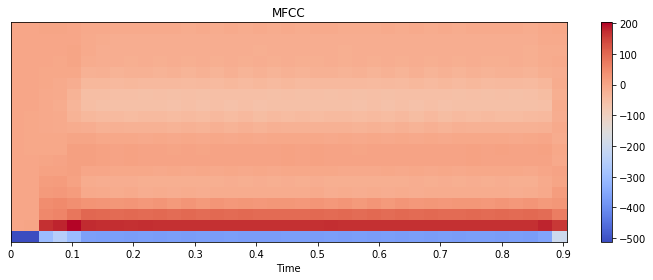

In [6]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mfcc[140,...], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [7]:
X_test_mfcc = np.reshape(X_test_mfcc, (X_test_mfcc.shape[0],-1))
X_train_mfcc = np.reshape(X_train_mfcc, (X_train_mfcc.shape[0],-1))
print X_test_mfcc.shape
print X_train_mfcc.shape

(200, 780)
(800, 780)


## Predictions

In [8]:
import sys
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV

headers=['algo', 'type', 'param1','param2','regularization',
         'target','metric', 'train_score', 'test_score']
with open(RESULTS_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

def evaluate_algo(algo_label, grid_reg, grid_class):
    results = []
    for t_i, t_name in enumerate(list(Y_train)):
        print 'predicting feature', t_name
        y_train = Y_train[[t_name]].values.flatten()
        y_test = Y_test[[t_name]].values.flatten()
        print y_train.dtype
        
        best_params_C = None
        best_params_R = None
        
        try:
            # Case 1: classification
            if y_train.dtype == 'object':

                metric = 'class'

                # Cross-Validation Score
                grid_class.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_class.best_score_
                best_params_C = grid_class.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_class.predict(X_test_mfcc)
                test_score = accuracy_score(test_pred, y_test)
                print test_score


            # Case 2: regression
            elif y_train.dtype == 'float64':

                metric = 'reg'

                # Cross-Validation Score
                grid_reg.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_reg.best_score_ * -1
                best_params_R = grid_reg.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_reg.predict(X_test_mfcc)
                test_score = mean_absolute_error(test_pred, y_test)
                print test_score

            else:
                raise ValueError('Wrong Column Type')

            out = (algo_label, 'per_output', best_params_R, best_params_C,None,
                   t_name, metric, cross_val_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

        except:
            print "Unexpected error:", sys.exc_info()[0]

In [9]:
from sklearn import neighbors

algo_C =neighbors.KNeighborsClassifier()
grid_C = GridSearchCV(algo_C, {"n_neighbors":[3,5,8,16]}, scoring='accuracy', verbose=2)

algo_R =neighbors.KNeighborsRegressor()
grid_R = GridSearchCV(algo_R, {"n_neighbors":[3,5,8,16]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('kNN', grid_R, grid_C)

predicting feature lfo1_rate
float64
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s finished


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s finished


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.4s finished


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.5s finished


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.5s finished


In [10]:
from sklearn import tree

algo_C = tree.DecisionTreeClassifier()
grid_C = GridSearchCV(algo_C, {"max_depth":[2,4,8,16,32,64,128]}, scoring='accuracy', verbose=2)

algo_R = tree.DecisionTreeRegressor()
grid_R = GridSearchCV(algo_R, {"max_depth":[2,4,8,16,32,64,128]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Decision Tree', grid_R, grid_C)

predicting feature lfo1_rate
float64
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.7s finished


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.3s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.5s finished


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.3s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.7s finished


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.6s finished


0.88625
0.865
('Decision Tree', 'per_output', None, {'max_depth': 16}, None, 'osc2_wave', 'class', 0.88624999999999998, 0.86499999999999999)
predicting feature filter_resonance
float64
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    5.2s finished


In [11]:
from sklearn import dummy

algo_C = dummy.DummyClassifier()
grid_C = GridSearchCV(algo_C, {"strategy":["most_frequent"]}, scoring='accuracy', verbose=2)

algo_R = dummy.DummyRegressor()
grid_R = GridSearchCV(algo_R, {"strategy":["mean"]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Naive', grid_R, grid_C)

predicting feature lfo1_rate
float64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.47532804526
2.6774015748
('Naive', 'per_output', {'strategy': 'mean'}, None, None, 'lfo1_rate', 'reg', 2.4753280452584878, 2.6774015748033846)
predicting feature filter_cutoff
float64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] ...............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [12]:
# from sklearn import svm

# algo_R = svm.SVR(kernel='linear')
# grid_R = GridSearchCV(algo_R, {'C':[.01, .1, 1.]},
#                       scoring='neg_mean_absolute_error', verbose=2,
#                      n_jobs =4)

# algo_C = svm.SVC(kernel='linear')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1.]},
#                       scoring='accuracy', verbose=2,
#                       n_jobs =4)


# evaluate_algo('SVM_lin', grid_R, grid_C)

# algo_R = svm.SVR(kernel='RBF')
# grid_R = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='neg_mean_absolute_error', verbose=2)

# algo_C = svm.SVC(kernel='RBF')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='accuracy', verbose=2)


# evaluate_algo('SVM_RBF', grid_R, grid_C)

# Joint modelling + MFCCs

In [13]:
import collections

def target_info(df_y):
    infos = collections.OrderedDict()
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

lfo1_rate
filter_cutoff
lfo1_amount
osc2_wave
filter_resonance
OrderedDict([('lfo1_rate', {'sd': 2.8756837733162297, 'type': dtype('float64'), 'mean': 5.064960629921563}), ('filter_cutoff', {'sd': 2.89234557524474, 'type': dtype('float64'), 'mean': 5.0103346456694338}), ('lfo1_amount', {'sd': 2.932316237542842, 'type': dtype('float64'), 'mean': 4.9543307086615656}), ('osc2_wave', {'char2int': {'Sine': 3, 'Noise': 0, 'Saw': 2, 'Triangle': 4, 'Pulse': 1}, 'int2char': {0: 'Noise', 1: 'Pulse', 2: 'Saw', 3: 'Sine', 4: 'Triangle'}, 'type': dtype('O')}), ('filter_resonance', {'sd': 2.9479893137687894, 'type': dtype('float64'), 'mean': 5.0626968503939489})])


In [14]:
# Preps input data
X_train_mfcc = X_train_mfcc.reshape([X_train_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)
X_test_mfcc = X_test_mfcc.reshape([X_test_mfcc.shape[0],N_MFCC,-1]).transpose(0,2,1)

print ''
print X_train_mfcc.shape
print X_test_mfcc.shape


(800, 39, 20)
(200, 39, 20)


In [15]:
from keras.callbacks import EarlyStopping

def format_output(Y):
    out = {}
    for name,infos in Y_info.iteritems():
        if infos['type'] == 'float64':
            y = (Y[name] - infos['mean']) / infos['sd']
            
        elif infos['type'] == 'object':
            char2int = infos['char2int']
            y = np.zeros((len(Y[name]), len(char2int)))
            for i,yval in enumerate(Y[name]):
                y[i, char2int[yval]] = 1
                
        else:
            raise ValueError
        
        print name, y.shape
        out[name] = y
    
    return out

        
def test_model(label, params1, params2, regul, model):
    
    # Prepares input and output data
    X_mean = np.mean(X_train_mfcc, axis=(0))
    X_sd = np.std(X_train_mfcc, axis=(0))
    
    X_train = (X_train_mfcc - X_mean) / X_sd
    X_test  = (X_test_mfcc - X_mean) / X_sd
    
    Y_dict_train = format_output(Y_train)
    Y_dict_test  = format_output(Y_test)
    
    # Trains the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=25)
    hist = model.fit(X_train, Y_dict_train, 
              epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE,
             validation_split = VALIDATION, callbacks=[early_stopping])
    
    # Makes predictions
    pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    
    # Gets validation and test scores (for each metric)
    Y = {}
    for j, Y_pred in enumerate(pred):
        t_name = Y_info.keys()[j]
        t_infos = Y_info[t_name]
        
        print t_name
        print Y_pred.shape

        if t_infos['type'] == 'float64':
            test_metric = 'reg'
            Y_pred = Y_pred.flatten()
            y_pred = Y_pred * t_infos['sd'] + t_infos['mean']
            y_pred = y_pred.tolist()
            test_score = mean_absolute_error(y_pred, Y_test[t_name])
        
        elif t_infos['type'] == 'object':
            test_metric = 'class'
            y_i = np.argmax(Y_pred, axis=1)
            y_pred = [t_infos['int2char'][y] for y in y_i]
            test_score = accuracy_score(y_pred, Y_test[t_name])

        else:
            raise ValueError
        
        #train_scores = hist.history[t_name + '_loss'][-1]
        train_scores = -1 * hist.history['val_loss'][-1]
        out = (label, 'joint', params1, params2, regul,
               t_name, test_metric, train_scores, test_score)
        print out
        with open(RESULTS_FILE, 'a') as f:
            writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
            writer.writerow(out)

        Y[t_name] = y_pred
    
    Y = pd.DataFrame(Y)
    return Y

Using TensorFlow backend.


In [16]:
# Model 1: 1 layer perceptron
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras import regularizers

def MLP(n_hidden_units, n_layers, regul):
    # Input layer
    in_shape = (X_test_mfcc.shape[1],X_test_mfcc.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = Flatten()(in_layer)
    for i in range(n_layers):
        h_layer = Dense(n_hidden_units, activation='relu')(h_layer)

    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [16,32,64]:
        for REGUL in [0,0.01,0.1]:
            model = MLP(N_UNITS, N_LAYERS, REGUL)
            out = test_model('MLP', N_UNITS, N_LAYERS, REGUL, model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 39, 20)        0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 780)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 16)            12496                                        
____________________________________________________________________________________________________
lfo1_rate (Dense)                (None, 1)             17                                           
___________________________________________________________________________________________

720/720 [==============================] - 0s - loss: 2.5896 - lfo1_rate_loss: 0.6547 - filter_cutoff_loss: 0.4087 - lfo1_amount_loss: 0.6586 - osc2_wave_loss: 0.2903 - filter_resonance_loss: 0.5774 - val_loss: 3.5774 - val_lfo1_rate_loss: 0.8158 - val_filter_cutoff_loss: 0.5146 - val_lfo1_amount_loss: 0.9139 - val_osc2_wave_loss: 0.5145 - val_filter_resonance_loss: 0.8186
Epoch 17/250
720/720 [==============================] - 0s - loss: 2.5537 - lfo1_rate_loss: 0.6444 - filter_cutoff_loss: 0.4188 - lfo1_amount_loss: 0.6541 - osc2_wave_loss: 0.2744 - filter_resonance_loss: 0.5618 - val_loss: 3.4545 - val_lfo1_rate_loss: 0.8180 - val_filter_cutoff_loss: 0.4828 - val_lfo1_amount_loss: 0.8875 - val_osc2_wave_loss: 0.4909 - val_filter_resonance_loss: 0.7752
Epoch 18/250
720/720 [==============================] - 0s - loss: 2.5011 - lfo1_rate_loss: 0.6288 - filter_cutoff_loss: 0.4161 - lfo1_amount_loss: 0.6410 - osc2_wave_loss: 0.2590 - filter_resonance_loss: 0.5561 - val_loss: 3.5606 - va

720/720 [==============================] - 0s - loss: 2.0527 - lfo1_rate_loss: 0.5572 - filter_cutoff_loss: 0.3328 - lfo1_amount_loss: 0.5768 - osc2_wave_loss: 0.1279 - filter_resonance_loss: 0.4580 - val_loss: 3.3733 - val_lfo1_rate_loss: 0.8504 - val_filter_cutoff_loss: 0.5369 - val_lfo1_amount_loss: 0.9044 - val_osc2_wave_loss: 0.3338 - val_filter_resonance_loss: 0.7479
Epoch 38/250
720/720 [==============================] - 0s - loss: 2.0186 - lfo1_rate_loss: 0.5544 - filter_cutoff_loss: 0.3430 - lfo1_amount_loss: 0.5515 - osc2_wave_loss: 0.1189 - filter_resonance_loss: 0.4509 - val_loss: 3.3786 - val_lfo1_rate_loss: 0.8560 - val_filter_cutoff_loss: 0.5138 - val_lfo1_amount_loss: 0.9000 - val_osc2_wave_loss: 0.3213 - val_filter_resonance_loss: 0.7875
Epoch 39/250
720/720 [==============================] - 0s - loss: 2.0524 - lfo1_rate_loss: 0.5611 - filter_cutoff_loss: 0.3424 - lfo1_amount_loss: 0.5531 - osc2_wave_loss: 0.1197 - filter_resonance_loss: 0.4761 - val_loss: 3.4223 - va

720/720 [==============================] - 0s - loss: 1.7699 - lfo1_rate_loss: 0.5087 - filter_cutoff_loss: 0.2893 - lfo1_amount_loss: 0.4890 - osc2_wave_loss: 0.0762 - filter_resonance_loss: 0.4068 - val_loss: 3.4233 - val_lfo1_rate_loss: 0.8734 - val_filter_cutoff_loss: 0.5174 - val_lfo1_amount_loss: 0.9343 - val_osc2_wave_loss: 0.2995 - val_filter_resonance_loss: 0.7987
Epoch 59/250
720/720 [==============================] - 0s - loss: 1.7778 - lfo1_rate_loss: 0.5024 - filter_cutoff_loss: 0.2953 - lfo1_amount_loss: 0.4971 - osc2_wave_loss: 0.0740 - filter_resonance_loss: 0.4089 - val_loss: 3.3557 - val_lfo1_rate_loss: 0.8599 - val_filter_cutoff_loss: 0.4904 - val_lfo1_amount_loss: 0.9230 - val_osc2_wave_loss: 0.3025 - val_filter_resonance_loss: 0.7798
Epoch 60/250
720/720 [==============================] - 0s - loss: 1.7948 - lfo1_rate_loss: 0.5022 - filter_cutoff_loss: 0.3055 - lfo1_amount_loss: 0.4995 - osc2_wave_loss: 0.0721 - filter_resonance_loss: 0.4155 - val_loss: 3.4460 - va

720/720 [==============================] - 0s - loss: 1.6575 - lfo1_rate_loss: 0.4959 - filter_cutoff_loss: 0.2707 - lfo1_amount_loss: 0.4580 - osc2_wave_loss: 0.0556 - filter_resonance_loss: 0.3773 - val_loss: 3.4102 - val_lfo1_rate_loss: 0.8829 - val_filter_cutoff_loss: 0.5033 - val_lfo1_amount_loss: 0.9606 - val_osc2_wave_loss: 0.3209 - val_filter_resonance_loss: 0.7425
Epoch 80/250
720/720 [==============================] - 0s - loss: 1.6492 - lfo1_rate_loss: 0.4988 - filter_cutoff_loss: 0.2716 - lfo1_amount_loss: 0.4578 - osc2_wave_loss: 0.0524 - filter_resonance_loss: 0.3686 - val_loss: 3.4777 - val_lfo1_rate_loss: 0.8957 - val_filter_cutoff_loss: 0.5054 - val_lfo1_amount_loss: 0.9900 - val_osc2_wave_loss: 0.3044 - val_filter_resonance_loss: 0.7822
Epoch 81/250
720/720 [==============================] - 0s - loss: 1.6188 - lfo1_rate_loss: 0.4836 - filter_cutoff_loss: 0.2732 - lfo1_amount_loss: 0.4494 - osc2_wave_loss: 0.0522 - filter_resonance_loss: 0.3604 - val_loss: 3.3587 - va

720/720 [==============================] - 0s - loss: 2.9789 - lfo1_rate_loss: 0.7041 - filter_cutoff_loss: 0.4830 - lfo1_amount_loss: 0.7143 - osc2_wave_loss: 0.4207 - filter_resonance_loss: 0.6567 - val_loss: 3.9317 - val_lfo1_rate_loss: 0.9281 - val_filter_cutoff_loss: 0.6138 - val_lfo1_amount_loss: 0.9114 - val_osc2_wave_loss: 0.6618 - val_filter_resonance_loss: 0.8166
Epoch 10/250
720/720 [==============================] - 0s - loss: 2.9171 - lfo1_rate_loss: 0.6839 - filter_cutoff_loss: 0.4774 - lfo1_amount_loss: 0.7067 - osc2_wave_loss: 0.4117 - filter_resonance_loss: 0.6374 - val_loss: 3.5964 - val_lfo1_rate_loss: 0.8168 - val_filter_cutoff_loss: 0.5578 - val_lfo1_amount_loss: 0.8654 - val_osc2_wave_loss: 0.6152 - val_filter_resonance_loss: 0.7412
Epoch 11/250
720/720 [==============================] - 0s - loss: 2.8508 - lfo1_rate_loss: 0.6685 - filter_cutoff_loss: 0.4645 - lfo1_amount_loss: 0.6914 - osc2_wave_loss: 0.3751 - filter_resonance_loss: 0.6513 - val_loss: 3.7326 - va

720/720 [==============================] - 0s - loss: 2.2078 - lfo1_rate_loss: 0.5829 - filter_cutoff_loss: 0.3684 - lfo1_amount_loss: 0.5823 - osc2_wave_loss: 0.1750 - filter_resonance_loss: 0.4992 - val_loss: 3.4161 - val_lfo1_rate_loss: 0.8993 - val_filter_cutoff_loss: 0.5152 - val_lfo1_amount_loss: 0.8251 - val_osc2_wave_loss: 0.3983 - val_filter_resonance_loss: 0.7782
Epoch 31/250
720/720 [==============================] - 0s - loss: 2.2003 - lfo1_rate_loss: 0.5722 - filter_cutoff_loss: 0.3872 - lfo1_amount_loss: 0.5695 - osc2_wave_loss: 0.1627 - filter_resonance_loss: 0.5086 - val_loss: 3.5473 - val_lfo1_rate_loss: 0.8905 - val_filter_cutoff_loss: 0.6475 - val_lfo1_amount_loss: 0.8589 - val_osc2_wave_loss: 0.3999 - val_filter_resonance_loss: 0.7504
Epoch 32/250
720/720 [==============================] - 0s - loss: 2.1864 - lfo1_rate_loss: 0.5464 - filter_cutoff_loss: 0.3944 - lfo1_amount_loss: 0.5880 - osc2_wave_loss: 0.1625 - filter_resonance_loss: 0.4951 - val_loss: 3.3717 - va

720/720 [==============================] - 0s - loss: 1.9097 - lfo1_rate_loss: 0.5243 - filter_cutoff_loss: 0.3135 - lfo1_amount_loss: 0.5257 - osc2_wave_loss: 0.1024 - filter_resonance_loss: 0.4438 - val_loss: 3.3004 - val_lfo1_rate_loss: 0.8919 - val_filter_cutoff_loss: 0.5109 - val_lfo1_amount_loss: 0.8407 - val_osc2_wave_loss: 0.3112 - val_filter_resonance_loss: 0.7458
Epoch 52/250
720/720 [==============================] - 0s - loss: 1.9110 - lfo1_rate_loss: 0.5301 - filter_cutoff_loss: 0.3247 - lfo1_amount_loss: 0.5321 - osc2_wave_loss: 0.0981 - filter_resonance_loss: 0.4260 - val_loss: 3.5272 - val_lfo1_rate_loss: 0.9386 - val_filter_cutoff_loss: 0.5448 - val_lfo1_amount_loss: 0.8991 - val_osc2_wave_loss: 0.3514 - val_filter_resonance_loss: 0.7934
Epoch 53/250
720/720 [==============================] - 0s - loss: 1.8585 - lfo1_rate_loss: 0.5125 - filter_cutoff_loss: 0.3114 - lfo1_amount_loss: 0.5245 - osc2_wave_loss: 0.0958 - filter_resonance_loss: 0.4142 - val_loss: 3.3814 - va

720/720 [==============================] - 0s - loss: 1.7067 - lfo1_rate_loss: 0.4865 - filter_cutoff_loss: 0.2965 - lfo1_amount_loss: 0.4735 - osc2_wave_loss: 0.0670 - filter_resonance_loss: 0.3833 - val_loss: 3.4203 - val_lfo1_rate_loss: 0.8833 - val_filter_cutoff_loss: 0.5340 - val_lfo1_amount_loss: 0.8848 - val_osc2_wave_loss: 0.3424 - val_filter_resonance_loss: 0.7757
Epoch 73/250
 32/200 [===>..........................] - ETA: 0slfo1_rate
(200, 1)
('MLP', 'joint', 16, 1, 0.01, 'lfo1_rate', 'reg', -3.4701500892639161, 2.4765260643849296)
filter_cutoff
(200, 1)
('MLP', 'joint', 16, 1, 0.01, 'filter_cutoff', 'reg', -3.4701500892639161, 1.4726048280499777)
lfo1_amount
(200, 1)
('MLP', 'joint', 16, 1, 0.01, 'lfo1_amount', 'reg', -3.4701500892639161, 3.0406102061082159)
osc2_wave
(200, 5)
('MLP', 'joint', 16, 1, 0.01, 'osc2_wave', 'class', -3.4701500892639161, 0.91500000000000004)
filter_resonance
(200, 1)
('MLP', 'joint', 16, 1, 0.01, 'filter_resonance', 'reg', -3.4701500892639161, 2.

720/720 [==============================] - 0s - loss: 2.7125 - lfo1_rate_loss: 0.6694 - filter_cutoff_loss: 0.4243 - lfo1_amount_loss: 0.6713 - osc2_wave_loss: 0.3776 - filter_resonance_loss: 0.5700 - val_loss: 3.3865 - val_lfo1_rate_loss: 0.7839 - val_filter_cutoff_loss: 0.5137 - val_lfo1_amount_loss: 0.8084 - val_osc2_wave_loss: 0.5346 - val_filter_resonance_loss: 0.7459
Epoch 13/250
720/720 [==============================] - 0s - loss: 2.6496 - lfo1_rate_loss: 0.6442 - filter_cutoff_loss: 0.4385 - lfo1_amount_loss: 0.6603 - osc2_wave_loss: 0.3529 - filter_resonance_loss: 0.5537 - val_loss: 3.3862 - val_lfo1_rate_loss: 0.8092 - val_filter_cutoff_loss: 0.5210 - val_lfo1_amount_loss: 0.8066 - val_osc2_wave_loss: 0.5310 - val_filter_resonance_loss: 0.7184
Epoch 14/250
720/720 [==============================] - 0s - loss: 2.5991 - lfo1_rate_loss: 0.6371 - filter_cutoff_loss: 0.4158 - lfo1_amount_loss: 0.6557 - osc2_wave_loss: 0.3382 - filter_resonance_loss: 0.5523 - val_loss: 3.2974 - va

720/720 [==============================] - 0s - loss: 2.1238 - lfo1_rate_loss: 0.5810 - filter_cutoff_loss: 0.3427 - lfo1_amount_loss: 0.5856 - osc2_wave_loss: 0.1732 - filter_resonance_loss: 0.4414 - val_loss: 3.2168 - val_lfo1_rate_loss: 0.7833 - val_filter_cutoff_loss: 0.4898 - val_lfo1_amount_loss: 0.8515 - val_osc2_wave_loss: 0.3413 - val_filter_resonance_loss: 0.7510
Epoch 34/250
720/720 [==============================] - 0s - loss: 2.0761 - lfo1_rate_loss: 0.5659 - filter_cutoff_loss: 0.3371 - lfo1_amount_loss: 0.5675 - osc2_wave_loss: 0.1714 - filter_resonance_loss: 0.4341 - val_loss: 3.1592 - val_lfo1_rate_loss: 0.8289 - val_filter_cutoff_loss: 0.4931 - val_lfo1_amount_loss: 0.8029 - val_osc2_wave_loss: 0.3140 - val_filter_resonance_loss: 0.7203
Epoch 35/250
720/720 [==============================] - 0s - loss: 2.0650 - lfo1_rate_loss: 0.5675 - filter_cutoff_loss: 0.3300 - lfo1_amount_loss: 0.5673 - osc2_wave_loss: 0.1662 - filter_resonance_loss: 0.4340 - val_loss: 3.0380 - va

720/720 [==============================] - 0s - loss: 1.8334 - lfo1_rate_loss: 0.5361 - filter_cutoff_loss: 0.3012 - lfo1_amount_loss: 0.5052 - osc2_wave_loss: 0.1139 - filter_resonance_loss: 0.3769 - val_loss: 3.0239 - val_lfo1_rate_loss: 0.8047 - val_filter_cutoff_loss: 0.4652 - val_lfo1_amount_loss: 0.7691 - val_osc2_wave_loss: 0.2459 - val_filter_resonance_loss: 0.7389
Epoch 55/250
720/720 [==============================] - 0s - loss: 1.7896 - lfo1_rate_loss: 0.5350 - filter_cutoff_loss: 0.2873 - lfo1_amount_loss: 0.5003 - osc2_wave_loss: 0.1074 - filter_resonance_loss: 0.3595 - val_loss: 3.0231 - val_lfo1_rate_loss: 0.8124 - val_filter_cutoff_loss: 0.4692 - val_lfo1_amount_loss: 0.7673 - val_osc2_wave_loss: 0.2367 - val_filter_resonance_loss: 0.7375
Epoch 56/250
720/720 [==============================] - 0s - loss: 1.8034 - lfo1_rate_loss: 0.5367 - filter_cutoff_loss: 0.2910 - lfo1_amount_loss: 0.5094 - osc2_wave_loss: 0.1032 - filter_resonance_loss: 0.3630 - val_loss: 3.0910 - va

720/720 [==============================] - 0s - loss: 1.6774 - lfo1_rate_loss: 0.5137 - filter_cutoff_loss: 0.2836 - lfo1_amount_loss: 0.4723 - osc2_wave_loss: 0.0746 - filter_resonance_loss: 0.3332 - val_loss: 3.0213 - val_lfo1_rate_loss: 0.8093 - val_filter_cutoff_loss: 0.4578 - val_lfo1_amount_loss: 0.7732 - val_osc2_wave_loss: 0.2052 - val_filter_resonance_loss: 0.7758
Epoch 76/250
720/720 [==============================] - 0s - loss: 1.6663 - lfo1_rate_loss: 0.5166 - filter_cutoff_loss: 0.2863 - lfo1_amount_loss: 0.4669 - osc2_wave_loss: 0.0721 - filter_resonance_loss: 0.3244 - val_loss: 3.0721 - val_lfo1_rate_loss: 0.7991 - val_filter_cutoff_loss: 0.4881 - val_lfo1_amount_loss: 0.7825 - val_osc2_wave_loss: 0.2080 - val_filter_resonance_loss: 0.7944
Epoch 77/250
720/720 [==============================] - 0s - loss: 1.6880 - lfo1_rate_loss: 0.4994 - filter_cutoff_loss: 0.2902 - lfo1_amount_loss: 0.4779 - osc2_wave_loss: 0.0726 - filter_resonance_loss: 0.3478 - val_loss: 3.0420 - va

 32/200 [===>..........................] - ETA: 0slfo1_rate
(200, 1)
('MLP', 'joint', 16, 1, 0.1, 'lfo1_rate', 'reg', -3.1464907646179201, 2.5034988869643233)
filter_cutoff
(200, 1)
('MLP', 'joint', 16, 1, 0.1, 'filter_cutoff', 'reg', -3.1464907646179201, 1.5218775475212021)
lfo1_amount
(200, 1)
('MLP', 'joint', 16, 1, 0.1, 'lfo1_amount', 'reg', -3.1464907646179201, 2.8346854821620888)
osc2_wave
(200, 5)
('MLP', 'joint', 16, 1, 0.1, 'osc2_wave', 'class', -3.1464907646179201, 0.90500000000000003)
filter_resonance
(200, 1)
('MLP', 'joint', 16, 1, 0.1, 'filter_resonance', 'reg', -3.1464907646179201, 1.9428038154342966)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 39, 20)        0                                            
_________________________________________________________________________

720/720 [==============================] - 0s - loss: 2.2631 - lfo1_rate_loss: 0.5738 - filter_cutoff_loss: 0.3449 - lfo1_amount_loss: 0.6332 - osc2_wave_loss: 0.2076 - filter_resonance_loss: 0.5036 - val_loss: 3.3063 - val_lfo1_rate_loss: 0.8781 - val_filter_cutoff_loss: 0.5452 - val_lfo1_amount_loss: 0.8975 - val_osc2_wave_loss: 0.3550 - val_filter_resonance_loss: 0.6305
Epoch 15/250
720/720 [==============================] - 0s - loss: 2.2265 - lfo1_rate_loss: 0.5795 - filter_cutoff_loss: 0.3607 - lfo1_amount_loss: 0.5988 - osc2_wave_loss: 0.1888 - filter_resonance_loss: 0.4988 - val_loss: 3.2443 - val_lfo1_rate_loss: 0.8457 - val_filter_cutoff_loss: 0.5349 - val_lfo1_amount_loss: 0.9112 - val_osc2_wave_loss: 0.3728 - val_filter_resonance_loss: 0.5798
Epoch 16/250
720/720 [==============================] - 0s - loss: 2.1634 - lfo1_rate_loss: 0.5509 - filter_cutoff_loss: 0.3677 - lfo1_amount_loss: 0.5839 - osc2_wave_loss: 0.1819 - filter_resonance_loss: 0.4790 - val_loss: 3.2802 - va

720/720 [==============================] - 0s - loss: 1.7002 - lfo1_rate_loss: 0.4676 - filter_cutoff_loss: 0.2752 - lfo1_amount_loss: 0.4847 - osc2_wave_loss: 0.0702 - filter_resonance_loss: 0.4025 - val_loss: 3.2138 - val_lfo1_rate_loss: 0.9386 - val_filter_cutoff_loss: 0.5219 - val_lfo1_amount_loss: 0.9652 - val_osc2_wave_loss: 0.2047 - val_filter_resonance_loss: 0.5834
Epoch 36/250
720/720 [==============================] - 0s - loss: 1.7233 - lfo1_rate_loss: 0.4697 - filter_cutoff_loss: 0.2803 - lfo1_amount_loss: 0.5010 - osc2_wave_loss: 0.0662 - filter_resonance_loss: 0.4061 - val_loss: 3.2473 - val_lfo1_rate_loss: 0.8743 - val_filter_cutoff_loss: 0.5090 - val_lfo1_amount_loss: 1.0211 - val_osc2_wave_loss: 0.2431 - val_filter_resonance_loss: 0.5999
Epoch 37/250
720/720 [==============================] - 0s - loss: 1.7506 - lfo1_rate_loss: 0.4786 - filter_cutoff_loss: 0.2949 - lfo1_amount_loss: 0.4948 - osc2_wave_loss: 0.0647 - filter_resonance_loss: 0.4177 - val_loss: 3.1971 - va

720/720 [==============================] - 0s - loss: 1.4013 - lfo1_rate_loss: 0.4139 - filter_cutoff_loss: 0.2348 - lfo1_amount_loss: 0.4132 - osc2_wave_loss: 0.0307 - filter_resonance_loss: 0.3085 - val_loss: 3.1534 - val_lfo1_rate_loss: 0.8628 - val_filter_cutoff_loss: 0.5171 - val_lfo1_amount_loss: 0.9189 - val_osc2_wave_loss: 0.2369 - val_filter_resonance_loss: 0.6177
Epoch 57/250
720/720 [==============================] - 0s - loss: 1.4065 - lfo1_rate_loss: 0.4148 - filter_cutoff_loss: 0.2387 - lfo1_amount_loss: 0.4162 - osc2_wave_loss: 0.0293 - filter_resonance_loss: 0.3073 - val_loss: 3.1592 - val_lfo1_rate_loss: 0.8890 - val_filter_cutoff_loss: 0.4956 - val_lfo1_amount_loss: 0.9293 - val_osc2_wave_loss: 0.2173 - val_filter_resonance_loss: 0.6279
Epoch 58/250
720/720 [==============================] - 0s - loss: 1.3894 - lfo1_rate_loss: 0.4237 - filter_cutoff_loss: 0.2280 - lfo1_amount_loss: 0.3991 - osc2_wave_loss: 0.0297 - filter_resonance_loss: 0.3089 - val_loss: 3.1508 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 0s - loss: 4.9185 - lfo1_rate_loss: 1.0014 - filter_cutoff_loss: 0.8060 - lfo1_amount_loss: 1.0393 - osc2_wave_loss: 1.1461 - filter_resonance_loss: 0.9257 - val_loss: 4.4107 - val_lfo1_rate_loss: 1.0515 - val_filter_cutoff_loss: 0.6645 - val_lfo1_amount_loss: 0.9067 - val_osc2_wave_loss: 0.8965 - val_filter_resonance_loss: 0.8914
Epoch 2/250
720/720 [==============================] - 0s - loss: 3.7414 - lfo1_rate_loss: 0.8212 - filter_cutoff_loss: 0.6034 - lfo1_amount_loss: 0.8980 - osc2_wave_loss: 0.6689 - filter_resonance_loss: 0.7500 - val_loss: 3.8590 - val_lfo1_rate_loss: 0.8709 - val_filter_cutoff_loss: 0.6044 - val_lfo1_amount_loss: 0.8163 - val_osc2_wave_loss: 0.7404 - val_filter_resonance_loss: 0.8269
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.3532 - lfo1_rate_loss: 0.7477 - filter_cutoff_loss: 0.5580 - lfo1_amount_loss: 0.8145 - osc2_wave_loss: 0.5303 

720/720 [==============================] - 0s - loss: 2.0540 - lfo1_rate_loss: 0.5626 - filter_cutoff_loss: 0.3384 - lfo1_amount_loss: 0.5721 - osc2_wave_loss: 0.1106 - filter_resonance_loss: 0.4704 - val_loss: 3.0770 - val_lfo1_rate_loss: 0.8342 - val_filter_cutoff_loss: 0.4822 - val_lfo1_amount_loss: 0.7899 - val_osc2_wave_loss: 0.3385 - val_filter_resonance_loss: 0.6322
Epoch 22/250
720/720 [==============================] - 0s - loss: 1.9602 - lfo1_rate_loss: 0.5260 - filter_cutoff_loss: 0.3494 - lfo1_amount_loss: 0.5702 - osc2_wave_loss: 0.1062 - filter_resonance_loss: 0.4085 - val_loss: 3.1275 - val_lfo1_rate_loss: 0.8591 - val_filter_cutoff_loss: 0.4891 - val_lfo1_amount_loss: 0.7835 - val_osc2_wave_loss: 0.3308 - val_filter_resonance_loss: 0.6651
Epoch 23/250
720/720 [==============================] - 0s - loss: 1.9437 - lfo1_rate_loss: 0.5139 - filter_cutoff_loss: 0.3354 - lfo1_amount_loss: 0.5808 - osc2_wave_loss: 0.1008 - filter_resonance_loss: 0.4127 - val_loss: 3.0449 - va

720/720 [==============================] - 0s - loss: 1.5638 - lfo1_rate_loss: 0.4576 - filter_cutoff_loss: 0.2820 - lfo1_amount_loss: 0.4545 - osc2_wave_loss: 0.0439 - filter_resonance_loss: 0.3258 - val_loss: 3.0918 - val_lfo1_rate_loss: 0.8769 - val_filter_cutoff_loss: 0.4792 - val_lfo1_amount_loss: 0.8103 - val_osc2_wave_loss: 0.2891 - val_filter_resonance_loss: 0.6364
Epoch 43/250
720/720 [==============================] - 0s - loss: 1.5434 - lfo1_rate_loss: 0.4602 - filter_cutoff_loss: 0.2692 - lfo1_amount_loss: 0.4620 - osc2_wave_loss: 0.0420 - filter_resonance_loss: 0.3100 - val_loss: 3.0280 - val_lfo1_rate_loss: 0.8470 - val_filter_cutoff_loss: 0.5109 - val_lfo1_amount_loss: 0.7706 - val_osc2_wave_loss: 0.2948 - val_filter_resonance_loss: 0.6046
Epoch 44/250
720/720 [==============================] - 0s - loss: 1.5539 - lfo1_rate_loss: 0.4527 - filter_cutoff_loss: 0.2878 - lfo1_amount_loss: 0.4542 - osc2_wave_loss: 0.0405 - filter_resonance_loss: 0.3187 - val_loss: 3.0963 - va

720/720 [==============================] - 0s - loss: 5.0200 - lfo1_rate_loss: 0.9904 - filter_cutoff_loss: 0.8735 - lfo1_amount_loss: 1.0377 - osc2_wave_loss: 1.1302 - filter_resonance_loss: 0.9883 - val_loss: 4.7092 - val_lfo1_rate_loss: 0.9892 - val_filter_cutoff_loss: 0.7423 - val_lfo1_amount_loss: 0.9745 - val_osc2_wave_loss: 1.0589 - val_filter_resonance_loss: 0.9442
Epoch 2/250
720/720 [==============================] - 0s - loss: 3.8940 - lfo1_rate_loss: 0.8181 - filter_cutoff_loss: 0.6392 - lfo1_amount_loss: 0.9074 - osc2_wave_loss: 0.7364 - filter_resonance_loss: 0.7930 - val_loss: 4.1482 - val_lfo1_rate_loss: 0.8845 - val_filter_cutoff_loss: 0.5982 - val_lfo1_amount_loss: 0.8977 - val_osc2_wave_loss: 0.8866 - val_filter_resonance_loss: 0.8812
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.4478 - lfo1_rate_loss: 0.7374 - filter_cutoff_loss: 0.5567 - lfo1_amount_loss: 0.8205 - osc2_wave_loss: 0.6055 - filter_resonance_loss: 0.7277 - val_loss: 4.0339 - val_

720/720 [==============================] - 0s - loss: 1.9651 - lfo1_rate_loss: 0.5205 - filter_cutoff_loss: 0.3408 - lfo1_amount_loss: 0.5564 - osc2_wave_loss: 0.1423 - filter_resonance_loss: 0.4052 - val_loss: 3.2712 - val_lfo1_rate_loss: 0.7869 - val_filter_cutoff_loss: 0.5281 - val_lfo1_amount_loss: 0.9112 - val_osc2_wave_loss: 0.3401 - val_filter_resonance_loss: 0.7048
Epoch 23/250
720/720 [==============================] - 0s - loss: 1.9896 - lfo1_rate_loss: 0.5330 - filter_cutoff_loss: 0.3636 - lfo1_amount_loss: 0.5344 - osc2_wave_loss: 0.1343 - filter_resonance_loss: 0.4243 - val_loss: 3.4360 - val_lfo1_rate_loss: 0.9132 - val_filter_cutoff_loss: 0.5797 - val_lfo1_amount_loss: 0.8988 - val_osc2_wave_loss: 0.3226 - val_filter_resonance_loss: 0.7218
Epoch 24/250
720/720 [==============================] - 0s - loss: 1.9907 - lfo1_rate_loss: 0.5315 - filter_cutoff_loss: 0.3647 - lfo1_amount_loss: 0.5375 - osc2_wave_loss: 0.1303 - filter_resonance_loss: 0.4267 - val_loss: 3.3665 - va

720/720 [==============================] - 0s - loss: 1.5719 - lfo1_rate_loss: 0.4486 - filter_cutoff_loss: 0.2750 - lfo1_amount_loss: 0.4546 - osc2_wave_loss: 0.0679 - filter_resonance_loss: 0.3258 - val_loss: 3.2517 - val_lfo1_rate_loss: 0.8409 - val_filter_cutoff_loss: 0.5348 - val_lfo1_amount_loss: 0.9288 - val_osc2_wave_loss: 0.3051 - val_filter_resonance_loss: 0.6421
Epoch 44/250
720/720 [==============================] - 0s - loss: 1.5901 - lfo1_rate_loss: 0.4654 - filter_cutoff_loss: 0.2739 - lfo1_amount_loss: 0.4587 - osc2_wave_loss: 0.0640 - filter_resonance_loss: 0.3281 - val_loss: 3.4382 - val_lfo1_rate_loss: 0.9083 - val_filter_cutoff_loss: 0.6570 - val_lfo1_amount_loss: 0.9104 - val_osc2_wave_loss: 0.3154 - val_filter_resonance_loss: 0.6471
Epoch 45/250
720/720 [==============================] - 0s - loss: 1.6132 - lfo1_rate_loss: 0.4597 - filter_cutoff_loss: 0.2755 - lfo1_amount_loss: 0.4588 - osc2_wave_loss: 0.0630 - filter_resonance_loss: 0.3562 - val_loss: 3.3400 - va

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 39, 20)        0                                            
____________________________________________________________________________________________________
flatten_7 (Flatten)              (None, 780)           0                                            
____________________________________________________________________________________________________
dense_7 (Dense)                  (None, 64)            49984                                        
____________________________________________________________________________________________________
lfo1_rate (Dense)                (None, 1)             65                                           
___________________________________________________________________________________________

720/720 [==============================] - 0s - loss: 1.9673 - lfo1_rate_loss: 0.5399 - filter_cutoff_loss: 0.3482 - lfo1_amount_loss: 0.5529 - osc2_wave_loss: 0.0990 - filter_resonance_loss: 0.4272 - val_loss: 3.1886 - val_lfo1_rate_loss: 0.8459 - val_filter_cutoff_loss: 0.5162 - val_lfo1_amount_loss: 0.8439 - val_osc2_wave_loss: 0.2928 - val_filter_resonance_loss: 0.6899
Epoch 17/250
720/720 [==============================] - 0s - loss: 2.0821 - lfo1_rate_loss: 0.5316 - filter_cutoff_loss: 0.3854 - lfo1_amount_loss: 0.6054 - osc2_wave_loss: 0.0948 - filter_resonance_loss: 0.4649 - val_loss: 3.2761 - val_lfo1_rate_loss: 0.8372 - val_filter_cutoff_loss: 0.5443 - val_lfo1_amount_loss: 0.8413 - val_osc2_wave_loss: 0.2706 - val_filter_resonance_loss: 0.7826
Epoch 18/250
720/720 [==============================] - 0s - loss: 1.9564 - lfo1_rate_loss: 0.5208 - filter_cutoff_loss: 0.3360 - lfo1_amount_loss: 0.5621 - osc2_wave_loss: 0.0846 - filter_resonance_loss: 0.4529 - val_loss: 3.2083 - va

720/720 [==============================] - 0s - loss: 1.5175 - lfo1_rate_loss: 0.4279 - filter_cutoff_loss: 0.2832 - lfo1_amount_loss: 0.4252 - osc2_wave_loss: 0.0306 - filter_resonance_loss: 0.3507 - val_loss: 3.1303 - val_lfo1_rate_loss: 0.8768 - val_filter_cutoff_loss: 0.5227 - val_lfo1_amount_loss: 0.8276 - val_osc2_wave_loss: 0.1969 - val_filter_resonance_loss: 0.7063
Epoch 38/250
720/720 [==============================] - 0s - loss: 1.5850 - lfo1_rate_loss: 0.4584 - filter_cutoff_loss: 0.2928 - lfo1_amount_loss: 0.4613 - osc2_wave_loss: 0.0297 - filter_resonance_loss: 0.3428 - val_loss: 3.2038 - val_lfo1_rate_loss: 0.9456 - val_filter_cutoff_loss: 0.5239 - val_lfo1_amount_loss: 0.8650 - val_osc2_wave_loss: 0.2241 - val_filter_resonance_loss: 0.6453
Epoch 39/250
720/720 [==============================] - 0s - loss: 1.5445 - lfo1_rate_loss: 0.4478 - filter_cutoff_loss: 0.2749 - lfo1_amount_loss: 0.4751 - osc2_wave_loss: 0.0276 - filter_resonance_loss: 0.3191 - val_loss: 3.1015 - va

720/720 [==============================] - 0s - loss: 1.3535 - lfo1_rate_loss: 0.3916 - filter_cutoff_loss: 0.2397 - lfo1_amount_loss: 0.4154 - osc2_wave_loss: 0.0147 - filter_resonance_loss: 0.2921 - val_loss: 3.0975 - val_lfo1_rate_loss: 0.9170 - val_filter_cutoff_loss: 0.5499 - val_lfo1_amount_loss: 0.8731 - val_osc2_wave_loss: 0.1617 - val_filter_resonance_loss: 0.5958
Epoch 59/250
720/720 [==============================] - 0s - loss: 1.3387 - lfo1_rate_loss: 0.4212 - filter_cutoff_loss: 0.2325 - lfo1_amount_loss: 0.3870 - osc2_wave_loss: 0.0144 - filter_resonance_loss: 0.2836 - val_loss: 3.1696 - val_lfo1_rate_loss: 0.9165 - val_filter_cutoff_loss: 0.5479 - val_lfo1_amount_loss: 0.9089 - val_osc2_wave_loss: 0.1650 - val_filter_resonance_loss: 0.6313
Epoch 60/250
720/720 [==============================] - 0s - loss: 1.3227 - lfo1_rate_loss: 0.4025 - filter_cutoff_loss: 0.2368 - lfo1_amount_loss: 0.3951 - osc2_wave_loss: 0.0138 - filter_resonance_loss: 0.2745 - val_loss: 3.0888 - va

720/720 [==============================] - 0s - loss: 2.3661 - lfo1_rate_loss: 0.5963 - filter_cutoff_loss: 0.3937 - lfo1_amount_loss: 0.6498 - osc2_wave_loss: 0.1970 - filter_resonance_loss: 0.5295 - val_loss: 3.2355 - val_lfo1_rate_loss: 0.8309 - val_filter_cutoff_loss: 0.5438 - val_lfo1_amount_loss: 0.7876 - val_osc2_wave_loss: 0.3695 - val_filter_resonance_loss: 0.7037
Epoch 10/250
720/720 [==============================] - 0s - loss: 2.2412 - lfo1_rate_loss: 0.5793 - filter_cutoff_loss: 0.3891 - lfo1_amount_loss: 0.6023 - osc2_wave_loss: 0.1809 - filter_resonance_loss: 0.4896 - val_loss: 3.1967 - val_lfo1_rate_loss: 0.8427 - val_filter_cutoff_loss: 0.5368 - val_lfo1_amount_loss: 0.7748 - val_osc2_wave_loss: 0.3589 - val_filter_resonance_loss: 0.6834
Epoch 11/250
720/720 [==============================] - 0s - loss: 2.1753 - lfo1_rate_loss: 0.5741 - filter_cutoff_loss: 0.3879 - lfo1_amount_loss: 0.6003 - osc2_wave_loss: 0.1633 - filter_resonance_loss: 0.4497 - val_loss: 3.3166 - va

720/720 [==============================] - 0s - loss: 1.6086 - lfo1_rate_loss: 0.4652 - filter_cutoff_loss: 0.2619 - lfo1_amount_loss: 0.4700 - osc2_wave_loss: 0.0423 - filter_resonance_loss: 0.3691 - val_loss: 3.0750 - val_lfo1_rate_loss: 0.8832 - val_filter_cutoff_loss: 0.4542 - val_lfo1_amount_loss: 0.7819 - val_osc2_wave_loss: 0.2395 - val_filter_resonance_loss: 0.7162
Epoch 31/250
720/720 [==============================] - 0s - loss: 1.6004 - lfo1_rate_loss: 0.4637 - filter_cutoff_loss: 0.2928 - lfo1_amount_loss: 0.4525 - osc2_wave_loss: 0.0396 - filter_resonance_loss: 0.3517 - val_loss: 2.9720 - val_lfo1_rate_loss: 0.8337 - val_filter_cutoff_loss: 0.4862 - val_lfo1_amount_loss: 0.7746 - val_osc2_wave_loss: 0.2302 - val_filter_resonance_loss: 0.6474
Epoch 32/250
720/720 [==============================] - 0s - loss: 1.4810 - lfo1_rate_loss: 0.4295 - filter_cutoff_loss: 0.2502 - lfo1_amount_loss: 0.4367 - osc2_wave_loss: 0.0400 - filter_resonance_loss: 0.3247 - val_loss: 2.8842 - va

720/720 [==============================] - 0s - loss: 1.3444 - lfo1_rate_loss: 0.4090 - filter_cutoff_loss: 0.2584 - lfo1_amount_loss: 0.3724 - osc2_wave_loss: 0.0197 - filter_resonance_loss: 0.2848 - val_loss: 2.9303 - val_lfo1_rate_loss: 0.8406 - val_filter_cutoff_loss: 0.4741 - val_lfo1_amount_loss: 0.8344 - val_osc2_wave_loss: 0.1733 - val_filter_resonance_loss: 0.6078
Epoch 52/250
720/720 [==============================] - 0s - loss: 1.3329 - lfo1_rate_loss: 0.3883 - filter_cutoff_loss: 0.2365 - lfo1_amount_loss: 0.4019 - osc2_wave_loss: 0.0173 - filter_resonance_loss: 0.2888 - val_loss: 2.9625 - val_lfo1_rate_loss: 0.8015 - val_filter_cutoff_loss: 0.4718 - val_lfo1_amount_loss: 0.8232 - val_osc2_wave_loss: 0.2135 - val_filter_resonance_loss: 0.6526
Epoch 53/250
720/720 [==============================] - 0s - loss: 1.3395 - lfo1_rate_loss: 0.3949 - filter_cutoff_loss: 0.2313 - lfo1_amount_loss: 0.3862 - osc2_wave_loss: 0.0187 - filter_resonance_loss: 0.3084 - val_loss: 2.9785 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 0s - loss: 4.8708 - lfo1_rate_loss: 1.0192 - filter_cutoff_loss: 0.7222 - lfo1_amount_loss: 0.9954 - osc2_wave_loss: 1.0174 - filter_resonance_loss: 1.1166 - val_loss: 4.1182 - val_lfo1_rate_loss: 0.8679 - val_filter_cutoff_loss: 0.6091 - val_lfo1_amount_loss: 0.9075 - val_osc2_wave_loss: 0.8550 - val_filter_resonance_loss: 0.8787
Epoch 2/250
720/720 [==============================] - 0s - loss: 3.6731 - lfo1_rate_loss: 0.8281 - filter_cutoff_loss: 0.5567 - lfo1_amount_loss: 0.8564 - osc2_wave_loss: 0.5732 - filter_resonance_loss: 0.8586 - val_loss: 3.7211 - val_lfo1_rate_loss: 0.8355 - val_filter_cutoff_loss: 0.5797 - val_lfo1_amount_loss: 0.8589 - val_osc2_wave_loss: 0.6983 - val_filter_resonance_loss: 0.7486
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.1881 - lfo1_rate_loss: 0.7340 - filter_cutoff_loss: 0.5297 - lfo1_amount_loss: 0.7710 - osc2_wave_loss: 0.4377 

720/720 [==============================] - 0s - loss: 1.8904 - lfo1_rate_loss: 0.5177 - filter_cutoff_loss: 0.3473 - lfo1_amount_loss: 0.5294 - osc2_wave_loss: 0.0805 - filter_resonance_loss: 0.4154 - val_loss: 3.0411 - val_lfo1_rate_loss: 0.7934 - val_filter_cutoff_loss: 0.4929 - val_lfo1_amount_loss: 0.7971 - val_osc2_wave_loss: 0.2916 - val_filter_resonance_loss: 0.6660
Epoch 22/250
720/720 [==============================] - 0s - loss: 1.8484 - lfo1_rate_loss: 0.4913 - filter_cutoff_loss: 0.3165 - lfo1_amount_loss: 0.5292 - osc2_wave_loss: 0.0720 - filter_resonance_loss: 0.4394 - val_loss: 2.9362 - val_lfo1_rate_loss: 0.8496 - val_filter_cutoff_loss: 0.4771 - val_lfo1_amount_loss: 0.7581 - val_osc2_wave_loss: 0.2931 - val_filter_resonance_loss: 0.5584
Epoch 23/250
720/720 [==============================] - 0s - loss: 1.7971 - lfo1_rate_loss: 0.4804 - filter_cutoff_loss: 0.3300 - lfo1_amount_loss: 0.4992 - osc2_wave_loss: 0.0751 - filter_resonance_loss: 0.4123 - val_loss: 3.1130 - va

720/720 [==============================] - 0s - loss: 1.5853 - lfo1_rate_loss: 0.4301 - filter_cutoff_loss: 0.2682 - lfo1_amount_loss: 0.4233 - osc2_wave_loss: 0.0320 - filter_resonance_loss: 0.4317 - val_loss: 2.8800 - val_lfo1_rate_loss: 0.8064 - val_filter_cutoff_loss: 0.4499 - val_lfo1_amount_loss: 0.8224 - val_osc2_wave_loss: 0.1749 - val_filter_resonance_loss: 0.6264
Epoch 43/250
720/720 [==============================] - 0s - loss: 1.4393 - lfo1_rate_loss: 0.4000 - filter_cutoff_loss: 0.2386 - lfo1_amount_loss: 0.4364 - osc2_wave_loss: 0.0297 - filter_resonance_loss: 0.3346 - val_loss: 2.9760 - val_lfo1_rate_loss: 0.8328 - val_filter_cutoff_loss: 0.5055 - val_lfo1_amount_loss: 0.8163 - val_osc2_wave_loss: 0.1847 - val_filter_resonance_loss: 0.6367
Epoch 44/250
720/720 [==============================] - 0s - loss: 1.4339 - lfo1_rate_loss: 0.4305 - filter_cutoff_loss: 0.2476 - lfo1_amount_loss: 0.4069 - osc2_wave_loss: 0.0306 - filter_resonance_loss: 0.3182 - val_loss: 3.0311 - va

720/720 [==============================] - 0s - loss: 1.3120 - lfo1_rate_loss: 0.3561 - filter_cutoff_loss: 0.2693 - lfo1_amount_loss: 0.3939 - osc2_wave_loss: 0.0165 - filter_resonance_loss: 0.2761 - val_loss: 3.0943 - val_lfo1_rate_loss: 0.8466 - val_filter_cutoff_loss: 0.5394 - val_lfo1_amount_loss: 0.9033 - val_osc2_wave_loss: 0.1918 - val_filter_resonance_loss: 0.6132
Epoch 64/250
720/720 [==============================] - 0s - loss: 1.2467 - lfo1_rate_loss: 0.3621 - filter_cutoff_loss: 0.2122 - lfo1_amount_loss: 0.3630 - osc2_wave_loss: 0.0154 - filter_resonance_loss: 0.2940 - val_loss: 3.0399 - val_lfo1_rate_loss: 0.8358 - val_filter_cutoff_loss: 0.5112 - val_lfo1_amount_loss: 0.8442 - val_osc2_wave_loss: 0.2103 - val_filter_resonance_loss: 0.6384
Epoch 65/250
 32/200 [===>..........................] - ETA: 1slfo1_rate
(200, 1)
('MLP', 'joint', 64, 1, 0.1, 'lfo1_rate', 'reg', -3.0704455375671387, 2.4403135302780274)
filter_cutoff
(200, 1)
('MLP', 'joint', 64, 1, 0.1, 'filter_cut

720/720 [==============================] - 0s - loss: 3.0252 - lfo1_rate_loss: 0.6728 - filter_cutoff_loss: 0.4618 - lfo1_amount_loss: 0.7227 - osc2_wave_loss: 0.4414 - filter_resonance_loss: 0.7266 - val_loss: 3.6221 - val_lfo1_rate_loss: 0.8359 - val_filter_cutoff_loss: 0.5410 - val_lfo1_amount_loss: 0.8460 - val_osc2_wave_loss: 0.6719 - val_filter_resonance_loss: 0.7273
Epoch 11/250
720/720 [==============================] - 0s - loss: 2.9207 - lfo1_rate_loss: 0.6671 - filter_cutoff_loss: 0.4485 - lfo1_amount_loss: 0.6886 - osc2_wave_loss: 0.4045 - filter_resonance_loss: 0.7119 - val_loss: 3.5234 - val_lfo1_rate_loss: 0.8408 - val_filter_cutoff_loss: 0.5334 - val_lfo1_amount_loss: 0.8366 - val_osc2_wave_loss: 0.6205 - val_filter_resonance_loss: 0.6920
Epoch 12/250
720/720 [==============================] - 0s - loss: 2.8438 - lfo1_rate_loss: 0.6521 - filter_cutoff_loss: 0.4403 - lfo1_amount_loss: 0.6807 - osc2_wave_loss: 0.3812 - filter_resonance_loss: 0.6896 - val_loss: 3.5256 - va

720/720 [==============================] - 0s - loss: 2.2654 - lfo1_rate_loss: 0.5759 - filter_cutoff_loss: 0.4009 - lfo1_amount_loss: 0.5983 - osc2_wave_loss: 0.1568 - filter_resonance_loss: 0.5334 - val_loss: 3.2407 - val_lfo1_rate_loss: 0.8464 - val_filter_cutoff_loss: 0.5219 - val_lfo1_amount_loss: 0.8442 - val_osc2_wave_loss: 0.4045 - val_filter_resonance_loss: 0.6237
Epoch 32/250
720/720 [==============================] - 0s - loss: 2.2459 - lfo1_rate_loss: 0.5645 - filter_cutoff_loss: 0.3969 - lfo1_amount_loss: 0.6027 - osc2_wave_loss: 0.1535 - filter_resonance_loss: 0.5284 - val_loss: 3.2999 - val_lfo1_rate_loss: 0.8660 - val_filter_cutoff_loss: 0.5050 - val_lfo1_amount_loss: 0.8844 - val_osc2_wave_loss: 0.4111 - val_filter_resonance_loss: 0.6335
Epoch 33/250
720/720 [==============================] - 0s - loss: 2.2078 - lfo1_rate_loss: 0.5590 - filter_cutoff_loss: 0.3799 - lfo1_amount_loss: 0.5895 - osc2_wave_loss: 0.1518 - filter_resonance_loss: 0.5276 - val_loss: 3.1355 - va

720/720 [==============================] - 0s - loss: 1.9329 - lfo1_rate_loss: 0.5179 - filter_cutoff_loss: 0.3535 - lfo1_amount_loss: 0.5181 - osc2_wave_loss: 0.0961 - filter_resonance_loss: 0.4473 - val_loss: 3.1469 - val_lfo1_rate_loss: 0.8020 - val_filter_cutoff_loss: 0.4933 - val_lfo1_amount_loss: 0.8878 - val_osc2_wave_loss: 0.3524 - val_filter_resonance_loss: 0.6113
Epoch 53/250
720/720 [==============================] - 0s - loss: 1.9347 - lfo1_rate_loss: 0.5111 - filter_cutoff_loss: 0.3519 - lfo1_amount_loss: 0.5320 - osc2_wave_loss: 0.0864 - filter_resonance_loss: 0.4533 - val_loss: 3.2270 - val_lfo1_rate_loss: 0.7823 - val_filter_cutoff_loss: 0.4955 - val_lfo1_amount_loss: 0.9307 - val_osc2_wave_loss: 0.3871 - val_filter_resonance_loss: 0.6314
Epoch 54/250
720/720 [==============================] - 0s - loss: 1.9667 - lfo1_rate_loss: 0.5257 - filter_cutoff_loss: 0.3540 - lfo1_amount_loss: 0.5298 - osc2_wave_loss: 0.0876 - filter_resonance_loss: 0.4697 - val_loss: 3.1530 - va

720/720 [==============================] - 0s - loss: 1.7704 - lfo1_rate_loss: 0.4946 - filter_cutoff_loss: 0.3263 - lfo1_amount_loss: 0.4832 - osc2_wave_loss: 0.0587 - filter_resonance_loss: 0.4077 - val_loss: 3.1909 - val_lfo1_rate_loss: 0.7663 - val_filter_cutoff_loss: 0.4628 - val_lfo1_amount_loss: 0.9092 - val_osc2_wave_loss: 0.3907 - val_filter_resonance_loss: 0.6619
Epoch 74/250
720/720 [==============================] - 0s - loss: 1.7807 - lfo1_rate_loss: 0.4832 - filter_cutoff_loss: 0.3388 - lfo1_amount_loss: 0.4952 - osc2_wave_loss: 0.0628 - filter_resonance_loss: 0.4006 - val_loss: 3.1930 - val_lfo1_rate_loss: 0.7934 - val_filter_cutoff_loss: 0.5086 - val_lfo1_amount_loss: 0.9185 - val_osc2_wave_loss: 0.3597 - val_filter_resonance_loss: 0.6128
Epoch 75/250
720/720 [==============================] - 0s - loss: 1.7692 - lfo1_rate_loss: 0.4842 - filter_cutoff_loss: 0.3290 - lfo1_amount_loss: 0.4932 - osc2_wave_loss: 0.0582 - filter_resonance_loss: 0.4045 - val_loss: 3.1582 - va

720/720 [==============================] - 0s - loss: 1.6325 - lfo1_rate_loss: 0.4623 - filter_cutoff_loss: 0.3130 - lfo1_amount_loss: 0.4498 - osc2_wave_loss: 0.0412 - filter_resonance_loss: 0.3663 - val_loss: 3.1980 - val_lfo1_rate_loss: 0.7833 - val_filter_cutoff_loss: 0.4784 - val_lfo1_amount_loss: 0.9057 - val_osc2_wave_loss: 0.4023 - val_filter_resonance_loss: 0.6283
Epoch 95/250
720/720 [==============================] - 0s - loss: 1.6400 - lfo1_rate_loss: 0.4550 - filter_cutoff_loss: 0.3024 - lfo1_amount_loss: 0.4632 - osc2_wave_loss: 0.0453 - filter_resonance_loss: 0.3740 - val_loss: 3.1666 - val_lfo1_rate_loss: 0.7842 - val_filter_cutoff_loss: 0.4871 - val_lfo1_amount_loss: 0.8966 - val_osc2_wave_loss: 0.3823 - val_filter_resonance_loss: 0.6164
Epoch 96/250
720/720 [==============================] - 0s - loss: 1.6510 - lfo1_rate_loss: 0.4568 - filter_cutoff_loss: 0.3079 - lfo1_amount_loss: 0.4807 - osc2_wave_loss: 0.0395 - filter_resonance_loss: 0.3660 - val_loss: 3.2306 - va

720/720 [==============================] - 0s - loss: 3.0036 - lfo1_rate_loss: 0.6854 - filter_cutoff_loss: 0.4729 - lfo1_amount_loss: 0.7200 - osc2_wave_loss: 0.4944 - filter_resonance_loss: 0.6309 - val_loss: 3.6335 - val_lfo1_rate_loss: 0.8626 - val_filter_cutoff_loss: 0.5182 - val_lfo1_amount_loss: 0.8734 - val_osc2_wave_loss: 0.6008 - val_filter_resonance_loss: 0.7785
Epoch 11/250
720/720 [==============================] - 0s - loss: 2.9352 - lfo1_rate_loss: 0.6709 - filter_cutoff_loss: 0.4574 - lfo1_amount_loss: 0.7182 - osc2_wave_loss: 0.4715 - filter_resonance_loss: 0.6172 - val_loss: 3.5464 - val_lfo1_rate_loss: 0.8617 - val_filter_cutoff_loss: 0.5224 - val_lfo1_amount_loss: 0.8143 - val_osc2_wave_loss: 0.6297 - val_filter_resonance_loss: 0.7183
Epoch 12/250
720/720 [==============================] - 0s - loss: 2.8362 - lfo1_rate_loss: 0.6604 - filter_cutoff_loss: 0.4550 - lfo1_amount_loss: 0.6960 - osc2_wave_loss: 0.4409 - filter_resonance_loss: 0.5839 - val_loss: 3.4969 - va

720/720 [==============================] - 0s - loss: 2.2066 - lfo1_rate_loss: 0.5761 - filter_cutoff_loss: 0.3778 - lfo1_amount_loss: 0.6019 - osc2_wave_loss: 0.1940 - filter_resonance_loss: 0.4568 - val_loss: 3.1626 - val_lfo1_rate_loss: 0.8563 - val_filter_cutoff_loss: 0.4893 - val_lfo1_amount_loss: 0.8333 - val_osc2_wave_loss: 0.3885 - val_filter_resonance_loss: 0.5953
Epoch 32/250
720/720 [==============================] - 0s - loss: 2.1552 - lfo1_rate_loss: 0.5605 - filter_cutoff_loss: 0.3721 - lfo1_amount_loss: 0.5988 - osc2_wave_loss: 0.1862 - filter_resonance_loss: 0.4377 - val_loss: 3.1894 - val_lfo1_rate_loss: 0.8436 - val_filter_cutoff_loss: 0.4953 - val_lfo1_amount_loss: 0.8254 - val_osc2_wave_loss: 0.4007 - val_filter_resonance_loss: 0.6244
Epoch 33/250
720/720 [==============================] - 0s - loss: 2.1418 - lfo1_rate_loss: 0.5524 - filter_cutoff_loss: 0.3740 - lfo1_amount_loss: 0.5950 - osc2_wave_loss: 0.1785 - filter_resonance_loss: 0.4418 - val_loss: 3.1414 - va

720/720 [==============================] - 0s - loss: 1.8993 - lfo1_rate_loss: 0.5059 - filter_cutoff_loss: 0.3329 - lfo1_amount_loss: 0.5361 - osc2_wave_loss: 0.1128 - filter_resonance_loss: 0.4116 - val_loss: 3.0981 - val_lfo1_rate_loss: 0.8333 - val_filter_cutoff_loss: 0.4954 - val_lfo1_amount_loss: 0.8176 - val_osc2_wave_loss: 0.3120 - val_filter_resonance_loss: 0.6398
Epoch 53/250
720/720 [==============================] - 0s - loss: 1.9011 - lfo1_rate_loss: 0.5004 - filter_cutoff_loss: 0.3443 - lfo1_amount_loss: 0.5331 - osc2_wave_loss: 0.1132 - filter_resonance_loss: 0.4100 - val_loss: 3.1155 - val_lfo1_rate_loss: 0.8434 - val_filter_cutoff_loss: 0.5078 - val_lfo1_amount_loss: 0.8324 - val_osc2_wave_loss: 0.3174 - val_filter_resonance_loss: 0.6145
Epoch 54/250
720/720 [==============================] - 0s - loss: 1.8588 - lfo1_rate_loss: 0.4939 - filter_cutoff_loss: 0.3457 - lfo1_amount_loss: 0.5376 - osc2_wave_loss: 0.1018 - filter_resonance_loss: 0.3798 - val_loss: 3.0708 - va

720/720 [==============================] - 0s - loss: 1.6733 - lfo1_rate_loss: 0.4594 - filter_cutoff_loss: 0.2955 - lfo1_amount_loss: 0.4852 - osc2_wave_loss: 0.0752 - filter_resonance_loss: 0.3581 - val_loss: 3.1178 - val_lfo1_rate_loss: 0.8427 - val_filter_cutoff_loss: 0.4779 - val_lfo1_amount_loss: 0.8690 - val_osc2_wave_loss: 0.2858 - val_filter_resonance_loss: 0.6423
Epoch 74/250
720/720 [==============================] - 0s - loss: 1.6873 - lfo1_rate_loss: 0.4651 - filter_cutoff_loss: 0.2971 - lfo1_amount_loss: 0.4822 - osc2_wave_loss: 0.0765 - filter_resonance_loss: 0.3665 - val_loss: 3.1219 - val_lfo1_rate_loss: 0.8441 - val_filter_cutoff_loss: 0.4890 - val_lfo1_amount_loss: 0.8371 - val_osc2_wave_loss: 0.2968 - val_filter_resonance_loss: 0.6549
Epoch 75/250
720/720 [==============================] - 0s - loss: 1.6870 - lfo1_rate_loss: 0.4753 - filter_cutoff_loss: 0.3013 - lfo1_amount_loss: 0.4767 - osc2_wave_loss: 0.0725 - filter_resonance_loss: 0.3613 - val_loss: 3.1112 - va

720/720 [==============================] - 0s - loss: 1.5687 - lfo1_rate_loss: 0.4296 - filter_cutoff_loss: 0.2827 - lfo1_amount_loss: 0.4613 - osc2_wave_loss: 0.0618 - filter_resonance_loss: 0.3334 - val_loss: 3.1378 - val_lfo1_rate_loss: 0.8277 - val_filter_cutoff_loss: 0.4847 - val_lfo1_amount_loss: 0.8762 - val_osc2_wave_loss: 0.3023 - val_filter_resonance_loss: 0.6469
Epoch 95/250
 32/200 [===>..........................] - ETA: 1slfo1_rate
(200, 1)
('MLP', 'joint', 16, 2, 0.01, 'lfo1_rate', 'reg', -3.097439479827881, 2.3677833389862464)
filter_cutoff
(200, 1)
('MLP', 'joint', 16, 2, 0.01, 'filter_cutoff', 'reg', -3.097439479827881, 1.4431299866466518)
lfo1_amount
(200, 1)
('MLP', 'joint', 16, 2, 0.01, 'lfo1_amount', 'reg', -3.097439479827881, 2.6706716194208648)
osc2_wave
(200, 5)
('MLP', 'joint', 16, 2, 0.01, 'osc2_wave', 'class', -3.097439479827881, 0.91000000000000003)
filter_resonance
(200, 1)
('MLP', 'joint', 16, 2, 0.01, 'filter_resonance', 'reg', -3.097439479827881, 1.92497

720/720 [==============================] - 0s - loss: 3.1695 - lfo1_rate_loss: 0.7709 - filter_cutoff_loss: 0.4644 - lfo1_amount_loss: 0.7138 - osc2_wave_loss: 0.5484 - filter_resonance_loss: 0.6719 - val_loss: 3.6422 - val_lfo1_rate_loss: 0.8065 - val_filter_cutoff_loss: 0.5399 - val_lfo1_amount_loss: 0.8191 - val_osc2_wave_loss: 0.6991 - val_filter_resonance_loss: 0.7776
Epoch 12/250
720/720 [==============================] - 0s - loss: 3.0816 - lfo1_rate_loss: 0.7522 - filter_cutoff_loss: 0.4540 - lfo1_amount_loss: 0.7159 - osc2_wave_loss: 0.5061 - filter_resonance_loss: 0.6534 - val_loss: 3.5400 - val_lfo1_rate_loss: 0.8366 - val_filter_cutoff_loss: 0.5251 - val_lfo1_amount_loss: 0.8065 - val_osc2_wave_loss: 0.5927 - val_filter_resonance_loss: 0.7790
Epoch 13/250
720/720 [==============================] - 0s - loss: 2.9673 - lfo1_rate_loss: 0.7423 - filter_cutoff_loss: 0.4612 - lfo1_amount_loss: 0.6926 - osc2_wave_loss: 0.4333 - filter_resonance_loss: 0.6380 - val_loss: 3.5504 - va

720/720 [==============================] - 0s - loss: 2.2528 - lfo1_rate_loss: 0.6417 - filter_cutoff_loss: 0.3685 - lfo1_amount_loss: 0.5975 - osc2_wave_loss: 0.1645 - filter_resonance_loss: 0.4806 - val_loss: 3.1120 - val_lfo1_rate_loss: 0.7746 - val_filter_cutoff_loss: 0.4744 - val_lfo1_amount_loss: 0.8050 - val_osc2_wave_loss: 0.3253 - val_filter_resonance_loss: 0.7327
Epoch 33/250
720/720 [==============================] - 0s - loss: 2.2260 - lfo1_rate_loss: 0.6336 - filter_cutoff_loss: 0.3614 - lfo1_amount_loss: 0.5791 - osc2_wave_loss: 0.1575 - filter_resonance_loss: 0.4944 - val_loss: 3.0897 - val_lfo1_rate_loss: 0.7718 - val_filter_cutoff_loss: 0.5026 - val_lfo1_amount_loss: 0.8170 - val_osc2_wave_loss: 0.2721 - val_filter_resonance_loss: 0.7261
Epoch 34/250
720/720 [==============================] - 0s - loss: 2.2117 - lfo1_rate_loss: 0.6342 - filter_cutoff_loss: 0.3624 - lfo1_amount_loss: 0.5935 - osc2_wave_loss: 0.1480 - filter_resonance_loss: 0.4735 - val_loss: 3.0036 - va

720/720 [==============================] - 0s - loss: 1.9352 - lfo1_rate_loss: 0.5948 - filter_cutoff_loss: 0.3112 - lfo1_amount_loss: 0.5281 - osc2_wave_loss: 0.0905 - filter_resonance_loss: 0.4106 - val_loss: 2.9717 - val_lfo1_rate_loss: 0.7992 - val_filter_cutoff_loss: 0.4844 - val_lfo1_amount_loss: 0.8073 - val_osc2_wave_loss: 0.2549 - val_filter_resonance_loss: 0.6259
Epoch 54/250
720/720 [==============================] - 0s - loss: 1.9592 - lfo1_rate_loss: 0.5820 - filter_cutoff_loss: 0.3329 - lfo1_amount_loss: 0.5451 - osc2_wave_loss: 0.0924 - filter_resonance_loss: 0.4067 - val_loss: 2.9580 - val_lfo1_rate_loss: 0.7767 - val_filter_cutoff_loss: 0.4725 - val_lfo1_amount_loss: 0.8292 - val_osc2_wave_loss: 0.2330 - val_filter_resonance_loss: 0.6467
Epoch 55/250
720/720 [==============================] - 0s - loss: 1.9050 - lfo1_rate_loss: 0.5697 - filter_cutoff_loss: 0.3098 - lfo1_amount_loss: 0.5352 - osc2_wave_loss: 0.0873 - filter_resonance_loss: 0.4030 - val_loss: 2.9223 - va

720/720 [==============================] - 0s - loss: 1.7592 - lfo1_rate_loss: 0.5367 - filter_cutoff_loss: 0.2879 - lfo1_amount_loss: 0.4974 - osc2_wave_loss: 0.0643 - filter_resonance_loss: 0.3730 - val_loss: 3.0167 - val_lfo1_rate_loss: 0.8167 - val_filter_cutoff_loss: 0.4771 - val_lfo1_amount_loss: 0.8031 - val_osc2_wave_loss: 0.2612 - val_filter_resonance_loss: 0.6587
Epoch 75/250
720/720 [==============================] - 0s - loss: 1.7523 - lfo1_rate_loss: 0.5348 - filter_cutoff_loss: 0.2945 - lfo1_amount_loss: 0.4832 - osc2_wave_loss: 0.0648 - filter_resonance_loss: 0.3750 - val_loss: 3.0394 - val_lfo1_rate_loss: 0.8095 - val_filter_cutoff_loss: 0.4904 - val_lfo1_amount_loss: 0.8143 - val_osc2_wave_loss: 0.2582 - val_filter_resonance_loss: 0.6669
Epoch 76/250
 32/200 [===>..........................] - ETA: 2slfo1_rate
(200, 1)
('MLP', 'joint', 16, 2, 0.1, 'lfo1_rate', 'reg', -3.0271555900573732, 2.375705116030089)
filter_cutoff
(200, 1)
('MLP', 'joint', 16, 2, 0.1, 'filter_cuto

720/720 [==============================] - 0s - loss: 2.6309 - lfo1_rate_loss: 0.6354 - filter_cutoff_loss: 0.3821 - lfo1_amount_loss: 0.7033 - osc2_wave_loss: 0.3840 - filter_resonance_loss: 0.5261 - val_loss: 3.1876 - val_lfo1_rate_loss: 0.7859 - val_filter_cutoff_loss: 0.4359 - val_lfo1_amount_loss: 0.7673 - val_osc2_wave_loss: 0.5070 - val_filter_resonance_loss: 0.6915
Epoch 11/250
720/720 [==============================] - 0s - loss: 2.5535 - lfo1_rate_loss: 0.6044 - filter_cutoff_loss: 0.3858 - lfo1_amount_loss: 0.6915 - osc2_wave_loss: 0.3507 - filter_resonance_loss: 0.5211 - val_loss: 3.2085 - val_lfo1_rate_loss: 0.7945 - val_filter_cutoff_loss: 0.4907 - val_lfo1_amount_loss: 0.7717 - val_osc2_wave_loss: 0.4761 - val_filter_resonance_loss: 0.6754
Epoch 12/250
720/720 [==============================] - 0s - loss: 2.5007 - lfo1_rate_loss: 0.6016 - filter_cutoff_loss: 0.3725 - lfo1_amount_loss: 0.6939 - osc2_wave_loss: 0.3348 - filter_resonance_loss: 0.4978 - val_loss: 3.1795 - va

720/720 [==============================] - 0s - loss: 1.7588 - lfo1_rate_loss: 0.4734 - filter_cutoff_loss: 0.2624 - lfo1_amount_loss: 0.5351 - osc2_wave_loss: 0.1288 - filter_resonance_loss: 0.3591 - val_loss: 3.0724 - val_lfo1_rate_loss: 0.8241 - val_filter_cutoff_loss: 0.5296 - val_lfo1_amount_loss: 0.7787 - val_osc2_wave_loss: 0.3103 - val_filter_resonance_loss: 0.6296
Epoch 32/250
720/720 [==============================] - 0s - loss: 1.7385 - lfo1_rate_loss: 0.4585 - filter_cutoff_loss: 0.2826 - lfo1_amount_loss: 0.5215 - osc2_wave_loss: 0.1209 - filter_resonance_loss: 0.3550 - val_loss: 3.0312 - val_lfo1_rate_loss: 0.8744 - val_filter_cutoff_loss: 0.4824 - val_lfo1_amount_loss: 0.7983 - val_osc2_wave_loss: 0.2843 - val_filter_resonance_loss: 0.5918
Epoch 33/250
720/720 [==============================] - 0s - loss: 1.7105 - lfo1_rate_loss: 0.4712 - filter_cutoff_loss: 0.2657 - lfo1_amount_loss: 0.5164 - osc2_wave_loss: 0.1115 - filter_resonance_loss: 0.3457 - val_loss: 3.0551 - va

720/720 [==============================] - 0s - loss: 1.4678 - lfo1_rate_loss: 0.4036 - filter_cutoff_loss: 0.2299 - lfo1_amount_loss: 0.4468 - osc2_wave_loss: 0.0631 - filter_resonance_loss: 0.3244 - val_loss: 3.0695 - val_lfo1_rate_loss: 0.8980 - val_filter_cutoff_loss: 0.5237 - val_lfo1_amount_loss: 0.7879 - val_osc2_wave_loss: 0.2433 - val_filter_resonance_loss: 0.6167
Epoch 53/250
720/720 [==============================] - 0s - loss: 1.4825 - lfo1_rate_loss: 0.4065 - filter_cutoff_loss: 0.2506 - lfo1_amount_loss: 0.4428 - osc2_wave_loss: 0.0581 - filter_resonance_loss: 0.3246 - val_loss: 3.1132 - val_lfo1_rate_loss: 0.8754 - val_filter_cutoff_loss: 0.5316 - val_lfo1_amount_loss: 0.8281 - val_osc2_wave_loss: 0.2748 - val_filter_resonance_loss: 0.6033
Epoch 54/250
720/720 [==============================] - 0s - loss: 1.4622 - lfo1_rate_loss: 0.3926 - filter_cutoff_loss: 0.2526 - lfo1_amount_loss: 0.4595 - osc2_wave_loss: 0.0594 - filter_resonance_loss: 0.2981 - val_loss: 3.0772 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 0s - loss: 5.0159 - lfo1_rate_loss: 1.0089 - filter_cutoff_loss: 0.7247 - lfo1_amount_loss: 0.9886 - osc2_wave_loss: 1.3465 - filter_resonance_loss: 0.9472 - val_loss: 4.2197 - val_lfo1_rate_loss: 0.8406 - val_filter_cutoff_loss: 0.5523 - val_lfo1_amount_loss: 0.8610 - val_osc2_wave_loss: 1.1111 - val_filter_resonance_loss: 0.8547
Epoch 2/250
720/720 [==============================] - 0s - loss: 3.9942 - lfo1_rate_loss: 0.8354 - filter_cutoff_loss: 0.5327 - lfo1_amount_loss: 0.9012 - osc2_wave_loss: 0.9325 - filter_resonance_loss: 0.7925 - val_loss: 3.9814 - val_lfo1_rate_loss: 0.8086 - val_filter_cutoff_loss: 0.5034 - val_lfo1_amount_loss: 0.8862 - val_osc2_wave_loss: 0.9418 - val_filter_resonance_loss: 0.8413
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.5609 - lfo1_rate_loss: 0.7659 - filter_cutoff_loss: 0.4991 - lfo1_amount_loss: 0.8250 - osc2_wave_loss: 0.7392 

720/720 [==============================] - 0s - loss: 1.9915 - lfo1_rate_loss: 0.5178 - filter_cutoff_loss: 0.2999 - lfo1_amount_loss: 0.5683 - osc2_wave_loss: 0.1844 - filter_resonance_loss: 0.4210 - val_loss: 3.1816 - val_lfo1_rate_loss: 0.7966 - val_filter_cutoff_loss: 0.4803 - val_lfo1_amount_loss: 0.8623 - val_osc2_wave_loss: 0.3402 - val_filter_resonance_loss: 0.7022
Epoch 22/250
720/720 [==============================] - 0s - loss: 1.9769 - lfo1_rate_loss: 0.5123 - filter_cutoff_loss: 0.3104 - lfo1_amount_loss: 0.5590 - osc2_wave_loss: 0.1752 - filter_resonance_loss: 0.4199 - val_loss: 3.1427 - val_lfo1_rate_loss: 0.7817 - val_filter_cutoff_loss: 0.4938 - val_lfo1_amount_loss: 0.8693 - val_osc2_wave_loss: 0.3595 - val_filter_resonance_loss: 0.6383
Epoch 23/250
720/720 [==============================] - 0s - loss: 1.9677 - lfo1_rate_loss: 0.5171 - filter_cutoff_loss: 0.2936 - lfo1_amount_loss: 0.5635 - osc2_wave_loss: 0.1678 - filter_resonance_loss: 0.4258 - val_loss: 3.1534 - va

720/720 [==============================] - 0s - loss: 1.5406 - lfo1_rate_loss: 0.4321 - filter_cutoff_loss: 0.2537 - lfo1_amount_loss: 0.4651 - osc2_wave_loss: 0.0745 - filter_resonance_loss: 0.3152 - val_loss: 3.0506 - val_lfo1_rate_loss: 0.8084 - val_filter_cutoff_loss: 0.4568 - val_lfo1_amount_loss: 0.8332 - val_osc2_wave_loss: 0.2574 - val_filter_resonance_loss: 0.6947
Epoch 43/250
720/720 [==============================] - 0s - loss: 1.6172 - lfo1_rate_loss: 0.4764 - filter_cutoff_loss: 0.2510 - lfo1_amount_loss: 0.4742 - osc2_wave_loss: 0.0762 - filter_resonance_loss: 0.3395 - val_loss: 3.0873 - val_lfo1_rate_loss: 0.8241 - val_filter_cutoff_loss: 0.4704 - val_lfo1_amount_loss: 0.8461 - val_osc2_wave_loss: 0.2613 - val_filter_resonance_loss: 0.6855
Epoch 44/250
720/720 [==============================] - 0s - loss: 1.5545 - lfo1_rate_loss: 0.4476 - filter_cutoff_loss: 0.2527 - lfo1_amount_loss: 0.4688 - osc2_wave_loss: 0.0722 - filter_resonance_loss: 0.3132 - val_loss: 3.0598 - va

720/720 [==============================] - 0s - loss: 1.3617 - lfo1_rate_loss: 0.4068 - filter_cutoff_loss: 0.2193 - lfo1_amount_loss: 0.4027 - osc2_wave_loss: 0.0439 - filter_resonance_loss: 0.2889 - val_loss: 3.0404 - val_lfo1_rate_loss: 0.8238 - val_filter_cutoff_loss: 0.4504 - val_lfo1_amount_loss: 0.8574 - val_osc2_wave_loss: 0.2301 - val_filter_resonance_loss: 0.6788
Epoch 64/250
720/720 [==============================] - 0s - loss: 1.2979 - lfo1_rate_loss: 0.3736 - filter_cutoff_loss: 0.2161 - lfo1_amount_loss: 0.3969 - osc2_wave_loss: 0.0414 - filter_resonance_loss: 0.2700 - val_loss: 3.0554 - val_lfo1_rate_loss: 0.8834 - val_filter_cutoff_loss: 0.4241 - val_lfo1_amount_loss: 0.8239 - val_osc2_wave_loss: 0.2520 - val_filter_resonance_loss: 0.6719
Epoch 65/250
720/720 [==============================] - 0s - loss: 1.2802 - lfo1_rate_loss: 0.3842 - filter_cutoff_loss: 0.2093 - lfo1_amount_loss: 0.3870 - osc2_wave_loss: 0.0401 - filter_resonance_loss: 0.2597 - val_loss: 3.0365 - va

720/720 [==============================] - 0s - loss: 1.1894 - lfo1_rate_loss: 0.3521 - filter_cutoff_loss: 0.1969 - lfo1_amount_loss: 0.3653 - osc2_wave_loss: 0.0287 - filter_resonance_loss: 0.2464 - val_loss: 3.0359 - val_lfo1_rate_loss: 0.8542 - val_filter_cutoff_loss: 0.4483 - val_lfo1_amount_loss: 0.8358 - val_osc2_wave_loss: 0.2289 - val_filter_resonance_loss: 0.6687
Epoch 85/250
720/720 [==============================] - 0s - loss: 1.2019 - lfo1_rate_loss: 0.3727 - filter_cutoff_loss: 0.2048 - lfo1_amount_loss: 0.3464 - osc2_wave_loss: 0.0271 - filter_resonance_loss: 0.2509 - val_loss: 3.0615 - val_lfo1_rate_loss: 0.8692 - val_filter_cutoff_loss: 0.4414 - val_lfo1_amount_loss: 0.8409 - val_osc2_wave_loss: 0.2353 - val_filter_resonance_loss: 0.6746
Epoch 86/250
720/720 [==============================] - 0s - loss: 1.1997 - lfo1_rate_loss: 0.3772 - filter_cutoff_loss: 0.2004 - lfo1_amount_loss: 0.3427 - osc2_wave_loss: 0.0264 - filter_resonance_loss: 0.2531 - val_loss: 3.0438 - va

720/720 [==============================] - 0s - loss: 1.0963 - lfo1_rate_loss: 0.3248 - filter_cutoff_loss: 0.1906 - lfo1_amount_loss: 0.3294 - osc2_wave_loss: 0.0198 - filter_resonance_loss: 0.2318 - val_loss: 3.0530 - val_lfo1_rate_loss: 0.8750 - val_filter_cutoff_loss: 0.4543 - val_lfo1_amount_loss: 0.7849 - val_osc2_wave_loss: 0.2334 - val_filter_resonance_loss: 0.7053
Epoch 106/250
720/720 [==============================] - 0s - loss: 1.0677 - lfo1_rate_loss: 0.3387 - filter_cutoff_loss: 0.1815 - lfo1_amount_loss: 0.3118 - osc2_wave_loss: 0.0196 - filter_resonance_loss: 0.2160 - val_loss: 3.0325 - val_lfo1_rate_loss: 0.8636 - val_filter_cutoff_loss: 0.4749 - val_lfo1_amount_loss: 0.7949 - val_osc2_wave_loss: 0.2223 - val_filter_resonance_loss: 0.6769
Epoch 107/250
720/720 [==============================] - 0s - loss: 1.0845 - lfo1_rate_loss: 0.3245 - filter_cutoff_loss: 0.1904 - lfo1_amount_loss: 0.3136 - osc2_wave_loss: 0.0187 - filter_resonance_loss: 0.2372 - val_loss: 3.0383 - 

720/720 [==============================] - 0s - loss: 2.7486 - lfo1_rate_loss: 0.6461 - filter_cutoff_loss: 0.4079 - lfo1_amount_loss: 0.6868 - osc2_wave_loss: 0.3917 - filter_resonance_loss: 0.6162 - val_loss: 3.4105 - val_lfo1_rate_loss: 0.8118 - val_filter_cutoff_loss: 0.5014 - val_lfo1_amount_loss: 0.7830 - val_osc2_wave_loss: 0.6056 - val_filter_resonance_loss: 0.7087
Epoch 9/250
720/720 [==============================] - 0s - loss: 2.6531 - lfo1_rate_loss: 0.6144 - filter_cutoff_loss: 0.4119 - lfo1_amount_loss: 0.6805 - osc2_wave_loss: 0.3524 - filter_resonance_loss: 0.5938 - val_loss: 3.4152 - val_lfo1_rate_loss: 0.7900 - val_filter_cutoff_loss: 0.5204 - val_lfo1_amount_loss: 0.8169 - val_osc2_wave_loss: 0.6188 - val_filter_resonance_loss: 0.6692
Epoch 10/250
720/720 [==============================] - 0s - loss: 2.6095 - lfo1_rate_loss: 0.6178 - filter_cutoff_loss: 0.4051 - lfo1_amount_loss: 0.6520 - osc2_wave_loss: 0.3252 - filter_resonance_loss: 0.6094 - val_loss: 3.3691 - val

720/720 [==============================] - 0s - loss: 1.7954 - lfo1_rate_loss: 0.4844 - filter_cutoff_loss: 0.3078 - lfo1_amount_loss: 0.5120 - osc2_wave_loss: 0.1103 - filter_resonance_loss: 0.3808 - val_loss: 3.2080 - val_lfo1_rate_loss: 0.8576 - val_filter_cutoff_loss: 0.4966 - val_lfo1_amount_loss: 0.7783 - val_osc2_wave_loss: 0.3851 - val_filter_resonance_loss: 0.6905
Epoch 30/250
720/720 [==============================] - 0s - loss: 1.7505 - lfo1_rate_loss: 0.4829 - filter_cutoff_loss: 0.2956 - lfo1_amount_loss: 0.4947 - osc2_wave_loss: 0.1015 - filter_resonance_loss: 0.3758 - val_loss: 3.2561 - val_lfo1_rate_loss: 0.8505 - val_filter_cutoff_loss: 0.4931 - val_lfo1_amount_loss: 0.8049 - val_osc2_wave_loss: 0.4191 - val_filter_resonance_loss: 0.6885
Epoch 31/250
720/720 [==============================] - 0s - loss: 1.7613 - lfo1_rate_loss: 0.4829 - filter_cutoff_loss: 0.3037 - lfo1_amount_loss: 0.5032 - osc2_wave_loss: 0.1020 - filter_resonance_loss: 0.3696 - val_loss: 3.1763 - va

720/720 [==============================] - 0s - loss: 1.4501 - lfo1_rate_loss: 0.4250 - filter_cutoff_loss: 0.2602 - lfo1_amount_loss: 0.4200 - osc2_wave_loss: 0.0463 - filter_resonance_loss: 0.2986 - val_loss: 3.1292 - val_lfo1_rate_loss: 0.8491 - val_filter_cutoff_loss: 0.4528 - val_lfo1_amount_loss: 0.8530 - val_osc2_wave_loss: 0.2887 - val_filter_resonance_loss: 0.6856
Epoch 51/250
720/720 [==============================] - 0s - loss: 1.4373 - lfo1_rate_loss: 0.4099 - filter_cutoff_loss: 0.2505 - lfo1_amount_loss: 0.4224 - osc2_wave_loss: 0.0450 - filter_resonance_loss: 0.3095 - val_loss: 3.1388 - val_lfo1_rate_loss: 0.8525 - val_filter_cutoff_loss: 0.4733 - val_lfo1_amount_loss: 0.8524 - val_osc2_wave_loss: 0.2718 - val_filter_resonance_loss: 0.6888
Epoch 52/250
720/720 [==============================] - 0s - loss: 1.4370 - lfo1_rate_loss: 0.4141 - filter_cutoff_loss: 0.2472 - lfo1_amount_loss: 0.4128 - osc2_wave_loss: 0.0420 - filter_resonance_loss: 0.3209 - val_loss: 3.1756 - va

720/720 [==============================] - 0s - loss: 1.2419 - lfo1_rate_loss: 0.3618 - filter_cutoff_loss: 0.2145 - lfo1_amount_loss: 0.3642 - osc2_wave_loss: 0.0256 - filter_resonance_loss: 0.2758 - val_loss: 3.1767 - val_lfo1_rate_loss: 0.8368 - val_filter_cutoff_loss: 0.4708 - val_lfo1_amount_loss: 0.8665 - val_osc2_wave_loss: 0.2887 - val_filter_resonance_loss: 0.7139
Epoch 72/250
720/720 [==============================] - 0s - loss: 1.2425 - lfo1_rate_loss: 0.3600 - filter_cutoff_loss: 0.2182 - lfo1_amount_loss: 0.3490 - osc2_wave_loss: 0.0278 - filter_resonance_loss: 0.2875 - val_loss: 3.1368 - val_lfo1_rate_loss: 0.8389 - val_filter_cutoff_loss: 0.4843 - val_lfo1_amount_loss: 0.8435 - val_osc2_wave_loss: 0.2858 - val_filter_resonance_loss: 0.6843
Epoch 73/250
720/720 [==============================] - 0s - loss: 1.2259 - lfo1_rate_loss: 0.3633 - filter_cutoff_loss: 0.2212 - lfo1_amount_loss: 0.3525 - osc2_wave_loss: 0.0282 - filter_resonance_loss: 0.2607 - val_loss: 3.1647 - va

720/720 [==============================] - 0s - loss: 2.5136 - lfo1_rate_loss: 0.5955 - filter_cutoff_loss: 0.4080 - lfo1_amount_loss: 0.6749 - osc2_wave_loss: 0.2877 - filter_resonance_loss: 0.5475 - val_loss: 3.1161 - val_lfo1_rate_loss: 0.7555 - val_filter_cutoff_loss: 0.4689 - val_lfo1_amount_loss: 0.8008 - val_osc2_wave_loss: 0.5179 - val_filter_resonance_loss: 0.5730
Epoch 8/250
720/720 [==============================] - 0s - loss: 2.3597 - lfo1_rate_loss: 0.5847 - filter_cutoff_loss: 0.3754 - lfo1_amount_loss: 0.6372 - osc2_wave_loss: 0.2506 - filter_resonance_loss: 0.5117 - val_loss: 3.2222 - val_lfo1_rate_loss: 0.8128 - val_filter_cutoff_loss: 0.4480 - val_lfo1_amount_loss: 0.8576 - val_osc2_wave_loss: 0.4724 - val_filter_resonance_loss: 0.6313
Epoch 9/250
720/720 [==============================] - 0s - loss: 2.3331 - lfo1_rate_loss: 0.5792 - filter_cutoff_loss: 0.3788 - lfo1_amount_loss: 0.6406 - osc2_wave_loss: 0.2182 - filter_resonance_loss: 0.5164 - val_loss: 3.2339 - val_

720/720 [==============================] - 0s - loss: 1.5848 - lfo1_rate_loss: 0.4586 - filter_cutoff_loss: 0.2627 - lfo1_amount_loss: 0.4701 - osc2_wave_loss: 0.0450 - filter_resonance_loss: 0.3485 - val_loss: 2.7353 - val_lfo1_rate_loss: 0.7702 - val_filter_cutoff_loss: 0.4219 - val_lfo1_amount_loss: 0.8265 - val_osc2_wave_loss: 0.1983 - val_filter_resonance_loss: 0.5185
Epoch 29/250
720/720 [==============================] - 0s - loss: 1.5356 - lfo1_rate_loss: 0.4454 - filter_cutoff_loss: 0.2601 - lfo1_amount_loss: 0.4435 - osc2_wave_loss: 0.0431 - filter_resonance_loss: 0.3436 - val_loss: 2.7420 - val_lfo1_rate_loss: 0.7987 - val_filter_cutoff_loss: 0.4089 - val_lfo1_amount_loss: 0.8083 - val_osc2_wave_loss: 0.2288 - val_filter_resonance_loss: 0.4973
Epoch 30/250
720/720 [==============================] - 0s - loss: 1.4861 - lfo1_rate_loss: 0.4360 - filter_cutoff_loss: 0.2568 - lfo1_amount_loss: 0.4217 - osc2_wave_loss: 0.0400 - filter_resonance_loss: 0.3316 - val_loss: 2.7349 - va

720/720 [==============================] - 0s - loss: 1.2334 - lfo1_rate_loss: 0.3792 - filter_cutoff_loss: 0.2302 - lfo1_amount_loss: 0.3569 - osc2_wave_loss: 0.0190 - filter_resonance_loss: 0.2480 - val_loss: 2.7626 - val_lfo1_rate_loss: 0.7637 - val_filter_cutoff_loss: 0.4183 - val_lfo1_amount_loss: 0.8432 - val_osc2_wave_loss: 0.2019 - val_filter_resonance_loss: 0.5355
Epoch 50/250
720/720 [==============================] - 0s - loss: 1.2028 - lfo1_rate_loss: 0.3669 - filter_cutoff_loss: 0.2127 - lfo1_amount_loss: 0.3677 - osc2_wave_loss: 0.0170 - filter_resonance_loss: 0.2385 - val_loss: 2.8119 - val_lfo1_rate_loss: 0.7620 - val_filter_cutoff_loss: 0.4550 - val_lfo1_amount_loss: 0.8257 - val_osc2_wave_loss: 0.2199 - val_filter_resonance_loss: 0.5494
Epoch 51/250
720/720 [==============================] - 0s - loss: 1.2071 - lfo1_rate_loss: 0.3624 - filter_cutoff_loss: 0.2146 - lfo1_amount_loss: 0.3602 - osc2_wave_loss: 0.0168 - filter_resonance_loss: 0.2532 - val_loss: 2.7695 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 0s - loss: 4.8113 - lfo1_rate_loss: 0.9028 - filter_cutoff_loss: 0.7194 - lfo1_amount_loss: 0.9473 - osc2_wave_loss: 1.2594 - filter_resonance_loss: 0.9825 - val_loss: 4.0351 - val_lfo1_rate_loss: 0.9173 - val_filter_cutoff_loss: 0.6300 - val_lfo1_amount_loss: 0.7821 - val_osc2_wave_loss: 0.8437 - val_filter_resonance_loss: 0.8620
Epoch 2/250
720/720 [==============================] - 0s - loss: 3.5734 - lfo1_rate_loss: 0.7475 - filter_cutoff_loss: 0.5253 - lfo1_amount_loss: 0.8449 - osc2_wave_loss: 0.6721 - filter_resonance_loss: 0.7834 - val_loss: 3.7592 - val_lfo1_rate_loss: 0.8015 - val_filter_cutoff_loss: 0.5344 - val_lfo1_amount_loss: 0.7707 - val_osc2_wave_loss: 0.7566 - val_filter_resonance_loss: 0.8960
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.1869 - lfo1_rate_loss: 0.6914 - filter_cutoff_loss: 0.4784 - lfo1_amount_loss: 0.7828 - osc2_wave_loss: 0.5246 

720/720 [==============================] - 0s - loss: 1.6427 - lfo1_rate_loss: 0.4567 - filter_cutoff_loss: 0.2796 - lfo1_amount_loss: 0.4490 - osc2_wave_loss: 0.0805 - filter_resonance_loss: 0.3769 - val_loss: 2.9857 - val_lfo1_rate_loss: 0.8520 - val_filter_cutoff_loss: 0.4815 - val_lfo1_amount_loss: 0.7534 - val_osc2_wave_loss: 0.2658 - val_filter_resonance_loss: 0.6331
Epoch 22/250
720/720 [==============================] - 0s - loss: 1.6368 - lfo1_rate_loss: 0.4421 - filter_cutoff_loss: 0.2923 - lfo1_amount_loss: 0.4645 - osc2_wave_loss: 0.0771 - filter_resonance_loss: 0.3609 - val_loss: 2.9768 - val_lfo1_rate_loss: 0.8678 - val_filter_cutoff_loss: 0.4492 - val_lfo1_amount_loss: 0.7660 - val_osc2_wave_loss: 0.2615 - val_filter_resonance_loss: 0.6323
Epoch 23/250
720/720 [==============================] - 0s - loss: 1.5850 - lfo1_rate_loss: 0.4577 - filter_cutoff_loss: 0.2622 - lfo1_amount_loss: 0.4533 - osc2_wave_loss: 0.0730 - filter_resonance_loss: 0.3388 - val_loss: 2.9661 - va

720/720 [==============================] - 0s - loss: 1.2956 - lfo1_rate_loss: 0.3975 - filter_cutoff_loss: 0.2300 - lfo1_amount_loss: 0.3799 - osc2_wave_loss: 0.0273 - filter_resonance_loss: 0.2609 - val_loss: 2.9348 - val_lfo1_rate_loss: 0.8862 - val_filter_cutoff_loss: 0.4283 - val_lfo1_amount_loss: 0.7828 - val_osc2_wave_loss: 0.2209 - val_filter_resonance_loss: 0.6166
Epoch 43/250
720/720 [==============================] - 0s - loss: 1.2971 - lfo1_rate_loss: 0.3969 - filter_cutoff_loss: 0.2245 - lfo1_amount_loss: 0.3670 - osc2_wave_loss: 0.0280 - filter_resonance_loss: 0.2807 - val_loss: 2.9715 - val_lfo1_rate_loss: 0.9077 - val_filter_cutoff_loss: 0.4697 - val_lfo1_amount_loss: 0.7813 - val_osc2_wave_loss: 0.2280 - val_filter_resonance_loss: 0.5848
Epoch 44/250
720/720 [==============================] - 0s - loss: 1.2569 - lfo1_rate_loss: 0.4213 - filter_cutoff_loss: 0.2107 - lfo1_amount_loss: 0.3482 - osc2_wave_loss: 0.0256 - filter_resonance_loss: 0.2511 - val_loss: 3.0166 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 0s - loss: 4.6137 - lfo1_rate_loss: 0.9371 - filter_cutoff_loss: 0.6816 - lfo1_amount_loss: 0.8696 - osc2_wave_loss: 1.2520 - filter_resonance_loss: 0.8734 - val_loss: 4.0108 - val_lfo1_rate_loss: 0.8818 - val_filter_cutoff_loss: 0.5635 - val_lfo1_amount_loss: 0.8803 - val_osc2_wave_loss: 0.9234 - val_filter_resonance_loss: 0.7618
Epoch 2/250
720/720 [==============================] - 0s - loss: 3.5269 - lfo1_rate_loss: 0.8265 - filter_cutoff_loss: 0.5120 - lfo1_amount_loss: 0.8012 - osc2_wave_loss: 0.6902 - filter_resonance_loss: 0.6969 - val_loss: 3.5662 - val_lfo1_rate_loss: 0.8648 - val_filter_cutoff_loss: 0.4446 - val_lfo1_amount_loss: 0.8290 - val_osc2_wave_loss: 0.7639 - val_filter_resonance_loss: 0.6639
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.0874 - lfo1_rate_loss: 0.7326 - filter_cutoff_loss: 0.4599 - lfo1_amount_loss: 0.7491 - osc2_wave_loss: 0.5233 

720/720 [==============================] - 0s - loss: 1.6933 - lfo1_rate_loss: 0.4760 - filter_cutoff_loss: 0.2717 - lfo1_amount_loss: 0.4885 - osc2_wave_loss: 0.0761 - filter_resonance_loss: 0.3810 - val_loss: 3.0924 - val_lfo1_rate_loss: 0.8223 - val_filter_cutoff_loss: 0.4309 - val_lfo1_amount_loss: 0.8199 - val_osc2_wave_loss: 0.3560 - val_filter_resonance_loss: 0.6633
Epoch 22/250
720/720 [==============================] - 0s - loss: 1.6512 - lfo1_rate_loss: 0.4614 - filter_cutoff_loss: 0.2671 - lfo1_amount_loss: 0.5133 - osc2_wave_loss: 0.0682 - filter_resonance_loss: 0.3412 - val_loss: 3.1113 - val_lfo1_rate_loss: 0.8350 - val_filter_cutoff_loss: 0.4655 - val_lfo1_amount_loss: 0.8507 - val_osc2_wave_loss: 0.3214 - val_filter_resonance_loss: 0.6388
Epoch 23/250
720/720 [==============================] - 0s - loss: 1.5967 - lfo1_rate_loss: 0.4637 - filter_cutoff_loss: 0.2579 - lfo1_amount_loss: 0.4699 - osc2_wave_loss: 0.0642 - filter_resonance_loss: 0.3409 - val_loss: 3.1760 - va

720/720 [==============================] - 0s - loss: 1.3284 - lfo1_rate_loss: 0.3919 - filter_cutoff_loss: 0.2228 - lfo1_amount_loss: 0.3934 - osc2_wave_loss: 0.0247 - filter_resonance_loss: 0.2956 - val_loss: 2.9638 - val_lfo1_rate_loss: 0.8015 - val_filter_cutoff_loss: 0.4175 - val_lfo1_amount_loss: 0.8029 - val_osc2_wave_loss: 0.3515 - val_filter_resonance_loss: 0.5904
Epoch 43/250
720/720 [==============================] - 0s - loss: 1.2862 - lfo1_rate_loss: 0.3823 - filter_cutoff_loss: 0.2307 - lfo1_amount_loss: 0.3647 - osc2_wave_loss: 0.0237 - filter_resonance_loss: 0.2848 - val_loss: 2.9642 - val_lfo1_rate_loss: 0.8040 - val_filter_cutoff_loss: 0.4289 - val_lfo1_amount_loss: 0.7844 - val_osc2_wave_loss: 0.3431 - val_filter_resonance_loss: 0.6038
Epoch 44/250
720/720 [==============================] - 0s - loss: 1.2693 - lfo1_rate_loss: 0.4029 - filter_cutoff_loss: 0.2106 - lfo1_amount_loss: 0.3706 - osc2_wave_loss: 0.0205 - filter_resonance_loss: 0.2646 - val_loss: 2.9529 - va

720/720 [==============================] - 0s - loss: 1.1270 - lfo1_rate_loss: 0.3627 - filter_cutoff_loss: 0.1866 - lfo1_amount_loss: 0.3246 - osc2_wave_loss: 0.0120 - filter_resonance_loss: 0.2411 - val_loss: 2.8886 - val_lfo1_rate_loss: 0.7918 - val_filter_cutoff_loss: 0.4281 - val_lfo1_amount_loss: 0.7606 - val_osc2_wave_loss: 0.3237 - val_filter_resonance_loss: 0.5845
Epoch 64/250
720/720 [==============================] - 0s - loss: 1.1209 - lfo1_rate_loss: 0.3717 - filter_cutoff_loss: 0.1964 - lfo1_amount_loss: 0.3211 - osc2_wave_loss: 0.0126 - filter_resonance_loss: 0.2191 - val_loss: 2.9811 - val_lfo1_rate_loss: 0.8313 - val_filter_cutoff_loss: 0.4332 - val_lfo1_amount_loss: 0.7973 - val_osc2_wave_loss: 0.3409 - val_filter_resonance_loss: 0.5783
Epoch 65/250
720/720 [==============================] - 0s - loss: 1.0835 - lfo1_rate_loss: 0.3415 - filter_cutoff_loss: 0.1872 - lfo1_amount_loss: 0.3186 - osc2_wave_loss: 0.0104 - filter_resonance_loss: 0.2258 - val_loss: 2.9292 - va

In [17]:
from keras.layers import LSTM

def modLSTM(n_hidden_units, n_layers, regul):
    # Input layer
    in_shape = (X_test_mfcc.shape[1],X_test_mfcc.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        seq = i < n_layers - 1
        h_layer = LSTM(n_hidden_units, return_sequences=seq, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [8,16,32,64,128]:
        for REGUL in [0,0.01,0.1]:
            model = modLSTM(N_UNITS, N_LAYERS, REGUL)
            out = test_model('LSTM', N_UNITS, N_LAYERS, REGUL, model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_19 (InputLayer)            (None, 39, 20)        0                                            
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 8)             928                                          
____________________________________________________________________________________________________
lfo1_rate (Dense)                (None, 1)             9                                            
____________________________________________________________________________________________________
filter_cutoff (Dense)            (None, 1)             9                                            
___________________________________________________________________________________________

720/720 [==============================] - 0s - loss: 4.1666 - lfo1_rate_loss: 0.8360 - filter_cutoff_loss: 0.5560 - lfo1_amount_loss: 0.7934 - osc2_wave_loss: 1.1412 - filter_resonance_loss: 0.8401 - val_loss: 4.2198 - val_lfo1_rate_loss: 0.8667 - val_filter_cutoff_loss: 0.5151 - val_lfo1_amount_loss: 0.8156 - val_osc2_wave_loss: 1.2123 - val_filter_resonance_loss: 0.8102
Epoch 17/250
720/720 [==============================] - 0s - loss: 4.1300 - lfo1_rate_loss: 0.8345 - filter_cutoff_loss: 0.5491 - lfo1_amount_loss: 0.7887 - osc2_wave_loss: 1.1211 - filter_resonance_loss: 0.8367 - val_loss: 4.1764 - val_lfo1_rate_loss: 0.8647 - val_filter_cutoff_loss: 0.5033 - val_lfo1_amount_loss: 0.8047 - val_osc2_wave_loss: 1.1932 - val_filter_resonance_loss: 0.8106
Epoch 18/250
720/720 [==============================] - 0s - loss: 4.0939 - lfo1_rate_loss: 0.8331 - filter_cutoff_loss: 0.5437 - lfo1_amount_loss: 0.7846 - osc2_wave_loss: 1.0998 - filter_resonance_loss: 0.8327 - val_loss: 4.1515 - va

720/720 [==============================] - 0s - loss: 3.6629 - lfo1_rate_loss: 0.7998 - filter_cutoff_loss: 0.4857 - lfo1_amount_loss: 0.7528 - osc2_wave_loss: 0.8634 - filter_resonance_loss: 0.7612 - val_loss: 3.8450 - val_lfo1_rate_loss: 0.8211 - val_filter_cutoff_loss: 0.4503 - val_lfo1_amount_loss: 0.7914 - val_osc2_wave_loss: 1.0051 - val_filter_resonance_loss: 0.7771
Epoch 38/250
720/720 [==============================] - 0s - loss: 3.6472 - lfo1_rate_loss: 0.7981 - filter_cutoff_loss: 0.4831 - lfo1_amount_loss: 0.7504 - osc2_wave_loss: 0.8564 - filter_resonance_loss: 0.7592 - val_loss: 3.8409 - val_lfo1_rate_loss: 0.8219 - val_filter_cutoff_loss: 0.4515 - val_lfo1_amount_loss: 0.7921 - val_osc2_wave_loss: 0.9993 - val_filter_resonance_loss: 0.7761
Epoch 39/250
720/720 [==============================] - 0s - loss: 3.6338 - lfo1_rate_loss: 0.7983 - filter_cutoff_loss: 0.4806 - lfo1_amount_loss: 0.7501 - osc2_wave_loss: 0.8486 - filter_resonance_loss: 0.7562 - val_loss: 3.8385 - va

720/720 [==============================] - 0s - loss: 3.4224 - lfo1_rate_loss: 0.7835 - filter_cutoff_loss: 0.4519 - lfo1_amount_loss: 0.7395 - osc2_wave_loss: 0.7567 - filter_resonance_loss: 0.6907 - val_loss: 3.7681 - val_lfo1_rate_loss: 0.8102 - val_filter_cutoff_loss: 0.4258 - val_lfo1_amount_loss: 0.8378 - val_osc2_wave_loss: 0.9222 - val_filter_resonance_loss: 0.7720
Epoch 59/250
720/720 [==============================] - 0s - loss: 3.4141 - lfo1_rate_loss: 0.7831 - filter_cutoff_loss: 0.4527 - lfo1_amount_loss: 0.7387 - osc2_wave_loss: 0.7532 - filter_resonance_loss: 0.6864 - val_loss: 3.7803 - val_lfo1_rate_loss: 0.8059 - val_filter_cutoff_loss: 0.4327 - val_lfo1_amount_loss: 0.8411 - val_osc2_wave_loss: 0.9288 - val_filter_resonance_loss: 0.7719
Epoch 60/250
720/720 [==============================] - 0s - loss: 3.4062 - lfo1_rate_loss: 0.7837 - filter_cutoff_loss: 0.4509 - lfo1_amount_loss: 0.7378 - osc2_wave_loss: 0.7453 - filter_resonance_loss: 0.6884 - val_loss: 3.7605 - va

720/720 [==============================] - 0s - loss: 3.2362 - lfo1_rate_loss: 0.7740 - filter_cutoff_loss: 0.4300 - lfo1_amount_loss: 0.7289 - osc2_wave_loss: 0.6422 - filter_resonance_loss: 0.6611 - val_loss: 3.6942 - val_lfo1_rate_loss: 0.7967 - val_filter_cutoff_loss: 0.4197 - val_lfo1_amount_loss: 0.8500 - val_osc2_wave_loss: 0.8780 - val_filter_resonance_loss: 0.7498
Epoch 80/250
720/720 [==============================] - 0s - loss: 3.2303 - lfo1_rate_loss: 0.7721 - filter_cutoff_loss: 0.4304 - lfo1_amount_loss: 0.7285 - osc2_wave_loss: 0.6374 - filter_resonance_loss: 0.6619 - val_loss: 3.7152 - val_lfo1_rate_loss: 0.7955 - val_filter_cutoff_loss: 0.4385 - val_lfo1_amount_loss: 0.8488 - val_osc2_wave_loss: 0.8899 - val_filter_resonance_loss: 0.7425
Epoch 81/250
720/720 [==============================] - 0s - loss: 3.2276 - lfo1_rate_loss: 0.7721 - filter_cutoff_loss: 0.4304 - lfo1_amount_loss: 0.7281 - osc2_wave_loss: 0.6357 - filter_resonance_loss: 0.6612 - val_loss: 3.6938 - va

720/720 [==============================] - 0s - loss: 3.1181 - lfo1_rate_loss: 0.7658 - filter_cutoff_loss: 0.4196 - lfo1_amount_loss: 0.7177 - osc2_wave_loss: 0.5696 - filter_resonance_loss: 0.6454 - val_loss: 3.7088 - val_lfo1_rate_loss: 0.8119 - val_filter_cutoff_loss: 0.4275 - val_lfo1_amount_loss: 0.8798 - val_osc2_wave_loss: 0.8635 - val_filter_resonance_loss: 0.7260
Epoch 101/250
720/720 [==============================] - 0s - loss: 3.1106 - lfo1_rate_loss: 0.7653 - filter_cutoff_loss: 0.4204 - lfo1_amount_loss: 0.7179 - osc2_wave_loss: 0.5665 - filter_resonance_loss: 0.6405 - val_loss: 3.7154 - val_lfo1_rate_loss: 0.8103 - val_filter_cutoff_loss: 0.4281 - val_lfo1_amount_loss: 0.8866 - val_osc2_wave_loss: 0.8650 - val_filter_resonance_loss: 0.7254
Epoch 102/250
720/720 [==============================] - 0s - loss: 3.1040 - lfo1_rate_loss: 0.7652 - filter_cutoff_loss: 0.4169 - lfo1_amount_loss: 0.7174 - osc2_wave_loss: 0.5643 - filter_resonance_loss: 0.6403 - val_loss: 3.7086 - 

720/720 [==============================] - 0s - loss: 4.8165 - lfo1_rate_loss: 0.8644 - filter_cutoff_loss: 0.6802 - lfo1_amount_loss: 0.8705 - osc2_wave_loss: 1.3223 - filter_resonance_loss: 0.8687 - val_loss: 4.8327 - val_lfo1_rate_loss: 0.8753 - val_filter_cutoff_loss: 0.6079 - val_lfo1_amount_loss: 0.9310 - val_osc2_wave_loss: 1.4093 - val_filter_resonance_loss: 0.8012
Epoch 8/250
720/720 [==============================] - 0s - loss: 4.7390 - lfo1_rate_loss: 0.8553 - filter_cutoff_loss: 0.6554 - lfo1_amount_loss: 0.8685 - osc2_wave_loss: 1.2910 - filter_resonance_loss: 0.8627 - val_loss: 4.7612 - val_lfo1_rate_loss: 0.8674 - val_filter_cutoff_loss: 0.5732 - val_lfo1_amount_loss: 0.9345 - val_osc2_wave_loss: 1.3887 - val_filter_resonance_loss: 0.7933
Epoch 9/250
720/720 [==============================] - 0s - loss: 4.6624 - lfo1_rate_loss: 0.8465 - filter_cutoff_loss: 0.6251 - lfo1_amount_loss: 0.8675 - osc2_wave_loss: 1.2654 - filter_resonance_loss: 0.8555 - val_loss: 4.7024 - val_

720/720 [==============================] - 0s - loss: 3.9005 - lfo1_rate_loss: 0.7618 - filter_cutoff_loss: 0.4792 - lfo1_amount_loss: 0.7858 - osc2_wave_loss: 0.9372 - filter_resonance_loss: 0.7767 - val_loss: 4.1148 - val_lfo1_rate_loss: 0.7644 - val_filter_cutoff_loss: 0.4178 - val_lfo1_amount_loss: 0.8824 - val_osc2_wave_loss: 1.1410 - val_filter_resonance_loss: 0.7498
Epoch 28/250
720/720 [==============================] - 0s - loss: 3.8745 - lfo1_rate_loss: 0.7631 - filter_cutoff_loss: 0.4755 - lfo1_amount_loss: 0.7811 - osc2_wave_loss: 0.9244 - filter_resonance_loss: 0.7717 - val_loss: 4.1041 - val_lfo1_rate_loss: 0.7626 - val_filter_cutoff_loss: 0.4168 - val_lfo1_amount_loss: 0.8728 - val_osc2_wave_loss: 1.1421 - val_filter_resonance_loss: 0.7519
Epoch 29/250
720/720 [==============================] - 0s - loss: 3.8550 - lfo1_rate_loss: 0.7570 - filter_cutoff_loss: 0.4728 - lfo1_amount_loss: 0.7815 - osc2_wave_loss: 0.9168 - filter_resonance_loss: 0.7695 - val_loss: 4.0798 - va

720/720 [==============================] - 0s - loss: 3.5467 - lfo1_rate_loss: 0.7231 - filter_cutoff_loss: 0.4424 - lfo1_amount_loss: 0.7440 - osc2_wave_loss: 0.7723 - filter_resonance_loss: 0.7252 - val_loss: 3.8423 - val_lfo1_rate_loss: 0.7190 - val_filter_cutoff_loss: 0.4094 - val_lfo1_amount_loss: 0.8128 - val_osc2_wave_loss: 1.0334 - val_filter_resonance_loss: 0.7282
Epoch 49/250
720/720 [==============================] - 0s - loss: 3.5371 - lfo1_rate_loss: 0.7210 - filter_cutoff_loss: 0.4429 - lfo1_amount_loss: 0.7437 - osc2_wave_loss: 0.7674 - filter_resonance_loss: 0.7230 - val_loss: 3.8297 - val_lfo1_rate_loss: 0.7210 - val_filter_cutoff_loss: 0.4115 - val_lfo1_amount_loss: 0.8168 - val_osc2_wave_loss: 1.0236 - val_filter_resonance_loss: 0.7183
Epoch 50/250
720/720 [==============================] - 0s - loss: 3.5299 - lfo1_rate_loss: 0.7213 - filter_cutoff_loss: 0.4442 - lfo1_amount_loss: 0.7459 - osc2_wave_loss: 0.7604 - filter_resonance_loss: 0.7201 - val_loss: 3.8562 - va

720/720 [==============================] - 0s - loss: 3.3803 - lfo1_rate_loss: 0.7021 - filter_cutoff_loss: 0.4370 - lfo1_amount_loss: 0.7332 - osc2_wave_loss: 0.6936 - filter_resonance_loss: 0.6874 - val_loss: 3.7737 - val_lfo1_rate_loss: 0.7178 - val_filter_cutoff_loss: 0.4173 - val_lfo1_amount_loss: 0.8064 - val_osc2_wave_loss: 0.9821 - val_filter_resonance_loss: 0.7233
Epoch 69/250
720/720 [==============================] - 0s - loss: 3.3600 - lfo1_rate_loss: 0.7034 - filter_cutoff_loss: 0.4373 - lfo1_amount_loss: 0.7281 - osc2_wave_loss: 0.6827 - filter_resonance_loss: 0.6818 - val_loss: 3.7680 - val_lfo1_rate_loss: 0.7169 - val_filter_cutoff_loss: 0.4112 - val_lfo1_amount_loss: 0.8151 - val_osc2_wave_loss: 0.9829 - val_filter_resonance_loss: 0.7157
Epoch 70/250
720/720 [==============================] - 0s - loss: 3.3464 - lfo1_rate_loss: 0.6965 - filter_cutoff_loss: 0.4330 - lfo1_amount_loss: 0.7280 - osc2_wave_loss: 0.6820 - filter_resonance_loss: 0.6806 - val_loss: 3.7757 - va

720/720 [==============================] - 0s - loss: 3.2160 - lfo1_rate_loss: 0.6795 - filter_cutoff_loss: 0.4321 - lfo1_amount_loss: 0.7198 - osc2_wave_loss: 0.6294 - filter_resonance_loss: 0.6346 - val_loss: 3.7018 - val_lfo1_rate_loss: 0.7264 - val_filter_cutoff_loss: 0.4213 - val_lfo1_amount_loss: 0.7829 - val_osc2_wave_loss: 0.9632 - val_filter_resonance_loss: 0.6877
Epoch 90/250
720/720 [==============================] - 0s - loss: 3.2053 - lfo1_rate_loss: 0.6760 - filter_cutoff_loss: 0.4340 - lfo1_amount_loss: 0.7155 - osc2_wave_loss: 0.6256 - filter_resonance_loss: 0.6340 - val_loss: 3.7228 - val_lfo1_rate_loss: 0.7340 - val_filter_cutoff_loss: 0.4229 - val_lfo1_amount_loss: 0.7869 - val_osc2_wave_loss: 0.9610 - val_filter_resonance_loss: 0.6979
Epoch 91/250
720/720 [==============================] - 0s - loss: 3.2094 - lfo1_rate_loss: 0.6770 - filter_cutoff_loss: 0.4333 - lfo1_amount_loss: 0.7180 - osc2_wave_loss: 0.6231 - filter_resonance_loss: 0.6381 - val_loss: 3.7218 - va

720/720 [==============================] - 0s - loss: 3.1018 - lfo1_rate_loss: 0.6640 - filter_cutoff_loss: 0.4279 - lfo1_amount_loss: 0.7094 - osc2_wave_loss: 0.5943 - filter_resonance_loss: 0.5896 - val_loss: 3.6859 - val_lfo1_rate_loss: 0.7432 - val_filter_cutoff_loss: 0.4082 - val_lfo1_amount_loss: 0.7797 - val_osc2_wave_loss: 0.9525 - val_filter_resonance_loss: 0.6860
Epoch 111/250
720/720 [==============================] - 0s - loss: 3.1043 - lfo1_rate_loss: 0.6653 - filter_cutoff_loss: 0.4290 - lfo1_amount_loss: 0.7108 - osc2_wave_loss: 0.5932 - filter_resonance_loss: 0.5899 - val_loss: 3.6868 - val_lfo1_rate_loss: 0.7665 - val_filter_cutoff_loss: 0.4141 - val_lfo1_amount_loss: 0.7680 - val_osc2_wave_loss: 0.9541 - val_filter_resonance_loss: 0.6682
Epoch 112/250
720/720 [==============================] - 0s - loss: 3.1042 - lfo1_rate_loss: 0.6605 - filter_cutoff_loss: 0.4278 - lfo1_amount_loss: 0.7111 - osc2_wave_loss: 0.5908 - filter_resonance_loss: 0.5981 - val_loss: 3.6754 - 

720/720 [==============================] - 0s - loss: 3.0349 - lfo1_rate_loss: 0.6492 - filter_cutoff_loss: 0.4183 - lfo1_amount_loss: 0.7024 - osc2_wave_loss: 0.5714 - filter_resonance_loss: 0.5782 - val_loss: 3.6983 - val_lfo1_rate_loss: 0.7636 - val_filter_cutoff_loss: 0.4129 - val_lfo1_amount_loss: 0.7790 - val_osc2_wave_loss: 0.9196 - val_filter_resonance_loss: 0.7079
Epoch 132/250
720/720 [==============================] - 0s - loss: 3.0252 - lfo1_rate_loss: 0.6517 - filter_cutoff_loss: 0.4188 - lfo1_amount_loss: 0.7002 - osc2_wave_loss: 0.5665 - filter_resonance_loss: 0.5730 - val_loss: 3.6906 - val_lfo1_rate_loss: 0.7765 - val_filter_cutoff_loss: 0.4109 - val_lfo1_amount_loss: 0.7619 - val_osc2_wave_loss: 0.9278 - val_filter_resonance_loss: 0.6983
Epoch 133/250
720/720 [==============================] - 0s - loss: 3.0279 - lfo1_rate_loss: 0.6513 - filter_cutoff_loss: 0.4174 - lfo1_amount_loss: 0.7008 - osc2_wave_loss: 0.5632 - filter_resonance_loss: 0.5801 - val_loss: 3.6618 - 

720/720 [==============================] - 0s - loss: 2.9712 - lfo1_rate_loss: 0.6348 - filter_cutoff_loss: 0.4158 - lfo1_amount_loss: 0.6995 - osc2_wave_loss: 0.5500 - filter_resonance_loss: 0.5569 - val_loss: 3.6725 - val_lfo1_rate_loss: 0.7885 - val_filter_cutoff_loss: 0.4044 - val_lfo1_amount_loss: 0.7610 - val_osc2_wave_loss: 0.9098 - val_filter_resonance_loss: 0.6946
Epoch 153/250
720/720 [==============================] - 0s - loss: 2.9708 - lfo1_rate_loss: 0.6345 - filter_cutoff_loss: 0.4152 - lfo1_amount_loss: 0.6994 - osc2_wave_loss: 0.5499 - filter_resonance_loss: 0.5574 - val_loss: 3.6626 - val_lfo1_rate_loss: 0.8022 - val_filter_cutoff_loss: 0.3957 - val_lfo1_amount_loss: 0.7598 - val_osc2_wave_loss: 0.9068 - val_filter_resonance_loss: 0.6837
Epoch 154/250
720/720 [==============================] - 0s - loss: 2.9737 - lfo1_rate_loss: 0.6350 - filter_cutoff_loss: 0.4109 - lfo1_amount_loss: 0.7007 - osc2_wave_loss: 0.5456 - filter_resonance_loss: 0.5671 - val_loss: 3.6670 - 

720/720 [==============================] - 0s - loss: 2.9131 - lfo1_rate_loss: 0.6218 - filter_cutoff_loss: 0.4133 - lfo1_amount_loss: 0.6946 - osc2_wave_loss: 0.5254 - filter_resonance_loss: 0.5428 - val_loss: 3.6295 - val_lfo1_rate_loss: 0.8056 - val_filter_cutoff_loss: 0.3920 - val_lfo1_amount_loss: 0.7679 - val_osc2_wave_loss: 0.8639 - val_filter_resonance_loss: 0.6853
Epoch 174/250
720/720 [==============================] - 0s - loss: 2.9126 - lfo1_rate_loss: 0.6238 - filter_cutoff_loss: 0.4105 - lfo1_amount_loss: 0.6940 - osc2_wave_loss: 0.5248 - filter_resonance_loss: 0.5446 - val_loss: 3.6461 - val_lfo1_rate_loss: 0.7973 - val_filter_cutoff_loss: 0.3971 - val_lfo1_amount_loss: 0.7660 - val_osc2_wave_loss: 0.8791 - val_filter_resonance_loss: 0.6919
Epoch 175/250
720/720 [==============================] - 0s - loss: 2.9104 - lfo1_rate_loss: 0.6214 - filter_cutoff_loss: 0.4130 - lfo1_amount_loss: 0.6917 - osc2_wave_loss: 0.5262 - filter_resonance_loss: 0.5434 - val_loss: 3.6462 - 

720/720 [==============================] - 0s - loss: 2.8724 - lfo1_rate_loss: 0.6159 - filter_cutoff_loss: 0.4099 - lfo1_amount_loss: 0.6931 - osc2_wave_loss: 0.5053 - filter_resonance_loss: 0.5332 - val_loss: 3.6137 - val_lfo1_rate_loss: 0.7922 - val_filter_cutoff_loss: 0.3958 - val_lfo1_amount_loss: 0.7710 - val_osc2_wave_loss: 0.8610 - val_filter_resonance_loss: 0.6787
Epoch 195/250
720/720 [==============================] - 0s - loss: 2.8802 - lfo1_rate_loss: 0.6149 - filter_cutoff_loss: 0.4098 - lfo1_amount_loss: 0.6988 - osc2_wave_loss: 0.5025 - filter_resonance_loss: 0.5391 - val_loss: 3.6538 - val_lfo1_rate_loss: 0.7991 - val_filter_cutoff_loss: 0.4038 - val_lfo1_amount_loss: 0.7953 - val_osc2_wave_loss: 0.8413 - val_filter_resonance_loss: 0.6991
Epoch 196/250
720/720 [==============================] - 0s - loss: 2.8810 - lfo1_rate_loss: 0.6178 - filter_cutoff_loss: 0.4104 - lfo1_amount_loss: 0.7013 - osc2_wave_loss: 0.4999 - filter_resonance_loss: 0.5364 - val_loss: 3.6556 - 

720/720 [==============================] - 0s - loss: 2.8298 - lfo1_rate_loss: 0.6009 - filter_cutoff_loss: 0.4067 - lfo1_amount_loss: 0.6884 - osc2_wave_loss: 0.4885 - filter_resonance_loss: 0.5312 - val_loss: 3.5964 - val_lfo1_rate_loss: 0.8027 - val_filter_cutoff_loss: 0.4019 - val_lfo1_amount_loss: 0.7817 - val_osc2_wave_loss: 0.8365 - val_filter_resonance_loss: 0.6594
Epoch 216/250
720/720 [==============================] - 0s - loss: 2.8312 - lfo1_rate_loss: 0.6066 - filter_cutoff_loss: 0.4061 - lfo1_amount_loss: 0.6885 - osc2_wave_loss: 0.4884 - filter_resonance_loss: 0.5277 - val_loss: 3.6184 - val_lfo1_rate_loss: 0.7978 - val_filter_cutoff_loss: 0.4014 - val_lfo1_amount_loss: 0.7859 - val_osc2_wave_loss: 0.8373 - val_filter_resonance_loss: 0.6821
Epoch 217/250
720/720 [==============================] - 0s - loss: 2.8225 - lfo1_rate_loss: 0.6058 - filter_cutoff_loss: 0.4080 - lfo1_amount_loss: 0.6821 - osc2_wave_loss: 0.4855 - filter_resonance_loss: 0.5270 - val_loss: 3.6126 - 

720/720 [==============================] - 0s - loss: 2.7974 - lfo1_rate_loss: 0.5999 - filter_cutoff_loss: 0.4070 - lfo1_amount_loss: 0.6824 - osc2_wave_loss: 0.4785 - filter_resonance_loss: 0.5158 - val_loss: 3.5966 - val_lfo1_rate_loss: 0.8076 - val_filter_cutoff_loss: 0.4004 - val_lfo1_amount_loss: 0.7927 - val_osc2_wave_loss: 0.8166 - val_filter_resonance_loss: 0.6654
Epoch 237/250
720/720 [==============================] - 0s - loss: 2.7960 - lfo1_rate_loss: 0.6004 - filter_cutoff_loss: 0.4043 - lfo1_amount_loss: 0.6804 - osc2_wave_loss: 0.4754 - filter_resonance_loss: 0.5217 - val_loss: 3.6063 - val_lfo1_rate_loss: 0.8118 - val_filter_cutoff_loss: 0.3919 - val_lfo1_amount_loss: 0.7871 - val_osc2_wave_loss: 0.8273 - val_filter_resonance_loss: 0.6743
Epoch 238/250
720/720 [==============================] - 0s - loss: 2.7929 - lfo1_rate_loss: 0.6023 - filter_cutoff_loss: 0.4052 - lfo1_amount_loss: 0.6813 - osc2_wave_loss: 0.4745 - filter_resonance_loss: 0.5159 - val_loss: 3.6065 - 

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 1s - loss: 7.3795 - lfo1_rate_loss: 0.8710 - filter_cutoff_loss: 0.7788 - lfo1_amount_loss: 0.8863 - osc2_wave_loss: 1.5026 - filter_resonance_loss: 0.9781 - val_loss: 6.9086 - val_lfo1_rate_loss: 0.8285 - val_filter_cutoff_loss: 0.6658 - val_lfo1_amount_loss: 0.8326 - val_osc2_wave_loss: 1.5117 - val_filter_resonance_loss: 0.8912
Epoch 2/250
720/720 [==============================] - 0s - loss: 6.9138 - lfo1_rate_loss: 0.8503 - filter_cutoff_loss: 0.7554 - lfo1_amount_loss: 0.8717 - osc2_wave_loss: 1.4531 - filter_resonance_loss: 0.9526 - val_loss: 6.5349 - val_lfo1_rate_loss: 0.8333 - val_filter_cutoff_loss: 0.6433 - val_lfo1_amount_loss: 0.8371 - val_osc2_wave_loss: 1.4784 - val_filter_resonance_loss: 0.8731
Epoch 3/250
720/720 [==============================] - 0s - loss: 6.5293 - lfo1_rate_loss: 0.8367 - filter_cutoff_loss: 0.7335 - lfo1_amount_loss: 0.8647 - osc2_wave_loss: 1.4190 

720/720 [==============================] - 0s - loss: 4.1400 - lfo1_rate_loss: 0.7395 - filter_cutoff_loss: 0.5176 - lfo1_amount_loss: 0.7918 - osc2_wave_loss: 1.0243 - filter_resonance_loss: 0.8723 - val_loss: 4.1407 - val_lfo1_rate_loss: 0.7557 - val_filter_cutoff_loss: 0.4570 - val_lfo1_amount_loss: 0.7847 - val_osc2_wave_loss: 1.1194 - val_filter_resonance_loss: 0.8366
Epoch 22/250
720/720 [==============================] - 0s - loss: 4.0967 - lfo1_rate_loss: 0.7307 - filter_cutoff_loss: 0.5110 - lfo1_amount_loss: 0.7876 - osc2_wave_loss: 1.0136 - filter_resonance_loss: 0.8722 - val_loss: 4.1099 - val_lfo1_rate_loss: 0.7506 - val_filter_cutoff_loss: 0.4503 - val_lfo1_amount_loss: 0.7828 - val_osc2_wave_loss: 1.1175 - val_filter_resonance_loss: 0.8335
Epoch 23/250
720/720 [==============================] - 0s - loss: 4.0607 - lfo1_rate_loss: 0.7298 - filter_cutoff_loss: 0.5054 - lfo1_amount_loss: 0.7860 - osc2_wave_loss: 1.0019 - filter_resonance_loss: 0.8673 - val_loss: 4.1063 - va

720/720 [==============================] - 0s - loss: 3.6670 - lfo1_rate_loss: 0.7012 - filter_cutoff_loss: 0.4618 - lfo1_amount_loss: 0.7506 - osc2_wave_loss: 0.8197 - filter_resonance_loss: 0.8366 - val_loss: 3.8029 - val_lfo1_rate_loss: 0.7250 - val_filter_cutoff_loss: 0.4362 - val_lfo1_amount_loss: 0.7615 - val_osc2_wave_loss: 0.9542 - val_filter_resonance_loss: 0.8300
Epoch 43/250
720/720 [==============================] - 0s - loss: 3.6537 - lfo1_rate_loss: 0.7018 - filter_cutoff_loss: 0.4531 - lfo1_amount_loss: 0.7541 - osc2_wave_loss: 0.8148 - filter_resonance_loss: 0.8344 - val_loss: 3.8332 - val_lfo1_rate_loss: 0.7475 - val_filter_cutoff_loss: 0.4521 - val_lfo1_amount_loss: 0.7703 - val_osc2_wave_loss: 0.9389 - val_filter_resonance_loss: 0.8296
Epoch 44/250
720/720 [==============================] - 0s - loss: 3.6431 - lfo1_rate_loss: 0.6975 - filter_cutoff_loss: 0.4583 - lfo1_amount_loss: 0.7534 - osc2_wave_loss: 0.8067 - filter_resonance_loss: 0.8335 - val_loss: 3.8180 - va

720/720 [==============================] - 0s - loss: 3.4935 - lfo1_rate_loss: 0.6745 - filter_cutoff_loss: 0.4303 - lfo1_amount_loss: 0.7460 - osc2_wave_loss: 0.7380 - filter_resonance_loss: 0.8189 - val_loss: 3.6798 - val_lfo1_rate_loss: 0.7181 - val_filter_cutoff_loss: 0.4164 - val_lfo1_amount_loss: 0.7498 - val_osc2_wave_loss: 0.8958 - val_filter_resonance_loss: 0.8142
Epoch 64/250
720/720 [==============================] - 0s - loss: 3.4812 - lfo1_rate_loss: 0.6748 - filter_cutoff_loss: 0.4310 - lfo1_amount_loss: 0.7441 - osc2_wave_loss: 0.7355 - filter_resonance_loss: 0.8106 - val_loss: 3.6862 - val_lfo1_rate_loss: 0.7095 - val_filter_cutoff_loss: 0.4172 - val_lfo1_amount_loss: 0.7560 - val_osc2_wave_loss: 0.9022 - val_filter_resonance_loss: 0.8167
Epoch 65/250
720/720 [==============================] - 0s - loss: 3.4760 - lfo1_rate_loss: 0.6696 - filter_cutoff_loss: 0.4319 - lfo1_amount_loss: 0.7433 - osc2_wave_loss: 0.7338 - filter_resonance_loss: 0.8131 - val_loss: 3.7064 - va

720/720 [==============================] - 0s - loss: 3.4378 - lfo1_rate_loss: 0.6808 - filter_cutoff_loss: 0.4374 - lfo1_amount_loss: 0.7482 - osc2_wave_loss: 0.6884 - filter_resonance_loss: 0.7989 - val_loss: 3.7042 - val_lfo1_rate_loss: 0.7295 - val_filter_cutoff_loss: 0.4535 - val_lfo1_amount_loss: 0.7630 - val_osc2_wave_loss: 0.8720 - val_filter_resonance_loss: 0.8018
Epoch 85/250
720/720 [==============================] - 0s - loss: 3.4376 - lfo1_rate_loss: 0.6774 - filter_cutoff_loss: 0.4361 - lfo1_amount_loss: 0.7470 - osc2_wave_loss: 0.6943 - filter_resonance_loss: 0.7983 - val_loss: 3.6926 - val_lfo1_rate_loss: 0.7216 - val_filter_cutoff_loss: 0.4463 - val_lfo1_amount_loss: 0.7628 - val_osc2_wave_loss: 0.8766 - val_filter_resonance_loss: 0.8010
Epoch 86/250
720/720 [==============================] - 0s - loss: 3.4050 - lfo1_rate_loss: 0.6717 - filter_cutoff_loss: 0.4332 - lfo1_amount_loss: 0.7423 - osc2_wave_loss: 0.6861 - filter_resonance_loss: 0.7877 - val_loss: 3.7168 - va

720/720 [==============================] - 0s - loss: 4.2540 - lfo1_rate_loss: 0.8046 - filter_cutoff_loss: 0.6051 - lfo1_amount_loss: 0.8202 - osc2_wave_loss: 1.1943 - filter_resonance_loss: 0.8298 - val_loss: 4.2889 - val_lfo1_rate_loss: 0.8690 - val_filter_cutoff_loss: 0.5026 - val_lfo1_amount_loss: 0.8082 - val_osc2_wave_loss: 1.3069 - val_filter_resonance_loss: 0.8022
Epoch 7/250
720/720 [==============================] - 0s - loss: 4.1404 - lfo1_rate_loss: 0.8008 - filter_cutoff_loss: 0.5878 - lfo1_amount_loss: 0.8135 - osc2_wave_loss: 1.1128 - filter_resonance_loss: 0.8254 - val_loss: 4.1699 - val_lfo1_rate_loss: 0.8601 - val_filter_cutoff_loss: 0.4740 - val_lfo1_amount_loss: 0.8020 - val_osc2_wave_loss: 1.2404 - val_filter_resonance_loss: 0.7934
Epoch 8/250
720/720 [==============================] - 0s - loss: 4.0333 - lfo1_rate_loss: 0.7965 - filter_cutoff_loss: 0.5675 - lfo1_amount_loss: 0.8054 - osc2_wave_loss: 1.0459 - filter_resonance_loss: 0.8181 - val_loss: 4.0827 - val_

720/720 [==============================] - 0s - loss: 3.2541 - lfo1_rate_loss: 0.7053 - filter_cutoff_loss: 0.4462 - lfo1_amount_loss: 0.7599 - osc2_wave_loss: 0.6431 - filter_resonance_loss: 0.6996 - val_loss: 3.4595 - val_lfo1_rate_loss: 0.7356 - val_filter_cutoff_loss: 0.3875 - val_lfo1_amount_loss: 0.7966 - val_osc2_wave_loss: 0.8313 - val_filter_resonance_loss: 0.7085
Epoch 28/250
720/720 [==============================] - 0s - loss: 3.2229 - lfo1_rate_loss: 0.6989 - filter_cutoff_loss: 0.4436 - lfo1_amount_loss: 0.7551 - osc2_wave_loss: 0.6322 - filter_resonance_loss: 0.6931 - val_loss: 3.4482 - val_lfo1_rate_loss: 0.7348 - val_filter_cutoff_loss: 0.3911 - val_lfo1_amount_loss: 0.7980 - val_osc2_wave_loss: 0.8212 - val_filter_resonance_loss: 0.7031
Epoch 29/250
720/720 [==============================] - 0s - loss: 3.1973 - lfo1_rate_loss: 0.6934 - filter_cutoff_loss: 0.4423 - lfo1_amount_loss: 0.7540 - osc2_wave_loss: 0.6191 - filter_resonance_loss: 0.6885 - val_loss: 3.4439 - va

720/720 [==============================] - 0s - loss: 2.9054 - lfo1_rate_loss: 0.6637 - filter_cutoff_loss: 0.3902 - lfo1_amount_loss: 0.7339 - osc2_wave_loss: 0.5210 - filter_resonance_loss: 0.5966 - val_loss: 3.4100 - val_lfo1_rate_loss: 0.7536 - val_filter_cutoff_loss: 0.3826 - val_lfo1_amount_loss: 0.7970 - val_osc2_wave_loss: 0.7973 - val_filter_resonance_loss: 0.6795
Epoch 49/250
720/720 [==============================] - 0s - loss: 2.8772 - lfo1_rate_loss: 0.6601 - filter_cutoff_loss: 0.3855 - lfo1_amount_loss: 0.7322 - osc2_wave_loss: 0.5111 - filter_resonance_loss: 0.5884 - val_loss: 3.4031 - val_lfo1_rate_loss: 0.7539 - val_filter_cutoff_loss: 0.3805 - val_lfo1_amount_loss: 0.7927 - val_osc2_wave_loss: 0.7994 - val_filter_resonance_loss: 0.6765
Epoch 50/250
720/720 [==============================] - 0s - loss: 2.8803 - lfo1_rate_loss: 0.6557 - filter_cutoff_loss: 0.3866 - lfo1_amount_loss: 0.7321 - osc2_wave_loss: 0.5159 - filter_resonance_loss: 0.5900 - val_loss: 3.3857 - va

720/720 [==============================] - 0s - loss: 2.7000 - lfo1_rate_loss: 0.6303 - filter_cutoff_loss: 0.3664 - lfo1_amount_loss: 0.7177 - osc2_wave_loss: 0.4594 - filter_resonance_loss: 0.5263 - val_loss: 3.3247 - val_lfo1_rate_loss: 0.7670 - val_filter_cutoff_loss: 0.3892 - val_lfo1_amount_loss: 0.7985 - val_osc2_wave_loss: 0.7310 - val_filter_resonance_loss: 0.6391
Epoch 70/250
720/720 [==============================] - 0s - loss: 2.6835 - lfo1_rate_loss: 0.6291 - filter_cutoff_loss: 0.3611 - lfo1_amount_loss: 0.7150 - osc2_wave_loss: 0.4564 - filter_resonance_loss: 0.5219 - val_loss: 3.3642 - val_lfo1_rate_loss: 0.7743 - val_filter_cutoff_loss: 0.3847 - val_lfo1_amount_loss: 0.7904 - val_osc2_wave_loss: 0.7711 - val_filter_resonance_loss: 0.6436
Epoch 71/250
720/720 [==============================] - 0s - loss: 2.6981 - lfo1_rate_loss: 0.6320 - filter_cutoff_loss: 0.3660 - lfo1_amount_loss: 0.7172 - osc2_wave_loss: 0.4609 - filter_resonance_loss: 0.5220 - val_loss: 3.3273 - va

720/720 [==============================] - 0s - loss: 2.5463 - lfo1_rate_loss: 0.6032 - filter_cutoff_loss: 0.3512 - lfo1_amount_loss: 0.7063 - osc2_wave_loss: 0.3972 - filter_resonance_loss: 0.4883 - val_loss: 3.2451 - val_lfo1_rate_loss: 0.7833 - val_filter_cutoff_loss: 0.3981 - val_lfo1_amount_loss: 0.7926 - val_osc2_wave_loss: 0.6856 - val_filter_resonance_loss: 0.5855
Epoch 91/250
720/720 [==============================] - 0s - loss: 2.5349 - lfo1_rate_loss: 0.6039 - filter_cutoff_loss: 0.3480 - lfo1_amount_loss: 0.7068 - osc2_wave_loss: 0.3939 - filter_resonance_loss: 0.4823 - val_loss: 3.2438 - val_lfo1_rate_loss: 0.7823 - val_filter_cutoff_loss: 0.4029 - val_lfo1_amount_loss: 0.7905 - val_osc2_wave_loss: 0.6721 - val_filter_resonance_loss: 0.5961
Epoch 92/250
720/720 [==============================] - 0s - loss: 2.5287 - lfo1_rate_loss: 0.6002 - filter_cutoff_loss: 0.3511 - lfo1_amount_loss: 0.7064 - osc2_wave_loss: 0.3882 - filter_resonance_loss: 0.4829 - val_loss: 3.2406 - va

720/720 [==============================] - 0s - loss: 2.3996 - lfo1_rate_loss: 0.5829 - filter_cutoff_loss: 0.3312 - lfo1_amount_loss: 0.6882 - osc2_wave_loss: 0.3482 - filter_resonance_loss: 0.4491 - val_loss: 3.2074 - val_lfo1_rate_loss: 0.7938 - val_filter_cutoff_loss: 0.4144 - val_lfo1_amount_loss: 0.8139 - val_osc2_wave_loss: 0.6225 - val_filter_resonance_loss: 0.5628
Epoch 112/250
720/720 [==============================] - 0s - loss: 2.3901 - lfo1_rate_loss: 0.5794 - filter_cutoff_loss: 0.3311 - lfo1_amount_loss: 0.6882 - osc2_wave_loss: 0.3443 - filter_resonance_loss: 0.4471 - val_loss: 3.2430 - val_lfo1_rate_loss: 0.7957 - val_filter_cutoff_loss: 0.4322 - val_lfo1_amount_loss: 0.8214 - val_osc2_wave_loss: 0.6342 - val_filter_resonance_loss: 0.5595
Epoch 113/250
720/720 [==============================] - 0s - loss: 2.3857 - lfo1_rate_loss: 0.5808 - filter_cutoff_loss: 0.3314 - lfo1_amount_loss: 0.6887 - osc2_wave_loss: 0.3381 - filter_resonance_loss: 0.4467 - val_loss: 3.1778 - 

720/720 [==============================] - 0s - loss: 2.2823 - lfo1_rate_loss: 0.5728 - filter_cutoff_loss: 0.3223 - lfo1_amount_loss: 0.6665 - osc2_wave_loss: 0.3032 - filter_resonance_loss: 0.4175 - val_loss: 3.2504 - val_lfo1_rate_loss: 0.8149 - val_filter_cutoff_loss: 0.4399 - val_lfo1_amount_loss: 0.8242 - val_osc2_wave_loss: 0.6136 - val_filter_resonance_loss: 0.5578
Epoch 133/250
720/720 [==============================] - 0s - loss: 2.2991 - lfo1_rate_loss: 0.5687 - filter_cutoff_loss: 0.3250 - lfo1_amount_loss: 0.6699 - osc2_wave_loss: 0.3136 - filter_resonance_loss: 0.4220 - val_loss: 3.2501 - val_lfo1_rate_loss: 0.8203 - val_filter_cutoff_loss: 0.4474 - val_lfo1_amount_loss: 0.8387 - val_osc2_wave_loss: 0.5940 - val_filter_resonance_loss: 0.5497
Epoch 134/250
720/720 [==============================] - 0s - loss: 2.2621 - lfo1_rate_loss: 0.5620 - filter_cutoff_loss: 0.3162 - lfo1_amount_loss: 0.6645 - osc2_wave_loss: 0.3015 - filter_resonance_loss: 0.4178 - val_loss: 3.2743 - 

720/720 [==============================] - 0s - loss: 4.4025 - lfo1_rate_loss: 0.8239 - filter_cutoff_loss: 0.5527 - lfo1_amount_loss: 0.8140 - osc2_wave_loss: 1.1465 - filter_resonance_loss: 0.8217 - val_loss: 4.4095 - val_lfo1_rate_loss: 0.8067 - val_filter_cutoff_loss: 0.5042 - val_lfo1_amount_loss: 0.8244 - val_osc2_wave_loss: 1.2451 - val_filter_resonance_loss: 0.7891
Epoch 7/250
720/720 [==============================] - 0s - loss: 4.2934 - lfo1_rate_loss: 0.8178 - filter_cutoff_loss: 0.5271 - lfo1_amount_loss: 0.8076 - osc2_wave_loss: 1.0936 - filter_resonance_loss: 0.8102 - val_loss: 4.3283 - val_lfo1_rate_loss: 0.8020 - val_filter_cutoff_loss: 0.4689 - val_lfo1_amount_loss: 0.8264 - val_osc2_wave_loss: 1.2106 - val_filter_resonance_loss: 0.7869
Epoch 8/250
720/720 [==============================] - 0s - loss: 4.2029 - lfo1_rate_loss: 0.8124 - filter_cutoff_loss: 0.5088 - lfo1_amount_loss: 0.8040 - osc2_wave_loss: 1.0479 - filter_resonance_loss: 0.7992 - val_loss: 4.2662 - val_

720/720 [==============================] - 0s - loss: 3.3793 - lfo1_rate_loss: 0.7452 - filter_cutoff_loss: 0.4175 - lfo1_amount_loss: 0.7541 - osc2_wave_loss: 0.6680 - filter_resonance_loss: 0.6312 - val_loss: 3.7612 - val_lfo1_rate_loss: 0.7522 - val_filter_cutoff_loss: 0.4300 - val_lfo1_amount_loss: 0.8153 - val_osc2_wave_loss: 0.9265 - val_filter_resonance_loss: 0.6748
Epoch 28/250
720/720 [==============================] - 0s - loss: 3.3652 - lfo1_rate_loss: 0.7438 - filter_cutoff_loss: 0.4242 - lfo1_amount_loss: 0.7566 - osc2_wave_loss: 0.6606 - filter_resonance_loss: 0.6183 - val_loss: 3.7432 - val_lfo1_rate_loss: 0.7513 - val_filter_cutoff_loss: 0.4292 - val_lfo1_amount_loss: 0.8093 - val_osc2_wave_loss: 0.9263 - val_filter_resonance_loss: 0.6666
Epoch 29/250
720/720 [==============================] - 0s - loss: 3.3370 - lfo1_rate_loss: 0.7448 - filter_cutoff_loss: 0.4125 - lfo1_amount_loss: 0.7552 - osc2_wave_loss: 0.6507 - filter_resonance_loss: 0.6142 - val_loss: 3.7248 - va

720/720 [==============================] - 0s - loss: 3.0577 - lfo1_rate_loss: 0.6936 - filter_cutoff_loss: 0.3932 - lfo1_amount_loss: 0.7439 - osc2_wave_loss: 0.5418 - filter_resonance_loss: 0.5437 - val_loss: 3.5873 - val_lfo1_rate_loss: 0.7808 - val_filter_cutoff_loss: 0.3908 - val_lfo1_amount_loss: 0.8185 - val_osc2_wave_loss: 0.8356 - val_filter_resonance_loss: 0.6205
Epoch 49/250
720/720 [==============================] - 0s - loss: 3.0491 - lfo1_rate_loss: 0.6928 - filter_cutoff_loss: 0.3893 - lfo1_amount_loss: 0.7453 - osc2_wave_loss: 0.5356 - filter_resonance_loss: 0.5453 - val_loss: 3.6249 - val_lfo1_rate_loss: 0.7964 - val_filter_cutoff_loss: 0.3857 - val_lfo1_amount_loss: 0.8210 - val_osc2_wave_loss: 0.8465 - val_filter_resonance_loss: 0.6347
Epoch 50/250
720/720 [==============================] - 0s - loss: 3.0329 - lfo1_rate_loss: 0.6903 - filter_cutoff_loss: 0.3888 - lfo1_amount_loss: 0.7443 - osc2_wave_loss: 0.5260 - filter_resonance_loss: 0.5432 - val_loss: 3.5980 - va

720/720 [==============================] - 0s - loss: 2.8615 - lfo1_rate_loss: 0.6584 - filter_cutoff_loss: 0.3777 - lfo1_amount_loss: 0.7220 - osc2_wave_loss: 0.4712 - filter_resonance_loss: 0.4975 - val_loss: 3.5934 - val_lfo1_rate_loss: 0.8176 - val_filter_cutoff_loss: 0.3904 - val_lfo1_amount_loss: 0.8164 - val_osc2_wave_loss: 0.8256 - val_filter_resonance_loss: 0.6093
Epoch 70/250
720/720 [==============================] - 0s - loss: 2.8575 - lfo1_rate_loss: 0.6607 - filter_cutoff_loss: 0.3788 - lfo1_amount_loss: 0.7193 - osc2_wave_loss: 0.4685 - filter_resonance_loss: 0.4962 - val_loss: 3.6233 - val_lfo1_rate_loss: 0.8016 - val_filter_cutoff_loss: 0.3937 - val_lfo1_amount_loss: 0.8090 - val_osc2_wave_loss: 0.8687 - val_filter_resonance_loss: 0.6163
Epoch 71/250
720/720 [==============================] - 0s - loss: 2.8507 - lfo1_rate_loss: 0.6552 - filter_cutoff_loss: 0.3763 - lfo1_amount_loss: 0.7190 - osc2_wave_loss: 0.4693 - filter_resonance_loss: 0.4968 - val_loss: 3.6429 - va

720/720 [==============================] - 0s - loss: 2.7145 - lfo1_rate_loss: 0.6346 - filter_cutoff_loss: 0.3742 - lfo1_amount_loss: 0.6903 - osc2_wave_loss: 0.4341 - filter_resonance_loss: 0.4487 - val_loss: 3.6617 - val_lfo1_rate_loss: 0.8016 - val_filter_cutoff_loss: 0.4173 - val_lfo1_amount_loss: 0.8013 - val_osc2_wave_loss: 0.8975 - val_filter_resonance_loss: 0.6114
Epoch 91/250
720/720 [==============================] - 0s - loss: 2.7100 - lfo1_rate_loss: 0.6274 - filter_cutoff_loss: 0.3747 - lfo1_amount_loss: 0.6904 - osc2_wave_loss: 0.4331 - filter_resonance_loss: 0.4519 - val_loss: 3.6116 - val_lfo1_rate_loss: 0.7896 - val_filter_cutoff_loss: 0.4301 - val_lfo1_amount_loss: 0.7904 - val_osc2_wave_loss: 0.8584 - val_filter_resonance_loss: 0.6108
Epoch 92/250
720/720 [==============================] - 0s - loss: 2.7057 - lfo1_rate_loss: 0.6261 - filter_cutoff_loss: 0.3779 - lfo1_amount_loss: 0.6897 - osc2_wave_loss: 0.4296 - filter_resonance_loss: 0.4500 - val_loss: 3.6966 - va

720/720 [==============================] - 0s - loss: 5.6022 - lfo1_rate_loss: 0.8548 - filter_cutoff_loss: 0.6059 - lfo1_amount_loss: 0.8474 - osc2_wave_loss: 1.1894 - filter_resonance_loss: 0.8822 - val_loss: 5.3387 - val_lfo1_rate_loss: 0.8893 - val_filter_cutoff_loss: 0.5302 - val_lfo1_amount_loss: 0.8253 - val_osc2_wave_loss: 1.1969 - val_filter_resonance_loss: 0.8002
Epoch 6/250
720/720 [==============================] - 0s - loss: 5.2787 - lfo1_rate_loss: 0.8459 - filter_cutoff_loss: 0.5791 - lfo1_amount_loss: 0.8431 - osc2_wave_loss: 1.1342 - filter_resonance_loss: 0.8745 - val_loss: 5.0597 - val_lfo1_rate_loss: 0.8777 - val_filter_cutoff_loss: 0.5101 - val_lfo1_amount_loss: 0.8171 - val_osc2_wave_loss: 1.1549 - val_filter_resonance_loss: 0.7984
Epoch 7/250
720/720 [==============================] - 0s - loss: 5.0153 - lfo1_rate_loss: 0.8396 - filter_cutoff_loss: 0.5549 - lfo1_amount_loss: 0.8394 - osc2_wave_loss: 1.0872 - filter_resonance_loss: 0.8692 - val_loss: 4.8428 - val_

720/720 [==============================] - 0s - loss: 3.5501 - lfo1_rate_loss: 0.7352 - filter_cutoff_loss: 0.4630 - lfo1_amount_loss: 0.7749 - osc2_wave_loss: 0.6240 - filter_resonance_loss: 0.8153 - val_loss: 3.6546 - val_lfo1_rate_loss: 0.8170 - val_filter_cutoff_loss: 0.3818 - val_lfo1_amount_loss: 0.8032 - val_osc2_wave_loss: 0.7622 - val_filter_resonance_loss: 0.7538
Epoch 27/250
720/720 [==============================] - 0s - loss: 3.5067 - lfo1_rate_loss: 0.7260 - filter_cutoff_loss: 0.4484 - lfo1_amount_loss: 0.7697 - osc2_wave_loss: 0.6228 - filter_resonance_loss: 0.8048 - val_loss: 3.7020 - val_lfo1_rate_loss: 0.8338 - val_filter_cutoff_loss: 0.3901 - val_lfo1_amount_loss: 0.8067 - val_osc2_wave_loss: 0.7807 - val_filter_resonance_loss: 0.7579
Epoch 28/250
720/720 [==============================] - 0s - loss: 3.4799 - lfo1_rate_loss: 0.7157 - filter_cutoff_loss: 0.4465 - lfo1_amount_loss: 0.7677 - osc2_wave_loss: 0.6208 - filter_resonance_loss: 0.7976 - val_loss: 3.6809 - va

720/720 [==============================] - 0s - loss: 3.2054 - lfo1_rate_loss: 0.6710 - filter_cutoff_loss: 0.4349 - lfo1_amount_loss: 0.7344 - osc2_wave_loss: 0.5242 - filter_resonance_loss: 0.7237 - val_loss: 3.5814 - val_lfo1_rate_loss: 0.8367 - val_filter_cutoff_loss: 0.4167 - val_lfo1_amount_loss: 0.7878 - val_osc2_wave_loss: 0.7128 - val_filter_resonance_loss: 0.7102
Epoch 48/250
720/720 [==============================] - 0s - loss: 3.2356 - lfo1_rate_loss: 0.6915 - filter_cutoff_loss: 0.4427 - lfo1_amount_loss: 0.7434 - osc2_wave_loss: 0.5142 - filter_resonance_loss: 0.7268 - val_loss: 3.5216 - val_lfo1_rate_loss: 0.8343 - val_filter_cutoff_loss: 0.4066 - val_lfo1_amount_loss: 0.7848 - val_osc2_wave_loss: 0.7021 - val_filter_resonance_loss: 0.6775
Epoch 49/250
720/720 [==============================] - 0s - loss: 3.2139 - lfo1_rate_loss: 0.6906 - filter_cutoff_loss: 0.4395 - lfo1_amount_loss: 0.7460 - osc2_wave_loss: 0.5002 - filter_resonance_loss: 0.7214 - val_loss: 3.4657 - va

720/720 [==============================] - 0s - loss: 3.0526 - lfo1_rate_loss: 0.6687 - filter_cutoff_loss: 0.4276 - lfo1_amount_loss: 0.7367 - osc2_wave_loss: 0.4174 - filter_resonance_loss: 0.6877 - val_loss: 3.3566 - val_lfo1_rate_loss: 0.7906 - val_filter_cutoff_loss: 0.3992 - val_lfo1_amount_loss: 0.7902 - val_osc2_wave_loss: 0.5937 - val_filter_resonance_loss: 0.6688
Epoch 69/250
720/720 [==============================] - 0s - loss: 3.0480 - lfo1_rate_loss: 0.6532 - filter_cutoff_loss: 0.4255 - lfo1_amount_loss: 0.7269 - osc2_wave_loss: 0.4412 - filter_resonance_loss: 0.6882 - val_loss: 3.4997 - val_lfo1_rate_loss: 0.8160 - val_filter_cutoff_loss: 0.4155 - val_lfo1_amount_loss: 0.8014 - val_osc2_wave_loss: 0.6940 - val_filter_resonance_loss: 0.6604
Epoch 70/250
720/720 [==============================] - 0s - loss: 3.0460 - lfo1_rate_loss: 0.6631 - filter_cutoff_loss: 0.4308 - lfo1_amount_loss: 0.7295 - osc2_wave_loss: 0.4346 - filter_resonance_loss: 0.6751 - val_loss: 3.3158 - va

720/720 [==============================] - 0s - loss: 3.0378 - lfo1_rate_loss: 0.6443 - filter_cutoff_loss: 0.4237 - lfo1_amount_loss: 0.7346 - osc2_wave_loss: 0.4260 - filter_resonance_loss: 0.6674 - val_loss: 3.3910 - val_lfo1_rate_loss: 0.7791 - val_filter_cutoff_loss: 0.4094 - val_lfo1_amount_loss: 0.7777 - val_osc2_wave_loss: 0.6198 - val_filter_resonance_loss: 0.6653
Epoch 90/250
720/720 [==============================] - 0s - loss: 3.0109 - lfo1_rate_loss: 0.6408 - filter_cutoff_loss: 0.4218 - lfo1_amount_loss: 0.7285 - osc2_wave_loss: 0.4219 - filter_resonance_loss: 0.6597 - val_loss: 3.3862 - val_lfo1_rate_loss: 0.7655 - val_filter_cutoff_loss: 0.4078 - val_lfo1_amount_loss: 0.7880 - val_osc2_wave_loss: 0.6145 - val_filter_resonance_loss: 0.6735
Epoch 91/250
720/720 [==============================] - 0s - loss: 3.0093 - lfo1_rate_loss: 0.6391 - filter_cutoff_loss: 0.4207 - lfo1_amount_loss: 0.7280 - osc2_wave_loss: 0.4315 - filter_resonance_loss: 0.6540 - val_loss: 3.4735 - va

 32/200 [===>..........................] - ETA: 4slfo1_rate
(200, 1)
('LSTM', 'joint', 16, 1, 0.1, 'lfo1_rate', 'reg', -3.4514479637145996, 2.206286226266795)
filter_cutoff
(200, 1)
('LSTM', 'joint', 16, 1, 0.1, 'filter_cutoff', 'reg', -3.4514479637145996, 1.4103948442298775)
lfo1_amount
(200, 1)
('LSTM', 'joint', 16, 1, 0.1, 'lfo1_amount', 'reg', -3.4514479637145996, 2.5895579541575922)
osc2_wave
(200, 5)
('LSTM', 'joint', 16, 1, 0.1, 'osc2_wave', 'class', -3.4514479637145996, 0.78000000000000003)
filter_resonance
(200, 1)
('LSTM', 'joint', 16, 1, 0.1, 'filter_resonance', 'reg', -3.4514479637145996, 2.2482662334120547)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_25 (InputLayer)            (None, 39, 20)        0                                            
_____________________________________________________________________

720/720 [==============================] - 0s - loss: 3.1771 - lfo1_rate_loss: 0.7018 - filter_cutoff_loss: 0.4080 - lfo1_amount_loss: 0.7478 - osc2_wave_loss: 0.6293 - filter_resonance_loss: 0.6902 - val_loss: 3.6002 - val_lfo1_rate_loss: 0.8299 - val_filter_cutoff_loss: 0.4181 - val_lfo1_amount_loss: 0.7615 - val_osc2_wave_loss: 0.9118 - val_filter_resonance_loss: 0.6790
Epoch 15/250
720/720 [==============================] - 0s - loss: 3.1221 - lfo1_rate_loss: 0.6974 - filter_cutoff_loss: 0.4008 - lfo1_amount_loss: 0.7367 - osc2_wave_loss: 0.6177 - filter_resonance_loss: 0.6695 - val_loss: 3.5638 - val_lfo1_rate_loss: 0.8207 - val_filter_cutoff_loss: 0.4217 - val_lfo1_amount_loss: 0.7620 - val_osc2_wave_loss: 0.8950 - val_filter_resonance_loss: 0.6644
Epoch 16/250
720/720 [==============================] - 0s - loss: 3.0776 - lfo1_rate_loss: 0.6845 - filter_cutoff_loss: 0.4063 - lfo1_amount_loss: 0.7287 - osc2_wave_loss: 0.6071 - filter_resonance_loss: 0.6511 - val_loss: 3.5823 - va

720/720 [==============================] - 0s - loss: 2.5891 - lfo1_rate_loss: 0.5972 - filter_cutoff_loss: 0.3660 - lfo1_amount_loss: 0.6694 - osc2_wave_loss: 0.4531 - filter_resonance_loss: 0.5034 - val_loss: 3.3881 - val_lfo1_rate_loss: 0.8105 - val_filter_cutoff_loss: 0.3949 - val_lfo1_amount_loss: 0.7591 - val_osc2_wave_loss: 0.8204 - val_filter_resonance_loss: 0.6032
Epoch 36/250
720/720 [==============================] - 0s - loss: 2.5376 - lfo1_rate_loss: 0.5806 - filter_cutoff_loss: 0.3506 - lfo1_amount_loss: 0.6634 - osc2_wave_loss: 0.4470 - filter_resonance_loss: 0.4960 - val_loss: 3.4096 - val_lfo1_rate_loss: 0.8081 - val_filter_cutoff_loss: 0.3841 - val_lfo1_amount_loss: 0.7776 - val_osc2_wave_loss: 0.8429 - val_filter_resonance_loss: 0.5969
Epoch 37/250
720/720 [==============================] - 0s - loss: 2.5189 - lfo1_rate_loss: 0.5867 - filter_cutoff_loss: 0.3459 - lfo1_amount_loss: 0.6669 - osc2_wave_loss: 0.4426 - filter_resonance_loss: 0.4767 - val_loss: 3.3940 - va

720/720 [==============================] - 0s - loss: 2.1461 - lfo1_rate_loss: 0.5009 - filter_cutoff_loss: 0.3082 - lfo1_amount_loss: 0.5939 - osc2_wave_loss: 0.3494 - filter_resonance_loss: 0.3936 - val_loss: 3.4621 - val_lfo1_rate_loss: 0.8008 - val_filter_cutoff_loss: 0.3991 - val_lfo1_amount_loss: 0.7792 - val_osc2_wave_loss: 0.8693 - val_filter_resonance_loss: 0.6137
Epoch 57/250
720/720 [==============================] - 0s - loss: 2.1691 - lfo1_rate_loss: 0.5153 - filter_cutoff_loss: 0.3116 - lfo1_amount_loss: 0.6031 - osc2_wave_loss: 0.3435 - filter_resonance_loss: 0.3955 - val_loss: 3.4223 - val_lfo1_rate_loss: 0.8310 - val_filter_cutoff_loss: 0.3836 - val_lfo1_amount_loss: 0.7587 - val_osc2_wave_loss: 0.8474 - val_filter_resonance_loss: 0.6016
Epoch 58/250
720/720 [==============================] - 0s - loss: 2.1264 - lfo1_rate_loss: 0.4964 - filter_cutoff_loss: 0.3041 - lfo1_amount_loss: 0.5942 - osc2_wave_loss: 0.3432 - filter_resonance_loss: 0.3886 - val_loss: 3.4545 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 2s - loss: 5.1192 - lfo1_rate_loss: 0.8597 - filter_cutoff_loss: 0.7690 - lfo1_amount_loss: 0.8783 - osc2_wave_loss: 1.3898 - filter_resonance_loss: 0.8848 - val_loss: 4.9066 - val_lfo1_rate_loss: 0.8292 - val_filter_cutoff_loss: 0.6508 - val_lfo1_amount_loss: 0.8373 - val_osc2_wave_loss: 1.4245 - val_filter_resonance_loss: 0.8364
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.6211 - lfo1_rate_loss: 0.8141 - filter_cutoff_loss: 0.6402 - lfo1_amount_loss: 0.8322 - osc2_wave_loss: 1.1646 - filter_resonance_loss: 0.8494 - val_loss: 4.5811 - val_lfo1_rate_loss: 0.8149 - val_filter_cutoff_loss: 0.5937 - val_lfo1_amount_loss: 0.8178 - val_osc2_wave_loss: 1.2310 - val_filter_resonance_loss: 0.8115
Epoch 3/250
720/720 [==============================] - 0s - loss: 4.3610 - lfo1_rate_loss: 0.7976 - filter_cutoff_loss: 0.5995 - lfo1_amount_loss: 0.8168 - osc2_wave_loss: 1.0069 

720/720 [==============================] - 0s - loss: 3.1132 - lfo1_rate_loss: 0.6444 - filter_cutoff_loss: 0.4161 - lfo1_amount_loss: 0.7190 - osc2_wave_loss: 0.5254 - filter_resonance_loss: 0.6196 - val_loss: 3.6369 - val_lfo1_rate_loss: 0.7861 - val_filter_cutoff_loss: 0.4349 - val_lfo1_amount_loss: 0.7714 - val_osc2_wave_loss: 0.8381 - val_filter_resonance_loss: 0.6191
Epoch 22/250
720/720 [==============================] - 0s - loss: 3.0761 - lfo1_rate_loss: 0.6342 - filter_cutoff_loss: 0.4118 - lfo1_amount_loss: 0.7168 - osc2_wave_loss: 0.5161 - filter_resonance_loss: 0.6112 - val_loss: 3.5219 - val_lfo1_rate_loss: 0.7794 - val_filter_cutoff_loss: 0.4155 - val_lfo1_amount_loss: 0.7733 - val_osc2_wave_loss: 0.7542 - val_filter_resonance_loss: 0.6146
Epoch 23/250
720/720 [==============================] - 0s - loss: 3.0445 - lfo1_rate_loss: 0.6423 - filter_cutoff_loss: 0.4046 - lfo1_amount_loss: 0.7106 - osc2_wave_loss: 0.5055 - filter_resonance_loss: 0.5976 - val_loss: 3.5300 - va

720/720 [==============================] - 0s - loss: 2.6210 - lfo1_rate_loss: 0.5582 - filter_cutoff_loss: 0.3620 - lfo1_amount_loss: 0.6778 - osc2_wave_loss: 0.3865 - filter_resonance_loss: 0.4761 - val_loss: 3.3971 - val_lfo1_rate_loss: 0.7860 - val_filter_cutoff_loss: 0.3978 - val_lfo1_amount_loss: 0.8286 - val_osc2_wave_loss: 0.6531 - val_filter_resonance_loss: 0.5711
Epoch 43/250
720/720 [==============================] - 0s - loss: 2.5944 - lfo1_rate_loss: 0.5548 - filter_cutoff_loss: 0.3564 - lfo1_amount_loss: 0.6641 - osc2_wave_loss: 0.3764 - filter_resonance_loss: 0.4826 - val_loss: 3.4316 - val_lfo1_rate_loss: 0.7724 - val_filter_cutoff_loss: 0.3940 - val_lfo1_amount_loss: 0.8394 - val_osc2_wave_loss: 0.6708 - val_filter_resonance_loss: 0.5953
Epoch 44/250
720/720 [==============================] - 0s - loss: 2.5587 - lfo1_rate_loss: 0.5374 - filter_cutoff_loss: 0.3528 - lfo1_amount_loss: 0.6639 - osc2_wave_loss: 0.3689 - filter_resonance_loss: 0.4763 - val_loss: 3.5103 - va

720/720 [==============================] - 0s - loss: 2.3403 - lfo1_rate_loss: 0.5026 - filter_cutoff_loss: 0.3392 - lfo1_amount_loss: 0.6306 - osc2_wave_loss: 0.2768 - filter_resonance_loss: 0.4362 - val_loss: 3.4787 - val_lfo1_rate_loss: 0.8109 - val_filter_cutoff_loss: 0.4322 - val_lfo1_amount_loss: 0.7978 - val_osc2_wave_loss: 0.7267 - val_filter_resonance_loss: 0.5568
Epoch 64/250
720/720 [==============================] - 0s - loss: 2.3294 - lfo1_rate_loss: 0.4986 - filter_cutoff_loss: 0.3346 - lfo1_amount_loss: 0.6238 - osc2_wave_loss: 0.2799 - filter_resonance_loss: 0.4378 - val_loss: 3.5100 - val_lfo1_rate_loss: 0.8349 - val_filter_cutoff_loss: 0.4237 - val_lfo1_amount_loss: 0.8031 - val_osc2_wave_loss: 0.7507 - val_filter_resonance_loss: 0.5426
Epoch 65/250
720/720 [==============================] - 0s - loss: 2.3690 - lfo1_rate_loss: 0.5011 - filter_cutoff_loss: 0.3429 - lfo1_amount_loss: 0.6308 - osc2_wave_loss: 0.2920 - filter_resonance_loss: 0.4471 - val_loss: 3.4521 - va

720/720 [==============================] - 0s - loss: 2.1235 - lfo1_rate_loss: 0.4843 - filter_cutoff_loss: 0.3195 - lfo1_amount_loss: 0.5872 - osc2_wave_loss: 0.2005 - filter_resonance_loss: 0.3798 - val_loss: 3.5979 - val_lfo1_rate_loss: 0.8123 - val_filter_cutoff_loss: 0.4167 - val_lfo1_amount_loss: 0.8600 - val_osc2_wave_loss: 0.7978 - val_filter_resonance_loss: 0.5586
Epoch 85/250
 32/200 [===>..........................] - ETA: 4slfo1_rate
(200, 1)
('LSTM', 'joint', 32, 1, 0.01, 'lfo1_rate', 'reg', -3.5328492164611816, 2.3458482078773852)
filter_cutoff
(200, 1)
('LSTM', 'joint', 32, 1, 0.01, 'filter_cutoff', 'reg', -3.5328492164611816, 1.1945794543977428)
lfo1_amount
(200, 1)
('LSTM', 'joint', 32, 1, 0.01, 'lfo1_amount', 'reg', -3.5328492164611816, 2.830691819913993)
osc2_wave
(200, 5)
('LSTM', 'joint', 32, 1, 0.01, 'osc2_wave', 'class', -3.5328492164611816, 0.82499999999999996)
filter_resonance
(200, 1)
('LSTM', 'joint', 32, 1, 0.01, 'filter_resonance', 'reg', -3.5328492164611816

720/720 [==============================] - 0s - loss: 3.5898 - lfo1_rate_loss: 0.7433 - filter_cutoff_loss: 0.4697 - lfo1_amount_loss: 0.7628 - osc2_wave_loss: 0.6194 - filter_resonance_loss: 0.7443 - val_loss: 3.7303 - val_lfo1_rate_loss: 0.7678 - val_filter_cutoff_loss: 0.3852 - val_lfo1_amount_loss: 0.7953 - val_osc2_wave_loss: 0.8222 - val_filter_resonance_loss: 0.7205
Epoch 14/250
720/720 [==============================] - 0s - loss: 3.5102 - lfo1_rate_loss: 0.7346 - filter_cutoff_loss: 0.4662 - lfo1_amount_loss: 0.7606 - osc2_wave_loss: 0.5910 - filter_resonance_loss: 0.7256 - val_loss: 3.6956 - val_lfo1_rate_loss: 0.7668 - val_filter_cutoff_loss: 0.4066 - val_lfo1_amount_loss: 0.7897 - val_osc2_wave_loss: 0.7825 - val_filter_resonance_loss: 0.7265
Epoch 15/250
720/720 [==============================] - 0s - loss: 3.4323 - lfo1_rate_loss: 0.7229 - filter_cutoff_loss: 0.4547 - lfo1_amount_loss: 0.7535 - osc2_wave_loss: 0.5696 - filter_resonance_loss: 0.7137 - val_loss: 3.6432 - va

720/720 [==============================] - 0s - loss: 2.9481 - lfo1_rate_loss: 0.6621 - filter_cutoff_loss: 0.4024 - lfo1_amount_loss: 0.7275 - osc2_wave_loss: 0.4102 - filter_resonance_loss: 0.5876 - val_loss: 3.2880 - val_lfo1_rate_loss: 0.7841 - val_filter_cutoff_loss: 0.3848 - val_lfo1_amount_loss: 0.7321 - val_osc2_wave_loss: 0.6441 - val_filter_resonance_loss: 0.5862
Epoch 35/250
720/720 [==============================] - 0s - loss: 2.8967 - lfo1_rate_loss: 0.6494 - filter_cutoff_loss: 0.3961 - lfo1_amount_loss: 0.7168 - osc2_wave_loss: 0.3962 - filter_resonance_loss: 0.5824 - val_loss: 3.3635 - val_lfo1_rate_loss: 0.7718 - val_filter_cutoff_loss: 0.3699 - val_lfo1_amount_loss: 0.7497 - val_osc2_wave_loss: 0.6989 - val_filter_resonance_loss: 0.6177
Epoch 36/250
720/720 [==============================] - 0s - loss: 2.9144 - lfo1_rate_loss: 0.6645 - filter_cutoff_loss: 0.4087 - lfo1_amount_loss: 0.7140 - osc2_wave_loss: 0.3994 - filter_resonance_loss: 0.5735 - val_loss: 3.4987 - va

720/720 [==============================] - 0s - loss: 2.7293 - lfo1_rate_loss: 0.6278 - filter_cutoff_loss: 0.3900 - lfo1_amount_loss: 0.7144 - osc2_wave_loss: 0.3157 - filter_resonance_loss: 0.5374 - val_loss: 3.5256 - val_lfo1_rate_loss: 0.7842 - val_filter_cutoff_loss: 0.4145 - val_lfo1_amount_loss: 0.8757 - val_osc2_wave_loss: 0.6978 - val_filter_resonance_loss: 0.6081
Epoch 56/250
720/720 [==============================] - 0s - loss: 2.8820 - lfo1_rate_loss: 0.6511 - filter_cutoff_loss: 0.4090 - lfo1_amount_loss: 0.7305 - osc2_wave_loss: 0.3553 - filter_resonance_loss: 0.5887 - val_loss: 3.2016 - val_lfo1_rate_loss: 0.7599 - val_filter_cutoff_loss: 0.4119 - val_lfo1_amount_loss: 0.7304 - val_osc2_wave_loss: 0.5498 - val_filter_resonance_loss: 0.6005
Epoch 57/250
720/720 [==============================] - 0s - loss: 2.7522 - lfo1_rate_loss: 0.6341 - filter_cutoff_loss: 0.4049 - lfo1_amount_loss: 0.6887 - osc2_wave_loss: 0.3257 - filter_resonance_loss: 0.5489 - val_loss: 3.2306 - va

720/720 [==============================] - 0s - loss: 2.5582 - lfo1_rate_loss: 0.5917 - filter_cutoff_loss: 0.3771 - lfo1_amount_loss: 0.6667 - osc2_wave_loss: 0.2762 - filter_resonance_loss: 0.4978 - val_loss: 3.1687 - val_lfo1_rate_loss: 0.7531 - val_filter_cutoff_loss: 0.3884 - val_lfo1_amount_loss: 0.7390 - val_osc2_wave_loss: 0.5628 - val_filter_resonance_loss: 0.5756
Epoch 77/250
720/720 [==============================] - 0s - loss: 2.5848 - lfo1_rate_loss: 0.5936 - filter_cutoff_loss: 0.3861 - lfo1_amount_loss: 0.6862 - osc2_wave_loss: 0.2614 - filter_resonance_loss: 0.5080 - val_loss: 3.2953 - val_lfo1_rate_loss: 0.7368 - val_filter_cutoff_loss: 0.3974 - val_lfo1_amount_loss: 0.7781 - val_osc2_wave_loss: 0.6118 - val_filter_resonance_loss: 0.6203
Epoch 78/250
720/720 [==============================] - 0s - loss: 2.5371 - lfo1_rate_loss: 0.5891 - filter_cutoff_loss: 0.3792 - lfo1_amount_loss: 0.6703 - osc2_wave_loss: 0.2640 - filter_resonance_loss: 0.4840 - val_loss: 3.1588 - va

720/720 [==============================] - 0s - loss: 2.4046 - lfo1_rate_loss: 0.5623 - filter_cutoff_loss: 0.3686 - lfo1_amount_loss: 0.6453 - osc2_wave_loss: 0.2290 - filter_resonance_loss: 0.4559 - val_loss: 3.1840 - val_lfo1_rate_loss: 0.7964 - val_filter_cutoff_loss: 0.3925 - val_lfo1_amount_loss: 0.7314 - val_osc2_wave_loss: 0.5979 - val_filter_resonance_loss: 0.5218
Epoch 98/250
720/720 [==============================] - 0s - loss: 2.4606 - lfo1_rate_loss: 0.5686 - filter_cutoff_loss: 0.3734 - lfo1_amount_loss: 0.6503 - osc2_wave_loss: 0.2499 - filter_resonance_loss: 0.4727 - val_loss: 3.5481 - val_lfo1_rate_loss: 0.8661 - val_filter_cutoff_loss: 0.4061 - val_lfo1_amount_loss: 0.7414 - val_osc2_wave_loss: 0.8028 - val_filter_resonance_loss: 0.5851
Epoch 99/250
720/720 [==============================] - 0s - loss: 2.4143 - lfo1_rate_loss: 0.5601 - filter_cutoff_loss: 0.3754 - lfo1_amount_loss: 0.6435 - osc2_wave_loss: 0.2236 - filter_resonance_loss: 0.4631 - val_loss: 3.7272 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 2s - loss: 4.7635 - lfo1_rate_loss: 0.8464 - filter_cutoff_loss: 0.7518 - lfo1_amount_loss: 0.8429 - osc2_wave_loss: 1.4322 - filter_resonance_loss: 0.8902 - val_loss: 4.2274 - val_lfo1_rate_loss: 0.8108 - val_filter_cutoff_loss: 0.5745 - val_lfo1_amount_loss: 0.8149 - val_osc2_wave_loss: 1.2166 - val_filter_resonance_loss: 0.8104
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.0827 - lfo1_rate_loss: 0.8196 - filter_cutoff_loss: 0.5950 - lfo1_amount_loss: 0.8146 - osc2_wave_loss: 1.0060 - filter_resonance_loss: 0.8474 - val_loss: 3.8796 - val_lfo1_rate_loss: 0.7798 - val_filter_cutoff_loss: 0.5047 - val_lfo1_amount_loss: 0.8114 - val_osc2_wave_loss: 1.0073 - val_filter_resonance_loss: 0.7765
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.7732 - lfo1_rate_loss: 0.7966 - filter_cutoff_loss: 0.5189 - lfo1_amount_loss: 0.7971 - osc2_wave_loss: 0.8396 

720/720 [==============================] - 0s - loss: 2.4188 - lfo1_rate_loss: 0.5724 - filter_cutoff_loss: 0.3540 - lfo1_amount_loss: 0.6698 - osc2_wave_loss: 0.3854 - filter_resonance_loss: 0.4372 - val_loss: 3.1399 - val_lfo1_rate_loss: 0.7908 - val_filter_cutoff_loss: 0.3954 - val_lfo1_amount_loss: 0.6650 - val_osc2_wave_loss: 0.7115 - val_filter_resonance_loss: 0.5771
Epoch 22/250
720/720 [==============================] - 0s - loss: 2.3733 - lfo1_rate_loss: 0.5674 - filter_cutoff_loss: 0.3439 - lfo1_amount_loss: 0.6538 - osc2_wave_loss: 0.3641 - filter_resonance_loss: 0.4441 - val_loss: 3.1829 - val_lfo1_rate_loss: 0.7927 - val_filter_cutoff_loss: 0.4284 - val_lfo1_amount_loss: 0.6913 - val_osc2_wave_loss: 0.7015 - val_filter_resonance_loss: 0.5690
Epoch 23/250
720/720 [==============================] - 0s - loss: 2.3336 - lfo1_rate_loss: 0.5449 - filter_cutoff_loss: 0.3369 - lfo1_amount_loss: 0.6545 - osc2_wave_loss: 0.3722 - filter_resonance_loss: 0.4250 - val_loss: 3.1250 - va

720/720 [==============================] - 0s - loss: 1.9521 - lfo1_rate_loss: 0.4830 - filter_cutoff_loss: 0.2997 - lfo1_amount_loss: 0.5699 - osc2_wave_loss: 0.2526 - filter_resonance_loss: 0.3469 - val_loss: 3.0834 - val_lfo1_rate_loss: 0.7820 - val_filter_cutoff_loss: 0.4034 - val_lfo1_amount_loss: 0.7345 - val_osc2_wave_loss: 0.6430 - val_filter_resonance_loss: 0.5204
Epoch 43/250
720/720 [==============================] - 0s - loss: 1.8750 - lfo1_rate_loss: 0.4655 - filter_cutoff_loss: 0.2697 - lfo1_amount_loss: 0.5578 - osc2_wave_loss: 0.2461 - filter_resonance_loss: 0.3360 - val_loss: 3.1019 - val_lfo1_rate_loss: 0.7795 - val_filter_cutoff_loss: 0.4169 - val_lfo1_amount_loss: 0.7666 - val_osc2_wave_loss: 0.5804 - val_filter_resonance_loss: 0.5585
Epoch 44/250
720/720 [==============================] - 0s - loss: 1.8555 - lfo1_rate_loss: 0.4667 - filter_cutoff_loss: 0.2757 - lfo1_amount_loss: 0.5445 - osc2_wave_loss: 0.2255 - filter_resonance_loss: 0.3431 - val_loss: 3.1575 - va

720/720 [==============================] - 0s - loss: 1.4841 - lfo1_rate_loss: 0.4229 - filter_cutoff_loss: 0.2328 - lfo1_amount_loss: 0.4567 - osc2_wave_loss: 0.0941 - filter_resonance_loss: 0.2774 - val_loss: 3.0405 - val_lfo1_rate_loss: 0.7787 - val_filter_cutoff_loss: 0.4221 - val_lfo1_amount_loss: 0.7590 - val_osc2_wave_loss: 0.4880 - val_filter_resonance_loss: 0.5927
Epoch 64/250
720/720 [==============================] - 0s - loss: 1.5325 - lfo1_rate_loss: 0.4218 - filter_cutoff_loss: 0.2384 - lfo1_amount_loss: 0.4554 - osc2_wave_loss: 0.1178 - filter_resonance_loss: 0.2991 - val_loss: 3.0574 - val_lfo1_rate_loss: 0.7912 - val_filter_cutoff_loss: 0.4591 - val_lfo1_amount_loss: 0.7619 - val_osc2_wave_loss: 0.4738 - val_filter_resonance_loss: 0.5714
Epoch 65/250
720/720 [==============================] - 0s - loss: 1.4740 - lfo1_rate_loss: 0.4085 - filter_cutoff_loss: 0.2373 - lfo1_amount_loss: 0.4559 - osc2_wave_loss: 0.0867 - filter_resonance_loss: 0.2855 - val_loss: 3.0375 - va

200/200 [==============================] - 1s     
lfo1_rate
(200, 1)
('LSTM', 'joint', 64, 1, 0, 'lfo1_rate', 'reg', -3.1154430866241456, 2.3227608723904125)
filter_cutoff
(200, 1)
('LSTM', 'joint', 64, 1, 0, 'filter_cutoff', 'reg', -3.1154430866241456, 1.4009041643708544)
lfo1_amount
(200, 1)
('LSTM', 'joint', 64, 1, 0, 'lfo1_amount', 'reg', -3.1154430866241456, 2.6471900362668368)
osc2_wave
(200, 5)
('LSTM', 'joint', 64, 1, 0, 'osc2_wave', 'class', -3.1154430866241456, 0.84499999999999997)
filter_resonance
(200, 1)
('LSTM', 'joint', 64, 1, 0, 'filter_resonance', 'reg', -3.1154430866241456, 1.6156542048397855)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_29 (InputLayer)            (None, 39, 20)        0                                            
_____________________________________________________________________________

720/720 [==============================] - 0s - loss: 2.9432 - lfo1_rate_loss: 0.6474 - filter_cutoff_loss: 0.3927 - lfo1_amount_loss: 0.7000 - osc2_wave_loss: 0.4749 - filter_resonance_loss: 0.5304 - val_loss: 3.4673 - val_lfo1_rate_loss: 0.7873 - val_filter_cutoff_loss: 0.3893 - val_lfo1_amount_loss: 0.7308 - val_osc2_wave_loss: 0.7542 - val_filter_resonance_loss: 0.6106
Epoch 15/250
720/720 [==============================] - 0s - loss: 2.8927 - lfo1_rate_loss: 0.6393 - filter_cutoff_loss: 0.3823 - lfo1_amount_loss: 0.6991 - osc2_wave_loss: 0.4562 - filter_resonance_loss: 0.5223 - val_loss: 3.4921 - val_lfo1_rate_loss: 0.7957 - val_filter_cutoff_loss: 0.4110 - val_lfo1_amount_loss: 0.7669 - val_osc2_wave_loss: 0.6963 - val_filter_resonance_loss: 0.6306
Epoch 16/250
720/720 [==============================] - 0s - loss: 2.8589 - lfo1_rate_loss: 0.6388 - filter_cutoff_loss: 0.3818 - lfo1_amount_loss: 0.6879 - osc2_wave_loss: 0.4444 - filter_resonance_loss: 0.5160 - val_loss: 3.4891 - va

720/720 [==============================] - 0s - loss: 2.3145 - lfo1_rate_loss: 0.5165 - filter_cutoff_loss: 0.3191 - lfo1_amount_loss: 0.6321 - osc2_wave_loss: 0.2786 - filter_resonance_loss: 0.4053 - val_loss: 3.3818 - val_lfo1_rate_loss: 0.8050 - val_filter_cutoff_loss: 0.4149 - val_lfo1_amount_loss: 0.7778 - val_osc2_wave_loss: 0.6788 - val_filter_resonance_loss: 0.5425
Epoch 36/250
720/720 [==============================] - 0s - loss: 2.3092 - lfo1_rate_loss: 0.5216 - filter_cutoff_loss: 0.3226 - lfo1_amount_loss: 0.6257 - osc2_wave_loss: 0.2846 - filter_resonance_loss: 0.3917 - val_loss: 3.4879 - val_lfo1_rate_loss: 0.8153 - val_filter_cutoff_loss: 0.4440 - val_lfo1_amount_loss: 0.8044 - val_osc2_wave_loss: 0.7174 - val_filter_resonance_loss: 0.5442
Epoch 37/250
720/720 [==============================] - 0s - loss: 2.2937 - lfo1_rate_loss: 0.5180 - filter_cutoff_loss: 0.3165 - lfo1_amount_loss: 0.6176 - osc2_wave_loss: 0.2768 - filter_resonance_loss: 0.4022 - val_loss: 3.4052 - va

720/720 [==============================] - 0s - loss: 1.9163 - lfo1_rate_loss: 0.4448 - filter_cutoff_loss: 0.2669 - lfo1_amount_loss: 0.5463 - osc2_wave_loss: 0.1669 - filter_resonance_loss: 0.3296 - val_loss: 3.3498 - val_lfo1_rate_loss: 0.7795 - val_filter_cutoff_loss: 0.4113 - val_lfo1_amount_loss: 0.7335 - val_osc2_wave_loss: 0.7326 - val_filter_resonance_loss: 0.5315
Epoch 57/250
720/720 [==============================] - 0s - loss: 1.8762 - lfo1_rate_loss: 0.4368 - filter_cutoff_loss: 0.2650 - lfo1_amount_loss: 0.5431 - osc2_wave_loss: 0.1576 - filter_resonance_loss: 0.3126 - val_loss: 3.2842 - val_lfo1_rate_loss: 0.8036 - val_filter_cutoff_loss: 0.3606 - val_lfo1_amount_loss: 0.7207 - val_osc2_wave_loss: 0.6984 - val_filter_resonance_loss: 0.5401
Epoch 58/250
720/720 [==============================] - 0s - loss: 1.8918 - lfo1_rate_loss: 0.4395 - filter_cutoff_loss: 0.2664 - lfo1_amount_loss: 0.5362 - osc2_wave_loss: 0.1581 - filter_resonance_loss: 0.3310 - val_loss: 3.4400 - va

720/720 [==============================] - 0s - loss: 1.7058 - lfo1_rate_loss: 0.4004 - filter_cutoff_loss: 0.2428 - lfo1_amount_loss: 0.5036 - osc2_wave_loss: 0.0922 - filter_resonance_loss: 0.3080 - val_loss: 3.4972 - val_lfo1_rate_loss: 0.8537 - val_filter_cutoff_loss: 0.4184 - val_lfo1_amount_loss: 0.7311 - val_osc2_wave_loss: 0.7695 - val_filter_resonance_loss: 0.5660
Epoch 78/250
720/720 [==============================] - 0s - loss: 1.7522 - lfo1_rate_loss: 0.4309 - filter_cutoff_loss: 0.2587 - lfo1_amount_loss: 0.5054 - osc2_wave_loss: 0.0966 - filter_resonance_loss: 0.3015 - val_loss: 3.4109 - val_lfo1_rate_loss: 0.8684 - val_filter_cutoff_loss: 0.4234 - val_lfo1_amount_loss: 0.7146 - val_osc2_wave_loss: 0.7109 - val_filter_resonance_loss: 0.5349
Epoch 79/250
720/720 [==============================] - 0s - loss: 1.6395 - lfo1_rate_loss: 0.3935 - filter_cutoff_loss: 0.2394 - lfo1_amount_loss: 0.4817 - osc2_wave_loss: 0.0780 - filter_resonance_loss: 0.2883 - val_loss: 3.3309 - va

720/720 [==============================] - 0s - loss: 4.7154 - lfo1_rate_loss: 0.7864 - filter_cutoff_loss: 0.5134 - lfo1_amount_loss: 0.7869 - osc2_wave_loss: 0.7954 - filter_resonance_loss: 0.8385 - val_loss: 4.4615 - val_lfo1_rate_loss: 0.7745 - val_filter_cutoff_loss: 0.4471 - val_lfo1_amount_loss: 0.7746 - val_osc2_wave_loss: 0.8915 - val_filter_resonance_loss: 0.7501
Epoch 5/250
720/720 [==============================] - 0s - loss: 4.2865 - lfo1_rate_loss: 0.7681 - filter_cutoff_loss: 0.4870 - lfo1_amount_loss: 0.7700 - osc2_wave_loss: 0.7262 - filter_resonance_loss: 0.8225 - val_loss: 4.1678 - val_lfo1_rate_loss: 0.7681 - val_filter_cutoff_loss: 0.4200 - val_lfo1_amount_loss: 0.7549 - val_osc2_wave_loss: 0.8727 - val_filter_resonance_loss: 0.7490
Epoch 6/250
720/720 [==============================] - 0s - loss: 4.0027 - lfo1_rate_loss: 0.7476 - filter_cutoff_loss: 0.4796 - lfo1_amount_loss: 0.7605 - osc2_wave_loss: 0.6780 - filter_resonance_loss: 0.8066 - val_loss: 3.9425 - val_

720/720 [==============================] - 0s - loss: 2.8693 - lfo1_rate_loss: 0.6315 - filter_cutoff_loss: 0.3977 - lfo1_amount_loss: 0.6891 - osc2_wave_loss: 0.3763 - filter_resonance_loss: 0.5871 - val_loss: 3.5916 - val_lfo1_rate_loss: 0.8515 - val_filter_cutoff_loss: 0.4190 - val_lfo1_amount_loss: 0.7373 - val_osc2_wave_loss: 0.7604 - val_filter_resonance_loss: 0.6378
Epoch 26/250
720/720 [==============================] - 0s - loss: 2.8731 - lfo1_rate_loss: 0.6453 - filter_cutoff_loss: 0.3981 - lfo1_amount_loss: 0.6957 - osc2_wave_loss: 0.3493 - filter_resonance_loss: 0.6016 - val_loss: 3.3858 - val_lfo1_rate_loss: 0.8190 - val_filter_cutoff_loss: 0.3965 - val_lfo1_amount_loss: 0.6837 - val_osc2_wave_loss: 0.7181 - val_filter_resonance_loss: 0.5872
Epoch 27/250
720/720 [==============================] - 0s - loss: 2.8211 - lfo1_rate_loss: 0.6318 - filter_cutoff_loss: 0.3900 - lfo1_amount_loss: 0.6871 - osc2_wave_loss: 0.3468 - filter_resonance_loss: 0.5860 - val_loss: 3.4023 - va

720/720 [==============================] - 0s - loss: 2.4837 - lfo1_rate_loss: 0.5782 - filter_cutoff_loss: 0.3626 - lfo1_amount_loss: 0.6414 - osc2_wave_loss: 0.2311 - filter_resonance_loss: 0.4933 - val_loss: 3.2745 - val_lfo1_rate_loss: 0.7948 - val_filter_cutoff_loss: 0.4037 - val_lfo1_amount_loss: 0.7670 - val_osc2_wave_loss: 0.5933 - val_filter_resonance_loss: 0.5395
Epoch 47/250
720/720 [==============================] - 0s - loss: 2.4202 - lfo1_rate_loss: 0.5598 - filter_cutoff_loss: 0.3582 - lfo1_amount_loss: 0.6476 - osc2_wave_loss: 0.2128 - filter_resonance_loss: 0.4661 - val_loss: 3.2907 - val_lfo1_rate_loss: 0.7740 - val_filter_cutoff_loss: 0.4236 - val_lfo1_amount_loss: 0.7383 - val_osc2_wave_loss: 0.5749 - val_filter_resonance_loss: 0.6046
Epoch 48/250
720/720 [==============================] - 0s - loss: 2.5024 - lfo1_rate_loss: 0.5641 - filter_cutoff_loss: 0.3707 - lfo1_amount_loss: 0.6537 - osc2_wave_loss: 0.2679 - filter_resonance_loss: 0.4705 - val_loss: 3.5513 - va

720/720 [==============================] - 0s - loss: 2.3573 - lfo1_rate_loss: 0.5593 - filter_cutoff_loss: 0.3560 - lfo1_amount_loss: 0.6199 - osc2_wave_loss: 0.1923 - filter_resonance_loss: 0.4470 - val_loss: 3.3041 - val_lfo1_rate_loss: 0.7855 - val_filter_cutoff_loss: 0.3802 - val_lfo1_amount_loss: 0.7919 - val_osc2_wave_loss: 0.5663 - val_filter_resonance_loss: 0.5991
Epoch 68/250
720/720 [==============================] - 0s - loss: 2.3461 - lfo1_rate_loss: 0.5438 - filter_cutoff_loss: 0.3473 - lfo1_amount_loss: 0.6210 - osc2_wave_loss: 0.1946 - filter_resonance_loss: 0.4573 - val_loss: 3.4650 - val_lfo1_rate_loss: 0.7727 - val_filter_cutoff_loss: 0.4085 - val_lfo1_amount_loss: 0.8222 - val_osc2_wave_loss: 0.6075 - val_filter_resonance_loss: 0.6712
Epoch 69/250
720/720 [==============================] - 0s - loss: 2.6120 - lfo1_rate_loss: 0.5794 - filter_cutoff_loss: 0.3809 - lfo1_amount_loss: 0.6483 - osc2_wave_loss: 0.2990 - filter_resonance_loss: 0.5184 - val_loss: 4.2732 - va

200/200 [==============================] - 1s     
lfo1_rate
(200, 1)
('LSTM', 'joint', 64, 1, 0.1, 'lfo1_rate', 'reg', -3.3271048545837401, 2.3580580023331019)
filter_cutoff
(200, 1)
('LSTM', 'joint', 64, 1, 0.1, 'filter_cutoff', 'reg', -3.3271048545837401, 1.2409649665436568)
lfo1_amount
(200, 1)
('LSTM', 'joint', 64, 1, 0.1, 'lfo1_amount', 'reg', -3.3271048545837401, 2.600048012254951)
osc2_wave
(200, 5)
('LSTM', 'joint', 64, 1, 0.1, 'osc2_wave', 'class', -3.3271048545837401, 0.85999999999999999)
filter_resonance
(200, 1)
('LSTM', 'joint', 64, 1, 0.1, 'filter_resonance', 'reg', -3.3271048545837401, 1.9511501443291783)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_31 (InputLayer)            (None, 39, 20)        0                                            
____________________________________________________________________

720/720 [==============================] - 1s - loss: 2.4159 - lfo1_rate_loss: 0.5750 - filter_cutoff_loss: 0.3771 - lfo1_amount_loss: 0.6799 - osc2_wave_loss: 0.3182 - filter_resonance_loss: 0.4658 - val_loss: 3.0741 - val_lfo1_rate_loss: 0.7685 - val_filter_cutoff_loss: 0.4249 - val_lfo1_amount_loss: 0.7689 - val_osc2_wave_loss: 0.6044 - val_filter_resonance_loss: 0.5073
Epoch 15/250
720/720 [==============================] - 1s - loss: 2.3948 - lfo1_rate_loss: 0.5713 - filter_cutoff_loss: 0.3776 - lfo1_amount_loss: 0.6641 - osc2_wave_loss: 0.3017 - filter_resonance_loss: 0.4801 - val_loss: 3.0624 - val_lfo1_rate_loss: 0.7478 - val_filter_cutoff_loss: 0.4027 - val_lfo1_amount_loss: 0.7789 - val_osc2_wave_loss: 0.5761 - val_filter_resonance_loss: 0.5567
Epoch 16/250
720/720 [==============================] - 1s - loss: 2.3151 - lfo1_rate_loss: 0.5650 - filter_cutoff_loss: 0.3712 - lfo1_amount_loss: 0.6537 - osc2_wave_loss: 0.2868 - filter_resonance_loss: 0.4384 - val_loss: 2.9782 - va

720/720 [==============================] - 1s - loss: 1.8359 - lfo1_rate_loss: 0.4672 - filter_cutoff_loss: 0.2792 - lfo1_amount_loss: 0.5298 - osc2_wave_loss: 0.1933 - filter_resonance_loss: 0.3664 - val_loss: 3.0874 - val_lfo1_rate_loss: 0.7832 - val_filter_cutoff_loss: 0.4085 - val_lfo1_amount_loss: 0.8342 - val_osc2_wave_loss: 0.5604 - val_filter_resonance_loss: 0.5011
Epoch 36/250
720/720 [==============================] - 1s - loss: 1.7040 - lfo1_rate_loss: 0.4544 - filter_cutoff_loss: 0.2686 - lfo1_amount_loss: 0.5092 - osc2_wave_loss: 0.1281 - filter_resonance_loss: 0.3436 - val_loss: 3.1981 - val_lfo1_rate_loss: 0.8051 - val_filter_cutoff_loss: 0.4235 - val_lfo1_amount_loss: 0.8184 - val_osc2_wave_loss: 0.5821 - val_filter_resonance_loss: 0.5689
Epoch 37/250
720/720 [==============================] - 1s - loss: 1.7224 - lfo1_rate_loss: 0.4831 - filter_cutoff_loss: 0.2749 - lfo1_amount_loss: 0.5053 - osc2_wave_loss: 0.1078 - filter_resonance_loss: 0.3512 - val_loss: 2.9878 - va

720/720 [==============================] - 1s - loss: 1.2307 - lfo1_rate_loss: 0.3603 - filter_cutoff_loss: 0.1966 - lfo1_amount_loss: 0.3912 - osc2_wave_loss: 0.0287 - filter_resonance_loss: 0.2539 - val_loss: 2.9262 - val_lfo1_rate_loss: 0.7952 - val_filter_cutoff_loss: 0.4065 - val_lfo1_amount_loss: 0.8580 - val_osc2_wave_loss: 0.3988 - val_filter_resonance_loss: 0.4678
Epoch 57/250
720/720 [==============================] - 1s - loss: 1.1869 - lfo1_rate_loss: 0.3544 - filter_cutoff_loss: 0.1889 - lfo1_amount_loss: 0.3724 - osc2_wave_loss: 0.0238 - filter_resonance_loss: 0.2473 - val_loss: 2.9804 - val_lfo1_rate_loss: 0.7648 - val_filter_cutoff_loss: 0.4159 - val_lfo1_amount_loss: 0.8609 - val_osc2_wave_loss: 0.3857 - val_filter_resonance_loss: 0.5531
Epoch 58/250
720/720 [==============================] - 1s - loss: 1.1860 - lfo1_rate_loss: 0.3443 - filter_cutoff_loss: 0.1957 - lfo1_amount_loss: 0.3819 - osc2_wave_loss: 0.0267 - filter_resonance_loss: 0.2374 - val_loss: 3.0500 - va

720/720 [==============================] - 1s - loss: 0.9374 - lfo1_rate_loss: 0.2839 - filter_cutoff_loss: 0.1518 - lfo1_amount_loss: 0.2889 - osc2_wave_loss: 0.0122 - filter_resonance_loss: 0.2005 - val_loss: 3.0562 - val_lfo1_rate_loss: 0.7726 - val_filter_cutoff_loss: 0.4347 - val_lfo1_amount_loss: 0.9179 - val_osc2_wave_loss: 0.4386 - val_filter_resonance_loss: 0.4924
Epoch 78/250
720/720 [==============================] - 1s - loss: 0.9223 - lfo1_rate_loss: 0.2821 - filter_cutoff_loss: 0.1493 - lfo1_amount_loss: 0.2852 - osc2_wave_loss: 0.0109 - filter_resonance_loss: 0.1949 - val_loss: 3.0310 - val_lfo1_rate_loss: 0.7826 - val_filter_cutoff_loss: 0.4287 - val_lfo1_amount_loss: 0.8813 - val_osc2_wave_loss: 0.4278 - val_filter_resonance_loss: 0.5107
Epoch 79/250
720/720 [==============================] - 1s - loss: 0.9293 - lfo1_rate_loss: 0.2850 - filter_cutoff_loss: 0.1511 - lfo1_amount_loss: 0.2845 - osc2_wave_loss: 0.0119 - filter_resonance_loss: 0.1968 - val_loss: 3.1433 - va

720/720 [==============================] - 1s - loss: 3.3222 - lfo1_rate_loss: 0.7100 - filter_cutoff_loss: 0.4358 - lfo1_amount_loss: 0.7411 - osc2_wave_loss: 0.5325 - filter_resonance_loss: 0.6774 - val_loss: 3.5514 - val_lfo1_rate_loss: 0.7580 - val_filter_cutoff_loss: 0.4120 - val_lfo1_amount_loss: 0.7566 - val_osc2_wave_loss: 0.7265 - val_filter_resonance_loss: 0.6795
Epoch 7/250
720/720 [==============================] - 1s - loss: 3.1659 - lfo1_rate_loss: 0.6728 - filter_cutoff_loss: 0.4273 - lfo1_amount_loss: 0.7308 - osc2_wave_loss: 0.4950 - filter_resonance_loss: 0.6269 - val_loss: 3.4654 - val_lfo1_rate_loss: 0.7607 - val_filter_cutoff_loss: 0.4003 - val_lfo1_amount_loss: 0.7099 - val_osc2_wave_loss: 0.7406 - val_filter_resonance_loss: 0.6466
Epoch 8/250
720/720 [==============================] - 1s - loss: 3.0698 - lfo1_rate_loss: 0.6621 - filter_cutoff_loss: 0.4120 - lfo1_amount_loss: 0.7268 - osc2_wave_loss: 0.4733 - filter_resonance_loss: 0.5922 - val_loss: 3.4468 - val_

720/720 [==============================] - 1s - loss: 2.1750 - lfo1_rate_loss: 0.5051 - filter_cutoff_loss: 0.3070 - lfo1_amount_loss: 0.5919 - osc2_wave_loss: 0.1751 - filter_resonance_loss: 0.4314 - val_loss: 3.1063 - val_lfo1_rate_loss: 0.7978 - val_filter_cutoff_loss: 0.4209 - val_lfo1_amount_loss: 0.7239 - val_osc2_wave_loss: 0.4651 - val_filter_resonance_loss: 0.5347
Epoch 28/250
720/720 [==============================] - 1s - loss: 2.1119 - lfo1_rate_loss: 0.4877 - filter_cutoff_loss: 0.3006 - lfo1_amount_loss: 0.5804 - osc2_wave_loss: 0.1542 - filter_resonance_loss: 0.4253 - val_loss: 3.1067 - val_lfo1_rate_loss: 0.8347 - val_filter_cutoff_loss: 0.4067 - val_lfo1_amount_loss: 0.6989 - val_osc2_wave_loss: 0.4594 - val_filter_resonance_loss: 0.5439
Epoch 29/250
720/720 [==============================] - 1s - loss: 2.1424 - lfo1_rate_loss: 0.5098 - filter_cutoff_loss: 0.3069 - lfo1_amount_loss: 0.5717 - osc2_wave_loss: 0.1638 - filter_resonance_loss: 0.4272 - val_loss: 3.1673 - va

720/720 [==============================] - 1s - loss: 1.6842 - lfo1_rate_loss: 0.4276 - filter_cutoff_loss: 0.2512 - lfo1_amount_loss: 0.4607 - osc2_wave_loss: 0.0594 - filter_resonance_loss: 0.3273 - val_loss: 3.1685 - val_lfo1_rate_loss: 0.8184 - val_filter_cutoff_loss: 0.4158 - val_lfo1_amount_loss: 0.7137 - val_osc2_wave_loss: 0.5257 - val_filter_resonance_loss: 0.5370
Epoch 49/250
720/720 [==============================] - 1s - loss: 1.7100 - lfo1_rate_loss: 0.4299 - filter_cutoff_loss: 0.2568 - lfo1_amount_loss: 0.4772 - osc2_wave_loss: 0.0623 - filter_resonance_loss: 0.3260 - val_loss: 3.2130 - val_lfo1_rate_loss: 0.8046 - val_filter_cutoff_loss: 0.4528 - val_lfo1_amount_loss: 0.7282 - val_osc2_wave_loss: 0.5115 - val_filter_resonance_loss: 0.5576
Epoch 50/250
720/720 [==============================] - 1s - loss: 1.7111 - lfo1_rate_loss: 0.4408 - filter_cutoff_loss: 0.2498 - lfo1_amount_loss: 0.4659 - osc2_wave_loss: 0.0707 - filter_resonance_loss: 0.3248 - val_loss: 3.1323 - va

720/720 [==============================] - 3s - loss: 7.5703 - lfo1_rate_loss: 0.8333 - filter_cutoff_loss: 0.6923 - lfo1_amount_loss: 0.8482 - osc2_wave_loss: 1.2337 - filter_resonance_loss: 0.8757 - val_loss: 6.2179 - val_lfo1_rate_loss: 0.8016 - val_filter_cutoff_loss: 0.5212 - val_lfo1_amount_loss: 0.8090 - val_osc2_wave_loss: 0.9767 - val_filter_resonance_loss: 0.8013
Epoch 2/250
720/720 [==============================] - 1s - loss: 5.6163 - lfo1_rate_loss: 0.8014 - filter_cutoff_loss: 0.5354 - lfo1_amount_loss: 0.8099 - osc2_wave_loss: 0.8093 - filter_resonance_loss: 0.8384 - val_loss: 5.0222 - val_lfo1_rate_loss: 0.7953 - val_filter_cutoff_loss: 0.4785 - val_lfo1_amount_loss: 0.7643 - val_osc2_wave_loss: 0.8765 - val_filter_resonance_loss: 0.7443
Epoch 3/250
720/720 [==============================] - 1s - loss: 4.6912 - lfo1_rate_loss: 0.7735 - filter_cutoff_loss: 0.5069 - lfo1_amount_loss: 0.7850 - osc2_wave_loss: 0.7066 - filter_resonance_loss: 0.8246 - val_loss: 4.4264 - val_

720/720 [==============================] - 1s - loss: 2.9445 - lfo1_rate_loss: 0.6453 - filter_cutoff_loss: 0.4283 - lfo1_amount_loss: 0.7058 - osc2_wave_loss: 0.3564 - filter_resonance_loss: 0.5847 - val_loss: 3.3982 - val_lfo1_rate_loss: 0.7419 - val_filter_cutoff_loss: 0.4179 - val_lfo1_amount_loss: 0.7208 - val_osc2_wave_loss: 0.6781 - val_filter_resonance_loss: 0.6167
Epoch 23/250
720/720 [==============================] - 1s - loss: 2.9132 - lfo1_rate_loss: 0.6251 - filter_cutoff_loss: 0.4129 - lfo1_amount_loss: 0.6973 - osc2_wave_loss: 0.3947 - filter_resonance_loss: 0.5628 - val_loss: 3.5485 - val_lfo1_rate_loss: 0.8074 - val_filter_cutoff_loss: 0.4824 - val_lfo1_amount_loss: 0.7802 - val_osc2_wave_loss: 0.7170 - val_filter_resonance_loss: 0.5418
Epoch 24/250
720/720 [==============================] - 1s - loss: 2.9506 - lfo1_rate_loss: 0.6451 - filter_cutoff_loss: 0.4106 - lfo1_amount_loss: 0.6953 - osc2_wave_loss: 0.3854 - filter_resonance_loss: 0.5952 - val_loss: 3.2921 - va

720/720 [==============================] - 1s - loss: 2.3874 - lfo1_rate_loss: 0.5616 - filter_cutoff_loss: 0.3509 - lfo1_amount_loss: 0.6371 - osc2_wave_loss: 0.1800 - filter_resonance_loss: 0.4503 - val_loss: 3.3541 - val_lfo1_rate_loss: 0.7797 - val_filter_cutoff_loss: 0.4197 - val_lfo1_amount_loss: 0.7483 - val_osc2_wave_loss: 0.5715 - val_filter_resonance_loss: 0.6255
Epoch 44/250
720/720 [==============================] - 1s - loss: 2.4729 - lfo1_rate_loss: 0.5670 - filter_cutoff_loss: 0.3583 - lfo1_amount_loss: 0.6256 - osc2_wave_loss: 0.2335 - filter_resonance_loss: 0.4791 - val_loss: 3.4915 - val_lfo1_rate_loss: 0.8141 - val_filter_cutoff_loss: 0.4161 - val_lfo1_amount_loss: 0.7728 - val_osc2_wave_loss: 0.6632 - val_filter_resonance_loss: 0.6146
Epoch 45/250
720/720 [==============================] - 1s - loss: 2.5195 - lfo1_rate_loss: 0.5866 - filter_cutoff_loss: 0.3711 - lfo1_amount_loss: 0.6395 - osc2_wave_loss: 0.2275 - filter_resonance_loss: 0.4811 - val_loss: 3.7125 - va

720/720 [==============================] - 1s - loss: 2.4452 - lfo1_rate_loss: 0.5485 - filter_cutoff_loss: 0.3651 - lfo1_amount_loss: 0.6306 - osc2_wave_loss: 0.2073 - filter_resonance_loss: 0.4475 - val_loss: 3.3083 - val_lfo1_rate_loss: 0.8473 - val_filter_cutoff_loss: 0.4250 - val_lfo1_amount_loss: 0.7317 - val_osc2_wave_loss: 0.5139 - val_filter_resonance_loss: 0.5469
Epoch 65/250
720/720 [==============================] - 1s - loss: 2.3603 - lfo1_rate_loss: 0.5545 - filter_cutoff_loss: 0.3434 - lfo1_amount_loss: 0.6073 - osc2_wave_loss: 0.1599 - filter_resonance_loss: 0.4517 - val_loss: 3.4128 - val_lfo1_rate_loss: 0.8205 - val_filter_cutoff_loss: 0.4193 - val_lfo1_amount_loss: 0.8022 - val_osc2_wave_loss: 0.5697 - val_filter_resonance_loss: 0.5589
Epoch 66/250
720/720 [==============================] - 1s - loss: 2.2892 - lfo1_rate_loss: 0.5471 - filter_cutoff_loss: 0.3342 - lfo1_amount_loss: 0.6053 - osc2_wave_loss: 0.1408 - filter_resonance_loss: 0.4215 - val_loss: 3.3460 - va

720/720 [==============================] - 1s - loss: 1.9541 - lfo1_rate_loss: 0.4621 - filter_cutoff_loss: 0.2891 - lfo1_amount_loss: 0.5320 - osc2_wave_loss: 0.0778 - filter_resonance_loss: 0.3875 - val_loss: 3.3263 - val_lfo1_rate_loss: 0.8312 - val_filter_cutoff_loss: 0.4163 - val_lfo1_amount_loss: 0.8523 - val_osc2_wave_loss: 0.4726 - val_filter_resonance_loss: 0.5443
Epoch 86/250
720/720 [==============================] - 1s - loss: 2.0965 - lfo1_rate_loss: 0.4973 - filter_cutoff_loss: 0.3409 - lfo1_amount_loss: 0.5473 - osc2_wave_loss: 0.1119 - filter_resonance_loss: 0.3855 - val_loss: 3.4332 - val_lfo1_rate_loss: 0.8512 - val_filter_cutoff_loss: 0.4136 - val_lfo1_amount_loss: 0.8429 - val_osc2_wave_loss: 0.5437 - val_filter_resonance_loss: 0.5638
Epoch 87/250
720/720 [==============================] - 1s - loss: 2.0507 - lfo1_rate_loss: 0.4979 - filter_cutoff_loss: 0.3131 - lfo1_amount_loss: 0.5360 - osc2_wave_loss: 0.1090 - filter_resonance_loss: 0.3750 - val_loss: 3.3472 - va

720/720 [==============================] - 1s - loss: 1.7446 - lfo1_rate_loss: 0.4231 - filter_cutoff_loss: 0.2546 - lfo1_amount_loss: 0.4826 - osc2_wave_loss: 0.0558 - filter_resonance_loss: 0.3231 - val_loss: 3.3853 - val_lfo1_rate_loss: 0.8139 - val_filter_cutoff_loss: 0.4449 - val_lfo1_amount_loss: 0.8758 - val_osc2_wave_loss: 0.4670 - val_filter_resonance_loss: 0.5792
Epoch 107/250
720/720 [==============================] - 1s - loss: 1.7128 - lfo1_rate_loss: 0.4339 - filter_cutoff_loss: 0.2584 - lfo1_amount_loss: 0.4745 - osc2_wave_loss: 0.0304 - filter_resonance_loss: 0.3117 - val_loss: 3.3601 - val_lfo1_rate_loss: 0.8488 - val_filter_cutoff_loss: 0.4148 - val_lfo1_amount_loss: 0.8877 - val_osc2_wave_loss: 0.4495 - val_filter_resonance_loss: 0.5570
Epoch 108/250
720/720 [==============================] - 1s - loss: 1.7529 - lfo1_rate_loss: 0.4550 - filter_cutoff_loss: 0.2652 - lfo1_amount_loss: 0.4922 - osc2_wave_loss: 0.0280 - filter_resonance_loss: 0.3099 - val_loss: 3.4618 - 

720/720 [==============================] - 3s - loss: 5.0573 - lfo1_rate_loss: 0.8566 - filter_cutoff_loss: 0.8485 - lfo1_amount_loss: 0.8885 - osc2_wave_loss: 1.5745 - filter_resonance_loss: 0.8893 - val_loss: 4.8902 - val_lfo1_rate_loss: 0.8714 - val_filter_cutoff_loss: 0.7762 - val_lfo1_amount_loss: 0.8553 - val_osc2_wave_loss: 1.5441 - val_filter_resonance_loss: 0.8432
Epoch 2/250
720/720 [==============================] - 1s - loss: 4.9111 - lfo1_rate_loss: 0.8374 - filter_cutoff_loss: 0.8056 - lfo1_amount_loss: 0.8551 - osc2_wave_loss: 1.5284 - filter_resonance_loss: 0.8847 - val_loss: 4.7855 - val_lfo1_rate_loss: 0.8565 - val_filter_cutoff_loss: 0.7348 - val_lfo1_amount_loss: 0.8574 - val_osc2_wave_loss: 1.5015 - val_filter_resonance_loss: 0.8353
Epoch 3/250
720/720 [==============================] - 1s - loss: 4.8166 - lfo1_rate_loss: 0.8299 - filter_cutoff_loss: 0.7726 - lfo1_amount_loss: 0.8463 - osc2_wave_loss: 1.4879 - filter_resonance_loss: 0.8799 - val_loss: 4.6954 - val_

720/720 [==============================] - 1s - loss: 3.6864 - lfo1_rate_loss: 0.7482 - filter_cutoff_loss: 0.4728 - lfo1_amount_loss: 0.7840 - osc2_wave_loss: 0.8725 - filter_resonance_loss: 0.8089 - val_loss: 3.8591 - val_lfo1_rate_loss: 0.8082 - val_filter_cutoff_loss: 0.4313 - val_lfo1_amount_loss: 0.7812 - val_osc2_wave_loss: 1.0396 - val_filter_resonance_loss: 0.7988
Epoch 23/250
720/720 [==============================] - 1s - loss: 3.6665 - lfo1_rate_loss: 0.7482 - filter_cutoff_loss: 0.4676 - lfo1_amount_loss: 0.7831 - osc2_wave_loss: 0.8574 - filter_resonance_loss: 0.8103 - val_loss: 3.8033 - val_lfo1_rate_loss: 0.7992 - val_filter_cutoff_loss: 0.4302 - val_lfo1_amount_loss: 0.7808 - val_osc2_wave_loss: 0.9838 - val_filter_resonance_loss: 0.8093
Epoch 24/250
720/720 [==============================] - 1s - loss: 3.6403 - lfo1_rate_loss: 0.7475 - filter_cutoff_loss: 0.4638 - lfo1_amount_loss: 0.7829 - osc2_wave_loss: 0.8384 - filter_resonance_loss: 0.8078 - val_loss: 3.8050 - va

720/720 [==============================] - 1s - loss: 3.3740 - lfo1_rate_loss: 0.7096 - filter_cutoff_loss: 0.4243 - lfo1_amount_loss: 0.7705 - osc2_wave_loss: 0.6805 - filter_resonance_loss: 0.7891 - val_loss: 3.6409 - val_lfo1_rate_loss: 0.7478 - val_filter_cutoff_loss: 0.4355 - val_lfo1_amount_loss: 0.7609 - val_osc2_wave_loss: 0.9041 - val_filter_resonance_loss: 0.7926
Epoch 44/250
720/720 [==============================] - 1s - loss: 3.3590 - lfo1_rate_loss: 0.7091 - filter_cutoff_loss: 0.4209 - lfo1_amount_loss: 0.7714 - osc2_wave_loss: 0.6711 - filter_resonance_loss: 0.7866 - val_loss: 3.6434 - val_lfo1_rate_loss: 0.7535 - val_filter_cutoff_loss: 0.4267 - val_lfo1_amount_loss: 0.7638 - val_osc2_wave_loss: 0.9205 - val_filter_resonance_loss: 0.7790
Epoch 45/250
720/720 [==============================] - 1s - loss: 3.3641 - lfo1_rate_loss: 0.7117 - filter_cutoff_loss: 0.4247 - lfo1_amount_loss: 0.7692 - osc2_wave_loss: 0.6705 - filter_resonance_loss: 0.7880 - val_loss: 3.6120 - va

720/720 [==============================] - 1s - loss: 3.2730 - lfo1_rate_loss: 0.6941 - filter_cutoff_loss: 0.4220 - lfo1_amount_loss: 0.7598 - osc2_wave_loss: 0.6237 - filter_resonance_loss: 0.7733 - val_loss: 3.6593 - val_lfo1_rate_loss: 0.7998 - val_filter_cutoff_loss: 0.4250 - val_lfo1_amount_loss: 0.7464 - val_osc2_wave_loss: 0.9091 - val_filter_resonance_loss: 0.7789
Epoch 65/250
720/720 [==============================] - 1s - loss: 3.2544 - lfo1_rate_loss: 0.6906 - filter_cutoff_loss: 0.4224 - lfo1_amount_loss: 0.7659 - osc2_wave_loss: 0.6024 - filter_resonance_loss: 0.7731 - val_loss: 3.6518 - val_lfo1_rate_loss: 0.7920 - val_filter_cutoff_loss: 0.4416 - val_lfo1_amount_loss: 0.7453 - val_osc2_wave_loss: 0.9073 - val_filter_resonance_loss: 0.7655
Epoch 66/250
720/720 [==============================] - 1s - loss: 3.2106 - lfo1_rate_loss: 0.6869 - filter_cutoff_loss: 0.4170 - lfo1_amount_loss: 0.7647 - osc2_wave_loss: 0.5884 - filter_resonance_loss: 0.7536 - val_loss: 3.6562 - va

200/200 [==============================] - 1s     
lfo1_rate
(200, 1)
('LSTM', 'joint', 8, 2, 0, 'lfo1_rate', 'reg', -3.6007602214813232, 2.3892756638189541)
filter_cutoff
(200, 1)
('LSTM', 'joint', 8, 2, 0, 'filter_cutoff', 'reg', -3.6007602214813232, 1.4413419658460793)
lfo1_amount
(200, 1)
('LSTM', 'joint', 8, 2, 0, 'lfo1_amount', 'reg', -3.6007602214813232, 2.547550656701659)
osc2_wave
(200, 5)
('LSTM', 'joint', 8, 2, 0, 'osc2_wave', 'class', -3.6007602214813232, 0.745)
filter_resonance
(200, 1)
('LSTM', 'joint', 8, 2, 0, 'filter_resonance', 'reg', -3.6007602214813232, 2.3505538373106636)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_35 (InputLayer)            (None, 39, 20)        0                                            
_________________________________________________________________________________________________

720/720 [==============================] - 1s - loss: 4.3487 - lfo1_rate_loss: 0.7776 - filter_cutoff_loss: 0.5152 - lfo1_amount_loss: 0.8187 - osc2_wave_loss: 1.1560 - filter_resonance_loss: 0.8829 - val_loss: 4.1855 - val_lfo1_rate_loss: 0.7759 - val_filter_cutoff_loss: 0.4383 - val_lfo1_amount_loss: 0.8254 - val_osc2_wave_loss: 1.1188 - val_filter_resonance_loss: 0.8328
Epoch 14/250
720/720 [==============================] - 1s - loss: 4.3018 - lfo1_rate_loss: 0.7714 - filter_cutoff_loss: 0.5102 - lfo1_amount_loss: 0.8116 - osc2_wave_loss: 1.1351 - filter_resonance_loss: 0.8820 - val_loss: 4.1435 - val_lfo1_rate_loss: 0.7739 - val_filter_cutoff_loss: 0.4329 - val_lfo1_amount_loss: 0.8174 - val_osc2_wave_loss: 1.0970 - val_filter_resonance_loss: 0.8337
Epoch 15/250
720/720 [==============================] - 1s - loss: 4.2534 - lfo1_rate_loss: 0.7675 - filter_cutoff_loss: 0.4986 - lfo1_amount_loss: 0.8072 - osc2_wave_loss: 1.1146 - filter_resonance_loss: 0.8794 - val_loss: 4.1230 - va

720/720 [==============================] - 1s - loss: 3.7983 - lfo1_rate_loss: 0.7383 - filter_cutoff_loss: 0.4392 - lfo1_amount_loss: 0.7612 - osc2_wave_loss: 0.9009 - filter_resonance_loss: 0.8258 - val_loss: 3.8635 - val_lfo1_rate_loss: 0.7431 - val_filter_cutoff_loss: 0.4173 - val_lfo1_amount_loss: 0.7838 - val_osc2_wave_loss: 0.9731 - val_filter_resonance_loss: 0.8141
Epoch 35/250
720/720 [==============================] - 1s - loss: 3.7849 - lfo1_rate_loss: 0.7418 - filter_cutoff_loss: 0.4461 - lfo1_amount_loss: 0.7564 - osc2_wave_loss: 0.8870 - filter_resonance_loss: 0.8223 - val_loss: 3.8615 - val_lfo1_rate_loss: 0.7474 - val_filter_cutoff_loss: 0.4108 - val_lfo1_amount_loss: 0.7801 - val_osc2_wave_loss: 0.9795 - val_filter_resonance_loss: 0.8131
Epoch 36/250
720/720 [==============================] - 1s - loss: 3.7738 - lfo1_rate_loss: 0.7480 - filter_cutoff_loss: 0.4398 - lfo1_amount_loss: 0.7590 - osc2_wave_loss: 0.8791 - filter_resonance_loss: 0.8177 - val_loss: 3.8486 - va

720/720 [==============================] - 1s - loss: 3.5507 - lfo1_rate_loss: 0.7409 - filter_cutoff_loss: 0.4057 - lfo1_amount_loss: 0.7477 - osc2_wave_loss: 0.7698 - filter_resonance_loss: 0.7679 - val_loss: 3.7112 - val_lfo1_rate_loss: 0.7465 - val_filter_cutoff_loss: 0.4110 - val_lfo1_amount_loss: 0.7809 - val_osc2_wave_loss: 0.8890 - val_filter_resonance_loss: 0.7654
Epoch 56/250
720/720 [==============================] - 1s - loss: 3.5477 - lfo1_rate_loss: 0.7424 - filter_cutoff_loss: 0.4069 - lfo1_amount_loss: 0.7459 - osc2_wave_loss: 0.7630 - filter_resonance_loss: 0.7717 - val_loss: 3.7629 - val_lfo1_rate_loss: 0.7567 - val_filter_cutoff_loss: 0.4240 - val_lfo1_amount_loss: 0.7721 - val_osc2_wave_loss: 0.9166 - val_filter_resonance_loss: 0.7759
Epoch 57/250
720/720 [==============================] - 1s - loss: 3.5358 - lfo1_rate_loss: 0.7446 - filter_cutoff_loss: 0.4058 - lfo1_amount_loss: 0.7441 - osc2_wave_loss: 0.7555 - filter_resonance_loss: 0.7681 - val_loss: 3.7528 - va

720/720 [==============================] - 1s - loss: 3.3908 - lfo1_rate_loss: 0.7439 - filter_cutoff_loss: 0.3979 - lfo1_amount_loss: 0.7335 - osc2_wave_loss: 0.6716 - filter_resonance_loss: 0.7293 - val_loss: 3.6722 - val_lfo1_rate_loss: 0.7655 - val_filter_cutoff_loss: 0.4356 - val_lfo1_amount_loss: 0.7650 - val_osc2_wave_loss: 0.8470 - val_filter_resonance_loss: 0.7442
Epoch 77/250
720/720 [==============================] - 1s - loss: 3.3950 - lfo1_rate_loss: 0.7408 - filter_cutoff_loss: 0.4007 - lfo1_amount_loss: 0.7400 - osc2_wave_loss: 0.6628 - filter_resonance_loss: 0.7359 - val_loss: 3.6334 - val_lfo1_rate_loss: 0.7534 - val_filter_cutoff_loss: 0.4274 - val_lfo1_amount_loss: 0.7646 - val_osc2_wave_loss: 0.8567 - val_filter_resonance_loss: 0.7167
Epoch 78/250
720/720 [==============================] - 1s - loss: 3.3736 - lfo1_rate_loss: 0.7375 - filter_cutoff_loss: 0.4006 - lfo1_amount_loss: 0.7401 - osc2_wave_loss: 0.6647 - filter_resonance_loss: 0.7162 - val_loss: 3.6382 - va

720/720 [==============================] - 1s - loss: 3.2659 - lfo1_rate_loss: 0.7379 - filter_cutoff_loss: 0.3945 - lfo1_amount_loss: 0.7321 - osc2_wave_loss: 0.6059 - filter_resonance_loss: 0.6824 - val_loss: 3.6231 - val_lfo1_rate_loss: 0.7670 - val_filter_cutoff_loss: 0.4099 - val_lfo1_amount_loss: 0.7510 - val_osc2_wave_loss: 0.8493 - val_filter_resonance_loss: 0.7326
Epoch 98/250
720/720 [==============================] - 1s - loss: 3.2628 - lfo1_rate_loss: 0.7362 - filter_cutoff_loss: 0.3927 - lfo1_amount_loss: 0.7323 - osc2_wave_loss: 0.6143 - filter_resonance_loss: 0.6740 - val_loss: 3.5783 - val_lfo1_rate_loss: 0.7651 - val_filter_cutoff_loss: 0.4170 - val_lfo1_amount_loss: 0.7534 - val_osc2_wave_loss: 0.8124 - val_filter_resonance_loss: 0.7171
Epoch 99/250
720/720 [==============================] - 1s - loss: 3.2721 - lfo1_rate_loss: 0.7363 - filter_cutoff_loss: 0.3956 - lfo1_amount_loss: 0.7366 - osc2_wave_loss: 0.6003 - filter_resonance_loss: 0.6902 - val_loss: 3.5161 - va

720/720 [==============================] - 1s - loss: 3.2041 - lfo1_rate_loss: 0.7373 - filter_cutoff_loss: 0.3903 - lfo1_amount_loss: 0.7352 - osc2_wave_loss: 0.5608 - filter_resonance_loss: 0.6681 - val_loss: 3.6414 - val_lfo1_rate_loss: 0.7818 - val_filter_cutoff_loss: 0.4515 - val_lfo1_amount_loss: 0.7205 - val_osc2_wave_loss: 0.8530 - val_filter_resonance_loss: 0.7223
Epoch 119/250
720/720 [==============================] - 1s - loss: 3.1898 - lfo1_rate_loss: 0.7337 - filter_cutoff_loss: 0.3916 - lfo1_amount_loss: 0.7335 - osc2_wave_loss: 0.5649 - filter_resonance_loss: 0.6536 - val_loss: 3.5930 - val_lfo1_rate_loss: 0.7830 - val_filter_cutoff_loss: 0.4223 - val_lfo1_amount_loss: 0.7315 - val_osc2_wave_loss: 0.8017 - val_filter_resonance_loss: 0.7424
Epoch 120/250
720/720 [==============================] - 1s - loss: 3.1679 - lfo1_rate_loss: 0.7293 - filter_cutoff_loss: 0.3873 - lfo1_amount_loss: 0.7337 - osc2_wave_loss: 0.5591 - filter_resonance_loss: 0.6464 - val_loss: 3.5510 - 

200/200 [==============================] - 1s     
lfo1_rate
(200, 1)
('LSTM', 'joint', 8, 2, 0.01, 'lfo1_rate', 'reg', -3.6642727375030519, 2.5601306295113626)
filter_cutoff
(200, 1)
('LSTM', 'joint', 8, 2, 0.01, 'filter_cutoff', 'reg', -3.6642727375030519, 1.3996564437179959)
lfo1_amount
(200, 1)
('LSTM', 'joint', 8, 2, 0.01, 'lfo1_amount', 'reg', -3.6642727375030519, 2.7204815905771955)
osc2_wave
(200, 5)
('LSTM', 'joint', 8, 2, 0.01, 'osc2_wave', 'class', -3.6642727375030519, 0.755)
filter_resonance
(200, 1)
('LSTM', 'joint', 8, 2, 0.01, 'filter_resonance', 'reg', -3.6642727375030519, 2.28195755582166)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_36 (InputLayer)            (None, 39, 20)        0                                            
___________________________________________________________________________________

720/720 [==============================] - 1s - loss: 4.5570 - lfo1_rate_loss: 0.8245 - filter_cutoff_loss: 0.5144 - lfo1_amount_loss: 0.8144 - osc2_wave_loss: 1.1371 - filter_resonance_loss: 0.8415 - val_loss: 4.4740 - val_lfo1_rate_loss: 0.8391 - val_filter_cutoff_loss: 0.4660 - val_lfo1_amount_loss: 0.8313 - val_osc2_wave_loss: 1.1131 - val_filter_resonance_loss: 0.8284
Epoch 15/250
720/720 [==============================] - 1s - loss: 4.4570 - lfo1_rate_loss: 0.8261 - filter_cutoff_loss: 0.4971 - lfo1_amount_loss: 0.8152 - osc2_wave_loss: 1.1097 - filter_resonance_loss: 0.8342 - val_loss: 4.4123 - val_lfo1_rate_loss: 0.8373 - val_filter_cutoff_loss: 0.4712 - val_lfo1_amount_loss: 0.8316 - val_osc2_wave_loss: 1.0860 - val_filter_resonance_loss: 0.8349
Epoch 16/250
720/720 [==============================] - 1s - loss: 4.3746 - lfo1_rate_loss: 0.8191 - filter_cutoff_loss: 0.4942 - lfo1_amount_loss: 0.8156 - osc2_wave_loss: 1.0805 - filter_resonance_loss: 0.8320 - val_loss: 4.3412 - va

720/720 [==============================] - 1s - loss: 3.7145 - lfo1_rate_loss: 0.7845 - filter_cutoff_loss: 0.4591 - lfo1_amount_loss: 0.7920 - osc2_wave_loss: 0.7473 - filter_resonance_loss: 0.7878 - val_loss: 3.8339 - val_lfo1_rate_loss: 0.8064 - val_filter_cutoff_loss: 0.4694 - val_lfo1_amount_loss: 0.8312 - val_osc2_wave_loss: 0.7554 - val_filter_resonance_loss: 0.8286
Epoch 36/250
720/720 [==============================] - 1s - loss: 3.6911 - lfo1_rate_loss: 0.7939 - filter_cutoff_loss: 0.4686 - lfo1_amount_loss: 0.7894 - osc2_wave_loss: 0.7134 - filter_resonance_loss: 0.7835 - val_loss: 3.8543 - val_lfo1_rate_loss: 0.8059 - val_filter_cutoff_loss: 0.4712 - val_lfo1_amount_loss: 0.8157 - val_osc2_wave_loss: 0.7799 - val_filter_resonance_loss: 0.8407
Epoch 37/250
720/720 [==============================] - 1s - loss: 3.6729 - lfo1_rate_loss: 0.7807 - filter_cutoff_loss: 0.4669 - lfo1_amount_loss: 0.7850 - osc2_wave_loss: 0.7131 - filter_resonance_loss: 0.7870 - val_loss: 3.8282 - va

720/720 [==============================] - 1s - loss: 3.4740 - lfo1_rate_loss: 0.7723 - filter_cutoff_loss: 0.4626 - lfo1_amount_loss: 0.7887 - osc2_wave_loss: 0.5772 - filter_resonance_loss: 0.7539 - val_loss: 3.6753 - val_lfo1_rate_loss: 0.7808 - val_filter_cutoff_loss: 0.4782 - val_lfo1_amount_loss: 0.7984 - val_osc2_wave_loss: 0.6950 - val_filter_resonance_loss: 0.8036
Epoch 57/250
720/720 [==============================] - 1s - loss: 3.4719 - lfo1_rate_loss: 0.7629 - filter_cutoff_loss: 0.4595 - lfo1_amount_loss: 0.7823 - osc2_wave_loss: 0.5949 - filter_resonance_loss: 0.7533 - val_loss: 3.6267 - val_lfo1_rate_loss: 0.7921 - val_filter_cutoff_loss: 0.4613 - val_lfo1_amount_loss: 0.8210 - val_osc2_wave_loss: 0.6100 - val_filter_resonance_loss: 0.8239
Epoch 58/250
720/720 [==============================] - 1s - loss: 3.4420 - lfo1_rate_loss: 0.7727 - filter_cutoff_loss: 0.4568 - lfo1_amount_loss: 0.7832 - osc2_wave_loss: 0.5653 - filter_resonance_loss: 0.7458 - val_loss: 3.6435 - va

720/720 [==============================] - 1s - loss: 3.3490 - lfo1_rate_loss: 0.7774 - filter_cutoff_loss: 0.4586 - lfo1_amount_loss: 0.7797 - osc2_wave_loss: 0.4894 - filter_resonance_loss: 0.7357 - val_loss: 3.5424 - val_lfo1_rate_loss: 0.7790 - val_filter_cutoff_loss: 0.4719 - val_lfo1_amount_loss: 0.8103 - val_osc2_wave_loss: 0.5604 - val_filter_resonance_loss: 0.8127
Epoch 78/250
720/720 [==============================] - 1s - loss: 3.3277 - lfo1_rate_loss: 0.7789 - filter_cutoff_loss: 0.4487 - lfo1_amount_loss: 0.7886 - osc2_wave_loss: 0.4689 - filter_resonance_loss: 0.7339 - val_loss: 3.5478 - val_lfo1_rate_loss: 0.7805 - val_filter_cutoff_loss: 0.4782 - val_lfo1_amount_loss: 0.7950 - val_osc2_wave_loss: 0.5697 - val_filter_resonance_loss: 0.8153
Epoch 79/250
720/720 [==============================] - 1s - loss: 3.3324 - lfo1_rate_loss: 0.7744 - filter_cutoff_loss: 0.4457 - lfo1_amount_loss: 0.7864 - osc2_wave_loss: 0.4783 - filter_resonance_loss: 0.7387 - val_loss: 3.5462 - va

720/720 [==============================] - 1s - loss: 3.2859 - lfo1_rate_loss: 0.7723 - filter_cutoff_loss: 0.4419 - lfo1_amount_loss: 0.7882 - osc2_wave_loss: 0.4397 - filter_resonance_loss: 0.7257 - val_loss: 3.5359 - val_lfo1_rate_loss: 0.7980 - val_filter_cutoff_loss: 0.4519 - val_lfo1_amount_loss: 0.7887 - val_osc2_wave_loss: 0.5774 - val_filter_resonance_loss: 0.8027
Epoch 99/250
720/720 [==============================] - 1s - loss: 3.2661 - lfo1_rate_loss: 0.7699 - filter_cutoff_loss: 0.4484 - lfo1_amount_loss: 0.7818 - osc2_wave_loss: 0.4223 - filter_resonance_loss: 0.7277 - val_loss: 3.5425 - val_lfo1_rate_loss: 0.7969 - val_filter_cutoff_loss: 0.4573 - val_lfo1_amount_loss: 0.7929 - val_osc2_wave_loss: 0.5757 - val_filter_resonance_loss: 0.8055
Epoch 100/250
720/720 [==============================] - 1s - loss: 3.2455 - lfo1_rate_loss: 0.7685 - filter_cutoff_loss: 0.4420 - lfo1_amount_loss: 0.7789 - osc2_wave_loss: 0.4200 - filter_resonance_loss: 0.7225 - val_loss: 3.5248 - v

720/720 [==============================] - 1s - loss: 3.2092 - lfo1_rate_loss: 0.7737 - filter_cutoff_loss: 0.4449 - lfo1_amount_loss: 0.7759 - osc2_wave_loss: 0.3819 - filter_resonance_loss: 0.7286 - val_loss: 3.4679 - val_lfo1_rate_loss: 0.8022 - val_filter_cutoff_loss: 0.4591 - val_lfo1_amount_loss: 0.7856 - val_osc2_wave_loss: 0.5247 - val_filter_resonance_loss: 0.7923
Epoch 120/250
720/720 [==============================] - 1s - loss: 3.2038 - lfo1_rate_loss: 0.7682 - filter_cutoff_loss: 0.4442 - lfo1_amount_loss: 0.7748 - osc2_wave_loss: 0.3809 - filter_resonance_loss: 0.7320 - val_loss: 3.5024 - val_lfo1_rate_loss: 0.8062 - val_filter_cutoff_loss: 0.4577 - val_lfo1_amount_loss: 0.7928 - val_osc2_wave_loss: 0.5353 - val_filter_resonance_loss: 0.8063
Epoch 121/250
720/720 [==============================] - 1s - loss: 3.3252 - lfo1_rate_loss: 0.7704 - filter_cutoff_loss: 0.4624 - lfo1_amount_loss: 0.7768 - osc2_wave_loss: 0.4615 - filter_resonance_loss: 0.7464 - val_loss: 3.5556 - 

720/720 [==============================] - 1s - loss: 3.3040 - lfo1_rate_loss: 0.7822 - filter_cutoff_loss: 0.4635 - lfo1_amount_loss: 0.7781 - osc2_wave_loss: 0.4180 - filter_resonance_loss: 0.7487 - val_loss: 3.5319 - val_lfo1_rate_loss: 0.7868 - val_filter_cutoff_loss: 0.4590 - val_lfo1_amount_loss: 0.7788 - val_osc2_wave_loss: 0.6021 - val_filter_resonance_loss: 0.7914
Epoch 141/250
720/720 [==============================] - 1s - loss: 3.2517 - lfo1_rate_loss: 0.7795 - filter_cutoff_loss: 0.4543 - lfo1_amount_loss: 0.7772 - osc2_wave_loss: 0.3873 - filter_resonance_loss: 0.7396 - val_loss: 3.5550 - val_lfo1_rate_loss: 0.8082 - val_filter_cutoff_loss: 0.4427 - val_lfo1_amount_loss: 0.8005 - val_osc2_wave_loss: 0.6263 - val_filter_resonance_loss: 0.7629
Epoch 142/250
720/720 [==============================] - 1s - loss: 3.2129 - lfo1_rate_loss: 0.7787 - filter_cutoff_loss: 0.4525 - lfo1_amount_loss: 0.7753 - osc2_wave_loss: 0.3640 - filter_resonance_loss: 0.7286 - val_loss: 3.4846 - 

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 3s - loss: 4.9694 - lfo1_rate_loss: 0.8745 - filter_cutoff_loss: 0.8245 - lfo1_amount_loss: 0.8483 - osc2_wave_loss: 1.5273 - filter_resonance_loss: 0.8949 - val_loss: 4.7481 - val_lfo1_rate_loss: 0.9020 - val_filter_cutoff_loss: 0.7144 - val_lfo1_amount_loss: 0.8204 - val_osc2_wave_loss: 1.4664 - val_filter_resonance_loss: 0.8449
Epoch 2/250
720/720 [==============================] - 1s - loss: 4.6776 - lfo1_rate_loss: 0.8442 - filter_cutoff_loss: 0.7005 - lfo1_amount_loss: 0.8317 - osc2_wave_loss: 1.4204 - filter_resonance_loss: 0.8809 - val_loss: 4.5122 - val_lfo1_rate_loss: 0.8800 - val_filter_cutoff_loss: 0.5931 - val_lfo1_amount_loss: 0.8177 - val_osc2_wave_loss: 1.3873 - val_filter_resonance_loss: 0.8341
Epoch 3/250
720/720 [==============================] - 1s - loss: 4.4716 - lfo1_rate_loss: 0.8275 - filter_cutoff_loss: 0.6230 - lfo1_amount_loss: 0.8250 - osc2_wave_loss: 1.3210 

720/720 [==============================] - 1s - loss: 3.1925 - lfo1_rate_loss: 0.7592 - filter_cutoff_loss: 0.4229 - lfo1_amount_loss: 0.7603 - osc2_wave_loss: 0.6079 - filter_resonance_loss: 0.6422 - val_loss: 3.3418 - val_lfo1_rate_loss: 0.8200 - val_filter_cutoff_loss: 0.4155 - val_lfo1_amount_loss: 0.7719 - val_osc2_wave_loss: 0.7398 - val_filter_resonance_loss: 0.5946
Epoch 22/250
720/720 [==============================] - 1s - loss: 3.1439 - lfo1_rate_loss: 0.7535 - filter_cutoff_loss: 0.4252 - lfo1_amount_loss: 0.7580 - osc2_wave_loss: 0.5868 - filter_resonance_loss: 0.6205 - val_loss: 3.3213 - val_lfo1_rate_loss: 0.8127 - val_filter_cutoff_loss: 0.4200 - val_lfo1_amount_loss: 0.7707 - val_osc2_wave_loss: 0.7006 - val_filter_resonance_loss: 0.6173
Epoch 23/250
720/720 [==============================] - 1s - loss: 3.1215 - lfo1_rate_loss: 0.7540 - filter_cutoff_loss: 0.4219 - lfo1_amount_loss: 0.7501 - osc2_wave_loss: 0.5733 - filter_resonance_loss: 0.6222 - val_loss: 3.3503 - va

720/720 [==============================] - 1s - loss: 2.7587 - lfo1_rate_loss: 0.7220 - filter_cutoff_loss: 0.4029 - lfo1_amount_loss: 0.7329 - osc2_wave_loss: 0.4058 - filter_resonance_loss: 0.4951 - val_loss: 3.3437 - val_lfo1_rate_loss: 0.8246 - val_filter_cutoff_loss: 0.4245 - val_lfo1_amount_loss: 0.7983 - val_osc2_wave_loss: 0.7376 - val_filter_resonance_loss: 0.5587
Epoch 43/250
720/720 [==============================] - 1s - loss: 2.7488 - lfo1_rate_loss: 0.7197 - filter_cutoff_loss: 0.3938 - lfo1_amount_loss: 0.7317 - osc2_wave_loss: 0.4109 - filter_resonance_loss: 0.4928 - val_loss: 3.2537 - val_lfo1_rate_loss: 0.8145 - val_filter_cutoff_loss: 0.4073 - val_lfo1_amount_loss: 0.7864 - val_osc2_wave_loss: 0.6590 - val_filter_resonance_loss: 0.5865
Epoch 44/250
720/720 [==============================] - 1s - loss: 2.7692 - lfo1_rate_loss: 0.7196 - filter_cutoff_loss: 0.3992 - lfo1_amount_loss: 0.7389 - osc2_wave_loss: 0.4250 - filter_resonance_loss: 0.4866 - val_loss: 3.3108 - va

720/720 [==============================] - 1s - loss: 2.7251 - lfo1_rate_loss: 0.6988 - filter_cutoff_loss: 0.4063 - lfo1_amount_loss: 0.7436 - osc2_wave_loss: 0.3770 - filter_resonance_loss: 0.4996 - val_loss: 3.3313 - val_lfo1_rate_loss: 0.8252 - val_filter_cutoff_loss: 0.4393 - val_lfo1_amount_loss: 0.7734 - val_osc2_wave_loss: 0.7433 - val_filter_resonance_loss: 0.5501
Epoch 64/250
720/720 [==============================] - 1s - loss: 2.6372 - lfo1_rate_loss: 0.6909 - filter_cutoff_loss: 0.3940 - lfo1_amount_loss: 0.7308 - osc2_wave_loss: 0.3448 - filter_resonance_loss: 0.4768 - val_loss: 3.2975 - val_lfo1_rate_loss: 0.8251 - val_filter_cutoff_loss: 0.4325 - val_lfo1_amount_loss: 0.7881 - val_osc2_wave_loss: 0.6994 - val_filter_resonance_loss: 0.5524
Epoch 65/250
192/200 [===========================>..] - ETA: 0slfo1_rate
(200, 1)
('LSTM', 'joint', 16, 2, 0, 'lfo1_rate', 'reg', -3.3048298358917236, 2.4770687986640585)
filter_cutoff
(200, 1)
('LSTM', 'joint', 16, 2, 0, 'filter_cutof

720/720 [==============================] - 1s - loss: 3.9350 - lfo1_rate_loss: 0.7414 - filter_cutoff_loss: 0.4433 - lfo1_amount_loss: 0.8204 - osc2_wave_loss: 0.8253 - filter_resonance_loss: 0.8250 - val_loss: 4.1237 - val_lfo1_rate_loss: 0.8221 - val_filter_cutoff_loss: 0.4244 - val_lfo1_amount_loss: 0.8272 - val_osc2_wave_loss: 0.9396 - val_filter_resonance_loss: 0.8362
Epoch 12/250
720/720 [==============================] - 1s - loss: 3.8661 - lfo1_rate_loss: 0.7335 - filter_cutoff_loss: 0.4313 - lfo1_amount_loss: 0.8161 - osc2_wave_loss: 0.7961 - filter_resonance_loss: 0.8195 - val_loss: 4.0987 - val_lfo1_rate_loss: 0.8247 - val_filter_cutoff_loss: 0.4189 - val_lfo1_amount_loss: 0.8257 - val_osc2_wave_loss: 0.9212 - val_filter_resonance_loss: 0.8437
Epoch 13/250
720/720 [==============================] - 1s - loss: 3.8094 - lfo1_rate_loss: 0.7271 - filter_cutoff_loss: 0.4294 - lfo1_amount_loss: 0.8077 - osc2_wave_loss: 0.7669 - filter_resonance_loss: 0.8177 - val_loss: 4.0632 - va

720/720 [==============================] - 1s - loss: 3.2115 - lfo1_rate_loss: 0.6427 - filter_cutoff_loss: 0.3959 - lfo1_amount_loss: 0.7384 - osc2_wave_loss: 0.4883 - filter_resonance_loss: 0.7507 - val_loss: 3.6417 - val_lfo1_rate_loss: 0.7707 - val_filter_cutoff_loss: 0.4287 - val_lfo1_amount_loss: 0.7688 - val_osc2_wave_loss: 0.6904 - val_filter_resonance_loss: 0.7881
Epoch 33/250
720/720 [==============================] - 1s - loss: 3.2171 - lfo1_rate_loss: 0.6571 - filter_cutoff_loss: 0.3952 - lfo1_amount_loss: 0.7431 - osc2_wave_loss: 0.4875 - filter_resonance_loss: 0.7398 - val_loss: 3.6666 - val_lfo1_rate_loss: 0.7761 - val_filter_cutoff_loss: 0.4423 - val_lfo1_amount_loss: 0.7759 - val_osc2_wave_loss: 0.6777 - val_filter_resonance_loss: 0.8013
Epoch 34/250
720/720 [==============================] - 1s - loss: 3.1730 - lfo1_rate_loss: 0.6393 - filter_cutoff_loss: 0.3954 - lfo1_amount_loss: 0.7278 - osc2_wave_loss: 0.4766 - filter_resonance_loss: 0.7413 - val_loss: 3.6086 - va

720/720 [==============================] - 1s - loss: 2.9621 - lfo1_rate_loss: 0.6249 - filter_cutoff_loss: 0.3789 - lfo1_amount_loss: 0.7085 - osc2_wave_loss: 0.4089 - filter_resonance_loss: 0.6556 - val_loss: 3.5975 - val_lfo1_rate_loss: 0.7649 - val_filter_cutoff_loss: 0.4739 - val_lfo1_amount_loss: 0.7906 - val_osc2_wave_loss: 0.6789 - val_filter_resonance_loss: 0.7042
Epoch 54/250
720/720 [==============================] - 1s - loss: 2.9404 - lfo1_rate_loss: 0.6182 - filter_cutoff_loss: 0.3806 - lfo1_amount_loss: 0.7019 - osc2_wave_loss: 0.3925 - filter_resonance_loss: 0.6621 - val_loss: 3.5872 - val_lfo1_rate_loss: 0.7724 - val_filter_cutoff_loss: 0.4617 - val_lfo1_amount_loss: 0.7724 - val_osc2_wave_loss: 0.7024 - val_filter_resonance_loss: 0.6935
Epoch 55/250
720/720 [==============================] - 1s - loss: 2.8947 - lfo1_rate_loss: 0.6171 - filter_cutoff_loss: 0.3706 - lfo1_amount_loss: 0.7022 - osc2_wave_loss: 0.3865 - filter_resonance_loss: 0.6336 - val_loss: 3.5591 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 3s - loss: 10.0610 - lfo1_rate_loss: 0.8421 - filter_cutoff_loss: 0.8927 - lfo1_amount_loss: 0.8584 - osc2_wave_loss: 1.5841 - filter_resonance_loss: 0.8794 - val_loss: 9.2616 - val_lfo1_rate_loss: 0.8474 - val_filter_cutoff_loss: 0.8025 - val_lfo1_amount_loss: 0.8377 - val_osc2_wave_loss: 1.5759 - val_filter_resonance_loss: 0.7870
Epoch 2/250
720/720 [==============================] - 1s - loss: 8.8133 - lfo1_rate_loss: 0.8295 - filter_cutoff_loss: 0.7928 - lfo1_amount_loss: 0.8509 - osc2_wave_loss: 1.5188 - filter_resonance_loss: 0.8640 - val_loss: 8.1387 - val_lfo1_rate_loss: 0.8289 - val_filter_cutoff_loss: 0.7054 - val_lfo1_amount_loss: 0.8312 - val_osc2_wave_loss: 1.5147 - val_filter_resonance_loss: 0.7804
Epoch 3/250
720/720 [==============================] - 1s - loss: 7.8161 - lfo1_rate_loss: 0.8218 - filter_cutoff_loss: 0.7161 - lfo1_amount_loss: 0.8431 - osc2_wave_loss: 1.4593

720/720 [==============================] - 1s - loss: 3.6650 - lfo1_rate_loss: 0.7558 - filter_cutoff_loss: 0.4710 - lfo1_amount_loss: 0.7732 - osc2_wave_loss: 0.6703 - filter_resonance_loss: 0.7985 - val_loss: 3.7056 - val_lfo1_rate_loss: 0.7506 - val_filter_cutoff_loss: 0.4293 - val_lfo1_amount_loss: 0.7992 - val_osc2_wave_loss: 0.7691 - val_filter_resonance_loss: 0.7653
Epoch 22/250
720/720 [==============================] - 1s - loss: 3.6411 - lfo1_rate_loss: 0.7472 - filter_cutoff_loss: 0.4794 - lfo1_amount_loss: 0.7682 - osc2_wave_loss: 0.6517 - filter_resonance_loss: 0.8047 - val_loss: 3.7003 - val_lfo1_rate_loss: 0.7576 - val_filter_cutoff_loss: 0.4445 - val_lfo1_amount_loss: 0.7980 - val_osc2_wave_loss: 0.7719 - val_filter_resonance_loss: 0.7427
Epoch 23/250
720/720 [==============================] - 1s - loss: 3.6437 - lfo1_rate_loss: 0.7535 - filter_cutoff_loss: 0.4719 - lfo1_amount_loss: 0.7777 - osc2_wave_loss: 0.6533 - filter_resonance_loss: 0.8029 - val_loss: 3.6108 - va

720/720 [==============================] - 1s - loss: 3.1802 - lfo1_rate_loss: 0.7291 - filter_cutoff_loss: 0.4572 - lfo1_amount_loss: 0.7607 - osc2_wave_loss: 0.3666 - filter_resonance_loss: 0.7084 - val_loss: 3.5176 - val_lfo1_rate_loss: 0.7787 - val_filter_cutoff_loss: 0.4765 - val_lfo1_amount_loss: 0.8083 - val_osc2_wave_loss: 0.5750 - val_filter_resonance_loss: 0.7203
Epoch 43/250
720/720 [==============================] - 1s - loss: 3.1814 - lfo1_rate_loss: 0.7241 - filter_cutoff_loss: 0.4561 - lfo1_amount_loss: 0.7592 - osc2_wave_loss: 0.3683 - filter_resonance_loss: 0.7145 - val_loss: 3.5699 - val_lfo1_rate_loss: 0.7539 - val_filter_cutoff_loss: 0.4821 - val_lfo1_amount_loss: 0.7977 - val_osc2_wave_loss: 0.6604 - val_filter_resonance_loss: 0.7149
Epoch 44/250
720/720 [==============================] - 1s - loss: 3.2082 - lfo1_rate_loss: 0.7307 - filter_cutoff_loss: 0.4536 - lfo1_amount_loss: 0.7588 - osc2_wave_loss: 0.3795 - filter_resonance_loss: 0.7231 - val_loss: 3.4154 - va

720/720 [==============================] - 1s - loss: 3.0061 - lfo1_rate_loss: 0.7212 - filter_cutoff_loss: 0.4345 - lfo1_amount_loss: 0.7553 - osc2_wave_loss: 0.2763 - filter_resonance_loss: 0.6498 - val_loss: 3.3907 - val_lfo1_rate_loss: 0.7847 - val_filter_cutoff_loss: 0.4308 - val_lfo1_amount_loss: 0.7662 - val_osc2_wave_loss: 0.5631 - val_filter_resonance_loss: 0.6783
Epoch 64/250
720/720 [==============================] - 1s - loss: 2.9505 - lfo1_rate_loss: 0.7114 - filter_cutoff_loss: 0.4305 - lfo1_amount_loss: 0.7550 - osc2_wave_loss: 0.2512 - filter_resonance_loss: 0.6361 - val_loss: 3.3702 - val_lfo1_rate_loss: 0.7827 - val_filter_cutoff_loss: 0.4450 - val_lfo1_amount_loss: 0.7671 - val_osc2_wave_loss: 0.5461 - val_filter_resonance_loss: 0.6646
Epoch 65/250
720/720 [==============================] - 1s - loss: 3.0225 - lfo1_rate_loss: 0.7200 - filter_cutoff_loss: 0.4468 - lfo1_amount_loss: 0.7682 - osc2_wave_loss: 0.2820 - filter_resonance_loss: 0.6415 - val_loss: 3.4575 - va

720/720 [==============================] - 1s - loss: 2.8273 - lfo1_rate_loss: 0.6876 - filter_cutoff_loss: 0.4344 - lfo1_amount_loss: 0.7470 - osc2_wave_loss: 0.2087 - filter_resonance_loss: 0.5929 - val_loss: 3.2823 - val_lfo1_rate_loss: 0.7418 - val_filter_cutoff_loss: 0.4383 - val_lfo1_amount_loss: 0.7445 - val_osc2_wave_loss: 0.5045 - val_filter_resonance_loss: 0.6970
Epoch 85/250
192/200 [===========================>..] - ETA: 0slfo1_rate
(200, 1)
('LSTM', 'joint', 16, 2, 0.1, 'lfo1_rate', 'reg', -3.3691915988922121, 2.4279551303295741)
filter_cutoff
(200, 1)
('LSTM', 'joint', 16, 2, 0.1, 'filter_cutoff', 'reg', -3.3691915988922121, 1.3405417414912615)
lfo1_amount
(200, 1)
('LSTM', 'joint', 16, 2, 0.1, 'lfo1_amount', 'reg', -3.3691915988922121, 2.6259813490159587)
osc2_wave
(200, 5)
('LSTM', 'joint', 16, 2, 0.1, 'osc2_wave', 'class', -3.3691915988922121, 0.86499999999999999)
filter_resonance
(200, 1)
('LSTM', 'joint', 16, 2, 0.1, 'filter_resonance', 'reg', -3.3691915988922121, 2.

720/720 [==============================] - 1s - loss: 3.0307 - lfo1_rate_loss: 0.6473 - filter_cutoff_loss: 0.4078 - lfo1_amount_loss: 0.7211 - osc2_wave_loss: 0.5577 - filter_resonance_loss: 0.6967 - val_loss: 3.3407 - val_lfo1_rate_loss: 0.7834 - val_filter_cutoff_loss: 0.4354 - val_lfo1_amount_loss: 0.7086 - val_osc2_wave_loss: 0.7388 - val_filter_resonance_loss: 0.6745
Epoch 13/250
720/720 [==============================] - 1s - loss: 2.9803 - lfo1_rate_loss: 0.6484 - filter_cutoff_loss: 0.4035 - lfo1_amount_loss: 0.7131 - osc2_wave_loss: 0.5369 - filter_resonance_loss: 0.6784 - val_loss: 3.2815 - val_lfo1_rate_loss: 0.7616 - val_filter_cutoff_loss: 0.4125 - val_lfo1_amount_loss: 0.7026 - val_osc2_wave_loss: 0.7208 - val_filter_resonance_loss: 0.6841
Epoch 14/250
720/720 [==============================] - 1s - loss: 2.9261 - lfo1_rate_loss: 0.6405 - filter_cutoff_loss: 0.3999 - lfo1_amount_loss: 0.7052 - osc2_wave_loss: 0.5246 - filter_resonance_loss: 0.6559 - val_loss: 3.4094 - va

720/720 [==============================] - 1s - loss: 2.2944 - lfo1_rate_loss: 0.5247 - filter_cutoff_loss: 0.3499 - lfo1_amount_loss: 0.6354 - osc2_wave_loss: 0.2904 - filter_resonance_loss: 0.4940 - val_loss: 3.1296 - val_lfo1_rate_loss: 0.7464 - val_filter_cutoff_loss: 0.4208 - val_lfo1_amount_loss: 0.7421 - val_osc2_wave_loss: 0.6340 - val_filter_resonance_loss: 0.5862
Epoch 34/250
720/720 [==============================] - 1s - loss: 2.2529 - lfo1_rate_loss: 0.4991 - filter_cutoff_loss: 0.3522 - lfo1_amount_loss: 0.6325 - osc2_wave_loss: 0.2804 - filter_resonance_loss: 0.4887 - val_loss: 3.1188 - val_lfo1_rate_loss: 0.7402 - val_filter_cutoff_loss: 0.4212 - val_lfo1_amount_loss: 0.7614 - val_osc2_wave_loss: 0.5886 - val_filter_resonance_loss: 0.6074
Epoch 35/250
720/720 [==============================] - 1s - loss: 2.2493 - lfo1_rate_loss: 0.5159 - filter_cutoff_loss: 0.3487 - lfo1_amount_loss: 0.6255 - osc2_wave_loss: 0.2777 - filter_resonance_loss: 0.4815 - val_loss: 3.2886 - va

720/720 [==============================] - 1s - loss: 1.9072 - lfo1_rate_loss: 0.4526 - filter_cutoff_loss: 0.3089 - lfo1_amount_loss: 0.5763 - osc2_wave_loss: 0.1682 - filter_resonance_loss: 0.4011 - val_loss: 3.0999 - val_lfo1_rate_loss: 0.7794 - val_filter_cutoff_loss: 0.4128 - val_lfo1_amount_loss: 0.7972 - val_osc2_wave_loss: 0.5110 - val_filter_resonance_loss: 0.5995
Epoch 55/250
720/720 [==============================] - 1s - loss: 1.8803 - lfo1_rate_loss: 0.4529 - filter_cutoff_loss: 0.3133 - lfo1_amount_loss: 0.5715 - osc2_wave_loss: 0.1488 - filter_resonance_loss: 0.3938 - val_loss: 3.2267 - val_lfo1_rate_loss: 0.7614 - val_filter_cutoff_loss: 0.3959 - val_lfo1_amount_loss: 0.8129 - val_osc2_wave_loss: 0.6212 - val_filter_resonance_loss: 0.6353
Epoch 56/250
720/720 [==============================] - 1s - loss: 1.8541 - lfo1_rate_loss: 0.4364 - filter_cutoff_loss: 0.3073 - lfo1_amount_loss: 0.5570 - osc2_wave_loss: 0.1558 - filter_resonance_loss: 0.3975 - val_loss: 3.0489 - va

720/720 [==============================] - 1s - loss: 1.7122 - lfo1_rate_loss: 0.4363 - filter_cutoff_loss: 0.2854 - lfo1_amount_loss: 0.5370 - osc2_wave_loss: 0.1029 - filter_resonance_loss: 0.3507 - val_loss: 3.0840 - val_lfo1_rate_loss: 0.7391 - val_filter_cutoff_loss: 0.4227 - val_lfo1_amount_loss: 0.8239 - val_osc2_wave_loss: 0.5751 - val_filter_resonance_loss: 0.5232
Epoch 76/250
720/720 [==============================] - 1s - loss: 1.6411 - lfo1_rate_loss: 0.4109 - filter_cutoff_loss: 0.2781 - lfo1_amount_loss: 0.5209 - osc2_wave_loss: 0.0921 - filter_resonance_loss: 0.3392 - val_loss: 3.1333 - val_lfo1_rate_loss: 0.7559 - val_filter_cutoff_loss: 0.4107 - val_lfo1_amount_loss: 0.8270 - val_osc2_wave_loss: 0.5699 - val_filter_resonance_loss: 0.5697
Epoch 77/250
720/720 [==============================] - 1s - loss: 1.6152 - lfo1_rate_loss: 0.3997 - filter_cutoff_loss: 0.2830 - lfo1_amount_loss: 0.5120 - osc2_wave_loss: 0.0877 - filter_resonance_loss: 0.3328 - val_loss: 3.2139 - va

160/200 [=======================>......] - ETA: 0s lfo1_rate
(200, 1)
('LSTM', 'joint', 32, 2, 0, 'lfo1_rate', 'reg', -3.1758359909057616, 2.3727054482744738)
filter_cutoff
(200, 1)
('LSTM', 'joint', 32, 2, 0, 'filter_cutoff', 'reg', -3.1758359909057616, 1.3750735301862322)
lfo1_amount
(200, 1)
('LSTM', 'joint', 32, 2, 0, 'lfo1_amount', 'reg', -3.1758359909057616, 2.7264199074328896)
osc2_wave
(200, 5)
('LSTM', 'joint', 32, 2, 0, 'osc2_wave', 'class', -3.1758359909057616, 0.82499999999999996)
filter_resonance
(200, 1)
('LSTM', 'joint', 32, 2, 0, 'filter_resonance', 'reg', -3.1758359909057616, 1.6862858573374899)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_41 (InputLayer)            (None, 39, 20)        0                                            
_____________________________________________________________________________

720/720 [==============================] - 1s - loss: 3.4287 - lfo1_rate_loss: 0.6798 - filter_cutoff_loss: 0.4284 - lfo1_amount_loss: 0.7353 - osc2_wave_loss: 0.5684 - filter_resonance_loss: 0.7136 - val_loss: 3.7931 - val_lfo1_rate_loss: 0.7889 - val_filter_cutoff_loss: 0.4088 - val_lfo1_amount_loss: 0.7740 - val_osc2_wave_loss: 0.7642 - val_filter_resonance_loss: 0.7577
Epoch 14/250
720/720 [==============================] - 1s - loss: 3.3471 - lfo1_rate_loss: 0.6593 - filter_cutoff_loss: 0.4172 - lfo1_amount_loss: 0.7328 - osc2_wave_loss: 0.5443 - filter_resonance_loss: 0.6975 - val_loss: 3.7296 - val_lfo1_rate_loss: 0.7639 - val_filter_cutoff_loss: 0.4148 - val_lfo1_amount_loss: 0.7582 - val_osc2_wave_loss: 0.7667 - val_filter_resonance_loss: 0.7338
Epoch 15/250
720/720 [==============================] - 1s - loss: 3.2863 - lfo1_rate_loss: 0.6469 - filter_cutoff_loss: 0.4199 - lfo1_amount_loss: 0.7299 - osc2_wave_loss: 0.5232 - filter_resonance_loss: 0.6776 - val_loss: 3.8045 - va

720/720 [==============================] - 1s - loss: 2.6130 - lfo1_rate_loss: 0.5385 - filter_cutoff_loss: 0.3769 - lfo1_amount_loss: 0.6720 - osc2_wave_loss: 0.2842 - filter_resonance_loss: 0.5015 - val_loss: 3.5681 - val_lfo1_rate_loss: 0.7807 - val_filter_cutoff_loss: 0.4069 - val_lfo1_amount_loss: 0.7730 - val_osc2_wave_loss: 0.7409 - val_filter_resonance_loss: 0.6279
Epoch 35/250
720/720 [==============================] - 1s - loss: 2.6045 - lfo1_rate_loss: 0.5482 - filter_cutoff_loss: 0.3679 - lfo1_amount_loss: 0.6684 - osc2_wave_loss: 0.2840 - filter_resonance_loss: 0.4978 - val_loss: 3.5852 - val_lfo1_rate_loss: 0.8246 - val_filter_cutoff_loss: 0.4069 - val_lfo1_amount_loss: 0.7112 - val_osc2_wave_loss: 0.7462 - val_filter_resonance_loss: 0.6584
Epoch 36/250
720/720 [==============================] - 1s - loss: 2.5531 - lfo1_rate_loss: 0.5431 - filter_cutoff_loss: 0.3645 - lfo1_amount_loss: 0.6705 - osc2_wave_loss: 0.2612 - filter_resonance_loss: 0.4769 - val_loss: 3.6328 - va

720/720 [==============================] - 1s - loss: 2.3082 - lfo1_rate_loss: 0.5091 - filter_cutoff_loss: 0.3407 - lfo1_amount_loss: 0.6471 - osc2_wave_loss: 0.1668 - filter_resonance_loss: 0.4189 - val_loss: 3.5811 - val_lfo1_rate_loss: 0.7780 - val_filter_cutoff_loss: 0.4038 - val_lfo1_amount_loss: 0.7918 - val_osc2_wave_loss: 0.7094 - val_filter_resonance_loss: 0.6725
Epoch 56/250
720/720 [==============================] - 1s - loss: 2.2203 - lfo1_rate_loss: 0.4928 - filter_cutoff_loss: 0.3316 - lfo1_amount_loss: 0.6303 - osc2_wave_loss: 0.1346 - filter_resonance_loss: 0.4056 - val_loss: 3.5080 - val_lfo1_rate_loss: 0.7816 - val_filter_cutoff_loss: 0.4155 - val_lfo1_amount_loss: 0.7828 - val_osc2_wave_loss: 0.6724 - val_filter_resonance_loss: 0.6307
Epoch 57/250
720/720 [==============================] - 1s - loss: 2.1873 - lfo1_rate_loss: 0.4902 - filter_cutoff_loss: 0.3229 - lfo1_amount_loss: 0.6208 - osc2_wave_loss: 0.1271 - filter_resonance_loss: 0.4020 - val_loss: 3.4849 - va

720/720 [==============================] - 1s - loss: 2.2037 - lfo1_rate_loss: 0.4812 - filter_cutoff_loss: 0.3184 - lfo1_amount_loss: 0.6090 - osc2_wave_loss: 0.1841 - filter_resonance_loss: 0.3929 - val_loss: 3.5806 - val_lfo1_rate_loss: 0.7885 - val_filter_cutoff_loss: 0.4228 - val_lfo1_amount_loss: 0.8223 - val_osc2_wave_loss: 0.7281 - val_filter_resonance_loss: 0.5994
Epoch 77/250
720/720 [==============================] - 1s - loss: 2.1352 - lfo1_rate_loss: 0.4692 - filter_cutoff_loss: 0.3075 - lfo1_amount_loss: 0.6092 - osc2_wave_loss: 0.1556 - filter_resonance_loss: 0.3734 - val_loss: 3.5551 - val_lfo1_rate_loss: 0.7913 - val_filter_cutoff_loss: 0.4114 - val_lfo1_amount_loss: 0.7998 - val_osc2_wave_loss: 0.6673 - val_filter_resonance_loss: 0.6650
Epoch 78/250
160/200 [=======================>......] - ETA: 0s lfo1_rate
(200, 1)
('LSTM', 'joint', 32, 2, 0.01, 'lfo1_rate', 'reg', -3.5825483322143556, 2.2704468240700066)
filter_cutoff
(200, 1)
('LSTM', 'joint', 32, 2, 0.01, 'filte

720/720 [==============================] - 1s - loss: 3.8604 - lfo1_rate_loss: 0.7468 - filter_cutoff_loss: 0.4722 - lfo1_amount_loss: 0.7824 - osc2_wave_loss: 0.6736 - filter_resonance_loss: 0.7868 - val_loss: 3.9459 - val_lfo1_rate_loss: 0.7749 - val_filter_cutoff_loss: 0.4166 - val_lfo1_amount_loss: 0.7454 - val_osc2_wave_loss: 0.8607 - val_filter_resonance_loss: 0.7813
Epoch 12/250
720/720 [==============================] - 1s - loss: 3.7414 - lfo1_rate_loss: 0.7482 - filter_cutoff_loss: 0.4617 - lfo1_amount_loss: 0.7816 - osc2_wave_loss: 0.6334 - filter_resonance_loss: 0.7732 - val_loss: 3.9420 - val_lfo1_rate_loss: 0.8091 - val_filter_cutoff_loss: 0.4602 - val_lfo1_amount_loss: 0.7566 - val_osc2_wave_loss: 0.8357 - val_filter_resonance_loss: 0.7585
Epoch 13/250
720/720 [==============================] - 1s - loss: 3.7007 - lfo1_rate_loss: 0.7425 - filter_cutoff_loss: 0.4658 - lfo1_amount_loss: 0.7837 - osc2_wave_loss: 0.6271 - filter_resonance_loss: 0.7742 - val_loss: 3.8431 - va

720/720 [==============================] - 1s - loss: 3.0111 - lfo1_rate_loss: 0.6702 - filter_cutoff_loss: 0.4169 - lfo1_amount_loss: 0.7507 - osc2_wave_loss: 0.3178 - filter_resonance_loss: 0.6356 - val_loss: 3.4494 - val_lfo1_rate_loss: 0.7777 - val_filter_cutoff_loss: 0.4265 - val_lfo1_amount_loss: 0.7551 - val_osc2_wave_loss: 0.6293 - val_filter_resonance_loss: 0.6435
Epoch 33/250
720/720 [==============================] - 1s - loss: 3.0499 - lfo1_rate_loss: 0.6695 - filter_cutoff_loss: 0.4161 - lfo1_amount_loss: 0.7496 - osc2_wave_loss: 0.3635 - filter_resonance_loss: 0.6351 - val_loss: 3.3662 - val_lfo1_rate_loss: 0.7730 - val_filter_cutoff_loss: 0.4346 - val_lfo1_amount_loss: 0.7608 - val_osc2_wave_loss: 0.5029 - val_filter_resonance_loss: 0.6777
Epoch 34/250
720/720 [==============================] - 1s - loss: 3.0202 - lfo1_rate_loss: 0.6791 - filter_cutoff_loss: 0.4196 - lfo1_amount_loss: 0.7546 - osc2_wave_loss: 0.3059 - filter_resonance_loss: 0.6420 - val_loss: 3.3396 - va

720/720 [==============================] - 1s - loss: 2.7785 - lfo1_rate_loss: 0.6529 - filter_cutoff_loss: 0.3987 - lfo1_amount_loss: 0.7106 - osc2_wave_loss: 0.2159 - filter_resonance_loss: 0.5718 - val_loss: 3.4862 - val_lfo1_rate_loss: 0.7770 - val_filter_cutoff_loss: 0.4221 - val_lfo1_amount_loss: 0.7572 - val_osc2_wave_loss: 0.5952 - val_filter_resonance_loss: 0.7074
Epoch 54/250
720/720 [==============================] - 1s - loss: 2.9650 - lfo1_rate_loss: 0.6702 - filter_cutoff_loss: 0.3964 - lfo1_amount_loss: 0.7337 - osc2_wave_loss: 0.3609 - filter_resonance_loss: 0.5690 - val_loss: 3.5749 - val_lfo1_rate_loss: 0.8154 - val_filter_cutoff_loss: 0.4026 - val_lfo1_amount_loss: 0.7722 - val_osc2_wave_loss: 0.6647 - val_filter_resonance_loss: 0.6730
Epoch 55/250
720/720 [==============================] - 1s - loss: 2.8983 - lfo1_rate_loss: 0.6686 - filter_cutoff_loss: 0.3988 - lfo1_amount_loss: 0.7464 - osc2_wave_loss: 0.2590 - filter_resonance_loss: 0.5759 - val_loss: 3.3474 - va

720/720 [==============================] - 1s - loss: 2.5839 - lfo1_rate_loss: 0.6156 - filter_cutoff_loss: 0.3797 - lfo1_amount_loss: 0.6875 - osc2_wave_loss: 0.1451 - filter_resonance_loss: 0.5224 - val_loss: 3.2748 - val_lfo1_rate_loss: 0.7903 - val_filter_cutoff_loss: 0.4023 - val_lfo1_amount_loss: 0.7417 - val_osc2_wave_loss: 0.4855 - val_filter_resonance_loss: 0.6214
Epoch 75/250
720/720 [==============================] - 1s - loss: 2.5960 - lfo1_rate_loss: 0.6050 - filter_cutoff_loss: 0.3732 - lfo1_amount_loss: 0.6987 - osc2_wave_loss: 0.1721 - filter_resonance_loss: 0.5138 - val_loss: 3.2167 - val_lfo1_rate_loss: 0.7510 - val_filter_cutoff_loss: 0.4263 - val_lfo1_amount_loss: 0.7830 - val_osc2_wave_loss: 0.3443 - val_filter_resonance_loss: 0.6800
Epoch 76/250
720/720 [==============================] - 1s - loss: 2.5410 - lfo1_rate_loss: 0.6040 - filter_cutoff_loss: 0.3735 - lfo1_amount_loss: 0.6881 - osc2_wave_loss: 0.1453 - filter_resonance_loss: 0.4983 - val_loss: 3.3152 - va

720/720 [==============================] - 1s - loss: 2.9343 - lfo1_rate_loss: 0.6676 - filter_cutoff_loss: 0.4119 - lfo1_amount_loss: 0.7315 - osc2_wave_loss: 0.2541 - filter_resonance_loss: 0.5618 - val_loss: 3.6041 - val_lfo1_rate_loss: 0.7846 - val_filter_cutoff_loss: 0.4593 - val_lfo1_amount_loss: 0.7755 - val_osc2_wave_loss: 0.5733 - val_filter_resonance_loss: 0.7084
Epoch 96/250
720/720 [==============================] - 1s - loss: 2.8476 - lfo1_rate_loss: 0.6578 - filter_cutoff_loss: 0.4124 - lfo1_amount_loss: 0.7015 - osc2_wave_loss: 0.2274 - filter_resonance_loss: 0.5474 - val_loss: 3.5437 - val_lfo1_rate_loss: 0.7939 - val_filter_cutoff_loss: 0.4105 - val_lfo1_amount_loss: 0.7627 - val_osc2_wave_loss: 0.5413 - val_filter_resonance_loss: 0.7379
Epoch 97/250
720/720 [==============================] - 1s - loss: 2.7503 - lfo1_rate_loss: 0.6486 - filter_cutoff_loss: 0.4064 - lfo1_amount_loss: 0.6870 - osc2_wave_loss: 0.1971 - filter_resonance_loss: 0.5167 - val_loss: 3.4792 - va

720/720 [==============================] - 1s - loss: 3.0671 - lfo1_rate_loss: 0.7128 - filter_cutoff_loss: 0.4286 - lfo1_amount_loss: 0.7382 - osc2_wave_loss: 0.5258 - filter_resonance_loss: 0.6617 - val_loss: 3.3262 - val_lfo1_rate_loss: 0.7374 - val_filter_cutoff_loss: 0.4126 - val_lfo1_amount_loss: 0.7834 - val_osc2_wave_loss: 0.7288 - val_filter_resonance_loss: 0.6640
Epoch 8/250
720/720 [==============================] - 1s - loss: 2.9615 - lfo1_rate_loss: 0.6867 - filter_cutoff_loss: 0.4224 - lfo1_amount_loss: 0.7409 - osc2_wave_loss: 0.5026 - filter_resonance_loss: 0.6089 - val_loss: 3.3654 - val_lfo1_rate_loss: 0.7471 - val_filter_cutoff_loss: 0.4488 - val_lfo1_amount_loss: 0.7598 - val_osc2_wave_loss: 0.7491 - val_filter_resonance_loss: 0.6605
Epoch 9/250
720/720 [==============================] - 1s - loss: 2.8930 - lfo1_rate_loss: 0.6674 - filter_cutoff_loss: 0.4155 - lfo1_amount_loss: 0.7243 - osc2_wave_loss: 0.4742 - filter_resonance_loss: 0.6114 - val_loss: 3.3130 - val_

720/720 [==============================] - 1s - loss: 1.9055 - lfo1_rate_loss: 0.4725 - filter_cutoff_loss: 0.3117 - lfo1_amount_loss: 0.5721 - osc2_wave_loss: 0.1743 - filter_resonance_loss: 0.3748 - val_loss: 3.1244 - val_lfo1_rate_loss: 0.8005 - val_filter_cutoff_loss: 0.4043 - val_lfo1_amount_loss: 0.7488 - val_osc2_wave_loss: 0.6486 - val_filter_resonance_loss: 0.5222
Epoch 29/250
720/720 [==============================] - 1s - loss: 1.9199 - lfo1_rate_loss: 0.4778 - filter_cutoff_loss: 0.3202 - lfo1_amount_loss: 0.5881 - osc2_wave_loss: 0.1812 - filter_resonance_loss: 0.3527 - val_loss: 3.0244 - val_lfo1_rate_loss: 0.7439 - val_filter_cutoff_loss: 0.4256 - val_lfo1_amount_loss: 0.7239 - val_osc2_wave_loss: 0.5405 - val_filter_resonance_loss: 0.5904
Epoch 30/250
720/720 [==============================] - 1s - loss: 1.8704 - lfo1_rate_loss: 0.4769 - filter_cutoff_loss: 0.3073 - lfo1_amount_loss: 0.5603 - osc2_wave_loss: 0.1581 - filter_resonance_loss: 0.3679 - val_loss: 3.0449 - va

720/720 [==============================] - 1s - loss: 1.4998 - lfo1_rate_loss: 0.3918 - filter_cutoff_loss: 0.2505 - lfo1_amount_loss: 0.4715 - osc2_wave_loss: 0.1051 - filter_resonance_loss: 0.2809 - val_loss: 3.1064 - val_lfo1_rate_loss: 0.8557 - val_filter_cutoff_loss: 0.4369 - val_lfo1_amount_loss: 0.7312 - val_osc2_wave_loss: 0.5456 - val_filter_resonance_loss: 0.5369
Epoch 50/250
720/720 [==============================] - 1s - loss: 1.5222 - lfo1_rate_loss: 0.4003 - filter_cutoff_loss: 0.2578 - lfo1_amount_loss: 0.4672 - osc2_wave_loss: 0.1109 - filter_resonance_loss: 0.2860 - val_loss: 3.1349 - val_lfo1_rate_loss: 0.8493 - val_filter_cutoff_loss: 0.4793 - val_lfo1_amount_loss: 0.7564 - val_osc2_wave_loss: 0.4803 - val_filter_resonance_loss: 0.5697
Epoch 51/250
720/720 [==============================] - 1s - loss: 1.4845 - lfo1_rate_loss: 0.3904 - filter_cutoff_loss: 0.2495 - lfo1_amount_loss: 0.4480 - osc2_wave_loss: 0.0883 - filter_resonance_loss: 0.3084 - val_loss: 2.9863 - va

720/720 [==============================] - 1s - loss: 1.0682 - lfo1_rate_loss: 0.2920 - filter_cutoff_loss: 0.1880 - lfo1_amount_loss: 0.3372 - osc2_wave_loss: 0.0215 - filter_resonance_loss: 0.2296 - val_loss: 3.0891 - val_lfo1_rate_loss: 0.8219 - val_filter_cutoff_loss: 0.4292 - val_lfo1_amount_loss: 0.7607 - val_osc2_wave_loss: 0.5597 - val_filter_resonance_loss: 0.5177
Epoch 71/250
720/720 [==============================] - 1s - loss: 1.0714 - lfo1_rate_loss: 0.3019 - filter_cutoff_loss: 0.1860 - lfo1_amount_loss: 0.3379 - osc2_wave_loss: 0.0213 - filter_resonance_loss: 0.2243 - val_loss: 3.0572 - val_lfo1_rate_loss: 0.8653 - val_filter_cutoff_loss: 0.4395 - val_lfo1_amount_loss: 0.7126 - val_osc2_wave_loss: 0.5178 - val_filter_resonance_loss: 0.5220
Epoch 72/250
720/720 [==============================] - 1s - loss: 1.0604 - lfo1_rate_loss: 0.2961 - filter_cutoff_loss: 0.1845 - lfo1_amount_loss: 0.3334 - osc2_wave_loss: 0.0213 - filter_resonance_loss: 0.2250 - val_loss: 3.1611 - va

720/720 [==============================] - 1s - loss: 4.8560 - lfo1_rate_loss: 0.8025 - filter_cutoff_loss: 0.5339 - lfo1_amount_loss: 0.8083 - osc2_wave_loss: 0.9025 - filter_resonance_loss: 0.8403 - val_loss: 4.6415 - val_lfo1_rate_loss: 0.8140 - val_filter_cutoff_loss: 0.4427 - val_lfo1_amount_loss: 0.7802 - val_osc2_wave_loss: 0.9639 - val_filter_resonance_loss: 0.7757
Epoch 3/250
720/720 [==============================] - 1s - loss: 4.4080 - lfo1_rate_loss: 0.7805 - filter_cutoff_loss: 0.4792 - lfo1_amount_loss: 0.7907 - osc2_wave_loss: 0.7587 - filter_resonance_loss: 0.8050 - val_loss: 4.3107 - val_lfo1_rate_loss: 0.8028 - val_filter_cutoff_loss: 0.4221 - val_lfo1_amount_loss: 0.7450 - val_osc2_wave_loss: 0.8823 - val_filter_resonance_loss: 0.7378
Epoch 4/250
720/720 [==============================] - 1s - loss: 4.1022 - lfo1_rate_loss: 0.7733 - filter_cutoff_loss: 0.4559 - lfo1_amount_loss: 0.7633 - osc2_wave_loss: 0.6766 - filter_resonance_loss: 0.7631 - val_loss: 4.1515 - val_

720/720 [==============================] - 1s - loss: 2.5533 - lfo1_rate_loss: 0.5824 - filter_cutoff_loss: 0.3657 - lfo1_amount_loss: 0.6635 - osc2_wave_loss: 0.1821 - filter_resonance_loss: 0.4567 - val_loss: 3.3430 - val_lfo1_rate_loss: 0.7732 - val_filter_cutoff_loss: 0.4328 - val_lfo1_amount_loss: 0.7371 - val_osc2_wave_loss: 0.5370 - val_filter_resonance_loss: 0.5610
Epoch 24/250
720/720 [==============================] - 1s - loss: 2.6048 - lfo1_rate_loss: 0.5773 - filter_cutoff_loss: 0.3549 - lfo1_amount_loss: 0.6732 - osc2_wave_loss: 0.2405 - filter_resonance_loss: 0.4568 - val_loss: 3.2364 - val_lfo1_rate_loss: 0.7379 - val_filter_cutoff_loss: 0.4145 - val_lfo1_amount_loss: 0.7276 - val_osc2_wave_loss: 0.5168 - val_filter_resonance_loss: 0.5374
Epoch 25/250
720/720 [==============================] - 1s - loss: 2.5725 - lfo1_rate_loss: 0.5737 - filter_cutoff_loss: 0.3499 - lfo1_amount_loss: 0.6605 - osc2_wave_loss: 0.2532 - filter_resonance_loss: 0.4336 - val_loss: 3.4560 - va

720/720 [==============================] - 1s - loss: 2.1289 - lfo1_rate_loss: 0.5191 - filter_cutoff_loss: 0.2861 - lfo1_amount_loss: 0.5815 - osc2_wave_loss: 0.1014 - filter_resonance_loss: 0.3538 - val_loss: 3.3128 - val_lfo1_rate_loss: 0.6881 - val_filter_cutoff_loss: 0.4654 - val_lfo1_amount_loss: 0.7554 - val_osc2_wave_loss: 0.6341 - val_filter_resonance_loss: 0.4826
Epoch 45/250
720/720 [==============================] - 1s - loss: 2.2346 - lfo1_rate_loss: 0.5148 - filter_cutoff_loss: 0.3122 - lfo1_amount_loss: 0.5916 - osc2_wave_loss: 0.1812 - filter_resonance_loss: 0.3473 - val_loss: 3.3563 - val_lfo1_rate_loss: 0.7380 - val_filter_cutoff_loss: 0.4667 - val_lfo1_amount_loss: 0.7732 - val_osc2_wave_loss: 0.5613 - val_filter_resonance_loss: 0.5285
Epoch 46/250
720/720 [==============================] - 1s - loss: 2.2455 - lfo1_rate_loss: 0.5446 - filter_cutoff_loss: 0.3032 - lfo1_amount_loss: 0.6090 - osc2_wave_loss: 0.1325 - filter_resonance_loss: 0.3671 - val_loss: 3.1962 - va

720/720 [==============================] - 1s - loss: 2.0080 - lfo1_rate_loss: 0.4873 - filter_cutoff_loss: 0.2718 - lfo1_amount_loss: 0.5117 - osc2_wave_loss: 0.1217 - filter_resonance_loss: 0.3400 - val_loss: 3.4457 - val_lfo1_rate_loss: 0.7714 - val_filter_cutoff_loss: 0.4544 - val_lfo1_amount_loss: 0.8783 - val_osc2_wave_loss: 0.5683 - val_filter_resonance_loss: 0.4977
Epoch 66/250
720/720 [==============================] - 1s - loss: 1.8456 - lfo1_rate_loss: 0.4566 - filter_cutoff_loss: 0.2688 - lfo1_amount_loss: 0.4920 - osc2_wave_loss: 0.0480 - filter_resonance_loss: 0.3051 - val_loss: 3.4587 - val_lfo1_rate_loss: 0.7557 - val_filter_cutoff_loss: 0.4821 - val_lfo1_amount_loss: 0.8534 - val_osc2_wave_loss: 0.6575 - val_filter_resonance_loss: 0.4357
Epoch 67/250
720/720 [==============================] - 1s - loss: 1.7991 - lfo1_rate_loss: 0.4476 - filter_cutoff_loss: 0.2559 - lfo1_amount_loss: 0.4912 - osc2_wave_loss: 0.0336 - filter_resonance_loss: 0.2981 - val_loss: 3.2620 - va

720/720 [==============================] - 1s - loss: 5.0949 - lfo1_rate_loss: 0.7838 - filter_cutoff_loss: 0.4833 - lfo1_amount_loss: 0.7836 - osc2_wave_loss: 0.6671 - filter_resonance_loss: 0.8146 - val_loss: 4.7253 - val_lfo1_rate_loss: 0.7492 - val_filter_cutoff_loss: 0.4186 - val_lfo1_amount_loss: 0.7619 - val_osc2_wave_loss: 0.8384 - val_filter_resonance_loss: 0.7487
Epoch 6/250
720/720 [==============================] - 1s - loss: 4.4470 - lfo1_rate_loss: 0.7832 - filter_cutoff_loss: 0.4850 - lfo1_amount_loss: 0.7848 - osc2_wave_loss: 0.6132 - filter_resonance_loss: 0.7835 - val_loss: 4.2903 - val_lfo1_rate_loss: 0.7675 - val_filter_cutoff_loss: 0.4188 - val_lfo1_amount_loss: 0.7780 - val_osc2_wave_loss: 0.7881 - val_filter_resonance_loss: 0.7406
Epoch 7/250
720/720 [==============================] - 1s - loss: 4.0240 - lfo1_rate_loss: 0.7573 - filter_cutoff_loss: 0.4703 - lfo1_amount_loss: 0.7811 - osc2_wave_loss: 0.5601 - filter_resonance_loss: 0.7783 - val_loss: 4.0168 - val_

720/720 [==============================] - 1s - loss: 3.0729 - lfo1_rate_loss: 0.6996 - filter_cutoff_loss: 0.4209 - lfo1_amount_loss: 0.7416 - osc2_wave_loss: 0.3460 - filter_resonance_loss: 0.6192 - val_loss: 3.3910 - val_lfo1_rate_loss: 0.7965 - val_filter_cutoff_loss: 0.4416 - val_lfo1_amount_loss: 0.7915 - val_osc2_wave_loss: 0.5185 - val_filter_resonance_loss: 0.5986
Epoch 27/250
720/720 [==============================] - 1s - loss: 3.0291 - lfo1_rate_loss: 0.7012 - filter_cutoff_loss: 0.4346 - lfo1_amount_loss: 0.7494 - osc2_wave_loss: 0.2783 - filter_resonance_loss: 0.6213 - val_loss: 3.3888 - val_lfo1_rate_loss: 0.7693 - val_filter_cutoff_loss: 0.4348 - val_lfo1_amount_loss: 0.7986 - val_osc2_wave_loss: 0.5243 - val_filter_resonance_loss: 0.6213
Epoch 28/250
720/720 [==============================] - 1s - loss: 3.0929 - lfo1_rate_loss: 0.6936 - filter_cutoff_loss: 0.4521 - lfo1_amount_loss: 0.7516 - osc2_wave_loss: 0.3407 - filter_resonance_loss: 0.6109 - val_loss: 3.5499 - va

720/720 [==============================] - 1s - loss: 2.7698 - lfo1_rate_loss: 0.6553 - filter_cutoff_loss: 0.3882 - lfo1_amount_loss: 0.7222 - osc2_wave_loss: 0.1618 - filter_resonance_loss: 0.5788 - val_loss: 3.3103 - val_lfo1_rate_loss: 0.6991 - val_filter_cutoff_loss: 0.4490 - val_lfo1_amount_loss: 0.8220 - val_osc2_wave_loss: 0.4619 - val_filter_resonance_loss: 0.6194
Epoch 48/250
720/720 [==============================] - 1s - loss: 2.7039 - lfo1_rate_loss: 0.6492 - filter_cutoff_loss: 0.3964 - lfo1_amount_loss: 0.6890 - osc2_wave_loss: 0.1542 - filter_resonance_loss: 0.5609 - val_loss: 3.1585 - val_lfo1_rate_loss: 0.7513 - val_filter_cutoff_loss: 0.4194 - val_lfo1_amount_loss: 0.8120 - val_osc2_wave_loss: 0.3862 - val_filter_resonance_loss: 0.5424
Epoch 49/250
720/720 [==============================] - 1s - loss: 2.7143 - lfo1_rate_loss: 0.6432 - filter_cutoff_loss: 0.3866 - lfo1_amount_loss: 0.7036 - osc2_wave_loss: 0.1829 - filter_resonance_loss: 0.5520 - val_loss: 3.3258 - va

720/720 [==============================] - 1s - loss: 2.5520 - lfo1_rate_loss: 0.6205 - filter_cutoff_loss: 0.3579 - lfo1_amount_loss: 0.6786 - osc2_wave_loss: 0.1596 - filter_resonance_loss: 0.4775 - val_loss: 3.4440 - val_lfo1_rate_loss: 0.7677 - val_filter_cutoff_loss: 0.4711 - val_lfo1_amount_loss: 0.8729 - val_osc2_wave_loss: 0.5592 - val_filter_resonance_loss: 0.5134
Epoch 69/250
720/720 [==============================] - 1s - loss: 2.5539 - lfo1_rate_loss: 0.5897 - filter_cutoff_loss: 0.3667 - lfo1_amount_loss: 0.6612 - osc2_wave_loss: 0.1820 - filter_resonance_loss: 0.4938 - val_loss: 3.8426 - val_lfo1_rate_loss: 0.7731 - val_filter_cutoff_loss: 0.4533 - val_lfo1_amount_loss: 0.8531 - val_osc2_wave_loss: 0.8869 - val_filter_resonance_loss: 0.6033
Epoch 70/250
720/720 [==============================] - 1s - loss: 2.7806 - lfo1_rate_loss: 0.6247 - filter_cutoff_loss: 0.3968 - lfo1_amount_loss: 0.6838 - osc2_wave_loss: 0.2604 - filter_resonance_loss: 0.5165 - val_loss: 3.3909 - va

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_46 (InputLayer)            (None, 39, 20)        0                                            
____________________________________________________________________________________________________
lstm_40 (LSTM)                   (None, 39, 128)       76288                                        
____________________________________________________________________________________________________
lstm_41 (LSTM)                   (None, 128)           131584                                       
____________________________________________________________________________________________________
lfo1_rate (Dense)                (None, 1)             129                                          
___________________________________________________________________________________________

720/720 [==============================] - 2s - loss: 2.2854 - lfo1_rate_loss: 0.5557 - filter_cutoff_loss: 0.3717 - lfo1_amount_loss: 0.6476 - osc2_wave_loss: 0.2327 - filter_resonance_loss: 0.4776 - val_loss: 3.2362 - val_lfo1_rate_loss: 0.7864 - val_filter_cutoff_loss: 0.4364 - val_lfo1_amount_loss: 0.6948 - val_osc2_wave_loss: 0.7666 - val_filter_resonance_loss: 0.5520
Epoch 17/250
720/720 [==============================] - 2s - loss: 2.1785 - lfo1_rate_loss: 0.5217 - filter_cutoff_loss: 0.3482 - lfo1_amount_loss: 0.6368 - osc2_wave_loss: 0.2300 - filter_resonance_loss: 0.4418 - val_loss: 3.1417 - val_lfo1_rate_loss: 0.7499 - val_filter_cutoff_loss: 0.4193 - val_lfo1_amount_loss: 0.7053 - val_osc2_wave_loss: 0.7102 - val_filter_resonance_loss: 0.5571
Epoch 18/250
720/720 [==============================] - 2s - loss: 2.1173 - lfo1_rate_loss: 0.5286 - filter_cutoff_loss: 0.3411 - lfo1_amount_loss: 0.6181 - osc2_wave_loss: 0.2024 - filter_resonance_loss: 0.4271 - val_loss: 3.1533 - va

720/720 [==============================] - 2s - loss: 1.5364 - lfo1_rate_loss: 0.4265 - filter_cutoff_loss: 0.2306 - lfo1_amount_loss: 0.4787 - osc2_wave_loss: 0.0882 - filter_resonance_loss: 0.3125 - val_loss: 3.0524 - val_lfo1_rate_loss: 0.7622 - val_filter_cutoff_loss: 0.4161 - val_lfo1_amount_loss: 0.6946 - val_osc2_wave_loss: 0.7047 - val_filter_resonance_loss: 0.4747
Epoch 38/250
720/720 [==============================] - 2s - loss: 1.4400 - lfo1_rate_loss: 0.4078 - filter_cutoff_loss: 0.2341 - lfo1_amount_loss: 0.4558 - osc2_wave_loss: 0.0577 - filter_resonance_loss: 0.2846 - val_loss: 2.8885 - val_lfo1_rate_loss: 0.7839 - val_filter_cutoff_loss: 0.4333 - val_lfo1_amount_loss: 0.7484 - val_osc2_wave_loss: 0.4705 - val_filter_resonance_loss: 0.4524
Epoch 39/250
720/720 [==============================] - 2s - loss: 1.3669 - lfo1_rate_loss: 0.3996 - filter_cutoff_loss: 0.2192 - lfo1_amount_loss: 0.4430 - osc2_wave_loss: 0.0306 - filter_resonance_loss: 0.2745 - val_loss: 3.0001 - va

720/720 [==============================] - 2s - loss: 0.9846 - lfo1_rate_loss: 0.3052 - filter_cutoff_loss: 0.1542 - lfo1_amount_loss: 0.3048 - osc2_wave_loss: 0.0118 - filter_resonance_loss: 0.2085 - val_loss: 3.1738 - val_lfo1_rate_loss: 0.7645 - val_filter_cutoff_loss: 0.4509 - val_lfo1_amount_loss: 0.7797 - val_osc2_wave_loss: 0.6313 - val_filter_resonance_loss: 0.5475
Epoch 59/250
720/720 [==============================] - 2s - loss: 0.9714 - lfo1_rate_loss: 0.3107 - filter_cutoff_loss: 0.1545 - lfo1_amount_loss: 0.2990 - osc2_wave_loss: 0.0075 - filter_resonance_loss: 0.1997 - val_loss: 3.2380 - val_lfo1_rate_loss: 0.7755 - val_filter_cutoff_loss: 0.4851 - val_lfo1_amount_loss: 0.8308 - val_osc2_wave_loss: 0.6773 - val_filter_resonance_loss: 0.4693
Epoch 60/250
720/720 [==============================] - 2s - loss: 0.9431 - lfo1_rate_loss: 0.3034 - filter_cutoff_loss: 0.1426 - lfo1_amount_loss: 0.2904 - osc2_wave_loss: 0.0061 - filter_resonance_loss: 0.2007 - val_loss: 3.1190 - va

720/720 [==============================] - 2s - loss: 3.5868 - lfo1_rate_loss: 0.7110 - filter_cutoff_loss: 0.4490 - lfo1_amount_loss: 0.7357 - osc2_wave_loss: 0.5307 - filter_resonance_loss: 0.6733 - val_loss: 3.7345 - val_lfo1_rate_loss: 0.8102 - val_filter_cutoff_loss: 0.4172 - val_lfo1_amount_loss: 0.7041 - val_osc2_wave_loss: 0.6997 - val_filter_resonance_loss: 0.6361
Epoch 8/250
720/720 [==============================] - 2s - loss: 3.4218 - lfo1_rate_loss: 0.6837 - filter_cutoff_loss: 0.4390 - lfo1_amount_loss: 0.7386 - osc2_wave_loss: 0.4475 - filter_resonance_loss: 0.6601 - val_loss: 3.6142 - val_lfo1_rate_loss: 0.7946 - val_filter_cutoff_loss: 0.4205 - val_lfo1_amount_loss: 0.7074 - val_osc2_wave_loss: 0.6899 - val_filter_resonance_loss: 0.5650
Epoch 9/250
720/720 [==============================] - 2s - loss: 3.3209 - lfo1_rate_loss: 0.6725 - filter_cutoff_loss: 0.4273 - lfo1_amount_loss: 0.7390 - osc2_wave_loss: 0.4284 - filter_resonance_loss: 0.6283 - val_loss: 3.6447 - val_

720/720 [==============================] - 2s - loss: 2.2623 - lfo1_rate_loss: 0.5091 - filter_cutoff_loss: 0.3219 - lfo1_amount_loss: 0.6097 - osc2_wave_loss: 0.1248 - filter_resonance_loss: 0.3910 - val_loss: 3.3802 - val_lfo1_rate_loss: 0.8020 - val_filter_cutoff_loss: 0.4019 - val_lfo1_amount_loss: 0.7867 - val_osc2_wave_loss: 0.5859 - val_filter_resonance_loss: 0.4986
Epoch 29/250
720/720 [==============================] - 2s - loss: 2.2792 - lfo1_rate_loss: 0.5303 - filter_cutoff_loss: 0.3257 - lfo1_amount_loss: 0.6099 - osc2_wave_loss: 0.1121 - filter_resonance_loss: 0.3938 - val_loss: 3.1525 - val_lfo1_rate_loss: 0.7853 - val_filter_cutoff_loss: 0.4117 - val_lfo1_amount_loss: 0.7250 - val_osc2_wave_loss: 0.3947 - val_filter_resonance_loss: 0.5225
Epoch 30/250
720/720 [==============================] - 2s - loss: 2.3126 - lfo1_rate_loss: 0.5269 - filter_cutoff_loss: 0.3222 - lfo1_amount_loss: 0.6018 - osc2_wave_loss: 0.1331 - filter_resonance_loss: 0.4120 - val_loss: 3.1957 - va

720/720 [==============================] - 2s - loss: 1.7742 - lfo1_rate_loss: 0.4105 - filter_cutoff_loss: 0.2480 - lfo1_amount_loss: 0.4715 - osc2_wave_loss: 0.0296 - filter_resonance_loss: 0.3204 - val_loss: 3.4957 - val_lfo1_rate_loss: 0.8567 - val_filter_cutoff_loss: 0.4445 - val_lfo1_amount_loss: 0.7899 - val_osc2_wave_loss: 0.6207 - val_filter_resonance_loss: 0.4917
Epoch 50/250
720/720 [==============================] - 2s - loss: 1.7492 - lfo1_rate_loss: 0.3969 - filter_cutoff_loss: 0.2460 - lfo1_amount_loss: 0.4664 - osc2_wave_loss: 0.0394 - filter_resonance_loss: 0.3101 - val_loss: 3.4085 - val_lfo1_rate_loss: 0.8050 - val_filter_cutoff_loss: 0.4555 - val_lfo1_amount_loss: 0.7911 - val_osc2_wave_loss: 0.5997 - val_filter_resonance_loss: 0.4688
Epoch 51/250
720/720 [==============================] - 2s - loss: 1.8165 - lfo1_rate_loss: 0.4198 - filter_cutoff_loss: 0.2621 - lfo1_amount_loss: 0.4781 - osc2_wave_loss: 0.0557 - filter_resonance_loss: 0.3128 - val_loss: 3.4811 - va

720/720 [==============================] - 2s - loss: 3.6302 - lfo1_rate_loss: 0.7658 - filter_cutoff_loss: 0.4490 - lfo1_amount_loss: 0.7864 - osc2_wave_loss: 0.4996 - filter_resonance_loss: 0.8135 - val_loss: 3.7549 - val_lfo1_rate_loss: 0.7734 - val_filter_cutoff_loss: 0.4518 - val_lfo1_amount_loss: 0.7909 - val_osc2_wave_loss: 0.6598 - val_filter_resonance_loss: 0.7800
Epoch 11/250
720/720 [==============================] - 2s - loss: 3.5200 - lfo1_rate_loss: 0.7557 - filter_cutoff_loss: 0.4594 - lfo1_amount_loss: 0.7873 - osc2_wave_loss: 0.4652 - filter_resonance_loss: 0.7632 - val_loss: 3.7030 - val_lfo1_rate_loss: 0.7785 - val_filter_cutoff_loss: 0.5089 - val_lfo1_amount_loss: 0.7656 - val_osc2_wave_loss: 0.5596 - val_filter_resonance_loss: 0.8119
Epoch 12/250
720/720 [==============================] - 2s - loss: 3.5807 - lfo1_rate_loss: 0.7462 - filter_cutoff_loss: 0.5073 - lfo1_amount_loss: 0.7821 - osc2_wave_loss: 0.5023 - filter_resonance_loss: 0.7653 - val_loss: 4.1687 - va

720/720 [==============================] - 2s - loss: 3.0637 - lfo1_rate_loss: 0.6983 - filter_cutoff_loss: 0.4419 - lfo1_amount_loss: 0.7551 - osc2_wave_loss: 0.2631 - filter_resonance_loss: 0.6522 - val_loss: 3.4256 - val_lfo1_rate_loss: 0.8028 - val_filter_cutoff_loss: 0.4839 - val_lfo1_amount_loss: 0.7768 - val_osc2_wave_loss: 0.4737 - val_filter_resonance_loss: 0.6328
Epoch 32/250
720/720 [==============================] - 2s - loss: 3.0576 - lfo1_rate_loss: 0.6996 - filter_cutoff_loss: 0.4442 - lfo1_amount_loss: 0.7546 - osc2_wave_loss: 0.2509 - filter_resonance_loss: 0.6500 - val_loss: 3.3331 - val_lfo1_rate_loss: 0.7857 - val_filter_cutoff_loss: 0.4258 - val_lfo1_amount_loss: 0.7188 - val_osc2_wave_loss: 0.5403 - val_filter_resonance_loss: 0.5942
Epoch 33/250
720/720 [==============================] - 2s - loss: 3.1273 - lfo1_rate_loss: 0.7400 - filter_cutoff_loss: 0.4409 - lfo1_amount_loss: 0.7579 - osc2_wave_loss: 0.2947 - filter_resonance_loss: 0.6164 - val_loss: 3.5843 - va

720/720 [==============================] - 2s - loss: 2.8285 - lfo1_rate_loss: 0.6734 - filter_cutoff_loss: 0.4090 - lfo1_amount_loss: 0.6890 - osc2_wave_loss: 0.1709 - filter_resonance_loss: 0.5502 - val_loss: 3.5697 - val_lfo1_rate_loss: 0.7511 - val_filter_cutoff_loss: 0.4898 - val_lfo1_amount_loss: 0.7579 - val_osc2_wave_loss: 0.5761 - val_filter_resonance_loss: 0.6704
Epoch 53/250
720/720 [==============================] - 2s - loss: 2.8728 - lfo1_rate_loss: 0.6696 - filter_cutoff_loss: 0.4173 - lfo1_amount_loss: 0.7018 - osc2_wave_loss: 0.1990 - filter_resonance_loss: 0.5636 - val_loss: 3.6439 - val_lfo1_rate_loss: 0.7813 - val_filter_cutoff_loss: 0.4095 - val_lfo1_amount_loss: 0.7254 - val_osc2_wave_loss: 0.7546 - val_filter_resonance_loss: 0.6539
Epoch 54/250
720/720 [==============================] - 2s - loss: 2.9460 - lfo1_rate_loss: 0.6760 - filter_cutoff_loss: 0.4071 - lfo1_amount_loss: 0.7170 - osc2_wave_loss: 0.2357 - filter_resonance_loss: 0.5870 - val_loss: 3.4977 - va

In [18]:
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D

W = 4

def modConvo(n_filters, n_layers, regul):
    # Input layer
    in_shape = (X_test_mfcc.shape[1],X_test_mfcc.shape[2])
    print in_shape
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        print i
        conv_layer = Conv1D(n_filters*(i+1), W, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        h_layer = MaxPooling1D(W, strides=2)(conv_layer)
    
    h_layer_pool = GlobalMaxPooling1D()(h_layer)
    h_layer_full = Dense(n_filters)(h_layer_pool)
    
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer_full)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer_full)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_FILTERS in [8,16,32]:
    for N_LAYERS in [1,2]:
        for REGUL in [0,0.01,0.1]:
            model = modConvo(N_FILTERS, N_LAYERS, REGUL)
            out = test_model('Conv', N_FILTERS, N_LAYERS, REGUL, model)

(39, 20)
0
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_49 (InputLayer)            (None, 39, 20)        0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 36, 8)         648                                          
____________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)   (None, 17, 8)         0                                            
____________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalMa (None, 8)             0                                            
________________________________________________________________________________

720/720 [==============================] - 0s - loss: 3.5972 - lfo1_rate_loss: 0.7387 - filter_cutoff_loss: 0.5122 - lfo1_amount_loss: 0.7447 - osc2_wave_loss: 0.7593 - filter_resonance_loss: 0.8422 - val_loss: 3.8349 - val_lfo1_rate_loss: 0.7601 - val_filter_cutoff_loss: 0.5691 - val_lfo1_amount_loss: 0.8116 - val_osc2_wave_loss: 0.8287 - val_filter_resonance_loss: 0.8654
Epoch 16/250
720/720 [==============================] - 0s - loss: 3.5508 - lfo1_rate_loss: 0.7328 - filter_cutoff_loss: 0.5063 - lfo1_amount_loss: 0.7355 - osc2_wave_loss: 0.7388 - filter_resonance_loss: 0.8374 - val_loss: 3.8185 - val_lfo1_rate_loss: 0.7584 - val_filter_cutoff_loss: 0.5535 - val_lfo1_amount_loss: 0.8174 - val_osc2_wave_loss: 0.8260 - val_filter_resonance_loss: 0.8634
Epoch 17/250
720/720 [==============================] - 0s - loss: 3.5284 - lfo1_rate_loss: 0.7313 - filter_cutoff_loss: 0.4999 - lfo1_amount_loss: 0.7416 - osc2_wave_loss: 0.7138 - filter_resonance_loss: 0.8418 - val_loss: 3.7806 - va

720/720 [==============================] - 0s - loss: 3.1330 - lfo1_rate_loss: 0.6970 - filter_cutoff_loss: 0.4658 - lfo1_amount_loss: 0.7125 - osc2_wave_loss: 0.4694 - filter_resonance_loss: 0.7882 - val_loss: 3.5513 - val_lfo1_rate_loss: 0.7714 - val_filter_cutoff_loss: 0.5229 - val_lfo1_amount_loss: 0.8115 - val_osc2_wave_loss: 0.6389 - val_filter_resonance_loss: 0.8065
Epoch 36/250
720/720 [==============================] - 0s - loss: 3.1199 - lfo1_rate_loss: 0.6970 - filter_cutoff_loss: 0.4687 - lfo1_amount_loss: 0.7100 - osc2_wave_loss: 0.4607 - filter_resonance_loss: 0.7834 - val_loss: 3.5357 - val_lfo1_rate_loss: 0.7687 - val_filter_cutoff_loss: 0.5140 - val_lfo1_amount_loss: 0.8032 - val_osc2_wave_loss: 0.6356 - val_filter_resonance_loss: 0.8143
Epoch 37/250
720/720 [==============================] - 0s - loss: 3.0940 - lfo1_rate_loss: 0.6905 - filter_cutoff_loss: 0.4638 - lfo1_amount_loss: 0.7071 - osc2_wave_loss: 0.4503 - filter_resonance_loss: 0.7822 - val_loss: 3.5308 - va

720/720 [==============================] - 0s - loss: 2.8880 - lfo1_rate_loss: 0.6806 - filter_cutoff_loss: 0.4387 - lfo1_amount_loss: 0.6937 - osc2_wave_loss: 0.3429 - filter_resonance_loss: 0.7323 - val_loss: 3.3554 - val_lfo1_rate_loss: 0.7809 - val_filter_cutoff_loss: 0.4986 - val_lfo1_amount_loss: 0.8072 - val_osc2_wave_loss: 0.5182 - val_filter_resonance_loss: 0.7506
Epoch 57/250
720/720 [==============================] - 0s - loss: 2.8775 - lfo1_rate_loss: 0.6748 - filter_cutoff_loss: 0.4394 - lfo1_amount_loss: 0.6967 - osc2_wave_loss: 0.3392 - filter_resonance_loss: 0.7274 - val_loss: 3.3756 - val_lfo1_rate_loss: 0.7791 - val_filter_cutoff_loss: 0.5087 - val_lfo1_amount_loss: 0.8109 - val_osc2_wave_loss: 0.5224 - val_filter_resonance_loss: 0.7545
Epoch 58/250
720/720 [==============================] - 0s - loss: 2.8655 - lfo1_rate_loss: 0.6758 - filter_cutoff_loss: 0.4408 - lfo1_amount_loss: 0.6901 - osc2_wave_loss: 0.3356 - filter_resonance_loss: 0.7232 - val_loss: 3.3576 - va

720/720 [==============================] - 0s - loss: 2.7155 - lfo1_rate_loss: 0.6639 - filter_cutoff_loss: 0.4310 - lfo1_amount_loss: 0.6771 - osc2_wave_loss: 0.2703 - filter_resonance_loss: 0.6732 - val_loss: 3.3062 - val_lfo1_rate_loss: 0.7878 - val_filter_cutoff_loss: 0.5059 - val_lfo1_amount_loss: 0.8258 - val_osc2_wave_loss: 0.4570 - val_filter_resonance_loss: 0.7296
Epoch 78/250
720/720 [==============================] - 0s - loss: 2.7018 - lfo1_rate_loss: 0.6623 - filter_cutoff_loss: 0.4330 - lfo1_amount_loss: 0.6707 - osc2_wave_loss: 0.2687 - filter_resonance_loss: 0.6671 - val_loss: 3.2813 - val_lfo1_rate_loss: 0.7963 - val_filter_cutoff_loss: 0.4907 - val_lfo1_amount_loss: 0.8172 - val_osc2_wave_loss: 0.4575 - val_filter_resonance_loss: 0.7196
Epoch 79/250
720/720 [==============================] - 0s - loss: 2.7025 - lfo1_rate_loss: 0.6611 - filter_cutoff_loss: 0.4310 - lfo1_amount_loss: 0.6768 - osc2_wave_loss: 0.2658 - filter_resonance_loss: 0.6676 - val_loss: 3.2984 - va

720/720 [==============================] - 0s - loss: 2.5876 - lfo1_rate_loss: 0.6540 - filter_cutoff_loss: 0.4241 - lfo1_amount_loss: 0.6559 - osc2_wave_loss: 0.2245 - filter_resonance_loss: 0.6291 - val_loss: 3.2889 - val_lfo1_rate_loss: 0.7997 - val_filter_cutoff_loss: 0.4965 - val_lfo1_amount_loss: 0.8240 - val_osc2_wave_loss: 0.4262 - val_filter_resonance_loss: 0.7424
Epoch 99/250
720/720 [==============================] - 0s - loss: 2.5968 - lfo1_rate_loss: 0.6562 - filter_cutoff_loss: 0.4298 - lfo1_amount_loss: 0.6593 - osc2_wave_loss: 0.2252 - filter_resonance_loss: 0.6264 - val_loss: 3.2733 - val_lfo1_rate_loss: 0.7993 - val_filter_cutoff_loss: 0.4898 - val_lfo1_amount_loss: 0.8289 - val_osc2_wave_loss: 0.4125 - val_filter_resonance_loss: 0.7428
Epoch 100/250
720/720 [==============================] - 0s - loss: 2.5889 - lfo1_rate_loss: 0.6574 - filter_cutoff_loss: 0.4272 - lfo1_amount_loss: 0.6558 - osc2_wave_loss: 0.2221 - filter_resonance_loss: 0.6265 - val_loss: 3.2708 - v

720/720 [==============================] - 0s - loss: 2.5246 - lfo1_rate_loss: 0.6497 - filter_cutoff_loss: 0.4238 - lfo1_amount_loss: 0.6528 - osc2_wave_loss: 0.1986 - filter_resonance_loss: 0.5997 - val_loss: 3.2744 - val_lfo1_rate_loss: 0.8048 - val_filter_cutoff_loss: 0.4834 - val_lfo1_amount_loss: 0.8367 - val_osc2_wave_loss: 0.3813 - val_filter_resonance_loss: 0.7683
Epoch 120/250
720/720 [==============================] - 0s - loss: 2.5248 - lfo1_rate_loss: 0.6499 - filter_cutoff_loss: 0.4210 - lfo1_amount_loss: 0.6537 - osc2_wave_loss: 0.1966 - filter_resonance_loss: 0.6036 - val_loss: 3.2679 - val_lfo1_rate_loss: 0.8045 - val_filter_cutoff_loss: 0.4757 - val_lfo1_amount_loss: 0.8337 - val_osc2_wave_loss: 0.3791 - val_filter_resonance_loss: 0.7750
Epoch 121/250
720/720 [==============================] - 0s - loss: 2.5234 - lfo1_rate_loss: 0.6486 - filter_cutoff_loss: 0.4231 - lfo1_amount_loss: 0.6538 - osc2_wave_loss: 0.1968 - filter_resonance_loss: 0.6010 - val_loss: 3.2648 - 

720/720 [==============================] - 0s - loss: 2.4751 - lfo1_rate_loss: 0.6464 - filter_cutoff_loss: 0.4247 - lfo1_amount_loss: 0.6411 - osc2_wave_loss: 0.1796 - filter_resonance_loss: 0.5833 - val_loss: 3.2539 - val_lfo1_rate_loss: 0.8032 - val_filter_cutoff_loss: 0.4830 - val_lfo1_amount_loss: 0.8338 - val_osc2_wave_loss: 0.3574 - val_filter_resonance_loss: 0.7765
Epoch 141/250
720/720 [==============================] - 0s - loss: 2.4694 - lfo1_rate_loss: 0.6461 - filter_cutoff_loss: 0.4215 - lfo1_amount_loss: 0.6392 - osc2_wave_loss: 0.1786 - filter_resonance_loss: 0.5839 - val_loss: 3.2504 - val_lfo1_rate_loss: 0.8021 - val_filter_cutoff_loss: 0.4794 - val_lfo1_amount_loss: 0.8383 - val_osc2_wave_loss: 0.3499 - val_filter_resonance_loss: 0.7807
Epoch 142/250
720/720 [==============================] - 0s - loss: 2.4650 - lfo1_rate_loss: 0.6450 - filter_cutoff_loss: 0.4210 - lfo1_amount_loss: 0.6393 - osc2_wave_loss: 0.1790 - filter_resonance_loss: 0.5808 - val_loss: 3.2499 - 

720/720 [==============================] - 0s - loss: 2.4417 - lfo1_rate_loss: 0.6438 - filter_cutoff_loss: 0.4220 - lfo1_amount_loss: 0.6335 - osc2_wave_loss: 0.1671 - filter_resonance_loss: 0.5754 - val_loss: 3.2478 - val_lfo1_rate_loss: 0.8090 - val_filter_cutoff_loss: 0.4826 - val_lfo1_amount_loss: 0.8313 - val_osc2_wave_loss: 0.3440 - val_filter_resonance_loss: 0.7809
Epoch 162/250
720/720 [==============================] - 0s - loss: 2.4266 - lfo1_rate_loss: 0.6384 - filter_cutoff_loss: 0.4208 - lfo1_amount_loss: 0.6279 - osc2_wave_loss: 0.1633 - filter_resonance_loss: 0.5762 - val_loss: 3.2511 - val_lfo1_rate_loss: 0.8095 - val_filter_cutoff_loss: 0.4809 - val_lfo1_amount_loss: 0.8461 - val_osc2_wave_loss: 0.3421 - val_filter_resonance_loss: 0.7725
Epoch 163/250
720/720 [==============================] - 0s - loss: 2.4308 - lfo1_rate_loss: 0.6410 - filter_cutoff_loss: 0.4241 - lfo1_amount_loss: 0.6290 - osc2_wave_loss: 0.1624 - filter_resonance_loss: 0.5743 - val_loss: 3.2466 - 

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 3s - loss: 4.9371 - lfo1_rate_loss: 0.8751 - filter_cutoff_loss: 0.7079 - lfo1_amount_loss: 0.8956 - osc2_wave_loss: 1.5773 - filter_resonance_loss: 0.8755 - val_loss: 4.6436 - val_lfo1_rate_loss: 0.8642 - val_filter_cutoff_loss: 0.5820 - val_lfo1_amount_loss: 0.8762 - val_osc2_wave_loss: 1.5200 - val_filter_resonance_loss: 0.7955
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.5931 - lfo1_rate_loss: 0.8502 - filter_cutoff_loss: 0.6024 - lfo1_amount_loss: 0.8654 - osc2_wave_loss: 1.4591 - filter_resonance_loss: 0.8103 - val_loss: 4.4885 - val_lfo1_rate_loss: 0.8588 - val_filter_cutoff_loss: 0.5839 - val_lfo1_amount_loss: 0.8539 - val_osc2_wave_loss: 1.4330 - val_filter_resonance_loss: 0.7530
Epoch 3/250
720/720 [==============================] - 0s - loss: 4.4465 - lfo1_rate_loss: 0.8349 - filter_cutoff_loss: 0.5703 - lfo1_amount_loss: 0.8461 - osc2_wave_loss: 1.3988 

720/720 [==============================] - 0s - loss: 3.2208 - lfo1_rate_loss: 0.7209 - filter_cutoff_loss: 0.4844 - lfo1_amount_loss: 0.7632 - osc2_wave_loss: 0.6389 - filter_resonance_loss: 0.5953 - val_loss: 3.4334 - val_lfo1_rate_loss: 0.8303 - val_filter_cutoff_loss: 0.4740 - val_lfo1_amount_loss: 0.7885 - val_osc2_wave_loss: 0.6126 - val_filter_resonance_loss: 0.7096
Epoch 22/250
720/720 [==============================] - 0s - loss: 3.1892 - lfo1_rate_loss: 0.7132 - filter_cutoff_loss: 0.4813 - lfo1_amount_loss: 0.7588 - osc2_wave_loss: 0.6221 - filter_resonance_loss: 0.5951 - val_loss: 3.4011 - val_lfo1_rate_loss: 0.8244 - val_filter_cutoff_loss: 0.4790 - val_lfo1_amount_loss: 0.7771 - val_osc2_wave_loss: 0.5998 - val_filter_resonance_loss: 0.7018
Epoch 23/250
720/720 [==============================] - 0s - loss: 3.1676 - lfo1_rate_loss: 0.7125 - filter_cutoff_loss: 0.4813 - lfo1_amount_loss: 0.7592 - osc2_wave_loss: 0.6036 - filter_resonance_loss: 0.5917 - val_loss: 3.3835 - va

720/720 [==============================] - 0s - loss: 2.8746 - lfo1_rate_loss: 0.6819 - filter_cutoff_loss: 0.4634 - lfo1_amount_loss: 0.7396 - osc2_wave_loss: 0.4085 - filter_resonance_loss: 0.5513 - val_loss: 3.2162 - val_lfo1_rate_loss: 0.8397 - val_filter_cutoff_loss: 0.4405 - val_lfo1_amount_loss: 0.7971 - val_osc2_wave_loss: 0.4102 - val_filter_resonance_loss: 0.6987
Epoch 43/250
720/720 [==============================] - 0s - loss: 2.8664 - lfo1_rate_loss: 0.6788 - filter_cutoff_loss: 0.4645 - lfo1_amount_loss: 0.7348 - osc2_wave_loss: 0.4022 - filter_resonance_loss: 0.5557 - val_loss: 3.2140 - val_lfo1_rate_loss: 0.8483 - val_filter_cutoff_loss: 0.4504 - val_lfo1_amount_loss: 0.7803 - val_osc2_wave_loss: 0.4080 - val_filter_resonance_loss: 0.6966
Epoch 44/250
720/720 [==============================] - 0s - loss: 2.8610 - lfo1_rate_loss: 0.6813 - filter_cutoff_loss: 0.4571 - lfo1_amount_loss: 0.7413 - osc2_wave_loss: 0.3966 - filter_resonance_loss: 0.5541 - val_loss: 3.2328 - va

720/720 [==============================] - 0s - loss: 2.7151 - lfo1_rate_loss: 0.6686 - filter_cutoff_loss: 0.4495 - lfo1_amount_loss: 0.7265 - osc2_wave_loss: 0.3220 - filter_resonance_loss: 0.5107 - val_loss: 3.1405 - val_lfo1_rate_loss: 0.8611 - val_filter_cutoff_loss: 0.4438 - val_lfo1_amount_loss: 0.7979 - val_osc2_wave_loss: 0.3208 - val_filter_resonance_loss: 0.6790
Epoch 64/250
720/720 [==============================] - 0s - loss: 2.7129 - lfo1_rate_loss: 0.6662 - filter_cutoff_loss: 0.4466 - lfo1_amount_loss: 0.7258 - osc2_wave_loss: 0.3214 - filter_resonance_loss: 0.5148 - val_loss: 3.1435 - val_lfo1_rate_loss: 0.8696 - val_filter_cutoff_loss: 0.4408 - val_lfo1_amount_loss: 0.7993 - val_osc2_wave_loss: 0.3213 - val_filter_resonance_loss: 0.6744
Epoch 65/250
720/720 [==============================] - 0s - loss: 2.7023 - lfo1_rate_loss: 0.6653 - filter_cutoff_loss: 0.4481 - lfo1_amount_loss: 0.7210 - osc2_wave_loss: 0.3192 - filter_resonance_loss: 0.5104 - val_loss: 3.1600 - va

720/720 [==============================] - 0s - loss: 2.6255 - lfo1_rate_loss: 0.6555 - filter_cutoff_loss: 0.4393 - lfo1_amount_loss: 0.7173 - osc2_wave_loss: 0.2761 - filter_resonance_loss: 0.4944 - val_loss: 3.1284 - val_lfo1_rate_loss: 0.8518 - val_filter_cutoff_loss: 0.4481 - val_lfo1_amount_loss: 0.8127 - val_osc2_wave_loss: 0.2794 - val_filter_resonance_loss: 0.6935
Epoch 85/250
720/720 [==============================] - 0s - loss: 2.6216 - lfo1_rate_loss: 0.6537 - filter_cutoff_loss: 0.4379 - lfo1_amount_loss: 0.7157 - osc2_wave_loss: 0.2762 - filter_resonance_loss: 0.4950 - val_loss: 3.1141 - val_lfo1_rate_loss: 0.8549 - val_filter_cutoff_loss: 0.4540 - val_lfo1_amount_loss: 0.8052 - val_osc2_wave_loss: 0.2782 - val_filter_resonance_loss: 0.6786
Epoch 86/250
720/720 [==============================] - 0s - loss: 2.6243 - lfo1_rate_loss: 0.6518 - filter_cutoff_loss: 0.4386 - lfo1_amount_loss: 0.7154 - osc2_wave_loss: 0.2738 - filter_resonance_loss: 0.5013 - val_loss: 3.1143 - va

720/720 [==============================] - 0s - loss: 2.5621 - lfo1_rate_loss: 0.6443 - filter_cutoff_loss: 0.4345 - lfo1_amount_loss: 0.7074 - osc2_wave_loss: 0.2387 - filter_resonance_loss: 0.4895 - val_loss: 3.1147 - val_lfo1_rate_loss: 0.8284 - val_filter_cutoff_loss: 0.4571 - val_lfo1_amount_loss: 0.8266 - val_osc2_wave_loss: 0.2530 - val_filter_resonance_loss: 0.7020
Epoch 106/250
720/720 [==============================] - 0s - loss: 2.5506 - lfo1_rate_loss: 0.6448 - filter_cutoff_loss: 0.4272 - lfo1_amount_loss: 0.7097 - osc2_wave_loss: 0.2359 - filter_resonance_loss: 0.4852 - val_loss: 3.1492 - val_lfo1_rate_loss: 0.8403 - val_filter_cutoff_loss: 0.4520 - val_lfo1_amount_loss: 0.8535 - val_osc2_wave_loss: 0.2545 - val_filter_resonance_loss: 0.7010
Epoch 107/250
720/720 [==============================] - 0s - loss: 2.5573 - lfo1_rate_loss: 0.6480 - filter_cutoff_loss: 0.4260 - lfo1_amount_loss: 0.7131 - osc2_wave_loss: 0.2347 - filter_resonance_loss: 0.4877 - val_loss: 3.1350 - 

720/720 [==============================] - 0s - loss: 2.5134 - lfo1_rate_loss: 0.6424 - filter_cutoff_loss: 0.4236 - lfo1_amount_loss: 0.7009 - osc2_wave_loss: 0.2127 - filter_resonance_loss: 0.4825 - val_loss: 3.1214 - val_lfo1_rate_loss: 0.8231 - val_filter_cutoff_loss: 0.4657 - val_lfo1_amount_loss: 0.8530 - val_osc2_wave_loss: 0.2308 - val_filter_resonance_loss: 0.6974
Epoch 127/250
720/720 [==============================] - 0s - loss: 2.5091 - lfo1_rate_loss: 0.6421 - filter_cutoff_loss: 0.4218 - lfo1_amount_loss: 0.6988 - osc2_wave_loss: 0.2101 - filter_resonance_loss: 0.4849 - val_loss: 3.1295 - val_lfo1_rate_loss: 0.8237 - val_filter_cutoff_loss: 0.4677 - val_lfo1_amount_loss: 0.8555 - val_osc2_wave_loss: 0.2413 - val_filter_resonance_loss: 0.6899
Epoch 128/250
720/720 [==============================] - 0s - loss: 2.5122 - lfo1_rate_loss: 0.6407 - filter_cutoff_loss: 0.4218 - lfo1_amount_loss: 0.6974 - osc2_wave_loss: 0.2109 - filter_resonance_loss: 0.4898 - val_loss: 3.1582 - 

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 3s - loss: 5.1472 - lfo1_rate_loss: 0.8870 - filter_cutoff_loss: 0.7889 - lfo1_amount_loss: 0.9160 - osc2_wave_loss: 1.5948 - filter_resonance_loss: 0.9068 - val_loss: 4.8872 - val_lfo1_rate_loss: 0.9232 - val_filter_cutoff_loss: 0.6950 - val_lfo1_amount_loss: 0.8663 - val_osc2_wave_loss: 1.5143 - val_filter_resonance_loss: 0.8370
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.8482 - lfo1_rate_loss: 0.8658 - filter_cutoff_loss: 0.6948 - lfo1_amount_loss: 0.8907 - osc2_wave_loss: 1.4629 - filter_resonance_loss: 0.8822 - val_loss: 4.7173 - val_lfo1_rate_loss: 0.8997 - val_filter_cutoff_loss: 0.6270 - val_lfo1_amount_loss: 0.8613 - val_osc2_wave_loss: 1.4450 - val_filter_resonance_loss: 0.8318
Epoch 3/250
720/720 [==============================] - 0s - loss: 4.6829 - lfo1_rate_loss: 0.8503 - filter_cutoff_loss: 0.6291 - lfo1_amount_loss: 0.8772 - osc2_wave_loss: 1.3951 

720/720 [==============================] - 0s - loss: 3.4693 - lfo1_rate_loss: 0.7805 - filter_cutoff_loss: 0.4915 - lfo1_amount_loss: 0.7469 - osc2_wave_loss: 0.5166 - filter_resonance_loss: 0.7959 - val_loss: 3.5577 - val_lfo1_rate_loss: 0.8170 - val_filter_cutoff_loss: 0.4909 - val_lfo1_amount_loss: 0.7382 - val_osc2_wave_loss: 0.5727 - val_filter_resonance_loss: 0.7986
Epoch 22/250
720/720 [==============================] - 0s - loss: 3.4514 - lfo1_rate_loss: 0.7775 - filter_cutoff_loss: 0.4906 - lfo1_amount_loss: 0.7482 - osc2_wave_loss: 0.5012 - filter_resonance_loss: 0.7931 - val_loss: 3.5617 - val_lfo1_rate_loss: 0.8159 - val_filter_cutoff_loss: 0.4849 - val_lfo1_amount_loss: 0.7634 - val_osc2_wave_loss: 0.5595 - val_filter_resonance_loss: 0.7973
Epoch 23/250
720/720 [==============================] - 0s - loss: 3.4205 - lfo1_rate_loss: 0.7717 - filter_cutoff_loss: 0.4922 - lfo1_amount_loss: 0.7392 - osc2_wave_loss: 0.4891 - filter_resonance_loss: 0.7867 - val_loss: 3.5427 - va

720/720 [==============================] - 0s - loss: 3.1529 - lfo1_rate_loss: 0.7393 - filter_cutoff_loss: 0.4869 - lfo1_amount_loss: 0.7211 - osc2_wave_loss: 0.3464 - filter_resonance_loss: 0.6958 - val_loss: 3.3276 - val_lfo1_rate_loss: 0.7987 - val_filter_cutoff_loss: 0.4869 - val_lfo1_amount_loss: 0.7539 - val_osc2_wave_loss: 0.4136 - val_filter_resonance_loss: 0.7107
Epoch 43/250
720/720 [==============================] - 0s - loss: 3.1446 - lfo1_rate_loss: 0.7364 - filter_cutoff_loss: 0.4866 - lfo1_amount_loss: 0.7162 - osc2_wave_loss: 0.3461 - filter_resonance_loss: 0.6956 - val_loss: 3.3070 - val_lfo1_rate_loss: 0.7963 - val_filter_cutoff_loss: 0.4860 - val_lfo1_amount_loss: 0.7571 - val_osc2_wave_loss: 0.4049 - val_filter_resonance_loss: 0.6986
Epoch 44/250
720/720 [==============================] - 0s - loss: 3.1336 - lfo1_rate_loss: 0.7364 - filter_cutoff_loss: 0.4833 - lfo1_amount_loss: 0.7185 - osc2_wave_loss: 0.3418 - filter_resonance_loss: 0.6891 - val_loss: 3.3121 - va

720/720 [==============================] - 0s - loss: 2.9984 - lfo1_rate_loss: 0.7113 - filter_cutoff_loss: 0.4801 - lfo1_amount_loss: 0.7083 - osc2_wave_loss: 0.2873 - filter_resonance_loss: 0.6437 - val_loss: 3.2722 - val_lfo1_rate_loss: 0.7871 - val_filter_cutoff_loss: 0.4882 - val_lfo1_amount_loss: 0.7621 - val_osc2_wave_loss: 0.3735 - val_filter_resonance_loss: 0.6931
Epoch 64/250
720/720 [==============================] - 0s - loss: 2.9906 - lfo1_rate_loss: 0.7090 - filter_cutoff_loss: 0.4805 - lfo1_amount_loss: 0.7108 - osc2_wave_loss: 0.2844 - filter_resonance_loss: 0.6384 - val_loss: 3.2415 - val_lfo1_rate_loss: 0.7873 - val_filter_cutoff_loss: 0.4854 - val_lfo1_amount_loss: 0.7441 - val_osc2_wave_loss: 0.3688 - val_filter_resonance_loss: 0.6883
Epoch 65/250
720/720 [==============================] - 0s - loss: 2.9900 - lfo1_rate_loss: 0.7086 - filter_cutoff_loss: 0.4807 - lfo1_amount_loss: 0.7086 - osc2_wave_loss: 0.2854 - filter_resonance_loss: 0.6388 - val_loss: 3.2658 - va

720/720 [==============================] - 0s - loss: 2.8933 - lfo1_rate_loss: 0.6959 - filter_cutoff_loss: 0.4756 - lfo1_amount_loss: 0.6931 - osc2_wave_loss: 0.2508 - filter_resonance_loss: 0.6100 - val_loss: 3.2666 - val_lfo1_rate_loss: 0.7841 - val_filter_cutoff_loss: 0.4616 - val_lfo1_amount_loss: 0.7588 - val_osc2_wave_loss: 0.3789 - val_filter_resonance_loss: 0.7153
Epoch 85/250
720/720 [==============================] - 0s - loss: 2.8984 - lfo1_rate_loss: 0.6959 - filter_cutoff_loss: 0.4755 - lfo1_amount_loss: 0.7014 - osc2_wave_loss: 0.2490 - filter_resonance_loss: 0.6082 - val_loss: 3.2516 - val_lfo1_rate_loss: 0.7803 - val_filter_cutoff_loss: 0.4594 - val_lfo1_amount_loss: 0.7598 - val_osc2_wave_loss: 0.3702 - val_filter_resonance_loss: 0.7143
Epoch 86/250
720/720 [==============================] - 0s - loss: 2.8916 - lfo1_rate_loss: 0.6993 - filter_cutoff_loss: 0.4725 - lfo1_amount_loss: 0.6981 - osc2_wave_loss: 0.2485 - filter_resonance_loss: 0.6051 - val_loss: 3.2620 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 3s - loss: 4.9710 - lfo1_rate_loss: 0.8700 - filter_cutoff_loss: 0.7805 - lfo1_amount_loss: 0.8624 - osc2_wave_loss: 1.5583 - filter_resonance_loss: 0.8998 - val_loss: 4.6122 - val_lfo1_rate_loss: 0.8747 - val_filter_cutoff_loss: 0.6020 - val_lfo1_amount_loss: 0.8517 - val_osc2_wave_loss: 1.4431 - val_filter_resonance_loss: 0.8406
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.6134 - lfo1_rate_loss: 0.8516 - filter_cutoff_loss: 0.6225 - lfo1_amount_loss: 0.8588 - osc2_wave_loss: 1.3901 - filter_resonance_loss: 0.8905 - val_loss: 4.3149 - val_lfo1_rate_loss: 0.8697 - val_filter_cutoff_loss: 0.5132 - val_lfo1_amount_loss: 0.8238 - val_osc2_wave_loss: 1.3004 - val_filter_resonance_loss: 0.8078
Epoch 3/250
720/720 [==============================] - 0s - loss: 4.3153 - lfo1_rate_loss: 0.8261 - filter_cutoff_loss: 0.5641 - lfo1_amount_loss: 0.8398 - osc2_wave_loss: 1.2239 

720/720 [==============================] - 0s - loss: 3.1771 - lfo1_rate_loss: 0.6803 - filter_cutoff_loss: 0.4935 - lfo1_amount_loss: 0.7700 - osc2_wave_loss: 0.5555 - filter_resonance_loss: 0.6777 - val_loss: 3.4794 - val_lfo1_rate_loss: 0.7619 - val_filter_cutoff_loss: 0.4737 - val_lfo1_amount_loss: 0.7864 - val_osc2_wave_loss: 0.7577 - val_filter_resonance_loss: 0.6997
Epoch 22/250
720/720 [==============================] - 0s - loss: 3.1514 - lfo1_rate_loss: 0.6784 - filter_cutoff_loss: 0.4936 - lfo1_amount_loss: 0.7682 - osc2_wave_loss: 0.5432 - filter_resonance_loss: 0.6680 - val_loss: 3.4989 - val_lfo1_rate_loss: 0.7801 - val_filter_cutoff_loss: 0.4555 - val_lfo1_amount_loss: 0.7900 - val_osc2_wave_loss: 0.7603 - val_filter_resonance_loss: 0.7129
Epoch 23/250
720/720 [==============================] - 0s - loss: 3.1383 - lfo1_rate_loss: 0.6834 - filter_cutoff_loss: 0.4934 - lfo1_amount_loss: 0.7660 - osc2_wave_loss: 0.5369 - filter_resonance_loss: 0.6587 - val_loss: 3.4647 - va

720/720 [==============================] - 0s - loss: 2.8974 - lfo1_rate_loss: 0.6602 - filter_cutoff_loss: 0.4736 - lfo1_amount_loss: 0.7500 - osc2_wave_loss: 0.4074 - filter_resonance_loss: 0.6062 - val_loss: 3.3156 - val_lfo1_rate_loss: 0.7601 - val_filter_cutoff_loss: 0.4605 - val_lfo1_amount_loss: 0.7884 - val_osc2_wave_loss: 0.6118 - val_filter_resonance_loss: 0.6948
Epoch 43/250
720/720 [==============================] - 0s - loss: 2.8695 - lfo1_rate_loss: 0.6593 - filter_cutoff_loss: 0.4689 - lfo1_amount_loss: 0.7448 - osc2_wave_loss: 0.3977 - filter_resonance_loss: 0.5989 - val_loss: 3.2872 - val_lfo1_rate_loss: 0.7618 - val_filter_cutoff_loss: 0.4574 - val_lfo1_amount_loss: 0.7809 - val_osc2_wave_loss: 0.6016 - val_filter_resonance_loss: 0.6856
Epoch 44/250
720/720 [==============================] - 0s - loss: 2.8622 - lfo1_rate_loss: 0.6566 - filter_cutoff_loss: 0.4695 - lfo1_amount_loss: 0.7492 - osc2_wave_loss: 0.3981 - filter_resonance_loss: 0.5889 - val_loss: 3.3519 - va

720/720 [==============================] - 0s - loss: 2.6924 - lfo1_rate_loss: 0.6407 - filter_cutoff_loss: 0.4463 - lfo1_amount_loss: 0.7350 - osc2_wave_loss: 0.3145 - filter_resonance_loss: 0.5559 - val_loss: 3.1813 - val_lfo1_rate_loss: 0.7696 - val_filter_cutoff_loss: 0.4719 - val_lfo1_amount_loss: 0.7550 - val_osc2_wave_loss: 0.5107 - val_filter_resonance_loss: 0.6740
Epoch 64/250
720/720 [==============================] - 0s - loss: 2.6968 - lfo1_rate_loss: 0.6473 - filter_cutoff_loss: 0.4487 - lfo1_amount_loss: 0.7356 - osc2_wave_loss: 0.3093 - filter_resonance_loss: 0.5558 - val_loss: 3.2132 - val_lfo1_rate_loss: 0.7570 - val_filter_cutoff_loss: 0.4553 - val_lfo1_amount_loss: 0.7723 - val_osc2_wave_loss: 0.5061 - val_filter_resonance_loss: 0.7224
Epoch 65/250
720/720 [==============================] - 0s - loss: 2.6842 - lfo1_rate_loss: 0.6439 - filter_cutoff_loss: 0.4454 - lfo1_amount_loss: 0.7329 - osc2_wave_loss: 0.3085 - filter_resonance_loss: 0.5536 - val_loss: 3.1910 - va

720/720 [==============================] - 0s - loss: 2.5647 - lfo1_rate_loss: 0.6325 - filter_cutoff_loss: 0.4361 - lfo1_amount_loss: 0.7198 - osc2_wave_loss: 0.2460 - filter_resonance_loss: 0.5303 - val_loss: 3.1388 - val_lfo1_rate_loss: 0.7719 - val_filter_cutoff_loss: 0.4577 - val_lfo1_amount_loss: 0.7854 - val_osc2_wave_loss: 0.4307 - val_filter_resonance_loss: 0.6931
Epoch 85/250
720/720 [==============================] - 0s - loss: 2.5654 - lfo1_rate_loss: 0.6269 - filter_cutoff_loss: 0.4288 - lfo1_amount_loss: 0.7235 - osc2_wave_loss: 0.2463 - filter_resonance_loss: 0.5400 - val_loss: 3.1380 - val_lfo1_rate_loss: 0.7562 - val_filter_cutoff_loss: 0.4526 - val_lfo1_amount_loss: 0.7801 - val_osc2_wave_loss: 0.4359 - val_filter_resonance_loss: 0.7132
Epoch 86/250
720/720 [==============================] - 0s - loss: 2.5371 - lfo1_rate_loss: 0.6283 - filter_cutoff_loss: 0.4296 - lfo1_amount_loss: 0.7175 - osc2_wave_loss: 0.2419 - filter_resonance_loss: 0.5198 - val_loss: 3.1288 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 3s - loss: 4.9013 - lfo1_rate_loss: 0.8360 - filter_cutoff_loss: 0.7971 - lfo1_amount_loss: 0.8868 - osc2_wave_loss: 1.4801 - filter_resonance_loss: 0.8819 - val_loss: 4.5984 - val_lfo1_rate_loss: 0.8550 - val_filter_cutoff_loss: 0.6818 - val_lfo1_amount_loss: 0.7981 - val_osc2_wave_loss: 1.4043 - val_filter_resonance_loss: 0.8390
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.4497 - lfo1_rate_loss: 0.8172 - filter_cutoff_loss: 0.6722 - lfo1_amount_loss: 0.8486 - osc2_wave_loss: 1.2041 - filter_resonance_loss: 0.8860 - val_loss: 4.1647 - val_lfo1_rate_loss: 0.8378 - val_filter_cutoff_loss: 0.5726 - val_lfo1_amount_loss: 0.7746 - val_osc2_wave_loss: 1.1367 - val_filter_resonance_loss: 0.8194
Epoch 3/250
720/720 [==============================] - 0s - loss: 4.0943 - lfo1_rate_loss: 0.8032 - filter_cutoff_loss: 0.5777 - lfo1_amount_loss: 0.8299 - osc2_wave_loss: 0.9958 

720/720 [==============================] - 0s - loss: 3.1356 - lfo1_rate_loss: 0.7043 - filter_cutoff_loss: 0.4747 - lfo1_amount_loss: 0.7640 - osc2_wave_loss: 0.4861 - filter_resonance_loss: 0.6578 - val_loss: 3.3697 - val_lfo1_rate_loss: 0.7371 - val_filter_cutoff_loss: 0.4881 - val_lfo1_amount_loss: 0.7455 - val_osc2_wave_loss: 0.6808 - val_filter_resonance_loss: 0.6689
Epoch 22/250
720/720 [==============================] - 0s - loss: 3.1084 - lfo1_rate_loss: 0.7064 - filter_cutoff_loss: 0.4703 - lfo1_amount_loss: 0.7546 - osc2_wave_loss: 0.4738 - filter_resonance_loss: 0.6537 - val_loss: 3.3834 - val_lfo1_rate_loss: 0.7449 - val_filter_cutoff_loss: 0.4902 - val_lfo1_amount_loss: 0.7453 - val_osc2_wave_loss: 0.6785 - val_filter_resonance_loss: 0.6745
Epoch 23/250
720/720 [==============================] - 0s - loss: 3.0987 - lfo1_rate_loss: 0.7039 - filter_cutoff_loss: 0.4737 - lfo1_amount_loss: 0.7568 - osc2_wave_loss: 0.4667 - filter_resonance_loss: 0.6472 - val_loss: 3.3491 - va

720/720 [==============================] - 0s - loss: 2.8471 - lfo1_rate_loss: 0.6725 - filter_cutoff_loss: 0.4547 - lfo1_amount_loss: 0.7354 - osc2_wave_loss: 0.3369 - filter_resonance_loss: 0.5812 - val_loss: 3.2220 - val_lfo1_rate_loss: 0.7359 - val_filter_cutoff_loss: 0.4726 - val_lfo1_amount_loss: 0.7609 - val_osc2_wave_loss: 0.5552 - val_filter_resonance_loss: 0.6305
Epoch 43/250
720/720 [==============================] - 0s - loss: 2.8404 - lfo1_rate_loss: 0.6746 - filter_cutoff_loss: 0.4528 - lfo1_amount_loss: 0.7367 - osc2_wave_loss: 0.3295 - filter_resonance_loss: 0.5795 - val_loss: 3.2607 - val_lfo1_rate_loss: 0.7464 - val_filter_cutoff_loss: 0.4831 - val_lfo1_amount_loss: 0.7755 - val_osc2_wave_loss: 0.5563 - val_filter_resonance_loss: 0.6319
Epoch 44/250
720/720 [==============================] - 0s - loss: 2.8430 - lfo1_rate_loss: 0.6725 - filter_cutoff_loss: 0.4527 - lfo1_amount_loss: 0.7443 - osc2_wave_loss: 0.3270 - filter_resonance_loss: 0.5785 - val_loss: 3.2397 - va

720/720 [==============================] - 0s - loss: 2.7045 - lfo1_rate_loss: 0.6606 - filter_cutoff_loss: 0.4499 - lfo1_amount_loss: 0.7221 - osc2_wave_loss: 0.2529 - filter_resonance_loss: 0.5378 - val_loss: 3.2263 - val_lfo1_rate_loss: 0.7786 - val_filter_cutoff_loss: 0.4627 - val_lfo1_amount_loss: 0.7271 - val_osc2_wave_loss: 0.5023 - val_filter_resonance_loss: 0.6742
Epoch 64/250
720/720 [==============================] - 0s - loss: 2.6966 - lfo1_rate_loss: 0.6654 - filter_cutoff_loss: 0.4486 - lfo1_amount_loss: 0.7176 - osc2_wave_loss: 0.2480 - filter_resonance_loss: 0.5353 - val_loss: 3.2181 - val_lfo1_rate_loss: 0.7685 - val_filter_cutoff_loss: 0.4803 - val_lfo1_amount_loss: 0.7526 - val_osc2_wave_loss: 0.4806 - val_filter_resonance_loss: 0.6540
Epoch 65/250
720/720 [==============================] - 0s - loss: 2.6771 - lfo1_rate_loss: 0.6618 - filter_cutoff_loss: 0.4419 - lfo1_amount_loss: 0.7209 - osc2_wave_loss: 0.2465 - filter_resonance_loss: 0.5235 - val_loss: 3.1940 - va

720/720 [==============================] - 0s - loss: 2.5790 - lfo1_rate_loss: 0.6475 - filter_cutoff_loss: 0.4404 - lfo1_amount_loss: 0.7094 - osc2_wave_loss: 0.2001 - filter_resonance_loss: 0.4883 - val_loss: 3.2773 - val_lfo1_rate_loss: 0.7794 - val_filter_cutoff_loss: 0.4705 - val_lfo1_amount_loss: 0.7765 - val_osc2_wave_loss: 0.4536 - val_filter_resonance_loss: 0.7037
Epoch 85/250
720/720 [==============================] - 0s - loss: 2.5942 - lfo1_rate_loss: 0.6471 - filter_cutoff_loss: 0.4380 - lfo1_amount_loss: 0.7166 - osc2_wave_loss: 0.1994 - filter_resonance_loss: 0.4992 - val_loss: 3.2509 - val_lfo1_rate_loss: 0.7724 - val_filter_cutoff_loss: 0.4795 - val_lfo1_amount_loss: 0.7643 - val_osc2_wave_loss: 0.4678 - val_filter_resonance_loss: 0.6727
Epoch 86/250
720/720 [==============================] - 0s - loss: 2.5754 - lfo1_rate_loss: 0.6486 - filter_cutoff_loss: 0.4350 - lfo1_amount_loss: 0.7078 - osc2_wave_loss: 0.1998 - filter_resonance_loss: 0.4897 - val_loss: 3.2044 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 3s - loss: 5.0099 - lfo1_rate_loss: 0.8132 - filter_cutoff_loss: 0.7840 - lfo1_amount_loss: 0.8836 - osc2_wave_loss: 1.4832 - filter_resonance_loss: 0.8702 - val_loss: 4.6737 - val_lfo1_rate_loss: 0.8139 - val_filter_cutoff_loss: 0.5808 - val_lfo1_amount_loss: 0.8837 - val_osc2_wave_loss: 1.3494 - val_filter_resonance_loss: 0.8693
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.7122 - lfo1_rate_loss: 0.8386 - filter_cutoff_loss: 0.6437 - lfo1_amount_loss: 0.9007 - osc2_wave_loss: 1.2880 - filter_resonance_loss: 0.8667 - val_loss: 4.4865 - val_lfo1_rate_loss: 0.8441 - val_filter_cutoff_loss: 0.5382 - val_lfo1_amount_loss: 0.8717 - val_osc2_wave_loss: 1.2389 - val_filter_resonance_loss: 0.8234
Epoch 3/250
720/720 [==============================] - 0s - loss: 4.4925 - lfo1_rate_loss: 0.7916 - filter_cutoff_loss: 0.6066 - lfo1_amount_loss: 0.8874 - osc2_wave_loss: 1.1761 

720/720 [==============================] - 0s - loss: 3.5989 - lfo1_rate_loss: 0.7053 - filter_cutoff_loss: 0.4786 - lfo1_amount_loss: 0.7990 - osc2_wave_loss: 0.6146 - filter_resonance_loss: 0.7871 - val_loss: 3.7476 - val_lfo1_rate_loss: 0.7786 - val_filter_cutoff_loss: 0.4905 - val_lfo1_amount_loss: 0.7853 - val_osc2_wave_loss: 0.7212 - val_filter_resonance_loss: 0.7578
Epoch 22/250
720/720 [==============================] - 0s - loss: 3.5810 - lfo1_rate_loss: 0.7061 - filter_cutoff_loss: 0.4818 - lfo1_amount_loss: 0.7941 - osc2_wave_loss: 0.6005 - filter_resonance_loss: 0.7814 - val_loss: 3.7074 - val_lfo1_rate_loss: 0.7795 - val_filter_cutoff_loss: 0.4680 - val_lfo1_amount_loss: 0.7872 - val_osc2_wave_loss: 0.6930 - val_filter_resonance_loss: 0.7610
Epoch 23/250
720/720 [==============================] - 0s - loss: 3.5631 - lfo1_rate_loss: 0.7012 - filter_cutoff_loss: 0.4787 - lfo1_amount_loss: 0.7929 - osc2_wave_loss: 0.5944 - filter_resonance_loss: 0.7770 - val_loss: 3.7079 - va

720/720 [==============================] - 0s - loss: 3.3321 - lfo1_rate_loss: 0.6675 - filter_cutoff_loss: 0.4572 - lfo1_amount_loss: 0.7764 - osc2_wave_loss: 0.4617 - filter_resonance_loss: 0.7123 - val_loss: 3.5492 - val_lfo1_rate_loss: 0.7639 - val_filter_cutoff_loss: 0.4689 - val_lfo1_amount_loss: 0.7584 - val_osc2_wave_loss: 0.5695 - val_filter_resonance_loss: 0.7285
Epoch 43/250
720/720 [==============================] - 0s - loss: 3.3341 - lfo1_rate_loss: 0.6666 - filter_cutoff_loss: 0.4608 - lfo1_amount_loss: 0.7829 - osc2_wave_loss: 0.4547 - filter_resonance_loss: 0.7094 - val_loss: 3.5353 - val_lfo1_rate_loss: 0.7622 - val_filter_cutoff_loss: 0.4438 - val_lfo1_amount_loss: 0.7711 - val_osc2_wave_loss: 0.5800 - val_filter_resonance_loss: 0.7190
Epoch 44/250
720/720 [==============================] - 0s - loss: 3.3179 - lfo1_rate_loss: 0.6653 - filter_cutoff_loss: 0.4632 - lfo1_amount_loss: 0.7746 - osc2_wave_loss: 0.4529 - filter_resonance_loss: 0.6994 - val_loss: 3.5386 - va

720/720 [==============================] - 0s - loss: 3.1838 - lfo1_rate_loss: 0.6506 - filter_cutoff_loss: 0.4507 - lfo1_amount_loss: 0.7608 - osc2_wave_loss: 0.3759 - filter_resonance_loss: 0.6582 - val_loss: 3.4648 - val_lfo1_rate_loss: 0.7546 - val_filter_cutoff_loss: 0.4560 - val_lfo1_amount_loss: 0.7594 - val_osc2_wave_loss: 0.5009 - val_filter_resonance_loss: 0.7066
Epoch 64/250
720/720 [==============================] - 0s - loss: 3.1639 - lfo1_rate_loss: 0.6463 - filter_cutoff_loss: 0.4417 - lfo1_amount_loss: 0.7603 - osc2_wave_loss: 0.3710 - filter_resonance_loss: 0.6568 - val_loss: 3.4970 - val_lfo1_rate_loss: 0.7703 - val_filter_cutoff_loss: 0.4749 - val_lfo1_amount_loss: 0.7579 - val_osc2_wave_loss: 0.4955 - val_filter_resonance_loss: 0.7082
Epoch 65/250
720/720 [==============================] - 0s - loss: 3.1780 - lfo1_rate_loss: 0.6541 - filter_cutoff_loss: 0.4440 - lfo1_amount_loss: 0.7621 - osc2_wave_loss: 0.3741 - filter_resonance_loss: 0.6527 - val_loss: 3.5190 - va

720/720 [==============================] - 0s - loss: 3.0794 - lfo1_rate_loss: 0.6403 - filter_cutoff_loss: 0.4327 - lfo1_amount_loss: 0.7496 - osc2_wave_loss: 0.3174 - filter_resonance_loss: 0.6353 - val_loss: 3.4629 - val_lfo1_rate_loss: 0.7587 - val_filter_cutoff_loss: 0.4630 - val_lfo1_amount_loss: 0.7737 - val_osc2_wave_loss: 0.4624 - val_filter_resonance_loss: 0.7026
Epoch 85/250
720/720 [==============================] - 0s - loss: 3.0757 - lfo1_rate_loss: 0.6460 - filter_cutoff_loss: 0.4376 - lfo1_amount_loss: 0.7457 - osc2_wave_loss: 0.3170 - filter_resonance_loss: 0.6264 - val_loss: 3.4930 - val_lfo1_rate_loss: 0.7728 - val_filter_cutoff_loss: 0.4724 - val_lfo1_amount_loss: 0.7750 - val_osc2_wave_loss: 0.4579 - val_filter_resonance_loss: 0.7107
Epoch 86/250
720/720 [==============================] - 0s - loss: 3.0739 - lfo1_rate_loss: 0.6468 - filter_cutoff_loss: 0.4407 - lfo1_amount_loss: 0.7476 - osc2_wave_loss: 0.3125 - filter_resonance_loss: 0.6224 - val_loss: 3.4622 - va

720/720 [==============================] - 0s - loss: 2.9841 - lfo1_rate_loss: 0.6285 - filter_cutoff_loss: 0.4182 - lfo1_amount_loss: 0.7385 - osc2_wave_loss: 0.2736 - filter_resonance_loss: 0.6122 - val_loss: 3.4220 - val_lfo1_rate_loss: 0.7498 - val_filter_cutoff_loss: 0.4651 - val_lfo1_amount_loss: 0.7607 - val_osc2_wave_loss: 0.4356 - val_filter_resonance_loss: 0.6984
Epoch 106/250
720/720 [==============================] - 0s - loss: 2.9769 - lfo1_rate_loss: 0.6247 - filter_cutoff_loss: 0.4226 - lfo1_amount_loss: 0.7338 - osc2_wave_loss: 0.2717 - filter_resonance_loss: 0.6112 - val_loss: 3.4445 - val_lfo1_rate_loss: 0.7417 - val_filter_cutoff_loss: 0.4791 - val_lfo1_amount_loss: 0.7764 - val_osc2_wave_loss: 0.4438 - val_filter_resonance_loss: 0.6904
Epoch 107/250
720/720 [==============================] - 0s - loss: 2.9857 - lfo1_rate_loss: 0.6364 - filter_cutoff_loss: 0.4233 - lfo1_amount_loss: 0.7378 - osc2_wave_loss: 0.2706 - filter_resonance_loss: 0.6058 - val_loss: 3.4315 - 

720/720 [==============================] - 0s - loss: 2.8993 - lfo1_rate_loss: 0.6195 - filter_cutoff_loss: 0.4048 - lfo1_amount_loss: 0.7233 - osc2_wave_loss: 0.2372 - filter_resonance_loss: 0.5963 - val_loss: 3.4117 - val_lfo1_rate_loss: 0.7401 - val_filter_cutoff_loss: 0.4649 - val_lfo1_amount_loss: 0.7845 - val_osc2_wave_loss: 0.4048 - val_filter_resonance_loss: 0.6993
Epoch 127/250
720/720 [==============================] - 0s - loss: 2.9147 - lfo1_rate_loss: 0.6315 - filter_cutoff_loss: 0.4080 - lfo1_amount_loss: 0.7206 - osc2_wave_loss: 0.2363 - filter_resonance_loss: 0.6011 - val_loss: 3.3939 - val_lfo1_rate_loss: 0.7443 - val_filter_cutoff_loss: 0.4542 - val_lfo1_amount_loss: 0.7691 - val_osc2_wave_loss: 0.4142 - val_filter_resonance_loss: 0.6952
Epoch 128/250
720/720 [==============================] - 0s - loss: 2.9082 - lfo1_rate_loss: 0.6301 - filter_cutoff_loss: 0.4034 - lfo1_amount_loss: 0.7210 - osc2_wave_loss: 0.2364 - filter_resonance_loss: 0.5999 - val_loss: 3.4039 - 

720/720 [==============================] - 0s - loss: 2.8667 - lfo1_rate_loss: 0.6212 - filter_cutoff_loss: 0.4033 - lfo1_amount_loss: 0.7129 - osc2_wave_loss: 0.2128 - filter_resonance_loss: 0.5970 - val_loss: 3.3823 - val_lfo1_rate_loss: 0.7485 - val_filter_cutoff_loss: 0.4502 - val_lfo1_amount_loss: 0.7770 - val_osc2_wave_loss: 0.3716 - val_filter_resonance_loss: 0.7170
Epoch 148/250
720/720 [==============================] - 0s - loss: 2.8699 - lfo1_rate_loss: 0.6244 - filter_cutoff_loss: 0.4067 - lfo1_amount_loss: 0.7112 - osc2_wave_loss: 0.2113 - filter_resonance_loss: 0.5981 - val_loss: 3.3595 - val_lfo1_rate_loss: 0.7584 - val_filter_cutoff_loss: 0.4394 - val_lfo1_amount_loss: 0.7820 - val_osc2_wave_loss: 0.3780 - val_filter_resonance_loss: 0.6836
Epoch 149/250
720/720 [==============================] - 0s - loss: 2.8420 - lfo1_rate_loss: 0.6184 - filter_cutoff_loss: 0.3936 - lfo1_amount_loss: 0.7123 - osc2_wave_loss: 0.2097 - filter_resonance_loss: 0.5884 - val_loss: 3.3730 - 

720/720 [==============================] - 0s - loss: 2.8126 - lfo1_rate_loss: 0.6134 - filter_cutoff_loss: 0.3861 - lfo1_amount_loss: 0.7107 - osc2_wave_loss: 0.1936 - filter_resonance_loss: 0.5890 - val_loss: 3.3582 - val_lfo1_rate_loss: 0.7467 - val_filter_cutoff_loss: 0.4616 - val_lfo1_amount_loss: 0.7713 - val_osc2_wave_loss: 0.3706 - val_filter_resonance_loss: 0.6875
Epoch 169/250
720/720 [==============================] - 0s - loss: 2.7945 - lfo1_rate_loss: 0.6023 - filter_cutoff_loss: 0.3950 - lfo1_amount_loss: 0.7012 - osc2_wave_loss: 0.1937 - filter_resonance_loss: 0.5826 - val_loss: 3.4073 - val_lfo1_rate_loss: 0.7588 - val_filter_cutoff_loss: 0.4621 - val_lfo1_amount_loss: 0.7822 - val_osc2_wave_loss: 0.3844 - val_filter_resonance_loss: 0.6988
Epoch 170/250
720/720 [==============================] - 0s - loss: 2.8267 - lfo1_rate_loss: 0.6396 - filter_cutoff_loss: 0.3862 - lfo1_amount_loss: 0.7085 - osc2_wave_loss: 0.1928 - filter_resonance_loss: 0.5785 - val_loss: 3.3673 - 

720/720 [==============================] - 0s - loss: 2.7931 - lfo1_rate_loss: 0.6211 - filter_cutoff_loss: 0.3824 - lfo1_amount_loss: 0.7149 - osc2_wave_loss: 0.1745 - filter_resonance_loss: 0.5803 - val_loss: 3.3470 - val_lfo1_rate_loss: 0.7459 - val_filter_cutoff_loss: 0.4442 - val_lfo1_amount_loss: 0.7737 - val_osc2_wave_loss: 0.3643 - val_filter_resonance_loss: 0.7004
Epoch 190/250
720/720 [==============================] - 0s - loss: 2.7628 - lfo1_rate_loss: 0.6140 - filter_cutoff_loss: 0.3815 - lfo1_amount_loss: 0.7024 - osc2_wave_loss: 0.1723 - filter_resonance_loss: 0.5735 - val_loss: 3.3056 - val_lfo1_rate_loss: 0.7383 - val_filter_cutoff_loss: 0.4387 - val_lfo1_amount_loss: 0.7717 - val_osc2_wave_loss: 0.3441 - val_filter_resonance_loss: 0.6939
Epoch 191/250
720/720 [==============================] - 0s - loss: 2.7631 - lfo1_rate_loss: 0.6111 - filter_cutoff_loss: 0.3825 - lfo1_amount_loss: 0.7050 - osc2_wave_loss: 0.1728 - filter_resonance_loss: 0.5738 - val_loss: 3.3520 - 

720/720 [==============================] - 0s - loss: 2.7091 - lfo1_rate_loss: 0.6002 - filter_cutoff_loss: 0.3740 - lfo1_amount_loss: 0.6946 - osc2_wave_loss: 0.1632 - filter_resonance_loss: 0.5594 - val_loss: 3.3762 - val_lfo1_rate_loss: 0.7482 - val_filter_cutoff_loss: 0.4463 - val_lfo1_amount_loss: 0.7894 - val_osc2_wave_loss: 0.3851 - val_filter_resonance_loss: 0.6883
Epoch 211/250
720/720 [==============================] - 0s - loss: 2.7056 - lfo1_rate_loss: 0.6033 - filter_cutoff_loss: 0.3745 - lfo1_amount_loss: 0.6921 - osc2_wave_loss: 0.1608 - filter_resonance_loss: 0.5548 - val_loss: 3.3344 - val_lfo1_rate_loss: 0.7593 - val_filter_cutoff_loss: 0.4438 - val_lfo1_amount_loss: 0.7618 - val_osc2_wave_loss: 0.3575 - val_filter_resonance_loss: 0.6929
Epoch 212/250
720/720 [==============================] - 0s - loss: 2.7106 - lfo1_rate_loss: 0.6060 - filter_cutoff_loss: 0.3730 - lfo1_amount_loss: 0.7003 - osc2_wave_loss: 0.1555 - filter_resonance_loss: 0.5570 - val_loss: 3.3113 - 

720/720 [==============================] - 0s - loss: 2.6745 - lfo1_rate_loss: 0.6018 - filter_cutoff_loss: 0.3676 - lfo1_amount_loss: 0.6916 - osc2_wave_loss: 0.1464 - filter_resonance_loss: 0.5498 - val_loss: 3.3214 - val_lfo1_rate_loss: 0.7266 - val_filter_cutoff_loss: 0.4508 - val_lfo1_amount_loss: 0.7755 - val_osc2_wave_loss: 0.3576 - val_filter_resonance_loss: 0.6932
Epoch 232/250
720/720 [==============================] - 0s - loss: 2.6686 - lfo1_rate_loss: 0.6010 - filter_cutoff_loss: 0.3649 - lfo1_amount_loss: 0.6849 - osc2_wave_loss: 0.1437 - filter_resonance_loss: 0.5568 - val_loss: 3.3315 - val_lfo1_rate_loss: 0.7428 - val_filter_cutoff_loss: 0.4510 - val_lfo1_amount_loss: 0.7709 - val_osc2_wave_loss: 0.3644 - val_filter_resonance_loss: 0.6854
Epoch 233/250
720/720 [==============================] - 0s - loss: 2.6679 - lfo1_rate_loss: 0.6062 - filter_cutoff_loss: 0.3621 - lfo1_amount_loss: 0.6849 - osc2_wave_loss: 0.1435 - filter_resonance_loss: 0.5536 - val_loss: 3.3016 - 

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 3s - loss: 4.9786 - lfo1_rate_loss: 0.9209 - filter_cutoff_loss: 0.7878 - lfo1_amount_loss: 0.8672 - osc2_wave_loss: 1.5290 - filter_resonance_loss: 0.8737 - val_loss: 4.5000 - val_lfo1_rate_loss: 0.8695 - val_filter_cutoff_loss: 0.5234 - val_lfo1_amount_loss: 0.8350 - val_osc2_wave_loss: 1.4612 - val_filter_resonance_loss: 0.8108
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.4793 - lfo1_rate_loss: 0.8574 - filter_cutoff_loss: 0.5993 - lfo1_amount_loss: 0.8477 - osc2_wave_loss: 1.3350 - filter_resonance_loss: 0.8399 - val_loss: 4.2640 - val_lfo1_rate_loss: 0.8448 - val_filter_cutoff_loss: 0.5323 - val_lfo1_amount_loss: 0.8114 - val_osc2_wave_loss: 1.2925 - val_filter_resonance_loss: 0.7829
Epoch 3/250
720/720 [==============================] - 0s - loss: 4.1815 - lfo1_rate_loss: 0.8306 - filter_cutoff_loss: 0.5572 - lfo1_amount_loss: 0.8294 - osc2_wave_loss: 1.1687 

720/720 [==============================] - 0s - loss: 2.7308 - lfo1_rate_loss: 0.6727 - filter_cutoff_loss: 0.4501 - lfo1_amount_loss: 0.7242 - osc2_wave_loss: 0.3287 - filter_resonance_loss: 0.5551 - val_loss: 3.0649 - val_lfo1_rate_loss: 0.7682 - val_filter_cutoff_loss: 0.5143 - val_lfo1_amount_loss: 0.7691 - val_osc2_wave_loss: 0.4165 - val_filter_resonance_loss: 0.5968
Epoch 22/250
720/720 [==============================] - 0s - loss: 2.7292 - lfo1_rate_loss: 0.6753 - filter_cutoff_loss: 0.4500 - lfo1_amount_loss: 0.7271 - osc2_wave_loss: 0.3192 - filter_resonance_loss: 0.5576 - val_loss: 3.0659 - val_lfo1_rate_loss: 0.7777 - val_filter_cutoff_loss: 0.5160 - val_lfo1_amount_loss: 0.7759 - val_osc2_wave_loss: 0.4103 - val_filter_resonance_loss: 0.5860
Epoch 23/250
720/720 [==============================] - 0s - loss: 2.7118 - lfo1_rate_loss: 0.6748 - filter_cutoff_loss: 0.4507 - lfo1_amount_loss: 0.7226 - osc2_wave_loss: 0.3088 - filter_resonance_loss: 0.5549 - val_loss: 3.0472 - va

720/720 [==============================] - 0s - loss: 2.4024 - lfo1_rate_loss: 0.6344 - filter_cutoff_loss: 0.4078 - lfo1_amount_loss: 0.6747 - osc2_wave_loss: 0.1889 - filter_resonance_loss: 0.4966 - val_loss: 2.9533 - val_lfo1_rate_loss: 0.7888 - val_filter_cutoff_loss: 0.5181 - val_lfo1_amount_loss: 0.7440 - val_osc2_wave_loss: 0.3177 - val_filter_resonance_loss: 0.5847
Epoch 43/250
720/720 [==============================] - 0s - loss: 2.3920 - lfo1_rate_loss: 0.6323 - filter_cutoff_loss: 0.4067 - lfo1_amount_loss: 0.6754 - osc2_wave_loss: 0.1878 - filter_resonance_loss: 0.4897 - val_loss: 2.9522 - val_lfo1_rate_loss: 0.7849 - val_filter_cutoff_loss: 0.5294 - val_lfo1_amount_loss: 0.7547 - val_osc2_wave_loss: 0.3082 - val_filter_resonance_loss: 0.5750
Epoch 44/250
720/720 [==============================] - 0s - loss: 2.3807 - lfo1_rate_loss: 0.6278 - filter_cutoff_loss: 0.4043 - lfo1_amount_loss: 0.6783 - osc2_wave_loss: 0.1823 - filter_resonance_loss: 0.4880 - val_loss: 2.9541 - va

720/720 [==============================] - 0s - loss: 2.1880 - lfo1_rate_loss: 0.6015 - filter_cutoff_loss: 0.3859 - lfo1_amount_loss: 0.6365 - osc2_wave_loss: 0.1235 - filter_resonance_loss: 0.4406 - val_loss: 3.0079 - val_lfo1_rate_loss: 0.8031 - val_filter_cutoff_loss: 0.5733 - val_lfo1_amount_loss: 0.7270 - val_osc2_wave_loss: 0.2823 - val_filter_resonance_loss: 0.6221
Epoch 64/250
720/720 [==============================] - 0s - loss: 2.1912 - lfo1_rate_loss: 0.6069 - filter_cutoff_loss: 0.3853 - lfo1_amount_loss: 0.6343 - osc2_wave_loss: 0.1218 - filter_resonance_loss: 0.4428 - val_loss: 3.0039 - val_lfo1_rate_loss: 0.8069 - val_filter_cutoff_loss: 0.5761 - val_lfo1_amount_loss: 0.7162 - val_osc2_wave_loss: 0.2807 - val_filter_resonance_loss: 0.6239
Epoch 65/250
720/720 [==============================] - 0s - loss: 2.1987 - lfo1_rate_loss: 0.6103 - filter_cutoff_loss: 0.3854 - lfo1_amount_loss: 0.6382 - osc2_wave_loss: 0.1193 - filter_resonance_loss: 0.4456 - val_loss: 2.9974 - va

720/720 [==============================] - 0s - loss: 3.8340 - lfo1_rate_loss: 0.7899 - filter_cutoff_loss: 0.5687 - lfo1_amount_loss: 0.8204 - osc2_wave_loss: 0.8464 - filter_resonance_loss: 0.7961 - val_loss: 3.7545 - val_lfo1_rate_loss: 0.8153 - val_filter_cutoff_loss: 0.5201 - val_lfo1_amount_loss: 0.7979 - val_osc2_wave_loss: 0.8663 - val_filter_resonance_loss: 0.7413
Epoch 5/250
720/720 [==============================] - 0s - loss: 3.6482 - lfo1_rate_loss: 0.7756 - filter_cutoff_loss: 0.5606 - lfo1_amount_loss: 0.8144 - osc2_wave_loss: 0.7037 - filter_resonance_loss: 0.7792 - val_loss: 3.6043 - val_lfo1_rate_loss: 0.7874 - val_filter_cutoff_loss: 0.5282 - val_lfo1_amount_loss: 0.7911 - val_osc2_wave_loss: 0.7628 - val_filter_resonance_loss: 0.7191
Epoch 6/250
720/720 [==============================] - 0s - loss: 3.4858 - lfo1_rate_loss: 0.7596 - filter_cutoff_loss: 0.5449 - lfo1_amount_loss: 0.7905 - osc2_wave_loss: 0.6209 - filter_resonance_loss: 0.7534 - val_loss: 3.5122 - val_

720/720 [==============================] - 0s - loss: 2.6879 - lfo1_rate_loss: 0.6699 - filter_cutoff_loss: 0.4519 - lfo1_amount_loss: 0.7102 - osc2_wave_loss: 0.2724 - filter_resonance_loss: 0.5451 - val_loss: 3.1183 - val_lfo1_rate_loss: 0.7574 - val_filter_cutoff_loss: 0.4872 - val_lfo1_amount_loss: 0.8039 - val_osc2_wave_loss: 0.3668 - val_filter_resonance_loss: 0.6639
Epoch 26/250
720/720 [==============================] - 0s - loss: 2.6840 - lfo1_rate_loss: 0.6694 - filter_cutoff_loss: 0.4531 - lfo1_amount_loss: 0.7100 - osc2_wave_loss: 0.2662 - filter_resonance_loss: 0.5460 - val_loss: 3.0725 - val_lfo1_rate_loss: 0.7734 - val_filter_cutoff_loss: 0.4876 - val_lfo1_amount_loss: 0.7577 - val_osc2_wave_loss: 0.3601 - val_filter_resonance_loss: 0.6540
Epoch 27/250
720/720 [==============================] - 0s - loss: 2.6510 - lfo1_rate_loss: 0.6631 - filter_cutoff_loss: 0.4473 - lfo1_amount_loss: 0.7052 - osc2_wave_loss: 0.2597 - filter_resonance_loss: 0.5355 - val_loss: 3.0634 - va

720/720 [==============================] - 0s - loss: 2.4326 - lfo1_rate_loss: 0.6337 - filter_cutoff_loss: 0.4158 - lfo1_amount_loss: 0.6774 - osc2_wave_loss: 0.1821 - filter_resonance_loss: 0.4718 - val_loss: 3.0305 - val_lfo1_rate_loss: 0.8025 - val_filter_cutoff_loss: 0.4855 - val_lfo1_amount_loss: 0.7884 - val_osc2_wave_loss: 0.2693 - val_filter_resonance_loss: 0.6328
Epoch 47/250
720/720 [==============================] - 0s - loss: 2.4362 - lfo1_rate_loss: 0.6315 - filter_cutoff_loss: 0.4149 - lfo1_amount_loss: 0.6780 - osc2_wave_loss: 0.1771 - filter_resonance_loss: 0.4824 - val_loss: 3.0235 - val_lfo1_rate_loss: 0.7885 - val_filter_cutoff_loss: 0.4914 - val_lfo1_amount_loss: 0.7905 - val_osc2_wave_loss: 0.2635 - val_filter_resonance_loss: 0.6370
Epoch 48/250
720/720 [==============================] - 0s - loss: 2.4253 - lfo1_rate_loss: 0.6338 - filter_cutoff_loss: 0.4160 - lfo1_amount_loss: 0.6720 - osc2_wave_loss: 0.1738 - filter_resonance_loss: 0.4770 - val_loss: 3.0319 - va

720/720 [==============================] - 0s - loss: 2.3019 - lfo1_rate_loss: 0.6203 - filter_cutoff_loss: 0.3963 - lfo1_amount_loss: 0.6509 - osc2_wave_loss: 0.1333 - filter_resonance_loss: 0.4399 - val_loss: 2.9577 - val_lfo1_rate_loss: 0.7782 - val_filter_cutoff_loss: 0.5076 - val_lfo1_amount_loss: 0.7732 - val_osc2_wave_loss: 0.2363 - val_filter_resonance_loss: 0.6010
Epoch 68/250
720/720 [==============================] - 0s - loss: 2.3057 - lfo1_rate_loss: 0.6188 - filter_cutoff_loss: 0.3994 - lfo1_amount_loss: 0.6474 - osc2_wave_loss: 0.1314 - filter_resonance_loss: 0.4471 - val_loss: 2.9606 - val_lfo1_rate_loss: 0.7798 - val_filter_cutoff_loss: 0.5003 - val_lfo1_amount_loss: 0.7839 - val_osc2_wave_loss: 0.2314 - val_filter_resonance_loss: 0.6033
Epoch 69/250
720/720 [==============================] - 0s - loss: 2.2889 - lfo1_rate_loss: 0.6198 - filter_cutoff_loss: 0.3980 - lfo1_amount_loss: 0.6486 - osc2_wave_loss: 0.1319 - filter_resonance_loss: 0.4286 - val_loss: 2.9608 - va

720/720 [==============================] - 0s - loss: 2.2115 - lfo1_rate_loss: 0.6173 - filter_cutoff_loss: 0.3830 - lfo1_amount_loss: 0.6211 - osc2_wave_loss: 0.1030 - filter_resonance_loss: 0.4179 - val_loss: 2.9672 - val_lfo1_rate_loss: 0.7718 - val_filter_cutoff_loss: 0.5082 - val_lfo1_amount_loss: 0.7796 - val_osc2_wave_loss: 0.2117 - val_filter_resonance_loss: 0.6266
Epoch 89/250
720/720 [==============================] - 0s - loss: 2.2079 - lfo1_rate_loss: 0.6100 - filter_cutoff_loss: 0.3826 - lfo1_amount_loss: 0.6195 - osc2_wave_loss: 0.1014 - filter_resonance_loss: 0.4247 - val_loss: 2.9097 - val_lfo1_rate_loss: 0.7663 - val_filter_cutoff_loss: 0.5024 - val_lfo1_amount_loss: 0.7805 - val_osc2_wave_loss: 0.2133 - val_filter_resonance_loss: 0.5773
Epoch 90/250
720/720 [==============================] - 0s - loss: 2.2028 - lfo1_rate_loss: 0.6105 - filter_cutoff_loss: 0.3883 - lfo1_amount_loss: 0.6244 - osc2_wave_loss: 0.1010 - filter_resonance_loss: 0.4086 - val_loss: 2.9444 - va

720/720 [==============================] - 0s - loss: 2.1180 - lfo1_rate_loss: 0.5933 - filter_cutoff_loss: 0.3768 - lfo1_amount_loss: 0.6054 - osc2_wave_loss: 0.0826 - filter_resonance_loss: 0.3841 - val_loss: 2.9742 - val_lfo1_rate_loss: 0.7657 - val_filter_cutoff_loss: 0.5226 - val_lfo1_amount_loss: 0.7957 - val_osc2_wave_loss: 0.2062 - val_filter_resonance_loss: 0.6081
Epoch 110/250
 32/200 [===>..........................] - ETA: 15slfo1_rate
(200, 1)
('Conv', 'joint', 16, 1, 0.01, 'lfo1_rate', 'reg', -2.9827981472015379, 2.3038322302584104)
filter_cutoff
(200, 1)
('Conv', 'joint', 16, 1, 0.01, 'filter_cutoff', 'reg', -2.9827981472015379, 1.615609210307299)
lfo1_amount
(200, 1)
('Conv', 'joint', 16, 1, 0.01, 'lfo1_amount', 'reg', -2.9827981472015379, 2.806155560420363)
osc2_wave
(200, 5)
('Conv', 'joint', 16, 1, 0.01, 'osc2_wave', 'class', -2.9827981472015379, 0.92500000000000004)
filter_resonance
(200, 1)
('Conv', 'joint', 16, 1, 0.01, 'filter_resonance', 'reg', -2.982798147201537

720/720 [==============================] - 0s - loss: 3.2303 - lfo1_rate_loss: 0.7001 - filter_cutoff_loss: 0.4601 - lfo1_amount_loss: 0.7609 - osc2_wave_loss: 0.4069 - filter_resonance_loss: 0.7469 - val_loss: 3.4323 - val_lfo1_rate_loss: 0.7700 - val_filter_cutoff_loss: 0.4898 - val_lfo1_amount_loss: 0.8077 - val_osc2_wave_loss: 0.4814 - val_filter_resonance_loss: 0.7252
Epoch 12/250
720/720 [==============================] - 0s - loss: 3.1946 - lfo1_rate_loss: 0.7054 - filter_cutoff_loss: 0.4518 - lfo1_amount_loss: 0.7578 - osc2_wave_loss: 0.3863 - filter_resonance_loss: 0.7333 - val_loss: 3.4066 - val_lfo1_rate_loss: 0.7634 - val_filter_cutoff_loss: 0.5130 - val_lfo1_amount_loss: 0.7829 - val_osc2_wave_loss: 0.4612 - val_filter_resonance_loss: 0.7233
Epoch 13/250
720/720 [==============================] - 0s - loss: 3.1425 - lfo1_rate_loss: 0.6900 - filter_cutoff_loss: 0.4423 - lfo1_amount_loss: 0.7526 - osc2_wave_loss: 0.3705 - filter_resonance_loss: 0.7220 - val_loss: 3.3911 - va

720/720 [==============================] - 0s - loss: 2.7660 - lfo1_rate_loss: 0.6504 - filter_cutoff_loss: 0.3811 - lfo1_amount_loss: 0.7189 - osc2_wave_loss: 0.2169 - filter_resonance_loss: 0.5896 - val_loss: 3.2595 - val_lfo1_rate_loss: 0.7829 - val_filter_cutoff_loss: 0.5001 - val_lfo1_amount_loss: 0.8057 - val_osc2_wave_loss: 0.2899 - val_filter_resonance_loss: 0.6718
Epoch 33/250
720/720 [==============================] - 0s - loss: 2.7428 - lfo1_rate_loss: 0.6466 - filter_cutoff_loss: 0.3808 - lfo1_amount_loss: 0.7154 - osc2_wave_loss: 0.2138 - filter_resonance_loss: 0.5763 - val_loss: 3.2965 - val_lfo1_rate_loss: 0.7657 - val_filter_cutoff_loss: 0.5161 - val_lfo1_amount_loss: 0.8262 - val_osc2_wave_loss: 0.2845 - val_filter_resonance_loss: 0.6932
Epoch 34/250
720/720 [==============================] - 0s - loss: 2.7474 - lfo1_rate_loss: 0.6484 - filter_cutoff_loss: 0.3855 - lfo1_amount_loss: 0.7181 - osc2_wave_loss: 0.2087 - filter_resonance_loss: 0.5758 - val_loss: 3.2744 - va

720/720 [==============================] - 0s - loss: 2.5646 - lfo1_rate_loss: 0.6231 - filter_cutoff_loss: 0.3667 - lfo1_amount_loss: 0.6909 - osc2_wave_loss: 0.1583 - filter_resonance_loss: 0.5081 - val_loss: 3.2850 - val_lfo1_rate_loss: 0.8339 - val_filter_cutoff_loss: 0.5084 - val_lfo1_amount_loss: 0.8250 - val_osc2_wave_loss: 0.2410 - val_filter_resonance_loss: 0.6589
Epoch 54/250
720/720 [==============================] - 0s - loss: 2.5658 - lfo1_rate_loss: 0.6331 - filter_cutoff_loss: 0.3704 - lfo1_amount_loss: 0.6847 - osc2_wave_loss: 0.1572 - filter_resonance_loss: 0.5024 - val_loss: 3.2627 - val_lfo1_rate_loss: 0.8150 - val_filter_cutoff_loss: 0.5078 - val_lfo1_amount_loss: 0.8195 - val_osc2_wave_loss: 0.2414 - val_filter_resonance_loss: 0.6603
Epoch 55/250
720/720 [==============================] - 0s - loss: 2.5547 - lfo1_rate_loss: 0.6225 - filter_cutoff_loss: 0.3657 - lfo1_amount_loss: 0.6865 - osc2_wave_loss: 0.1535 - filter_resonance_loss: 0.5077 - val_loss: 3.2996 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 4s - loss: 4.7006 - lfo1_rate_loss: 0.8495 - filter_cutoff_loss: 0.6951 - lfo1_amount_loss: 0.8631 - osc2_wave_loss: 1.4293 - filter_resonance_loss: 0.8637 - val_loss: 4.2836 - val_lfo1_rate_loss: 0.8222 - val_filter_cutoff_loss: 0.5627 - val_lfo1_amount_loss: 0.8470 - val_osc2_wave_loss: 1.2318 - val_filter_resonance_loss: 0.8199
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.1573 - lfo1_rate_loss: 0.8018 - filter_cutoff_loss: 0.5691 - lfo1_amount_loss: 0.8554 - osc2_wave_loss: 1.0833 - filter_resonance_loss: 0.8478 - val_loss: 4.0021 - val_lfo1_rate_loss: 0.7840 - val_filter_cutoff_loss: 0.5319 - val_lfo1_amount_loss: 0.8330 - val_osc2_wave_loss: 1.0183 - val_filter_resonance_loss: 0.8350
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.8884 - lfo1_rate_loss: 0.7711 - filter_cutoff_loss: 0.5364 - lfo1_amount_loss: 0.8303 - osc2_wave_loss: 0.9281 

720/720 [==============================] - 0s - loss: 2.7783 - lfo1_rate_loss: 0.6531 - filter_cutoff_loss: 0.4414 - lfo1_amount_loss: 0.7550 - osc2_wave_loss: 0.3218 - filter_resonance_loss: 0.6070 - val_loss: 3.1105 - val_lfo1_rate_loss: 0.7742 - val_filter_cutoff_loss: 0.4665 - val_lfo1_amount_loss: 0.7567 - val_osc2_wave_loss: 0.4209 - val_filter_resonance_loss: 0.6922
Epoch 22/250
720/720 [==============================] - 0s - loss: 2.7527 - lfo1_rate_loss: 0.6412 - filter_cutoff_loss: 0.4349 - lfo1_amount_loss: 0.7547 - osc2_wave_loss: 0.3150 - filter_resonance_loss: 0.6070 - val_loss: 3.0731 - val_lfo1_rate_loss: 0.7646 - val_filter_cutoff_loss: 0.4527 - val_lfo1_amount_loss: 0.7529 - val_osc2_wave_loss: 0.4201 - val_filter_resonance_loss: 0.6828
Epoch 23/250
720/720 [==============================] - 0s - loss: 2.7411 - lfo1_rate_loss: 0.6519 - filter_cutoff_loss: 0.4319 - lfo1_amount_loss: 0.7530 - osc2_wave_loss: 0.3022 - filter_resonance_loss: 0.6022 - val_loss: 3.0929 - va

720/720 [==============================] - 0s - loss: 2.4096 - lfo1_rate_loss: 0.6091 - filter_cutoff_loss: 0.3979 - lfo1_amount_loss: 0.7088 - osc2_wave_loss: 0.1712 - filter_resonance_loss: 0.5225 - val_loss: 2.9040 - val_lfo1_rate_loss: 0.7875 - val_filter_cutoff_loss: 0.4468 - val_lfo1_amount_loss: 0.7664 - val_osc2_wave_loss: 0.2821 - val_filter_resonance_loss: 0.6212
Epoch 43/250
720/720 [==============================] - 0s - loss: 2.3800 - lfo1_rate_loss: 0.6039 - filter_cutoff_loss: 0.4022 - lfo1_amount_loss: 0.7065 - osc2_wave_loss: 0.1642 - filter_resonance_loss: 0.5032 - val_loss: 2.8941 - val_lfo1_rate_loss: 0.7893 - val_filter_cutoff_loss: 0.4374 - val_lfo1_amount_loss: 0.7692 - val_osc2_wave_loss: 0.2772 - val_filter_resonance_loss: 0.6210
Epoch 44/250
720/720 [==============================] - 0s - loss: 2.3769 - lfo1_rate_loss: 0.6051 - filter_cutoff_loss: 0.3978 - lfo1_amount_loss: 0.7076 - osc2_wave_loss: 0.1601 - filter_resonance_loss: 0.5063 - val_loss: 2.8931 - va

720/720 [==============================] - 0s - loss: 2.1579 - lfo1_rate_loss: 0.5703 - filter_cutoff_loss: 0.3667 - lfo1_amount_loss: 0.6702 - osc2_wave_loss: 0.1057 - filter_resonance_loss: 0.4450 - val_loss: 2.8519 - val_lfo1_rate_loss: 0.8055 - val_filter_cutoff_loss: 0.4477 - val_lfo1_amount_loss: 0.7741 - val_osc2_wave_loss: 0.2264 - val_filter_resonance_loss: 0.5981
Epoch 64/250
720/720 [==============================] - 0s - loss: 2.1698 - lfo1_rate_loss: 0.5813 - filter_cutoff_loss: 0.3669 - lfo1_amount_loss: 0.6761 - osc2_wave_loss: 0.1043 - filter_resonance_loss: 0.4413 - val_loss: 2.9003 - val_lfo1_rate_loss: 0.8160 - val_filter_cutoff_loss: 0.4472 - val_lfo1_amount_loss: 0.7829 - val_osc2_wave_loss: 0.2201 - val_filter_resonance_loss: 0.6342
Epoch 65/250
720/720 [==============================] - 0s - loss: 2.1738 - lfo1_rate_loss: 0.5803 - filter_cutoff_loss: 0.3713 - lfo1_amount_loss: 0.6654 - osc2_wave_loss: 0.0996 - filter_resonance_loss: 0.4572 - val_loss: 2.9023 - va

720/720 [==============================] - 0s - loss: 1.9959 - lfo1_rate_loss: 0.5569 - filter_cutoff_loss: 0.3464 - lfo1_amount_loss: 0.6265 - osc2_wave_loss: 0.0681 - filter_resonance_loss: 0.3980 - val_loss: 2.9113 - val_lfo1_rate_loss: 0.8261 - val_filter_cutoff_loss: 0.4640 - val_lfo1_amount_loss: 0.8070 - val_osc2_wave_loss: 0.2130 - val_filter_resonance_loss: 0.6012
Epoch 85/250
720/720 [==============================] - 0s - loss: 2.0246 - lfo1_rate_loss: 0.5572 - filter_cutoff_loss: 0.3582 - lfo1_amount_loss: 0.6296 - osc2_wave_loss: 0.0691 - filter_resonance_loss: 0.4105 - val_loss: 2.9725 - val_lfo1_rate_loss: 0.8260 - val_filter_cutoff_loss: 0.4842 - val_lfo1_amount_loss: 0.8386 - val_osc2_wave_loss: 0.2147 - val_filter_resonance_loss: 0.6090
Epoch 86/250
720/720 [==============================] - 0s - loss: 1.9989 - lfo1_rate_loss: 0.5559 - filter_cutoff_loss: 0.3544 - lfo1_amount_loss: 0.6322 - osc2_wave_loss: 0.0681 - filter_resonance_loss: 0.3883 - val_loss: 2.9991 - va

720/720 [==============================] - 0s - loss: 3.4658 - lfo1_rate_loss: 0.7107 - filter_cutoff_loss: 0.5086 - lfo1_amount_loss: 0.7997 - osc2_wave_loss: 0.6127 - filter_resonance_loss: 0.7917 - val_loss: 3.5489 - val_lfo1_rate_loss: 0.7577 - val_filter_cutoff_loss: 0.4913 - val_lfo1_amount_loss: 0.8072 - val_osc2_wave_loss: 0.7214 - val_filter_resonance_loss: 0.7274
Epoch 7/250
720/720 [==============================] - 0s - loss: 3.3746 - lfo1_rate_loss: 0.6989 - filter_cutoff_loss: 0.5002 - lfo1_amount_loss: 0.7883 - osc2_wave_loss: 0.5889 - filter_resonance_loss: 0.7531 - val_loss: 3.5466 - val_lfo1_rate_loss: 0.7626 - val_filter_cutoff_loss: 0.4892 - val_lfo1_amount_loss: 0.8235 - val_osc2_wave_loss: 0.7282 - val_filter_resonance_loss: 0.6970
Epoch 8/250
720/720 [==============================] - 0s - loss: 3.3366 - lfo1_rate_loss: 0.7080 - filter_cutoff_loss: 0.4895 - lfo1_amount_loss: 0.7901 - osc2_wave_loss: 0.5625 - filter_resonance_loss: 0.7394 - val_loss: 3.5319 - val_

720/720 [==============================] - 0s - loss: 2.8493 - lfo1_rate_loss: 0.6461 - filter_cutoff_loss: 0.4482 - lfo1_amount_loss: 0.7541 - osc2_wave_loss: 0.3319 - filter_resonance_loss: 0.5913 - val_loss: 3.1883 - val_lfo1_rate_loss: 0.7787 - val_filter_cutoff_loss: 0.4529 - val_lfo1_amount_loss: 0.7660 - val_osc2_wave_loss: 0.4619 - val_filter_resonance_loss: 0.6502
Epoch 28/250
720/720 [==============================] - 0s - loss: 2.8381 - lfo1_rate_loss: 0.6641 - filter_cutoff_loss: 0.4488 - lfo1_amount_loss: 0.7415 - osc2_wave_loss: 0.3246 - filter_resonance_loss: 0.5798 - val_loss: 3.3251 - val_lfo1_rate_loss: 0.8174 - val_filter_cutoff_loss: 0.4950 - val_lfo1_amount_loss: 0.7944 - val_osc2_wave_loss: 0.4635 - val_filter_resonance_loss: 0.6746
Epoch 29/250
720/720 [==============================] - 0s - loss: 2.7962 - lfo1_rate_loss: 0.6451 - filter_cutoff_loss: 0.4435 - lfo1_amount_loss: 0.7409 - osc2_wave_loss: 0.3145 - filter_resonance_loss: 0.5713 - val_loss: 3.2300 - va

720/720 [==============================] - 0s - loss: 2.4990 - lfo1_rate_loss: 0.5866 - filter_cutoff_loss: 0.4132 - lfo1_amount_loss: 0.6960 - osc2_wave_loss: 0.1990 - filter_resonance_loss: 0.4936 - val_loss: 3.1018 - val_lfo1_rate_loss: 0.7891 - val_filter_cutoff_loss: 0.4783 - val_lfo1_amount_loss: 0.7820 - val_osc2_wave_loss: 0.3268 - val_filter_resonance_loss: 0.6141
Epoch 49/250
720/720 [==============================] - 0s - loss: 2.5003 - lfo1_rate_loss: 0.5879 - filter_cutoff_loss: 0.4149 - lfo1_amount_loss: 0.6890 - osc2_wave_loss: 0.1942 - filter_resonance_loss: 0.5025 - val_loss: 3.1102 - val_lfo1_rate_loss: 0.7809 - val_filter_cutoff_loss: 0.4735 - val_lfo1_amount_loss: 0.7873 - val_osc2_wave_loss: 0.3150 - val_filter_resonance_loss: 0.6409
Epoch 50/250
720/720 [==============================] - 0s - loss: 2.4631 - lfo1_rate_loss: 0.5799 - filter_cutoff_loss: 0.4005 - lfo1_amount_loss: 0.6929 - osc2_wave_loss: 0.1907 - filter_resonance_loss: 0.4860 - val_loss: 3.0855 - va

720/720 [==============================] - 0s - loss: 2.2758 - lfo1_rate_loss: 0.5641 - filter_cutoff_loss: 0.3737 - lfo1_amount_loss: 0.6291 - osc2_wave_loss: 0.1332 - filter_resonance_loss: 0.4382 - val_loss: 2.9658 - val_lfo1_rate_loss: 0.7725 - val_filter_cutoff_loss: 0.4182 - val_lfo1_amount_loss: 0.7782 - val_osc2_wave_loss: 0.2391 - val_filter_resonance_loss: 0.6195
Epoch 70/250
720/720 [==============================] - 0s - loss: 2.2963 - lfo1_rate_loss: 0.5620 - filter_cutoff_loss: 0.3770 - lfo1_amount_loss: 0.6475 - osc2_wave_loss: 0.1281 - filter_resonance_loss: 0.4428 - val_loss: 3.1200 - val_lfo1_rate_loss: 0.7797 - val_filter_cutoff_loss: 0.4260 - val_lfo1_amount_loss: 0.8259 - val_osc2_wave_loss: 0.2409 - val_filter_resonance_loss: 0.7080
Epoch 71/250
720/720 [==============================] - 0s - loss: 2.2778 - lfo1_rate_loss: 0.5653 - filter_cutoff_loss: 0.3643 - lfo1_amount_loss: 0.6348 - osc2_wave_loss: 0.1282 - filter_resonance_loss: 0.4454 - val_loss: 3.0434 - va

720/720 [==============================] - 0s - loss: 2.1134 - lfo1_rate_loss: 0.5541 - filter_cutoff_loss: 0.3466 - lfo1_amount_loss: 0.5824 - osc2_wave_loss: 0.0915 - filter_resonance_loss: 0.3789 - val_loss: 2.9722 - val_lfo1_rate_loss: 0.7730 - val_filter_cutoff_loss: 0.4289 - val_lfo1_amount_loss: 0.7872 - val_osc2_wave_loss: 0.2076 - val_filter_resonance_loss: 0.6150
Epoch 91/250
720/720 [==============================] - 0s - loss: 2.1110 - lfo1_rate_loss: 0.5441 - filter_cutoff_loss: 0.3409 - lfo1_amount_loss: 0.5859 - osc2_wave_loss: 0.0913 - filter_resonance_loss: 0.3878 - val_loss: 3.1031 - val_lfo1_rate_loss: 0.7867 - val_filter_cutoff_loss: 0.4205 - val_lfo1_amount_loss: 0.8654 - val_osc2_wave_loss: 0.2554 - val_filter_resonance_loss: 0.6139
Epoch 92/250
720/720 [==============================] - 0s - loss: 2.1070 - lfo1_rate_loss: 0.5288 - filter_cutoff_loss: 0.3455 - lfo1_amount_loss: 0.5917 - osc2_wave_loss: 0.0904 - filter_resonance_loss: 0.3888 - val_loss: 3.0913 - va

720/720 [==============================] - 0s - loss: 3.7418 - lfo1_rate_loss: 0.7253 - filter_cutoff_loss: 0.4986 - lfo1_amount_loss: 0.7964 - osc2_wave_loss: 0.6643 - filter_resonance_loss: 0.7890 - val_loss: 3.7509 - val_lfo1_rate_loss: 0.7280 - val_filter_cutoff_loss: 0.4634 - val_lfo1_amount_loss: 0.7561 - val_osc2_wave_loss: 0.7631 - val_filter_resonance_loss: 0.7700
Epoch 7/250
720/720 [==============================] - 0s - loss: 3.6775 - lfo1_rate_loss: 0.7063 - filter_cutoff_loss: 0.4921 - lfo1_amount_loss: 0.7977 - osc2_wave_loss: 0.6238 - filter_resonance_loss: 0.7844 - val_loss: 3.8200 - val_lfo1_rate_loss: 0.7213 - val_filter_cutoff_loss: 0.5087 - val_lfo1_amount_loss: 0.7925 - val_osc2_wave_loss: 0.7557 - val_filter_resonance_loss: 0.7638
Epoch 8/250
720/720 [==============================] - 0s - loss: 3.6426 - lfo1_rate_loss: 0.7064 - filter_cutoff_loss: 0.4889 - lfo1_amount_loss: 0.8017 - osc2_wave_loss: 0.5982 - filter_resonance_loss: 0.7690 - val_loss: 3.6761 - val_

720/720 [==============================] - ETA: 0s - loss: 3.2180 - lfo1_rate_loss: 0.6915 - filter_cutoff_loss: 0.4400 - lfo1_amount_loss: 0.7636 - osc2_wave_loss: 0.3732 - filter_resonance_loss: 0.626 - 0s - loss: 3.1951 - lfo1_rate_loss: 0.6718 - filter_cutoff_loss: 0.4410 - lfo1_amount_loss: 0.7603 - osc2_wave_loss: 0.3773 - filter_resonance_loss: 0.6211 - val_loss: 3.4476 - val_lfo1_rate_loss: 0.7445 - val_filter_cutoff_loss: 0.4310 - val_lfo1_amount_loss: 0.7702 - val_osc2_wave_loss: 0.5059 - val_filter_resonance_loss: 0.6703
Epoch 28/250
720/720 [==============================] - 0s - loss: 3.2060 - lfo1_rate_loss: 0.6733 - filter_cutoff_loss: 0.4465 - lfo1_amount_loss: 0.7618 - osc2_wave_loss: 0.3724 - filter_resonance_loss: 0.6270 - val_loss: 3.4443 - val_lfo1_rate_loss: 0.7459 - val_filter_cutoff_loss: 0.4428 - val_lfo1_amount_loss: 0.7626 - val_osc2_wave_loss: 0.5029 - val_filter_resonance_loss: 0.6647
Epoch 29/250
720/720 [==============================] - 0s - loss: 3.1815

720/720 [==============================] - 0s - loss: 3.0123 - lfo1_rate_loss: 0.6653 - filter_cutoff_loss: 0.4258 - lfo1_amount_loss: 0.7498 - osc2_wave_loss: 0.2726 - filter_resonance_loss: 0.5431 - val_loss: 3.3892 - val_lfo1_rate_loss: 0.7598 - val_filter_cutoff_loss: 0.4557 - val_lfo1_amount_loss: 0.7964 - val_osc2_wave_loss: 0.3873 - val_filter_resonance_loss: 0.6360
Epoch 48/250
720/720 [==============================] - 0s - loss: 3.0004 - lfo1_rate_loss: 0.6543 - filter_cutoff_loss: 0.4344 - lfo1_amount_loss: 0.7515 - osc2_wave_loss: 0.2690 - filter_resonance_loss: 0.5345 - val_loss: 3.4009 - val_lfo1_rate_loss: 0.7575 - val_filter_cutoff_loss: 0.4657 - val_lfo1_amount_loss: 0.7933 - val_osc2_wave_loss: 0.3745 - val_filter_resonance_loss: 0.6504
Epoch 49/250
720/720 [==============================] - 0s - loss: 2.9813 - lfo1_rate_loss: 0.6540 - filter_cutoff_loss: 0.4214 - lfo1_amount_loss: 0.7473 - osc2_wave_loss: 0.2634 - filter_resonance_loss: 0.5365 - val_loss: 3.3969 - va

720/720 [==============================] - 0s - loss: 2.8306 - lfo1_rate_loss: 0.6327 - filter_cutoff_loss: 0.4074 - lfo1_amount_loss: 0.7289 - osc2_wave_loss: 0.1981 - filter_resonance_loss: 0.4758 - val_loss: 3.3354 - val_lfo1_rate_loss: 0.7561 - val_filter_cutoff_loss: 0.4443 - val_lfo1_amount_loss: 0.8328 - val_osc2_wave_loss: 0.3010 - val_filter_resonance_loss: 0.6113
Epoch 69/250
720/720 [==============================] - 0s - loss: 2.8224 - lfo1_rate_loss: 0.6321 - filter_cutoff_loss: 0.4093 - lfo1_amount_loss: 0.7325 - osc2_wave_loss: 0.1937 - filter_resonance_loss: 0.4643 - val_loss: 3.2897 - val_lfo1_rate_loss: 0.7261 - val_filter_cutoff_loss: 0.4432 - val_lfo1_amount_loss: 0.7883 - val_osc2_wave_loss: 0.3064 - val_filter_resonance_loss: 0.6372
Epoch 70/250
720/720 [==============================] - 0s - loss: 2.8130 - lfo1_rate_loss: 0.6363 - filter_cutoff_loss: 0.4109 - lfo1_amount_loss: 0.7267 - osc2_wave_loss: 0.1896 - filter_resonance_loss: 0.4595 - val_loss: 3.3742 - va

720/720 [==============================] - 0s - loss: 2.7173 - lfo1_rate_loss: 0.6206 - filter_cutoff_loss: 0.3988 - lfo1_amount_loss: 0.7235 - osc2_wave_loss: 0.1509 - filter_resonance_loss: 0.4202 - val_loss: 3.2362 - val_lfo1_rate_loss: 0.7462 - val_filter_cutoff_loss: 0.4272 - val_lfo1_amount_loss: 0.7989 - val_osc2_wave_loss: 0.2648 - val_filter_resonance_loss: 0.5964
Epoch 90/250
720/720 [==============================] - 0s - loss: 2.7108 - lfo1_rate_loss: 0.6256 - filter_cutoff_loss: 0.3949 - lfo1_amount_loss: 0.7129 - osc2_wave_loss: 0.1461 - filter_resonance_loss: 0.4289 - val_loss: 3.2455 - val_lfo1_rate_loss: 0.7277 - val_filter_cutoff_loss: 0.4323 - val_lfo1_amount_loss: 0.8307 - val_osc2_wave_loss: 0.2569 - val_filter_resonance_loss: 0.5959
Epoch 91/250
720/720 [==============================] - 0s - loss: 2.7132 - lfo1_rate_loss: 0.6284 - filter_cutoff_loss: 0.3962 - lfo1_amount_loss: 0.7100 - osc2_wave_loss: 0.1486 - filter_resonance_loss: 0.4270 - val_loss: 3.3072 - va

720/720 [==============================] - 0s - loss: 2.6333 - lfo1_rate_loss: 0.6310 - filter_cutoff_loss: 0.3797 - lfo1_amount_loss: 0.6964 - osc2_wave_loss: 0.1201 - filter_resonance_loss: 0.4004 - val_loss: 3.2271 - val_lfo1_rate_loss: 0.7241 - val_filter_cutoff_loss: 0.4394 - val_lfo1_amount_loss: 0.8067 - val_osc2_wave_loss: 0.2224 - val_filter_resonance_loss: 0.6283
Epoch 111/250
720/720 [==============================] - 0s - loss: 2.5809 - lfo1_rate_loss: 0.6051 - filter_cutoff_loss: 0.3838 - lfo1_amount_loss: 0.6926 - osc2_wave_loss: 0.1190 - filter_resonance_loss: 0.3737 - val_loss: 3.2728 - val_lfo1_rate_loss: 0.7283 - val_filter_cutoff_loss: 0.4418 - val_lfo1_amount_loss: 0.8345 - val_osc2_wave_loss: 0.2457 - val_filter_resonance_loss: 0.6142
Epoch 112/250
720/720 [==============================] - 0s - loss: 2.5678 - lfo1_rate_loss: 0.6004 - filter_cutoff_loss: 0.3727 - lfo1_amount_loss: 0.6888 - osc2_wave_loss: 0.1182 - filter_resonance_loss: 0.3801 - val_loss: 3.2486 - 

720/720 [==============================] - 0s - loss: 2.5170 - lfo1_rate_loss: 0.6056 - filter_cutoff_loss: 0.3666 - lfo1_amount_loss: 0.6766 - osc2_wave_loss: 0.1031 - filter_resonance_loss: 0.3578 - val_loss: 3.2409 - val_lfo1_rate_loss: 0.7221 - val_filter_cutoff_loss: 0.4351 - val_lfo1_amount_loss: 0.8222 - val_osc2_wave_loss: 0.2304 - val_filter_resonance_loss: 0.6232
Epoch 132/250
720/720 [==============================] - 0s - loss: 2.5066 - lfo1_rate_loss: 0.5913 - filter_cutoff_loss: 0.3656 - lfo1_amount_loss: 0.6647 - osc2_wave_loss: 0.1041 - filter_resonance_loss: 0.3726 - val_loss: 3.2439 - val_lfo1_rate_loss: 0.7200 - val_filter_cutoff_loss: 0.4342 - val_lfo1_amount_loss: 0.8243 - val_osc2_wave_loss: 0.2197 - val_filter_resonance_loss: 0.6342
Epoch 133/250
720/720 [==============================] - 0s - loss: 2.5291 - lfo1_rate_loss: 0.5881 - filter_cutoff_loss: 0.3809 - lfo1_amount_loss: 0.6750 - osc2_wave_loss: 0.0996 - filter_resonance_loss: 0.3739 - val_loss: 3.2523 - 

720/720 [==============================] - 0s - loss: 2.4426 - lfo1_rate_loss: 0.5892 - filter_cutoff_loss: 0.3503 - lfo1_amount_loss: 0.6548 - osc2_wave_loss: 0.0850 - filter_resonance_loss: 0.3535 - val_loss: 3.2336 - val_lfo1_rate_loss: 0.7506 - val_filter_cutoff_loss: 0.4517 - val_lfo1_amount_loss: 0.8057 - val_osc2_wave_loss: 0.2218 - val_filter_resonance_loss: 0.5944
Epoch 153/250
 32/200 [===>..........................] - ETA: 15slfo1_rate
(200, 1)
('Conv', 'joint', 16, 2, 0.1, 'lfo1_rate', 'reg', -3.2243988513946533, 2.2034424746599739)
filter_cutoff
(200, 1)
('Conv', 'joint', 16, 2, 0.1, 'filter_cutoff', 'reg', -3.2243988513946533, 1.2684553838619421)
lfo1_amount
(200, 1)
('Conv', 'joint', 16, 2, 0.1, 'lfo1_amount', 'reg', -3.2243988513946533, 2.5884391077953746)
osc2_wave
(200, 5)
('Conv', 'joint', 16, 2, 0.1, 'osc2_wave', 'class', -3.2243988513946533, 0.93500000000000005)
filter_resonance
(200, 1)
('Conv', 'joint', 16, 2, 0.1, 'filter_resonance', 'reg', -3.2243988513946533, 

720/720 [==============================] - 0s - loss: 2.6987 - lfo1_rate_loss: 0.6529 - filter_cutoff_loss: 0.4585 - lfo1_amount_loss: 0.7482 - osc2_wave_loss: 0.2554 - filter_resonance_loss: 0.5837 - val_loss: 3.0220 - val_lfo1_rate_loss: 0.7878 - val_filter_cutoff_loss: 0.4850 - val_lfo1_amount_loss: 0.7754 - val_osc2_wave_loss: 0.3142 - val_filter_resonance_loss: 0.6595
Epoch 12/250
720/720 [==============================] - 0s - loss: 2.6247 - lfo1_rate_loss: 0.6430 - filter_cutoff_loss: 0.4464 - lfo1_amount_loss: 0.7356 - osc2_wave_loss: 0.2393 - filter_resonance_loss: 0.5603 - val_loss: 3.0416 - val_lfo1_rate_loss: 0.7837 - val_filter_cutoff_loss: 0.4946 - val_lfo1_amount_loss: 0.7794 - val_osc2_wave_loss: 0.3128 - val_filter_resonance_loss: 0.6712
Epoch 13/250
720/720 [==============================] - 0s - loss: 2.5716 - lfo1_rate_loss: 0.6244 - filter_cutoff_loss: 0.4390 - lfo1_amount_loss: 0.7310 - osc2_wave_loss: 0.2245 - filter_resonance_loss: 0.5527 - val_loss: 2.9767 - va

720/720 [==============================] - 0s - loss: 2.0932 - lfo1_rate_loss: 0.5487 - filter_cutoff_loss: 0.3761 - lfo1_amount_loss: 0.6579 - osc2_wave_loss: 0.0951 - filter_resonance_loss: 0.4154 - val_loss: 3.0035 - val_lfo1_rate_loss: 0.8014 - val_filter_cutoff_loss: 0.5030 - val_lfo1_amount_loss: 0.8307 - val_osc2_wave_loss: 0.1968 - val_filter_resonance_loss: 0.6717
Epoch 33/250
720/720 [==============================] - 0s - loss: 2.0742 - lfo1_rate_loss: 0.5512 - filter_cutoff_loss: 0.3873 - lfo1_amount_loss: 0.6430 - osc2_wave_loss: 0.0923 - filter_resonance_loss: 0.4004 - val_loss: 2.9485 - val_lfo1_rate_loss: 0.7706 - val_filter_cutoff_loss: 0.4948 - val_lfo1_amount_loss: 0.8277 - val_osc2_wave_loss: 0.2031 - val_filter_resonance_loss: 0.6523
Epoch 34/250
720/720 [==============================] - 0s - loss: 2.0562 - lfo1_rate_loss: 0.5372 - filter_cutoff_loss: 0.3811 - lfo1_amount_loss: 0.6401 - osc2_wave_loss: 0.0890 - filter_resonance_loss: 0.4088 - val_loss: 2.9393 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 4s - loss: 4.6524 - lfo1_rate_loss: 0.8786 - filter_cutoff_loss: 0.6585 - lfo1_amount_loss: 0.8811 - osc2_wave_loss: 1.3643 - filter_resonance_loss: 0.8573 - val_loss: 4.1499 - val_lfo1_rate_loss: 0.8130 - val_filter_cutoff_loss: 0.5255 - val_lfo1_amount_loss: 0.8489 - val_osc2_wave_loss: 1.1352 - val_filter_resonance_loss: 0.8140
Epoch 2/250
720/720 [==============================] - 0s - loss: 3.9410 - lfo1_rate_loss: 0.8095 - filter_cutoff_loss: 0.5583 - lfo1_amount_loss: 0.8296 - osc2_wave_loss: 0.9280 - filter_resonance_loss: 0.8012 - val_loss: 3.7891 - val_lfo1_rate_loss: 0.7757 - val_filter_cutoff_loss: 0.5368 - val_lfo1_amount_loss: 0.8128 - val_osc2_wave_loss: 0.8605 - val_filter_resonance_loss: 0.7875
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.5953 - lfo1_rate_loss: 0.7676 - filter_cutoff_loss: 0.5211 - lfo1_amount_loss: 0.8139 - osc2_wave_loss: 0.7083 

720/720 [==============================] - 0s - loss: 2.3584 - lfo1_rate_loss: 0.5875 - filter_cutoff_loss: 0.3754 - lfo1_amount_loss: 0.6674 - osc2_wave_loss: 0.1994 - filter_resonance_loss: 0.4813 - val_loss: 3.0527 - val_lfo1_rate_loss: 0.7994 - val_filter_cutoff_loss: 0.5012 - val_lfo1_amount_loss: 0.8325 - val_osc2_wave_loss: 0.2842 - val_filter_resonance_loss: 0.5874
Epoch 22/250
720/720 [==============================] - 0s - loss: 2.3336 - lfo1_rate_loss: 0.5918 - filter_cutoff_loss: 0.3755 - lfo1_amount_loss: 0.6591 - osc2_wave_loss: 0.1902 - filter_resonance_loss: 0.4682 - val_loss: 3.0353 - val_lfo1_rate_loss: 0.7933 - val_filter_cutoff_loss: 0.4944 - val_lfo1_amount_loss: 0.8402 - val_osc2_wave_loss: 0.2797 - val_filter_resonance_loss: 0.5784
Epoch 23/250
720/720 [==============================] - 0s - loss: 2.3070 - lfo1_rate_loss: 0.5853 - filter_cutoff_loss: 0.3609 - lfo1_amount_loss: 0.6540 - osc2_wave_loss: 0.1831 - filter_resonance_loss: 0.4740 - val_loss: 3.0592 - va

720/720 [==============================] - 0s - loss: 1.9880 - lfo1_rate_loss: 0.5316 - filter_cutoff_loss: 0.3277 - lfo1_amount_loss: 0.5737 - osc2_wave_loss: 0.1073 - filter_resonance_loss: 0.3789 - val_loss: 3.0500 - val_lfo1_rate_loss: 0.8279 - val_filter_cutoff_loss: 0.5155 - val_lfo1_amount_loss: 0.8167 - val_osc2_wave_loss: 0.2248 - val_filter_resonance_loss: 0.5959
Epoch 43/250
720/720 [==============================] - 0s - loss: 1.9838 - lfo1_rate_loss: 0.5264 - filter_cutoff_loss: 0.3299 - lfo1_amount_loss: 0.5730 - osc2_wave_loss: 0.1043 - filter_resonance_loss: 0.3807 - val_loss: 3.0820 - val_lfo1_rate_loss: 0.8237 - val_filter_cutoff_loss: 0.5248 - val_lfo1_amount_loss: 0.8241 - val_osc2_wave_loss: 0.2244 - val_filter_resonance_loss: 0.6149
Epoch 44/250
720/720 [==============================] - 0s - loss: 1.9526 - lfo1_rate_loss: 0.5129 - filter_cutoff_loss: 0.3283 - lfo1_amount_loss: 0.5683 - osc2_wave_loss: 0.1020 - filter_resonance_loss: 0.3707 - val_loss: 3.0420 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 4s - loss: 4.7553 - lfo1_rate_loss: 0.8594 - filter_cutoff_loss: 0.6868 - lfo1_amount_loss: 0.8853 - osc2_wave_loss: 1.3050 - filter_resonance_loss: 0.8953 - val_loss: 4.1933 - val_lfo1_rate_loss: 0.8620 - val_filter_cutoff_loss: 0.5338 - val_lfo1_amount_loss: 0.8324 - val_osc2_wave_loss: 1.0048 - val_filter_resonance_loss: 0.8306
Epoch 2/250
720/720 [==============================] - 0s - loss: 3.9854 - lfo1_rate_loss: 0.8003 - filter_cutoff_loss: 0.5439 - lfo1_amount_loss: 0.8385 - osc2_wave_loss: 0.8579 - filter_resonance_loss: 0.8070 - val_loss: 3.8105 - val_lfo1_rate_loss: 0.8033 - val_filter_cutoff_loss: 0.5172 - val_lfo1_amount_loss: 0.8019 - val_osc2_wave_loss: 0.7831 - val_filter_resonance_loss: 0.7577
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.6641 - lfo1_rate_loss: 0.7690 - filter_cutoff_loss: 0.5179 - lfo1_amount_loss: 0.8121 - osc2_wave_loss: 0.6580 

720/720 [==============================] - 0s - loss: 2.6161 - lfo1_rate_loss: 0.6197 - filter_cutoff_loss: 0.3945 - lfo1_amount_loss: 0.6832 - osc2_wave_loss: 0.2242 - filter_resonance_loss: 0.4592 - val_loss: 3.2793 - val_lfo1_rate_loss: 0.8130 - val_filter_cutoff_loss: 0.4860 - val_lfo1_amount_loss: 0.7807 - val_osc2_wave_loss: 0.3047 - val_filter_resonance_loss: 0.6591
Epoch 22/250
720/720 [==============================] - 0s - loss: 2.5829 - lfo1_rate_loss: 0.6171 - filter_cutoff_loss: 0.3851 - lfo1_amount_loss: 0.6866 - osc2_wave_loss: 0.2180 - filter_resonance_loss: 0.4381 - val_loss: 3.2559 - val_lfo1_rate_loss: 0.7946 - val_filter_cutoff_loss: 0.4763 - val_lfo1_amount_loss: 0.7987 - val_osc2_wave_loss: 0.2970 - val_filter_resonance_loss: 0.6494
Epoch 23/250
720/720 [==============================] - 0s - loss: 2.6101 - lfo1_rate_loss: 0.6172 - filter_cutoff_loss: 0.3967 - lfo1_amount_loss: 0.6890 - osc2_wave_loss: 0.2124 - filter_resonance_loss: 0.4548 - val_loss: 3.2969 - va

720/720 [==============================] - 0s - loss: 2.3620 - lfo1_rate_loss: 0.5835 - filter_cutoff_loss: 0.3783 - lfo1_amount_loss: 0.6122 - osc2_wave_loss: 0.1366 - filter_resonance_loss: 0.3870 - val_loss: 3.2606 - val_lfo1_rate_loss: 0.8147 - val_filter_cutoff_loss: 0.4709 - val_lfo1_amount_loss: 0.7950 - val_osc2_wave_loss: 0.2364 - val_filter_resonance_loss: 0.6787
Epoch 43/250
720/720 [==============================] - 0s - loss: 2.2931 - lfo1_rate_loss: 0.5863 - filter_cutoff_loss: 0.3492 - lfo1_amount_loss: 0.5907 - osc2_wave_loss: 0.1327 - filter_resonance_loss: 0.3691 - val_loss: 3.2296 - val_lfo1_rate_loss: 0.7900 - val_filter_cutoff_loss: 0.4751 - val_lfo1_amount_loss: 0.7873 - val_osc2_wave_loss: 0.2355 - val_filter_resonance_loss: 0.6760
Epoch 44/250
720/720 [==============================] - 0s - loss: 2.2791 - lfo1_rate_loss: 0.5715 - filter_cutoff_loss: 0.3457 - lfo1_amount_loss: 0.5885 - osc2_wave_loss: 0.1341 - filter_resonance_loss: 0.3732 - val_loss: 3.3601 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 4s - loss: 4.4489 - lfo1_rate_loss: 0.8298 - filter_cutoff_loss: 0.6471 - lfo1_amount_loss: 0.8723 - osc2_wave_loss: 1.2403 - filter_resonance_loss: 0.8595 - val_loss: 4.1528 - val_lfo1_rate_loss: 0.8133 - val_filter_cutoff_loss: 0.6747 - val_lfo1_amount_loss: 0.8122 - val_osc2_wave_loss: 1.0613 - val_filter_resonance_loss: 0.7913
Epoch 2/250
720/720 [==============================] - 0s - loss: 3.8294 - lfo1_rate_loss: 0.7869 - filter_cutoff_loss: 0.5696 - lfo1_amount_loss: 0.8405 - osc2_wave_loss: 0.8169 - filter_resonance_loss: 0.8156 - val_loss: 3.6802 - val_lfo1_rate_loss: 0.7724 - val_filter_cutoff_loss: 0.5464 - val_lfo1_amount_loss: 0.7731 - val_osc2_wave_loss: 0.8446 - val_filter_resonance_loss: 0.7436
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.5816 - lfo1_rate_loss: 0.7513 - filter_cutoff_loss: 0.5346 - lfo1_amount_loss: 0.8252 - osc2_wave_loss: 0.6811 

720/720 [==============================] - 0s - loss: 2.3988 - lfo1_rate_loss: 0.6223 - filter_cutoff_loss: 0.3821 - lfo1_amount_loss: 0.7217 - osc2_wave_loss: 0.1582 - filter_resonance_loss: 0.5145 - val_loss: 3.0211 - val_lfo1_rate_loss: 0.7814 - val_filter_cutoff_loss: 0.5002 - val_lfo1_amount_loss: 0.8286 - val_osc2_wave_loss: 0.2508 - val_filter_resonance_loss: 0.6601
Epoch 22/250
720/720 [==============================] - 0s - loss: 2.3824 - lfo1_rate_loss: 0.6221 - filter_cutoff_loss: 0.3922 - lfo1_amount_loss: 0.7180 - osc2_wave_loss: 0.1464 - filter_resonance_loss: 0.5036 - val_loss: 2.8438 - val_lfo1_rate_loss: 0.7577 - val_filter_cutoff_loss: 0.4547 - val_lfo1_amount_loss: 0.7944 - val_osc2_wave_loss: 0.2650 - val_filter_resonance_loss: 0.5720
Epoch 23/250
720/720 [==============================] - 0s - loss: 2.3289 - lfo1_rate_loss: 0.6096 - filter_cutoff_loss: 0.3734 - lfo1_amount_loss: 0.7184 - osc2_wave_loss: 0.1361 - filter_resonance_loss: 0.4914 - val_loss: 2.9785 - va

720/720 [==============================] - 0s - loss: 1.9224 - lfo1_rate_loss: 0.5466 - filter_cutoff_loss: 0.3392 - lfo1_amount_loss: 0.6317 - osc2_wave_loss: 0.0525 - filter_resonance_loss: 0.3524 - val_loss: 2.8693 - val_lfo1_rate_loss: 0.7641 - val_filter_cutoff_loss: 0.4852 - val_lfo1_amount_loss: 0.8821 - val_osc2_wave_loss: 0.1864 - val_filter_resonance_loss: 0.5514
Epoch 43/250
720/720 [==============================] - 0s - loss: 1.8920 - lfo1_rate_loss: 0.5489 - filter_cutoff_loss: 0.3332 - lfo1_amount_loss: 0.6173 - osc2_wave_loss: 0.0478 - filter_resonance_loss: 0.3448 - val_loss: 2.8616 - val_lfo1_rate_loss: 0.7846 - val_filter_cutoff_loss: 0.4615 - val_lfo1_amount_loss: 0.8665 - val_osc2_wave_loss: 0.1846 - val_filter_resonance_loss: 0.5644
Epoch 44/250
720/720 [==============================] - 0s - loss: 1.9131 - lfo1_rate_loss: 0.5561 - filter_cutoff_loss: 0.3281 - lfo1_amount_loss: 0.6380 - osc2_wave_loss: 0.0454 - filter_resonance_loss: 0.3455 - val_loss: 2.9789 - va

osc2_wave (200, 5)
filter_resonance (200,)
Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 4s - loss: 4.5608 - lfo1_rate_loss: 0.8354 - filter_cutoff_loss: 0.6535 - lfo1_amount_loss: 0.8611 - osc2_wave_loss: 1.3008 - filter_resonance_loss: 0.8810 - val_loss: 4.0688 - val_lfo1_rate_loss: 0.8189 - val_filter_cutoff_loss: 0.5140 - val_lfo1_amount_loss: 0.8503 - val_osc2_wave_loss: 1.0177 - val_filter_resonance_loss: 0.8336
Epoch 2/250
720/720 [==============================] - 0s - loss: 3.8746 - lfo1_rate_loss: 0.7867 - filter_cutoff_loss: 0.5605 - lfo1_amount_loss: 0.8299 - osc2_wave_loss: 0.8185 - filter_resonance_loss: 0.8407 - val_loss: 3.7778 - val_lfo1_rate_loss: 0.7554 - val_filter_cutoff_loss: 0.5342 - val_lfo1_amount_loss: 0.8230 - val_osc2_wave_loss: 0.8372 - val_filter_resonance_loss: 0.7866
Epoch 3/250
720/720 [==============================] - 0s - loss: 3.5735 - lfo1_rate_loss: 0.7494 - filter_cutoff_loss: 0.5059 - lfo1_am

720/720 [==============================] - 0s - loss: 2.5524 - lfo1_rate_loss: 0.6237 - filter_cutoff_loss: 0.3958 - lfo1_amount_loss: 0.7207 - osc2_wave_loss: 0.1600 - filter_resonance_loss: 0.5414 - val_loss: 2.9049 - val_lfo1_rate_loss: 0.7996 - val_filter_cutoff_loss: 0.4019 - val_lfo1_amount_loss: 0.7572 - val_osc2_wave_loss: 0.2314 - val_filter_resonance_loss: 0.6018
Epoch 22/250
720/720 [==============================] - 0s - loss: 2.5044 - lfo1_rate_loss: 0.6252 - filter_cutoff_loss: 0.3856 - lfo1_amount_loss: 0.7193 - osc2_wave_loss: 0.1522 - filter_resonance_loss: 0.5075 - val_loss: 2.9773 - val_lfo1_rate_loss: 0.8012 - val_filter_cutoff_loss: 0.3862 - val_lfo1_amount_loss: 0.7594 - val_osc2_wave_loss: 0.2570 - val_filter_resonance_loss: 0.6570
Epoch 23/250
720/720 [==============================] - 0s - loss: 2.5105 - lfo1_rate_loss: 0.6233 - filter_cutoff_loss: 0.3886 - lfo1_amount_loss: 0.7085 - osc2_wave_loss: 0.1437 - filter_resonance_loss: 0.5284 - val_loss: 3.0364 - va

720/720 [==============================] - 0s - loss: 2.1395 - lfo1_rate_loss: 0.5544 - filter_cutoff_loss: 0.3451 - lfo1_amount_loss: 0.6302 - osc2_wave_loss: 0.0660 - filter_resonance_loss: 0.3803 - val_loss: 2.9947 - val_lfo1_rate_loss: 0.7789 - val_filter_cutoff_loss: 0.4226 - val_lfo1_amount_loss: 0.8362 - val_osc2_wave_loss: 0.1968 - val_filter_resonance_loss: 0.5959
Epoch 43/250
720/720 [==============================] - 0s - loss: 2.1286 - lfo1_rate_loss: 0.5466 - filter_cutoff_loss: 0.3190 - lfo1_amount_loss: 0.6497 - osc2_wave_loss: 0.0622 - filter_resonance_loss: 0.3859 - val_loss: 2.8876 - val_lfo1_rate_loss: 0.7692 - val_filter_cutoff_loss: 0.3858 - val_lfo1_amount_loss: 0.8162 - val_osc2_wave_loss: 0.1835 - val_filter_resonance_loss: 0.5663
Epoch 44/250
720/720 [==============================] - 0s - loss: 2.1208 - lfo1_rate_loss: 0.5520 - filter_cutoff_loss: 0.3382 - lfo1_amount_loss: 0.6208 - osc2_wave_loss: 0.0590 - filter_resonance_loss: 0.3836 - val_loss: 2.9165 - va

720/720 [==============================] - 0s - loss: 1.8614 - lfo1_rate_loss: 0.4830 - filter_cutoff_loss: 0.2913 - lfo1_amount_loss: 0.5440 - osc2_wave_loss: 0.0371 - filter_resonance_loss: 0.3078 - val_loss: 2.9820 - val_lfo1_rate_loss: 0.7533 - val_filter_cutoff_loss: 0.4595 - val_lfo1_amount_loss: 0.8546 - val_osc2_wave_loss: 0.1901 - val_filter_resonance_loss: 0.5250
Epoch 64/250
720/720 [==============================] - 0s - loss: 1.8679 - lfo1_rate_loss: 0.4681 - filter_cutoff_loss: 0.2993 - lfo1_amount_loss: 0.5454 - osc2_wave_loss: 0.0394 - filter_resonance_loss: 0.3155 - val_loss: 2.9339 - val_lfo1_rate_loss: 0.7585 - val_filter_cutoff_loss: 0.4334 - val_lfo1_amount_loss: 0.8493 - val_osc2_wave_loss: 0.1796 - val_filter_resonance_loss: 0.5120
Epoch 65/250
720/720 [==============================] - 0s - loss: 1.8544 - lfo1_rate_loss: 0.4799 - filter_cutoff_loss: 0.2861 - lfo1_amount_loss: 0.5442 - osc2_wave_loss: 0.0379 - filter_resonance_loss: 0.3046 - val_loss: 3.0037 - va

720/720 [==============================] - 0s - loss: 3.5250 - lfo1_rate_loss: 0.6971 - filter_cutoff_loss: 0.4967 - lfo1_amount_loss: 0.7880 - osc2_wave_loss: 0.5541 - filter_resonance_loss: 0.7022 - val_loss: 3.6983 - val_lfo1_rate_loss: 0.7723 - val_filter_cutoff_loss: 0.5130 - val_lfo1_amount_loss: 0.7748 - val_osc2_wave_loss: 0.6527 - val_filter_resonance_loss: 0.6934
Epoch 9/250
720/720 [==============================] - 0s - loss: 3.4589 - lfo1_rate_loss: 0.6994 - filter_cutoff_loss: 0.4808 - lfo1_amount_loss: 0.7836 - osc2_wave_loss: 0.5195 - filter_resonance_loss: 0.6799 - val_loss: 3.5962 - val_lfo1_rate_loss: 0.7508 - val_filter_cutoff_loss: 0.4507 - val_lfo1_amount_loss: 0.8001 - val_osc2_wave_loss: 0.6099 - val_filter_resonance_loss: 0.6861
Epoch 10/250
720/720 [==============================] - 0s - loss: 3.4054 - lfo1_rate_loss: 0.6927 - filter_cutoff_loss: 0.4765 - lfo1_amount_loss: 0.7703 - osc2_wave_loss: 0.4887 - filter_resonance_loss: 0.6750 - val_loss: 3.5326 - val

720/720 [==============================] - 0s - loss: 2.9988 - lfo1_rate_loss: 0.6493 - filter_cutoff_loss: 0.4277 - lfo1_amount_loss: 0.7466 - osc2_wave_loss: 0.2417 - filter_resonance_loss: 0.5386 - val_loss: 3.3530 - val_lfo1_rate_loss: 0.7485 - val_filter_cutoff_loss: 0.4388 - val_lfo1_amount_loss: 0.7790 - val_osc2_wave_loss: 0.3514 - val_filter_resonance_loss: 0.6374
Epoch 30/250
720/720 [==============================] - 0s - loss: 2.9589 - lfo1_rate_loss: 0.6401 - filter_cutoff_loss: 0.4138 - lfo1_amount_loss: 0.7476 - osc2_wave_loss: 0.2376 - filter_resonance_loss: 0.5224 - val_loss: 3.2525 - val_lfo1_rate_loss: 0.7529 - val_filter_cutoff_loss: 0.4264 - val_lfo1_amount_loss: 0.7694 - val_osc2_wave_loss: 0.3124 - val_filter_resonance_loss: 0.5905
Epoch 31/250
720/720 [==============================] - 0s - loss: 2.9530 - lfo1_rate_loss: 0.6463 - filter_cutoff_loss: 0.4007 - lfo1_amount_loss: 0.7488 - osc2_wave_loss: 0.2334 - filter_resonance_loss: 0.5223 - val_loss: 3.3056 - va

720/720 [==============================] - 0s - loss: 2.7828 - lfo1_rate_loss: 0.6200 - filter_cutoff_loss: 0.4160 - lfo1_amount_loss: 0.7105 - osc2_wave_loss: 0.1526 - filter_resonance_loss: 0.4476 - val_loss: 3.2482 - val_lfo1_rate_loss: 0.7629 - val_filter_cutoff_loss: 0.4128 - val_lfo1_amount_loss: 0.7712 - val_osc2_wave_loss: 0.2435 - val_filter_resonance_loss: 0.6241
Epoch 51/250
720/720 [==============================] - 0s - loss: 2.7673 - lfo1_rate_loss: 0.6094 - filter_cutoff_loss: 0.4042 - lfo1_amount_loss: 0.7110 - osc2_wave_loss: 0.1555 - filter_resonance_loss: 0.4533 - val_loss: 3.3372 - val_lfo1_rate_loss: 0.7453 - val_filter_cutoff_loss: 0.4895 - val_lfo1_amount_loss: 0.7991 - val_osc2_wave_loss: 0.2479 - val_filter_resonance_loss: 0.6197
Epoch 52/250
720/720 [==============================] - 0s - loss: 2.7253 - lfo1_rate_loss: 0.6086 - filter_cutoff_loss: 0.3881 - lfo1_amount_loss: 0.6993 - osc2_wave_loss: 0.1475 - filter_resonance_loss: 0.4423 - val_loss: 3.2652 - va

720/720 [==============================] - 0s - loss: 2.5885 - lfo1_rate_loss: 0.5899 - filter_cutoff_loss: 0.3606 - lfo1_amount_loss: 0.6716 - osc2_wave_loss: 0.1175 - filter_resonance_loss: 0.3911 - val_loss: 3.2618 - val_lfo1_rate_loss: 0.7859 - val_filter_cutoff_loss: 0.4102 - val_lfo1_amount_loss: 0.8195 - val_osc2_wave_loss: 0.2358 - val_filter_resonance_loss: 0.5502
Epoch 72/250
720/720 [==============================] - 0s - loss: 2.5654 - lfo1_rate_loss: 0.5963 - filter_cutoff_loss: 0.3640 - lfo1_amount_loss: 0.6677 - osc2_wave_loss: 0.1087 - filter_resonance_loss: 0.3710 - val_loss: 3.2448 - val_lfo1_rate_loss: 0.7614 - val_filter_cutoff_loss: 0.4329 - val_lfo1_amount_loss: 0.7885 - val_osc2_wave_loss: 0.2223 - val_filter_resonance_loss: 0.5802
Epoch 73/250
720/720 [==============================] - 0s - loss: 2.5700 - lfo1_rate_loss: 0.5796 - filter_cutoff_loss: 0.3694 - lfo1_amount_loss: 0.6601 - osc2_wave_loss: 0.1075 - filter_resonance_loss: 0.3934 - val_loss: 3.2786 - va

# Visualizing the results

/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: -- Attaching packages --------------------------------------- tidyverse 1.2.1 --

  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: <U+221A> ggplot2 2.2.1     <U+221A> purrr   0.2.4
<U+221A> tibble  1.4.1     <U+221A> dplyr   0.7.4
<U+221A> tidyr   0.7.2     <U+221A> stringr 1.2.0
<U+221A> readr   1.1.1     <U+221A> forcats 0.2.0

  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: -- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

  warnings.warn(x, RRuntimeWarning)


  algo  type param1 param2 regularization train_score
1 Conv joint     16      2              0   -2.940074
2 LSTM joint     64      1              0   -3.115443
3  MLP joint     64      2              0   -2.799709
            algo metric    score
1           Conv  class 0.912500
2           Conv    reg 2.082101
3  Decision Tree  class 0.865000
4  Decision Tree    reg 2.189964
5            kNN  class 0.835000
6            kNN    reg 1.906202
7           LSTM  class 0.867500
8           LSTM    reg 2.018259
9            MLP  class 0.927500
10           MLP    reg 2.124038
11         Naive  class 0.230000
12         Naive    reg 2.615555


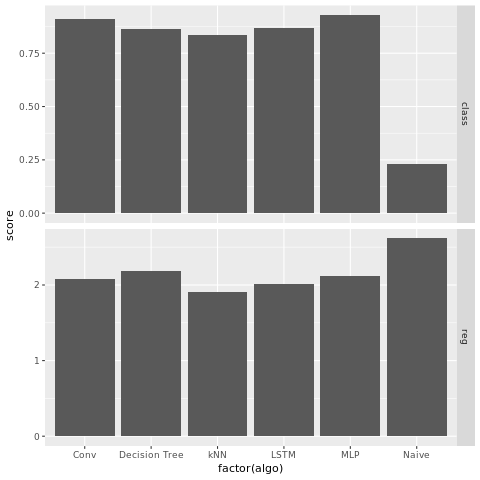

In [19]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, param1,param2,regularization) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","param1","param1","regularization")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)

# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score)) +
    geom_bar(stat='identity') +
    facet_grid(metric~., scales='free')
p
